# Complete Setup
* Hello! Welcome to this analysis code. Before we do anything cool with mean motion resonances, we have to get everything read in and prepared approrpriately. 
* For our first step, we want to read in our relevant packages.
* Next, we will write some homebrew functions that serve us in different parts of the analysis.
* Then, we have load in and preprocess all of our CSVs of outputs from our many simulation runs across different devices. 
* Then, we divide up the resultant dataframe into dataframes based on the presence of resonance.
* We further subdivide our dataframes based on the order of resonances. 
* Finally, we create arrays for different relevant system parameters by resonant order.
* In the Quick Setup section below, we offer a way to read in all of the products of the setup stage instead. 
* One disadvantage of this methodology is that masked arrays are not yet implemented in np.save. As such, if you want masked array information, you have to use the ``Complete Setup'' section.

In [ ]:
# Basic packages. 
# Arrays and dataframes
import numpy as np
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import seaborn as sns
from labellines import labelLines
import textalloc as ta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# Grabbing warnings to deal with many plot warnings that cloud the space. Learned warning syntax here: https://www.pythonpool.com/suppress-warnings-in-python/
import warnings
warnings.filterwarnings(action='ignore', category = FutureWarning) 
warnings.filterwarnings(action='ignore', category = UserWarning)




# Other useful packages ,
import os
from scipy import stats
from itertools import combinations
from scipy.stats import lognorm
import fractions
from astropy import units as u

os.chdir("/Users/finnkeller/Desktop/Keller, Finnegan University of Hawaii Insitute for Astronomy Summer Internship Formation of Exosolar Resonant Systems 2024/Population Synthesis/")

## Homebrew Functions
*  Later in the analysis, we will want the initial period ratios for each simulation. These were not saved initially, so we use get_initial_periods_and_ratios() to compute them and add them to our dataframe that will store the results.
* We also would like the mass ratios. Again, as these were not initially saved, we use get_mass_ratios() to compute and save them in a dataframe.
* We want to round our numbers nicely. We borrowed the function sig_figs() from StackOverflow to do so. This function has a couple gaps, namely it struggles with 0 and has some strange rounding properties, but it is pretty useful. 
* We will compute counting statistics uncertainties in a couple places, so we write a function uncertainty() to do so.
* At one point, we will also repeat system wide migration conditions for each planet, so we write a function to do that. 
* Occasionally, we will need the name of a specific simulation run. We also write a function to grab that. Unfortunately, simulations are not uniquely named, so it is possible that a given simulation name will appear in a couple of places, which can be frustrating.

In [ ]:
# We're going to read in our dataframe and add some useful information to it using the following functions.
def get_initial_periods_and_ratios(dataframe, period = False, ratio = False):
    # to get the initial period ratios, we need to compute the initial periods from the initial semi-major axes.
    dataframe_pl_initial_smaxes = np.transpose(np.vstack([dataframe["pl_orbsmax_0"].to_numpy(), dataframe["pl_orbsmax_1"].to_numpy(), dataframe["pl_orbsmax_2"].to_numpy(), dataframe["pl_orbsmax_3"].to_numpy(), dataframe["pl_orbsmax_4"].to_numpy(), dataframe["pl_orbsmax_5"].to_numpy(), dataframe["pl_orbsmax_6"].to_numpy()]))
    dataframe_pl_masses = np.transpose(np.vstack([dataframe["pl_mass_0"].to_numpy(), dataframe["pl_mass_1"].to_numpy(), dataframe["pl_mass_2"].to_numpy(), dataframe["pl_mass_3"].to_numpy(), dataframe["pl_mass_4"].to_numpy(), dataframe["pl_mass_5"].to_numpy(), dataframe["pl_mass_6"].to_numpy()]))
    dataframe_st_masses = dataframe['st_mass'].to_numpy()
    dataframe_pnums = dataframe["pnum"].to_numpy()
    dataframe_pl_initial_periods = pd.DataFrame(columns = ['p_i_0', 'p_i_1', 'p_i_2', 'p_i_3', 'p_i_4', 'p_i_5', 'p_i_6']) 
    for row in range(len(dataframe_pl_initial_smaxes)): 
        st_mass = dataframe_st_masses[row]
        pnum = dataframe_pnums[row]
        sy_pl_masses = dataframe_pl_masses[row][0:pnum]
        sy_smaxes = dataframe_pl_initial_smaxes[row][0:pnum]
        sy_orbpers = np.sqrt((sy_smaxes**3)/(st_mass+sy_pl_masses))
        for i in range(7-pnum):
            sy_orbpers = np.append(sy_orbpers, np.nan)
        dataframe_pl_initial_periods.loc[row] = sy_orbpers

    if period == True:
        dataframe_pl_initial_periods.reset_index(inplace = True)
        return dataframe_pl_initial_periods
    
    elif ratio == True and period == False:
        dataframe_initial_period_ratios = pd.DataFrame(columns = ['p_i_01', 'p_i_12', 'p_i_23', 'p_i_34', 'p_i_45', 'p_i_56'])
        for idx in range(len(dataframe_pnums)):
            pnum = dataframe_pnums[idx]
            sy_periods = dataframe_pl_initial_periods.iloc[idx][:pnum]
            sy_period_ratios = np.array([])
            for p in range(pnum-1):
                sy_period_ratios = np.append(sy_period_ratios, sy_periods[p+1]/sy_periods[p])
            for p in range(7-pnum):
                sy_period_ratios = np.append(sy_period_ratios, np.nan)
            dataframe_initial_period_ratios.loc[idx] = sy_period_ratios
        dataframe_initial_period_ratios.reset_index(inplace = True)
        return dataframe_initial_period_ratios
    
    elif period == True and ratio == True:
        dataframe_initial_period_ratios = pd.DataFrame(columns = ['p_i_01', 'p_i_12', 'p_i_23', 'p_i_34', 'p_i_45', 'p_i_56'])
        for idx in range(len(dataframe_pnums)):
            pnum = dataframe_pnums[idx]
            sy_periods = dataframe_pl_initial_periods.iloc[idx][:pnum]
            sy_period_ratios = np.array([])
            for p in range(pnum-1):
                sy_period_ratios = np.append(sy_period_ratios, sy_periods[p+1]/sy_periods[p])
            for p in range(7-pnum):
                sy_period_ratios = np.append(sy_period_ratios, np.nan)
            dataframe_initial_period_ratios.loc[idx] = sy_period_ratios
        dataframe_pl_initial_periods.reset_index(inplace = True)
        dataframe_initial_period_ratios.reset_index(inplace = True)
        return dataframe_pl_initial_periods, dataframe_initial_period_ratios
    elif period == False and ratio == False:
        dataframe_initial_period_ratios = pd.DataFrame(columns = ['p_i_01', 'p_i_12', 'p_i_23', 'p_i_34', 'p_i_45', 'p_i_56'])
        for idx in range(len(dataframe_pnums)):
            pnum = dataframe_pnums[idx]
            sy_periods = dataframe_pl_initial_periods.iloc[idx][:pnum]
            sy_period_ratios = np.array([])
            for p in range(pnum-1):
                try:
                    sy_period_ratios = np.append(sy_period_ratios, sy_periods[p+1]/sy_periods[p])
                except RuntimeWarning:
                    print(sy_periods[p+1])
                    print(sy_periods[p])
                    print(sy_periods[p+1]/sy_periods[p])
                    sy_period_ratios = np.append(sy_period_ratios, sy_periods[p+1]/sy_periods[p])
            for p in range(7-pnum):
                sy_period_ratios = np.append(sy_period_ratios, np.nan)
            dataframe_initial_period_ratios.loc[idx] = sy_period_ratios   
        dataframe_pl_initial_periods.reset_index(inplace = True)
        dataframe_initial_period_ratios.reset_index(inplace = True) 
        # Let's make a copy of the input dataframe with these new rows.
        #mod_dataframe = dataframe.join(dataframe_pl_initial_periods, on = 'level_0')
        mod_dataframe = pd.concat([dataframe, dataframe_pl_initial_periods], axis = 1)
        mod_dataframe = pd.concat([dataframe, dataframe_initial_period_ratios], axis = 1)
        return mod_dataframe

In [ ]:
def get_mass_ratios(dataframe, ratio = False): 
    dataframe_pl_masses = np.transpose(np.vstack([dataframe["pl_mass_0"].to_numpy(), dataframe["pl_mass_1"].to_numpy(), dataframe["pl_mass_2"].to_numpy(), dataframe["pl_mass_3"].to_numpy(), dataframe["pl_mass_4"].to_numpy(), dataframe["pl_mass_5"].to_numpy(), dataframe["pl_mass_6"].to_numpy()]))
    dataframe_pnums = dataframe["pnum"].to_numpy()
    dataframe_mass_ratios = pd.DataFrame(columns = ['m_01', 'm_12', 'm_23', 'm_34', 'm_45', 'm_56'])
    for idx in range(len(dataframe_pnums)):
        pnum = dataframe_pnums[idx]
        sy_mass_ratios = np.array([])
        for p in range(pnum - 1):
            sy_mass_ratios = np.append(sy_mass_ratios, dataframe_pl_masses[idx][p+1]/dataframe_pl_masses[idx][p])
        for p in range(7-pnum): 
            sy_mass_ratios = np.append(sy_mass_ratios, np.nan)
        dataframe_mass_ratios.loc[idx] = sy_mass_ratios
    if ratio == True:
        return dataframe_mass_ratios
    elif ratio == False:
        dataframe_mass_ratios.reset_index(inplace = True)
        mod_dataframe = pd.concat([dataframe, dataframe_mass_ratios], axis = 1)
        return mod_dataframe

In [ ]:
# Initially we used Delta = P_out/P_in - p/q to define resonance. We have decided to update this condition to (P_out/P_in)/(p/q) - 1.
def get_newly_defined_deltaas(dataframe, ratio = False): 
    dataframe_period_ratios = np.transpose(np.vstack([dataframe["p_ratio_01"].to_numpy(), dataframe["p_ratio_12"].to_numpy(), dataframe["p_ratio_23"].to_numpy(), dataframe["p_ratio_34"].to_numpy(), dataframe["p_ratio_45"].to_numpy(), dataframe["p_ratio_56"].to_numpy()]))
    dataframe_proximal_resonance = np.transpose(np.vstack([dataframe["prox_res_01"].to_numpy(), dataframe["prox_res_12"].to_numpy(), dataframe["prox_res_23"].to_numpy(), dataframe["prox_res_34"].to_numpy(), dataframe["prox_res_45"].to_numpy(), dataframe["prox_res_56"].to_numpy()]))
    dataframe_pnums = dataframe["pnum"].to_numpy()
    dataframe_new_deltas = pd.DataFrame(columns = ['delta_01', 'delta_12', 'delta_23', 'delta_34', 'delta_45', 'delta_56'])
    for idx in range(len(dataframe_pnums)):
        sy_deltas = np.array([])
        if np.isnan(dataframe_proximal_resonance[idx]).all() == True:
            for ppair in range(6): 
                sy_deltas = np.append(sy_deltas, np.nan)
        else:
            pnum = dataframe_pnums[idx]
            for ppair in range(pnum - 1):
                period_ratio = dataframe_period_ratios[idx][ppair]
                proximal_resonance = dataframe_proximal_resonance[idx][ppair]
                proximal_resonance_fraction = fractions.Fraction(proximal_resonance).limit_denominator(1000)
                p = proximal_resonance_fraction.numerator
                q = proximal_resonance_fraction.denominator
                sy_deltas = np.append(sy_deltas, period_ratio/(p/q) - 1)
            for ppair in range(7-pnum): 
                sy_deltas = np.append(sy_deltas, np.nan)
        dataframe_new_deltas.loc[idx] = sy_deltas
    if ratio == True:
        return dataframe_new_deltas
    elif ratio == False:
        dataframe_new_deltas.reset_index(inplace = True)
        mod_dataframe = pd.concat([dataframe, dataframe_new_deltas], axis = 1)
        return mod_dataframe

In [ ]:
from math import floor, log10
# stolen from https://mattgosden.medium.com/rounding-to-significant-figures-in-python-2415661b94c3


def sig_figs(x: float, precision: int):
    """
    Rounds a number to number of significant figures
    Parameters:
    - x - the number to be rounded
    - precision (integer) - the number of significant figures
    Returns:
    - float
    """

    x = float(x)
    precision = int(precision)

    return round(x, -int(floor(log10(abs(x)))) + (precision - 1))

# Generated by ChatGPT see https://chatgpt.com/share/67a3ec56-d9a4-8005-8025-505c7a1cfa8a
# Lets me put in trailing zeros, but it struggles with large numbers.
from math import floor, log10
def CHAT_sig_figs(num, sig_figs):
    if num == 0:
        return "0." + "0" * (sig_figs - 1)  # Handle the case of zero

    # Calculate the magnitude of the number
    magnitude = floor(log10(abs(num)))
    
    # Round the number to the correct number of significant figures
    rounded_num = round(num, sig_figs - magnitude - 1)
    
    # Format the result to ensure the correct number of significant figures
    return f"{rounded_num:.{sig_figs - int(magnitude) - 1}f}"

In [ ]:
# First, let's write a function that can compute the uncertainty in a given measurement.
# Let's define an uncertainty metric such that it return the percentage uncertainty
def uncertainty(n_sucess, n_total, report_type = 'Percent'):
    u =  np.sqrt((n_sucess*(n_total-n_sucess))/n_total)
    fraction_u = u/n_total
    percent_u = u/n_total*100
    if report_type == 'Percent':
        return percent_u
    elif report_type == 'Fraction':
        return fraction_u
    elif report_type == 'Value':
        return u

In [ ]:
def repeat_migration_conditions(dataframe):
    dataframe_pnums = dataframe["pnum"].to_numpy()
    dataframe_tauas = dataframe['taua'].to_numpy()
    dataframe_Ks = dataframe['K'].to_numpy()
    dataframe_taues = dataframe['taue'].to_numpy()
    dataframe_Sigmas = dataframe['Sigma'].to_numpy() 
    dataframe_hs = dataframe['h'].to_numpy()
    repeated_dataframe_tauas = np.array([])
    repeated_dataframe_Ks = np.array([])
    repeated_dataframe_taues = np.array([])
    repeated_dataframe_Sigmas = np.array([])
    repeated_dataframe_hs = np.array([])
    # Note: this nested loop takes a little while.
    for row in range(len(dataframe)):
        pnum = dataframe_pnums[row]
        taua = dataframe_tauas[row]
        K = dataframe_Ks[row]
        taue = dataframe_taues[row]
        Sigma = dataframe_Sigmas[row]
        h = dataframe_hs[row]
        ppairs = pnum -1
        for pair in range(ppairs): #probably a way to do this with concatenation better
            repeated_dataframe_tauas = np.append(repeated_dataframe_tauas, taua)
            repeated_dataframe_Ks = np.append(repeated_dataframe_Ks, K)
            repeated_dataframe_taues = np.append(repeated_dataframe_taues, taue)
            repeated_dataframe_Sigmas = np.append(repeated_dataframe_Sigmas, Sigma)
            repeated_dataframe_hs = np.append(repeated_dataframe_hs, h)
    return pd.DataFrame(np.transpose(np.vstack([repeated_dataframe_tauas, repeated_dataframe_Ks, repeated_dataframe_taues, repeated_dataframe_Sigmas, repeated_dataframe_hs])), columns = ['taua', 'K', 'taue', 'Sigma', 'h'])

In [ ]:
def plot_finder(index, K_outermost, tau_a):
    version = str(index)+'_inner_edge_' +'{0:1.1e}'.format(K_outermost)+'_taua_' +'{0:1.1e}'.format(tau_a)+'_'
    return version

## Dataset Preprocessing
* Each simulation run produced a different CSV of results. We combine them all here into a dataframe. There are also a few revisions that need to be made to this dataframe.
* First, there are a few (6) simulations with anomalously large negtive $\Delta$ values that we remove.
* In some earlier simulations, we had a different method of determining close encounters where $|a_2-a_1|\geq 5R_H$. The absolute values allowed planets to cross if they did so when far apart in their orbits. While some of these simulations could lead to resonant configurations, we removed them for simplicity and consistency with the literature. To avoid this problem with future simulations, we made our threshold $a_2-a_1\geq 5R_H$. If using old simulations, we still need to include a cell to remove old results. While these would have ended up in the failed systems (see below), we still remove them as they have different final properties because they integrated further (namely, $P_{out}/P_{in}<1$).
* We also separate out the $\sim 2000$ simulations with planets of masses larger than $30M_\oplus$ that we did not initially flag as too big properly.
* Next, we remove all of the simulations that failed to fully integrate.
* If we had used the $a_2-a_1\geq 5R_H$ threshold for all of our simulations, the systems with planet crossing events would count as failed simulations. Thus we cautiously include them in the set of failed simulations. However, we must be careful when doing so as certain properties of these systems are different from the remainder of the failed systems, primarily being they fully integrated and feature (a) final period ratio(s) less than one.
* Third, we find all subsets of the remaining systems that end up in full, partial, or interrupted 2 and 3 body resonant chains. 
* The number of planets in each of these various subsamples is displayed at the bottom of this section alongside a $\LaTeX$ ready table of the information. 

In [ ]:
# Note: When downloading from Dropbox files Fei ran locally (https://www.dropbox.com/scl/fo/8enrp4ljh78n4thu4zb71/AGycRjkyvFtoVtd8pFz7bkk?rlkey=gj8s5fxbjstcvtxx1o2b5a1re&e=1&dl=0), we download the file Migration_Runs_test, which is always empty. We want to skip this dataframe.
sim_results = pd.DataFrame()
for data, subdirs, files in os.walk('results/'):
    for i in files:
        if i == ".DS_Store":
            continue
        filename=os.path.join(data,i)
        sim_results_local = pd.read_csv(filename, index_col = False)
        if sim_results_local.empty == True:
            print("The CSV "+filename+" is empty. Continuing to import CSVs without concatenating "+filename+".")
            continue
        sim_results = pd.concat([sim_results, sim_results_local])
    
# A handful of systems (order 10) were entered weirdly and are classified with a bunch of missing data. I just remove them because I can't do any analysis with them.
nan_mask = np.array([], dtype = 'bool')
for row in range(len(sim_results)):
    if sim_results['close_encounter_flag'].iloc[row]!=True and sim_results['close_encounter_flag'].iloc[row]!=False:
        nan_mask = np.append(nan_mask, False)
    else: 
        nan_mask = np.append(nan_mask, True)
sim_results = sim_results[nan_mask]

sim_results.reset_index(inplace = True)
sim_results = get_initial_periods_and_ratios(sim_results)
sim_results = get_mass_ratios(sim_results)
sim_results = get_newly_defined_deltaas(sim_results)
print("Raw Number of Simulations: "+str(len(sim_results)))
sim_results.head(5)

Raw Number of Simulations: 25239


level_0  index  pnum  pl_orbsmax_0  pl_orbsmax_1  pl_orbsmax_2  \
0        0    0.0     4           0.1      0.252200      0.408715   
1        1    1.0     3           0.1      0.141986      0.203430   
2        2    2.0     3           0.1      0.139945      0.174997   
3        3    3.0     7           0.1      0.158869      0.203036   
4        4    3.0     7           0.1      0.149131      0.547496   

   pl_orbsmax_3  pl_orbsmax_4  pl_orbsmax_5  pl_orbsmax_6  ...      m_34  \
0      0.790771           NaN           NaN           NaN  ...       NaN   
1           NaN           NaN           NaN           NaN  ...       NaN   
2           NaN           NaN           NaN           NaN  ...       NaN   
3      0.361444      0.733229      1.225421      1.942181  ...  0.471954   
4      1.257621      2.735663      4.022291      8.223696  ...  1.390445   

       m_45      m_56  index  delta_01  delta_12  delta_23  delta_34  \
0       NaN       NaN      0 -0.000048  0.000046  0.000006       NaN   
1       NaN       NaN      1  0.000285  0.000444       NaN       NaN   
2       NaN       NaN      2  0.000126  0.000082       NaN       NaN   
3  0.983607  1.816667      3 -0.097256 -0.001837  0.072114  0.138934   
4  0.426540  0.963889      4  0.000581  0.000972  0.931594  1.149274   

   delta_45  delta_56  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3  0.096876  0.005721  
4 -0.093062  0.093314  

[5 rows x 136 columns]

In [ ]:
# We have a few systems (6) with very large negative deltas for a planet pair that ends in resonance. These are removed now.
# These systems are all high planet multiplicity (6 or 7) with integration times exceeding 10Myr. Half result in third order resonances and have the releant pair beyond 2.5 AU (rest of system is most closer). 
# These are not systems we can really probe as they are not like the Kepler systems. Additionally, long periods means that they have motion of libration period that is longer than we can probe in our simulations.
readin_negative_delta_tauas = np.load('output_variables/negative_delta_tauas.npy')
readin_negative_delta_K_outermosts = np.load('output_variables/negative_delta_K_outermosts.npy')
relevant_idxs = np.array([])
readin_overall_counter = 0
# Let's figure out which indexes they correspond to
for i in range(len(readin_negative_delta_tauas)):
    counter = 0
    taua = round(readin_negative_delta_tauas[i],8)
    K_outermost = round(readin_negative_delta_K_outermosts[i],8)
    for idx in range(len(sim_results)):
        if taua == round(sim_results.iloc[idx]['taua'], 8) and K_outermost == round(sim_results.iloc[idx]['K_outermost'], 8):
            if counter == 1: 
                print("Multiple systems have the identified taua and K factor values. Pull more conditions to isolate the system.")
            relevant_idxs = np.append(relevant_idxs, idx)
            counter+=1
    readin_overall_counter+=1
assert readin_overall_counter == len(readin_negative_delta_tauas)

# Let's mask out those indexes.
readin_mask = np.array([], dtype = 'bool')
for idx in range(len(sim_results)):
    if np.isin(idx, relevant_idxs):
        readin_mask = np.append(readin_mask, False)
    else:
        readin_mask = np.append(readin_mask, True)
sim_results_stage0 = sim_results[readin_mask]
neg_delta_sims = sim_results[~readin_mask]
# And return results.
print("Number of Systems with Resonant Pairs with Large Negative Deltas: "+str(len(neg_delta_sims)))
print("Number of Remaining Systems: "+str(len(sim_results_stage0)))
assert len(sim_results) == len(neg_delta_sims)+len(sim_results_stage0)

Number of Systems with Resonant Pairs with Large Negative Deltas: 6
Number of Remaining Systems: 25233


In [ ]:
# It is worth noting that a small selection of integrations (360) are sucessful but are flagged by rebound as having a convergence issue. The observable sign of these systems is a planet period less than 1.
# Weirdly, we do not see these getting flagged when we separate by encounter flag first even though these systems have negative close encounter flags.
# Now, fixing our close encounter threshold, we get no so called convergence errors. 
convergence_errors = np.array([], dtype = 'bool')
for row in range(len(sim_results_stage0)):
    p_ratios = np.hstack([sim_results_stage0["p_ratio_01"].iloc[row], sim_results_stage0["p_ratio_12"].iloc[row], sim_results_stage0["p_ratio_23"].iloc[row], sim_results_stage0["p_ratio_34"].iloc[row], sim_results_stage0["p_ratio_45"].iloc[row], sim_results_stage0["p_ratio_56"].iloc[row]])
    pnums = sim_results_stage0['pnum'].iloc[row]
    p_ratios = p_ratios[0:pnums-1]
    if np.any(p_ratios<1):
        convergence_errors = np.append(convergence_errors, False)
    else:
        convergence_errors = np.append(convergence_errors, True)
conv_results = sim_results_stage0[~convergence_errors]
print("Number of Systems That Had Convergence Errors: "+str(len(conv_results)))
sim_results_stage1 = sim_results_stage0[convergence_errors]
print("Number of Remaining Systems: "+str(len(sim_results_stage1)))
assert len(sim_results) == len(neg_delta_sims)+len(conv_results)+len(sim_results_stage1)

Number of Systems That Had Convergence Errors: 345
Number of Remaining Systems: 24888


In [ ]:
# We have a few systems (2000) that have masses greater than 30Mearth due to an improper while loop that did not actually resample mass if the masses were too high. Thus, we remove them. 
# Let's see what some of these systems look like 
mass_flag = np.array([], dtype = 'bool')
for idx in range(len(sim_results_stage1)):
    pl_masses = np.hstack([sim_results_stage1['pl_mass_0'].iloc[idx], sim_results_stage1['pl_mass_1'].iloc[idx], sim_results_stage1['pl_mass_2'].iloc[idx], sim_results_stage1['pl_mass_3'].iloc[idx], sim_results_stage1['pl_mass_4'].iloc[idx], sim_results_stage1['pl_mass_5'].iloc[idx], sim_results_stage1['pl_mass_6'].iloc[idx]])[:int(sim_results_stage1['pnum'].iloc[idx])]
    if (pl_masses>30*u.Mearth.to(u.Msun)).any() == True:
        mass_flag = np.append(mass_flag, True)
    else:
        mass_flag = np.append(mass_flag, False)
large_mass_sims = sim_results_stage1[mass_flag]
sim_results_stage2 = sim_results_stage1[~mass_flag]
print("Number of Systems with Masses Larger than 30Mearth: "+str(len(large_mass_sims)))
print("Number of Remaining Systems: "+str(len(sim_results_stage2)))
assert len(sim_results) == len(neg_delta_sims)+len(conv_results)+len(large_mass_sims)+len(sim_results_stage2)

Number of Systems with Masses Larger than 30Mearth: 2137
Number of Remaining Systems: 22751


In [ ]:
# Removing systems that had close encounters is easy, we just use the flag in the CSVs.
failed_sims = sim_results_stage2[sim_results_stage2["close_encounter_flag"]==True] 
sucessful_sims = sim_results_stage2[sim_results_stage2["close_encounter_flag"]==False]
print("Number of Systems Terminated Early Due To Close Encounters: "+str(len(failed_sims)))
print("Number of Systems that Sucessfully Integrated: "+str(len(sucessful_sims)))
all_sims = pd.concat([sucessful_sims, failed_sims])
assert len(all_sims) == len(sim_results_stage2)
assert len(sim_results) == len(neg_delta_sims)+len(large_mass_sims)+len(conv_results)+len(sucessful_sims)+len(failed_sims)

Number of Systems Terminated Early Due To Close Encounters: 16209
Number of Systems that Sucessfully Integrated: 6542


## Establishing Resonance
* Our next step is to determine what fraction of mean motion resonance (MMR) do the converged systems contain and to categorize it as described in the paper section 2.3.
* We divide partial chains into partial and interrupted chains, a distinction that we later decide to drop. These distinctions get merged together in the next subsection.

In [ ]:
# How many had higher order resonances?
# We previously wrote a function to classify 2 body resonant chains and systems with some resonances.
# This function does the resonant chains good, but it does not distinguish partial and broken resonant chains.
def resonance_captured_libration_amplitude_2(dataframe, max_libration_amp = 90):
    predicted_resonant_amplitudes = pd.DataFrame(np.transpose([dataframe["phi_amp_2_01"].to_numpy(), dataframe["phi_amp_2_12"].to_numpy(), dataframe["phi_amp_2_23"].to_numpy(), dataframe["phi_amp_2_34"].to_numpy(), dataframe["phi_amp_2_45"].to_numpy(), dataframe["phi_amp_2_56"].to_numpy()]), columns = ["phi_amp_2_01", "phi_amp_2_12", "phi_amp_2_23", "phi_amp_2_34", "phi_amp_2_45", "phi_amp_2_56"])
    resonant_chain_mask = np.array([], dtype = 'bool')
    resonances_mask = np.array([], dtype = 'bool')
    partial_resonances_mask = np.array([], dtype = 'bool')
    interrupted_resonances_mask = np.array([], dtype = 'bool')
    no_resonances_mask = np.array([], dtype = 'bool')
    for row in range(len(dataframe)):
        # all resonant case
        pnum = dataframe["pnum"].iloc[row]
        predicted_resonant_amplitudes_of_row = predicted_resonant_amplitudes.iloc[row].to_numpy()[0:pnum-1] # remove NaNs at the end of systems with fewer than the maximum planet count
        truth_table_of_row = predicted_resonant_amplitudes_of_row <= max_libration_amp #(max_libration_amp*u.deg).to(u.rad)
        # all resonant case
        if np.all(truth_table_of_row) == True:
            resonant_chain_mask = np.append(resonant_chain_mask, True)
        else:
            resonant_chain_mask = np.append(resonant_chain_mask, False)
        # some resonant case
        if np.all(truth_table_of_row) == False and np.any(truth_table_of_row) == True:
            resonances_mask = np.append(resonances_mask, True)
            # Let's now distinguish interrupted resonant chains from partial resonant chains. Note: in this method, systems that would qualify as both interrupted and partial chains get classified as interrupted ones.
            interrupted_resonances_marker = False
            for planet_pair in range(1, len(truth_table_of_row)-1):
                if truth_table_of_row[planet_pair] == False and truth_table_of_row[planet_pair-1]==True and truth_table_of_row[planet_pair+1]==True:
                    interrupted_resonances_marker = True
                    interrupted_resonances_mask = np.append(interrupted_resonances_mask, True)
                    partial_resonances_mask = np.append(partial_resonances_mask, False)
                    break
            if interrupted_resonances_marker == False:
                interrupted_resonances_mask = np.append(interrupted_resonances_mask, False)
                partial_resonances_mask = np.append(partial_resonances_mask, True)
        else:
            resonances_mask = np.append(resonances_mask, False)
            partial_resonances_mask = np.append(partial_resonances_mask, False)
            interrupted_resonances_mask = np.append(interrupted_resonances_mask, False)
        # no resonant case
        if np.all(truth_table_of_row) == False and np.any(truth_table_of_row) == False:
            no_resonances_mask = np.append(no_resonances_mask, True)
        else:
            no_resonances_mask = np.append(no_resonances_mask, False)
    resonant_chain = dataframe[resonant_chain_mask]
    resonances = dataframe[resonances_mask]
    interrupted_resonances = dataframe[interrupted_resonances_mask]
    partial_resonances = dataframe[partial_resonances_mask]
    no_resonances = dataframe[no_resonances_mask]
    assert len(resonances) == len(partial_resonances) + len(interrupted_resonances)
    assert len(resonant_chain) + len(resonances) + len(no_resonances) == len(dataframe)
    return resonant_chain, resonances, no_resonances, interrupted_resonances, partial_resonances

resonant_chains_2, resonances_2, no_resonances_2, interrupted_resonances_2, partial_resonances_2 = resonance_captured_libration_amplitude_2(sucessful_sims, 90)
print("Number of Systems in Two Body Resonant Chains: "+str(len(resonant_chains_2)))
print("Number of Systems with Some Two Body Resonant Pairs: "+str(len(resonances_2)))
print("\t* Number of Systems in Interrupted Two Body Resonant Chains: "+str(len(interrupted_resonances_2)))
print("\t* Number of Systems in Partial Two Body Resonant Chains: "+str(len(partial_resonances_2)))
print("Number of Systems without Signs of Two Body Resonance: "+str(len(no_resonances_2)))

Number of Systems in Two Body Resonant Chains: 5526
Number of Systems with Some Two Body Resonant Pairs: 1002
	* Number of Systems in Interrupted Two Body Resonant Chains: 216
	* Number of Systems in Partial Two Body Resonant Chains: 786
Number of Systems without Signs of Two Body Resonance: 14


In [ ]:
def resonance_captured_libration_amplitude_3(dataframe, max_libration_amp = 90):
    predicted_resonant_amplitudes = pd.DataFrame(np.transpose([dataframe["phi_amp_3_012"].to_numpy(), dataframe["phi_amp_3_123"].to_numpy(), dataframe["phi_amp_3_234"].to_numpy(), dataframe["phi_amp_3_345"].to_numpy(), dataframe["phi_amp_3_456"].to_numpy()]), columns = ["phi_amp_3_012", "phi_amp_3_123", "phi_amp_3_234", "phi_amp_3_345", "phi_amp_3_456"])
    resonant_chain_mask = np.array([], dtype = 'bool')
    resonances_mask = np.array([], dtype = 'bool')
    partial_resonances_mask = np.array([], dtype = 'bool')
    interrupted_resonances_mask = np.array([], dtype = 'bool')
    no_resonances_mask = np.array([], dtype = 'bool')
    for row in range(len(dataframe)):
        # all resonant case
        pnum = dataframe["pnum"].iloc[row]
        predicted_resonant_amplitudes_of_row = predicted_resonant_amplitudes.iloc[row].to_numpy()[0:pnum-2] # remove NaNs at the end of systems with fewer than the maximum planet count
        truth_table_of_row = predicted_resonant_amplitudes_of_row <= max_libration_amp #(max_libration_amp*u.deg).to(u.rad)
        # all resonant case
        if np.all(truth_table_of_row) == True:
            resonant_chain_mask = np.append(resonant_chain_mask, True)
        else:
            resonant_chain_mask = np.append(resonant_chain_mask, False)
        # some resonant case
        if np.all(truth_table_of_row) == False and np.any(truth_table_of_row) == True:
            resonances_mask = np.append(resonances_mask, True)
            # Let's now distinguish interrupted resonant chains from partial resonant chains.
            interrupted_resonances_marker = False
            for planet_triad in range(1, len(truth_table_of_row)-1):
                if truth_table_of_row[planet_triad] == False and truth_table_of_row[planet_triad-1]==True and truth_table_of_row[planet_triad+1]==True:
                    interrupted_resonances_marker = True
                    interrupted_resonances_mask = np.append(interrupted_resonances_mask, True)
                    partial_resonances_mask = np.append(partial_resonances_mask, False)
                    break
            if interrupted_resonances_marker == False:
                interrupted_resonances_mask = np.append(interrupted_resonances_mask, False)
                partial_resonances_mask = np.append(partial_resonances_mask, True)
        else:
            resonances_mask = np.append(resonances_mask, False)
            partial_resonances_mask = np.append(partial_resonances_mask, False)
            interrupted_resonances_mask = np.append(interrupted_resonances_mask, False)
        # no resonant case
        if np.all(truth_table_of_row) == False and np.any(truth_table_of_row) == False:
            no_resonances_mask = np.append(no_resonances_mask, True)
        else:
            no_resonances_mask = np.append(no_resonances_mask, False)
    resonant_chain = dataframe[resonant_chain_mask]
    resonances = dataframe[resonances_mask]
    interrupted_resonances = dataframe[interrupted_resonances_mask]
    partial_resonances = dataframe[partial_resonances_mask]
    no_resonances = dataframe[no_resonances_mask]
    assert len(resonances) == len(partial_resonances) + len(interrupted_resonances)
    assert len(resonant_chain) + len(resonances) + len(no_resonances) == len(dataframe)
    return resonant_chain, resonances, no_resonances, interrupted_resonances, partial_resonances

resonant_chains_3, resonances_3, no_resonances_3, interrupted_resonances_3, partial_resonances_3 = resonance_captured_libration_amplitude_3(sucessful_sims, 90)
print("Number of Systems in Three Body Resonant Chains: "+str(len(resonant_chains_3)))
print("Number of Systems with Some Three Body Resonant Triads: "+str(len(resonances_3)))
print("\t* Number of Systems in Interrupted Three Body Resonant Chains: "+str(len(interrupted_resonances_3)))
print("\t* Number of Systems in Partial Thre Body Resonant Chains: "+str(len(partial_resonances_3)))
print("Number of Systems without Signs of Three Body Resonance: "+str(len(no_resonances_3)))

Number of Systems in Three Body Resonant Chains: 3492
Number of Systems with Some Three Body Resonant Triads: 2741
	* Number of Systems in Interrupted Three Body Resonant Chains: 1055
	* Number of Systems in Partial Thre Body Resonant Chains: 1686
Number of Systems without Signs of Three Body Resonance: 309


In [ ]:
sigfigs = 3

print("Stage 1:")
print("\t* Number of Systems Terminated Early Due To Close Encounters: "+str(len(failed_sims)))
print("\t* Percentage of Systems Terminated Early Due To Close Encounters: "+str(sig_figs(len(failed_sims)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))
print("\t* Number of Systems that Sucessfully Integrated: "+str(len(sucessful_sims)))
print("\t* Percentage of Systems that Sucessfully Integrated: "+str(sig_figs(len(sucessful_sims)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))

print("Stage 2:")
print("\t* Number of Systems in Two Body Resonant Chains: "+str(len(resonant_chains_2)))
print("\t* Percentage of Systems in Two Body Resonant Chains: "+str(sig_figs(len(resonant_chains_2)/(len(resonant_chains_2)+len(resonances_2)+len(no_resonances_2)), sigfigs)*100))
print("\t* Percentage of Systems in Two Body Resonant Chains Relative to All Systems: "+str(sig_figs(len(resonant_chains_2)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))
print("\t* Number of Systems with Some Two Body Resonant Pairs: "+str(len(resonances_2)))
print("\t* Percentage of Systems with Some Two Body Resonant Pairs: "+str(sig_figs(len(resonances_2)/(len(resonant_chains_2)+len(resonances_2)+len(no_resonances_2)), sigfigs)*100))
print("\t* Percentage of Systems with Some Two Body Resonant Pairs Relative to All Systems: "+str(sig_figs(len(resonances_2)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))
print("\t* Number of Systems with No Two Body Resonant Pairs: "+str(len(no_resonances_2)))
print("\t* Percentage of Systems with Some Two Body Resonant Pairs: "+str(sig_figs(len(no_resonances_2)/(len(resonant_chains_2)+len(resonances_2)+len(no_resonances_2)), sigfigs)*100))
print("\t* Percentage of Systems with Some Two Body Resonant Pairs Relative to All Systems: "+str(sig_figs(len(no_resonances_2)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))

print("Stage 3:")
print("\t* Number of Systems in Interrupted Two Body Resonant Chains: "+str(len(interrupted_resonances_2)))
print("\t* Percentage of Systems in Interrupted Two Body Resonant Chains: "+str(sig_figs(len(interrupted_resonances_2)/(len(resonances_2)), sigfigs)*100))
print("\t* Percentage of Systems in Interrupted Two Body Resonant Chains Relative to All Systems: "+str(sig_figs(len(interrupted_resonances_2)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))
print("\t* Number of Systems in Partial Two Body Resonant Chains: "+str(len(partial_resonances_2)))
print("\t* Percentage of Systems in Partial Two Body Resonant Chains: "+str(sig_figs(len(partial_resonances_2)/(len(resonances_2)), sigfigs)*100))
print("\t* Percentage of Systems in Partial Two Body Resonant Chains Relative to All Systems: "+str(sig_figs(len(partial_resonances_2)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))

print("Stage 4:")
print("\t* Number of Systems in Three Body Resonant Chains: "+str(len(resonant_chains_3)))
print("\t* Percentage of Systems in Three Body Resonant Chains: "+str(sig_figs(len(resonant_chains_3)/(len(resonant_chains_3)+len(resonances_3)+len(no_resonances_3)), sigfigs)*100))
print("\t* Percentage of Systems in Three Body Resonant Chains Relative to All Systems: "+str(sig_figs(len(resonant_chains_3)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))
print("\t* Number of Systems with Some Three Body Resonant Triads: "+str(len(resonances_3)))
print("\t* Percentage of Systems with Some Three Body Resonant Triads: "+str(sig_figs(len(resonances_3)/(len(resonant_chains_3)+len(resonances_3)+len(no_resonances_3)), sigfigs)*100))
print("\t* Percentage of Systems with Some Three Body Resonant Triads Relative to All Systems: "+str(sig_figs(len(resonances_3)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))
print("\t* Number of Systems with No Three Body Resonant Triads: "+str(len(no_resonances_3)))
print("\t* Percentage of Systems with No Three Body Resonant Triads: "+str(sig_figs(len(no_resonances_3)/(len(resonant_chains_3)+len(resonances_3)+len(no_resonances_3)), sigfigs)*100))
print("\t* Percentage of Systems with No Three Body Resonant Triads Relative to All Systems: "+str(sig_figs(len(no_resonances_3)/len(sucessful_sims)+len(failed_sims), sigfigs)*100))

print("Stage 5:")
print("\t* Number of Systems in Interrupted Three Body Resonant Chains: "+str(len(interrupted_resonances_3)))
print("\t* Percentage of Systems in Interrupted Three Body Resonant Chains: "+str(sig_figs(len(interrupted_resonances_3)/(len(resonances_3)), sigfigs)*100))
print("\t* Percentage of Systems in Interrupted Three Body Resonant Chains Relative to All Systems: "+str(sig_figs(len(interrupted_resonances_3)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))
print("\t* Number of Systems in Partial Three Body Resonant Chains: "+str(len(partial_resonances_3)))
print("\t* Percentage of Systems in Partial Three Body Resonant Chains: "+str(sig_figs(len(partial_resonances_3)/(len(resonances_3)), sigfigs)*100))
print("\t* Percentage of Systems in Partial Three Body Resonant Chains Relative to All Systems: "+str(sig_figs(len(partial_resonances_3)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100))

Stage 1:
	* Number of Systems Terminated Early Due To Close Encounters: 16209
	* Percentage of Systems Terminated Early Due To Close Encounters: 71.2
	* Number of Systems that Sucessfully Integrated: 6542
	* Percentage of Systems that Sucessfully Integrated: 28.799999999999997
Stage 2:
	* Number of Systems in Two Body Resonant Chains: 5526
	* Percentage of Systems in Two Body Resonant Chains: 84.5
	* Percentage of Systems in Two Body Resonant Chains Relative to All Systems: 24.3
	* Number of Systems with Some Two Body Resonant Pairs: 1002
	* Percentage of Systems with Some Two Body Resonant Pairs: 15.299999999999999
	* Percentage of Systems with Some Two Body Resonant Pairs Relative to All Systems: 4.3999999999999995
	* Number of Systems with No Two Body Resonant Pairs: 14
	* Percentage of Systems with Some Two Body Resonant Pairs: 0.214
	* Percentage of Systems with Some Two Body Resonant Pairs Relative to All Systems: 0.0615
Stage 3:
	* Number of Systems in Interrupted Two Body Reson

## Categorization of Resonant Order
* In order to determine how prevalent resonant chains are, we need to do a bunch of work to determine the relative fraction of MMRs of different orders.
* We do so for complete 2-body chains, interrupted 2-body chains, partial 2-body chains, and complete 3-body chains before recombining partial and interrupted chains.

In [ ]:
# Let's determine the relative abundance of higher order resonances.
global decimal_resonances, fractional_resonances
decimal_resonances = [11/10, 21/19, 10/9, 19/17, 28/25, 9/8, 26/23, 17/15, 25/22, 8/7, 15/13, 22/19, 7/6, 20/17, 13/11, 19/16, 6/5, 17/14, 11/9, 16/13, 5/4, 14/11, 9/7, 13/10, 4/3, 11/8, 7/5, 10/7, 3/2, 8/5, 5/3, 7/4, 2/1, 5/2, 3/1, 4/1]
fractional_resonances = [fractions.Fraction(11,10), fractions.Fraction(21,19), fractions.Fraction(10, 9), fractions.Fraction(19,17), fractions.Fraction(28,25), fractions.Fraction(9,8), fractions.Fraction(26,23), fractions.Fraction(17,15), fractions.Fraction(25,22), fractions.Fraction(8,7),
                         fractions.Fraction(15,13), fractions.Fraction(22,19), fractions.Fraction(7,6), fractions.Fraction(20,17), fractions.Fraction(13,11), fractions.Fraction(19,16), fractions.Fraction(6,5), fractions.Fraction(17,14), fractions.Fraction(11,9),
                         fractions.Fraction(16,13), fractions.Fraction(5,4), fractions.Fraction(14,11), fractions.Fraction(9,7), fractions.Fraction(13,10), fractions.Fraction(4,3), fractions.Fraction(11,8), fractions.Fraction(7,5), fractions.Fraction(10,7),
                         fractions.Fraction(3,2), fractions.Fraction(8,5), fractions.Fraction(5,3), fractions.Fraction(7,4), fractions.Fraction(2,1), fractions.Fraction(5,2), fractions.Fraction(3,1), fractions.Fraction(4,1)]

# Let's combine our datasets of some resonant and resonant chains.
# If we just want the chains where every proximal resonance is actually a librating resonance, we can avoid the masked arrays and just use:
# present_resonances = np.hstack([resonant_chains_2["prox_res_01"].to_numpy(), resonant_chains_2["prox_res_12"].to_numpy(), resonant_chains_2["prox_res_23"].to_numpy(), resonant_chains_2["prox_res_34"].to_numpy(), resonant_chains_2["prox_res_45"].to_numpy(), resonant_chains_2["prox_res_56"].to_numpy()])
# present_resonances = present_resonances[np.isnan(present_resonances)==False]
combined_resonances = pd.concat([resonant_chains_2, resonances_2])
# This is the dataset of all systems where some of the planets resonanate
all_amplitudes = np.transpose(np.vstack([combined_resonances["phi_amp_2_01"].to_numpy(), combined_resonances["phi_amp_2_12"].to_numpy(), combined_resonances["phi_amp_2_23"].to_numpy(), combined_resonances["phi_amp_2_34"].to_numpy(), combined_resonances["phi_amp_2_45"].to_numpy(), combined_resonances["phi_amp_2_56"].to_numpy()]))
non_librating_planet_pairs_mask = all_amplitudes>90
# Let's use this mask to find the actually resonant pairs in the dataset.
potentially_present_resonances = np.transpose(np.vstack([combined_resonances["prox_res_01"].to_numpy(), combined_resonances["prox_res_12"].to_numpy(), combined_resonances["prox_res_23"].to_numpy(), combined_resonances["prox_res_34"].to_numpy(), combined_resonances["prox_res_45"].to_numpy(), combined_resonances["prox_res_56"].to_numpy()]))
present_resonances = np.ma.masked_array(potentially_present_resonances, mask = non_librating_planet_pairs_mask).ravel()
present_resonances = present_resonances[np.isnan(present_resonances)==False]

# Let's relate these resonances to fractional resonances
present_fractional_resonances = np.array([])
for res in present_resonances:
    present_fractional_resonances = np.append(present_fractional_resonances, fractions.Fraction(res).limit_denominator(1000))
    assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)

# Let's classify the seen fractional resonances by their order
fractional_first_order_resonances = np.array([])
fractional_second_order_resonances = np.array([])
fractional_third_order_resonances = np.array([])
for frac_res in present_fractional_resonances:
    if frac_res.numerator-frac_res.denominator == 1:
        fractional_first_order_resonances = np.append(fractional_first_order_resonances, frac_res)
    elif frac_res.numerator-frac_res.denominator == 2:
        fractional_second_order_resonances = np.append(fractional_second_order_resonances, frac_res)
    elif frac_res.numerator-frac_res.denominator == 3:
        fractional_third_order_resonances = np.append(fractional_third_order_resonances, frac_res)
    else:
        print("The resonance "+str(frac_res)+" is not first, second, or third order.")
higher_order_resonances = np.hstack([fractional_second_order_resonances, fractional_third_order_resonances])

# Let's determine the percentage of planet pairs in resonance.
number_of_resonant_planet_pairs = len(fractional_first_order_resonances)+len(fractional_second_order_resonances)+len(fractional_third_order_resonances)
# Note: this percentage adds to 100 for just the resonant chains, but when we include systems with some nonresonant planets, we will get a lower percentage if not all planet pairs have resonant angles.
ppairs = all_sims["pnum"].to_numpy()-1
number_of_planet_pairs = np.sum(ppairs) # good for number relative to total number of resonant and nonresonant pairs
print("Number of First Order Resonant Pairs: "+str(len(fractional_first_order_resonances)))
print("Percent of First Order Resonances: "+str(len(fractional_first_order_resonances)/number_of_resonant_planet_pairs*100)+"\pm"+str(uncertainty(len(fractional_first_order_resonances), number_of_resonant_planet_pairs))+"%")
print("Percent of First Order Resonances Relative to the Total Number of Planet Pairs: "+str(len(fractional_first_order_resonances)/number_of_planet_pairs*100)+"\pm"+str(uncertainty(len(fractional_first_order_resonances), number_of_planet_pairs))+"%")
print("Number of Second Order Resonant Pairs: "+str(len(fractional_second_order_resonances)))
print("Percent of Second Order Resonances: "+str(len(fractional_second_order_resonances)/number_of_resonant_planet_pairs*100)+"\pm"+str(uncertainty(len(fractional_second_order_resonances), number_of_resonant_planet_pairs))+"%")
print("Percent of Second Order Resonances Relative to the Total Number of Planet Pairs: "+str(len(fractional_second_order_resonances)/number_of_planet_pairs*100)+"\pm"+str(uncertainty(len(fractional_second_order_resonances), number_of_planet_pairs))+"%")
print("Number of Third Order Resonant Pairs: "+str(len(fractional_third_order_resonances)))
print("Percent of Third Order Resonances: "+str(len(fractional_third_order_resonances)/number_of_resonant_planet_pairs*100)+"\pm"+str(uncertainty(len(fractional_third_order_resonances), number_of_resonant_planet_pairs))+"%")
print("Percent of Third Order Resonances Relative to the Total Number of Planet Pairs: "+str(len(fractional_third_order_resonances)/number_of_planet_pairs*100)+"\pm"+str(uncertainty(len(fractional_third_order_resonances), number_of_planet_pairs))+"%")
print("Number of Second and Third Order Resonant Pairs: "+str(len(higher_order_resonances)))
print("Percent of Second and Third Order Resonances: "+str(len(higher_order_resonances)/number_of_resonant_planet_pairs*100)+"\pm"+str(uncertainty(len(higher_order_resonances), number_of_resonant_planet_pairs))+"%")
print("Percent of Second and Third Order Resonances Relative to the Total Number of Planet Pairs: "+str(len(higher_order_resonances)/number_of_planet_pairs*100)+"\pm"+str(uncertainty(len(higher_order_resonances), number_of_planet_pairs))+"%")

Number of First Order Resonant Pairs: 22444
Percent of First Order Resonances: 94.6245625869556\pm0.14644031680709638%
Percent of First Order Resonances Relative to the Total Number of Planet Pairs: 21.923106978198014\pm0.12930437947192716%
Number of Second Order Resonant Pairs: 1124
Percent of Second Order Resonances: 4.738816982166196\pm0.13795732532514154%
Percent of Second Order Resonances Relative to the Total Number of Planet Pairs: 1.0979135734937875\pm0.03256774773740007%
Number of Third Order Resonant Pairs: 151
Percent of Third Order Resonances: 0.6366204308781989\pm0.05164226426689279%
Percent of Third Order Resonances Relative to the Total Number of Planet Pairs: 0.14749550675939674\pm0.011994158892426792%
Number of Second and Third Order Resonant Pairs: 1275
Percent of Second and Third Order Resonances: 5.375437413044395\pm0.14644031680709638%
Percent of Second and Third Order Resonances Relative to the Total Number of Planet Pairs: 1.2454090802531843\pm0.03466056059125320

In [ ]:
# Let's break down these relationships for individual resonances.
decimal_first_order_resonances = np.array([])
for frac_res in fractional_first_order_resonances:
    decimal_first_order_resonances = np.append(decimal_first_order_resonances, frac_res.numerator/frac_res.denominator)

fractional_first_order_resonances_unique, first_order_resonances_unique_counts = np.unique(fractional_first_order_resonances, return_counts = True)
decimal_first_order_resonances_unique = np.array([])
for frac_res in fractional_first_order_resonances_unique:
    decimal_first_order_resonances_unique = np.append(decimal_first_order_resonances_unique, frac_res.numerator/frac_res.denominator)

first_order_uncertainties = np.array([])
for idx in range(len(decimal_first_order_resonances_unique)): 
    res_uncert = uncertainty(first_order_resonances_unique_counts[idx], len(fractional_first_order_resonances), report_type = 'Fraction')
    first_order_uncertainties = np.append(first_order_uncertainties, res_uncert)

first_order_uncertainties_entire_sample = np.array([])
for idx in range(len(decimal_first_order_resonances_unique)): 
    res_uncert = uncertainty(first_order_resonances_unique_counts[idx], number_of_planet_pairs, report_type = 'Fraction')
    first_order_uncertainties_entire_sample = np.append(first_order_uncertainties_entire_sample, res_uncert)

first_order_labels = np.array([])
for frac_res in fractional_first_order_resonances_unique:
    first_order_labels = np.append(first_order_labels, str(frac_res.numerator)+":"+str(frac_res.denominator))

for idx in range(len(fractional_first_order_resonances_unique)):
    print("Number of "+first_order_labels[idx]+" MMR: "+str(first_order_resonances_unique_counts[idx]))
    print("Percent of "+first_order_labels[idx]+" MMR: "+str(first_order_resonances_unique_counts[idx]/len(fractional_first_order_resonances)*100)+"\pm"+str(first_order_uncertainties[idx]))
    print("Percent of "+first_order_labels[idx]+" MMR Relative to the the Total Number of Planet Pairs: "+str(first_order_resonances_unique_counts[idx]/number_of_planet_pairs*100)+"\pm"+str(first_order_uncertainties_entire_sample[idx]))

decimal_second_order_resonances = np.array([])
for frac_res in fractional_second_order_resonances:
    decimal_second_order_resonances = np.append(decimal_second_order_resonances, frac_res.numerator/frac_res.denominator)
    
fractional_second_order_resonances_unique, second_order_resonances_unique_counts = np.unique(fractional_second_order_resonances, return_counts = True)
decimal_second_order_resonances_unique = np.array([])
for frac_res in fractional_second_order_resonances_unique:
    decimal_second_order_resonances_unique = np.append(decimal_second_order_resonances_unique, frac_res.numerator/frac_res.denominator)

second_order_uncertainties = np.array([])
for idx in range(len(decimal_second_order_resonances_unique)): 
    res_uncert = uncertainty(second_order_resonances_unique_counts[idx], len(fractional_second_order_resonances), report_type = 'Fraction')
    second_order_uncertainties = np.append(second_order_uncertainties, res_uncert)

second_order_uncertainties_entire_sample = np.array([])
for idx in range(len(decimal_second_order_resonances_unique)): 
    res_uncert = uncertainty(second_order_resonances_unique_counts[idx], number_of_planet_pairs, report_type = 'Fraction')
    second_order_uncertainties_entire_sample = np.append(second_order_uncertainties_entire_sample, res_uncert)

second_order_labels = np.array([])
for frac_res in fractional_second_order_resonances_unique:
    second_order_labels = np.append(second_order_labels, str(frac_res.numerator)+":"+str(frac_res.denominator))

for idx in range(len(fractional_second_order_resonances_unique)):
    print("Number of "+second_order_labels[idx]+" MMR: "+str(second_order_resonances_unique_counts[idx]))
    print("Percent of "+second_order_labels[idx]+" MMR: "+str(second_order_resonances_unique_counts[idx]/len(fractional_second_order_resonances)*100)+"\pm"+str(second_order_uncertainties[idx]))
    print("Percent of "+second_order_labels[idx]+" MMR Relative to the the Total Number of Planet Pairs:"+str(second_order_resonances_unique_counts[idx]/number_of_planet_pairs*100)+"\pm"+str(second_order_uncertainties_entire_sample[idx]))

decimal_third_order_resonances = np.array([])
for frac_res in fractional_third_order_resonances:
    decimal_third_order_resonances = np.append(decimal_third_order_resonances, frac_res.numerator/frac_res.denominator)

fractional_third_order_resonances_unique, third_order_resonances_unique_counts = np.unique(fractional_third_order_resonances, return_counts = True)
decimal_third_order_resonances_unique = np.array([])
for frac_res in fractional_third_order_resonances_unique:
    decimal_third_order_resonances_unique = np.append(decimal_third_order_resonances_unique, frac_res.numerator/frac_res.denominator)

third_order_uncertainties = np.array([])
for idx in range(len(decimal_third_order_resonances_unique)): 
    res_uncert = uncertainty(third_order_resonances_unique_counts[idx], len(fractional_third_order_resonances), report_type = 'Fraction')
    third_order_uncertainties = np.append(third_order_uncertainties, res_uncert)

third_order_uncertainties_entire_sample = np.array([])
for idx in range(len(decimal_third_order_resonances_unique)): 
    res_uncert = uncertainty(third_order_resonances_unique_counts[idx], number_of_planet_pairs, report_type = 'Fraction')
    third_order_uncertainties_entire_sample = np.append(third_order_uncertainties_entire_sample, res_uncert)

third_order_labels = np.array([])
for frac_res in fractional_third_order_resonances_unique:
    third_order_labels = np.append(third_order_labels, str(frac_res.numerator)+":"+str(frac_res.denominator))


for idx in range(len(fractional_third_order_resonances_unique)):
    print("Number of "+third_order_labels[idx]+" MMR: "+str(third_order_resonances_unique_counts[idx]))
    print("Percent of "+third_order_labels[idx]+" MMR: "+str(third_order_resonances_unique_counts[idx]/len(fractional_third_order_resonances)*100)+"\pm"+str(third_order_uncertainties[idx]))
    print("Percent of "+third_order_labels[idx]+" MMR Relative to the the Total Number of Planet Pairs:"+str(third_order_resonances_unique_counts[idx]/number_of_planet_pairs*100)+"\pm"+str(third_order_uncertainties_entire_sample))
# We will add all of this information to a table later.

Number of 11:10 MMR: 4
Percent of 11:10 MMR: 0.017822135091783996\pm8.910273439260657e-05
Percent of 11:10 MMR Relative to the the Total Number of Planet Pairs: 0.0039071657419707745\pm1.9535447057522507e-05
Number of 10:9 MMR: 10
Percent of 10:9 MMR: 0.044555337729459986\pm0.00014086495722394056
Percent of 10:9 MMR Relative to the the Total Number of Planet Pairs: 0.009767914354926936\pm3.088734871561639e-05
Number of 9:8 MMR: 37
Percent of 9:8 MMR: 0.16485474959900195\pm0.000270796052429468
Percent of 9:8 MMR Relative to the the Total Number of Planet Pairs: 0.036141283113229665\pm5.940516563209107e-05
Number of 8:7 MMR: 50
Percent of 8:7 MMR: 0.22277668864729996\pm0.0003147026855705508
Percent of 8:7 MMR Relative to the the Total Number of Planet Pairs: 0.04883957177463468\pm6.90527160795627e-05
Number of 7:6 MMR: 113
Percent of 7:6 MMR: 0.5034753163428979\pm0.0004724359278625197
Percent of 7:6 MMR Relative to the the Total Number of Planet Pairs: 0.11037743221067436\pm0.00010377703

In [ ]:
# Let's determine the relative abundance of higher order resonances in 2 body resonant chains.
# Let's combine our datasets of some resonant and resonant chains.
# If we just want the chains where every proximal resonance is actually a librating resonance, we can avoid the masked arrays and just use:
present_resonances = np.hstack([resonant_chains_2["prox_res_01"].to_numpy(), resonant_chains_2["prox_res_12"].to_numpy(), resonant_chains_2["prox_res_23"].to_numpy(), resonant_chains_2["prox_res_34"].to_numpy(), resonant_chains_2["prox_res_45"].to_numpy(), resonant_chains_2["prox_res_56"].to_numpy()])
present_resonances = present_resonances[np.isnan(present_resonances)==False]

# Let's relate these resonances to fractional resonances
present_fractional_resonances = np.array([])
for res in present_resonances:
    present_fractional_resonances = np.append(present_fractional_resonances, fractions.Fraction(res).limit_denominator(1000))
    assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)

# Let's classify the seen fractional resonances by their order
first_order_resonances_2chain = np.array([])
second_order_resonances_2chain = np.array([])
third_order_resonances_2chain = np.array([])

for frac_res in present_fractional_resonances:
    if frac_res.numerator-frac_res.denominator == 1:
        first_order_resonances_2chain = np.append(first_order_resonances_2chain, frac_res)
    elif frac_res.numerator-frac_res.denominator == 2:
        second_order_resonances_2chain = np.append(second_order_resonances_2chain, frac_res)
    elif frac_res.numerator-frac_res.denominator == 3:
        third_order_resonances_2chain = np.append(third_order_resonances_2chain, frac_res)
    else:
        print("The resonance "+str(frac_res)+" is not first, second, or third order.")
higher_order_resonances_2chain = np.hstack([second_order_resonances_2chain, third_order_resonances_2chain])


# Let's find systems with only first order resonances vs. those with higher order resonances. We assign a system third order if it has a third order in it, even if it also has second order resonance.
present_resonances_df = pd.DataFrame(np.transpose(np.vstack([resonant_chains_2["prox_res_01"].to_numpy(), resonant_chains_2["prox_res_12"].to_numpy(), resonant_chains_2["prox_res_23"].to_numpy(), resonant_chains_2["prox_res_34"].to_numpy(), resonant_chains_2["prox_res_45"].to_numpy(), resonant_chains_2["prox_res_56"].to_numpy()])), columns = ["prox_res_01", "prox_res_12", "prox_res_23", "prox_res_34", "prox_res_45", "prox_res_56"])

first_order_resonant_chains_mask = np.array([], dtype = 'bool')
second_order_resonant_chains_mask = np.array([], dtype = 'bool')
third_order_resonant_chains_mask = np.array([], dtype = 'bool')
higher_order_resonant_chains_mask = np.array([], dtype = 'bool')
for idx in range(len(resonant_chains_2)):
    resonances = present_resonances_df.iloc[idx].to_numpy()
    resonances_nonan = resonances[np.isnan(resonances)==False]
    fractional_resonances_nonan = np.array([])
    for res in resonances_nonan:
        fractional_resonances_nonan = np.append(fractional_resonances_nonan, fractions.Fraction(res).limit_denominator(1000))
        assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)
    if np.isin(fractional_resonances_nonan, first_order_resonances_2chain).all() == True and np.isin(resonances_nonan, fractional_second_order_resonances).any() == False and np.isin(resonances_nonan, fractional_third_order_resonances).any() == False:
        first_order_resonant_chains_mask = np.append(first_order_resonant_chains_mask, True)
        second_order_resonant_chains_mask = np.append(second_order_resonant_chains_mask, False)
        third_order_resonant_chains_mask = np.append(third_order_resonant_chains_mask, False)
        higher_order_resonant_chains_mask = np.append(higher_order_resonant_chains_mask, False)
    elif np.isin(fractional_resonances_nonan, second_order_resonances_2chain).any() == True and np.isin(resonances_nonan, third_order_resonances_2chain).any() == False:
        second_order_resonant_chains_mask = np.append(second_order_resonant_chains_mask, True)
        higher_order_resonant_chains_mask = np.append(higher_order_resonant_chains_mask, True)
        first_order_resonant_chains_mask = np.append(first_order_resonant_chains_mask, False)
        third_order_resonant_chains_mask = np.append(third_order_resonant_chains_mask, False)
    elif np.isin(fractional_resonances_nonan, third_order_resonances_2chain).any() == True:
        third_order_resonant_chains_mask = np.append(third_order_resonant_chains_mask, True)
        higher_order_resonant_chains_mask = np.append(higher_order_resonant_chains_mask, True)
        first_order_resonant_chains_mask = np.append(first_order_resonant_chains_mask, False)
        second_order_resonant_chains_mask = np.append(second_order_resonant_chains_mask, False)
    else:
        print(fractional_resonances_nonan)
        print(np.isin(fractional_resonances_nonan, first_order_resonances_2chain))
        print(np.isin(fractional_resonances_nonan, higher_order_resonances_2chain))

first_order_resonant_chains_2 = resonant_chains_2[first_order_resonant_chains_mask]
second_order_resonant_chains_2 = resonant_chains_2[second_order_resonant_chains_mask]
third_order_resonant_chains_2 = resonant_chains_2[third_order_resonant_chains_mask]
higher_order_resonant_chains_2 = resonant_chains_2[higher_order_resonant_chains_mask]
assert len(second_order_resonant_chains_2)+len(third_order_resonant_chains_2) == len(higher_order_resonant_chains_2)

print("Number of Systems in First Order Resonant Chains: "+str(len(first_order_resonant_chains_2)))
print("Percent of Systems in First Order Resonant Chains: "+str(len(first_order_resonant_chains_2)/len(resonant_chains_2)*100)+"\pm"+str(uncertainty(len(first_order_resonant_chains_2), len(resonant_chains_2))))
print("Percent of Systems in First Order Resonant Chains Relative to the Entire Sample: "+str(len(first_order_resonant_chains_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(first_order_resonant_chains_2), len(all_sims))))
print("Number of Systems with Second (no third included) Order Resonances in Resonant Chains: "+str(len(second_order_resonant_chains_2)))
print("Percent of Systems with Second (no third included) Order Resonances in Resonant Chains: "+str(len(second_order_resonant_chains_2)/len(resonant_chains_2)*100)+"\pm"+str(uncertainty(len(second_order_resonant_chains_2), len(resonant_chains_2))))
print("Percent of Systems with Second (no third included) Order Resonances in Resonant Chains Relative to the Entire Sample: "+str(len(second_order_resonant_chains_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(second_order_resonant_chains_2), len(all_sims))))
print("Number of Systems with Third (and possibly second) Order Resonances in Resonant Chains: "+str(len(third_order_resonant_chains_2)))
print("Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains: "+str(len(third_order_resonant_chains_2)/len(resonant_chains_2)*100)+"\pm"+str(uncertainty(len(third_order_resonant_chains_2), len(resonant_chains_2))))
print("Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains Relative to the Entire Sample: "+str(len(third_order_resonant_chains_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(third_order_resonant_chains_2), len(all_sims))))
print("Number of Systems with Higher Order Resonances in Resonant Chains: "+str(len(higher_order_resonant_chains_2)))
print("Percent of Systems with Higher Order Resonances in Resonant Chains: "+str(len(higher_order_resonant_chains_2)/len(resonant_chains_2)*100)+"\pm"+str(uncertainty(len(higher_order_resonant_chains_2), len(resonant_chains_2))))
print("Percent of Systems with Higher Order Resonances in Resonant Chains Relative to the Entire Sample: "+str(len(higher_order_resonant_chains_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(higher_order_resonant_chains_2), len(all_sims))))

Number of Systems in First Order Resonant Chains: 4708
Percent of Systems in First Order Resonant Chains: 85.19724936663047\pm0.47772564784771054
Percent of Systems in First Order Resonant Chains Relative to the Entire Sample: 20.693595885895125\pm0.2685788846636801
Number of Systems with Second (no third included) Order Resonances in Resonant Chains: 720
Percent of Systems with Second (no third included) Order Resonances in Resonant Chains: 13.029315960912053\pm0.45283690199111326
Percent of Systems with Second (no third included) Order Resonances in Resonant Chains Relative to the Entire Sample: 3.1646960573161618\pm0.1160600137802199
Number of Systems with Third (and possibly second) Order Resonances in Resonant Chains: 98
Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains: 1.7734346724574739\pm0.17754834828999516
Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains Relative to the Entire Sample: 0.4307502966902

In [ ]:
# Let's do the same for the two-body interrupted chains. We again need to return to the masked arrays.
all_amplitudes = np.transpose(np.vstack([interrupted_resonances_2["phi_amp_2_01"].to_numpy(), interrupted_resonances_2["phi_amp_2_12"].to_numpy(), interrupted_resonances_2["phi_amp_2_23"].to_numpy(), interrupted_resonances_2["phi_amp_2_34"].to_numpy(), interrupted_resonances_2["phi_amp_2_45"].to_numpy(), interrupted_resonances_2["phi_amp_2_56"].to_numpy()]))
non_librating_planet_pairs_mask = all_amplitudes>90
# Let's use this mask to find the actually resonant pairs in the dataset.
potentially_present_resonances = np.transpose(np.vstack([interrupted_resonances_2["prox_res_01"].to_numpy(), interrupted_resonances_2["prox_res_12"].to_numpy(), interrupted_resonances_2["prox_res_23"].to_numpy(), interrupted_resonances_2["prox_res_34"].to_numpy(), interrupted_resonances_2["prox_res_45"].to_numpy(), interrupted_resonances_2["prox_res_56"].to_numpy()]))
present_resonances = np.ma.masked_array(potentially_present_resonances, mask = non_librating_planet_pairs_mask)

# Let's relate these resonances to fractional resonances
present_fractional_resonances = np.array([])
for res in present_resonances.data.ravel():
    try:
        present_fractional_resonances = np.append(present_fractional_resonances, fractions.Fraction(res).limit_denominator(1000))
        assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)
    except ValueError:
        continue

# Let's classify the seen fractional resonances by their order
first_order_resonances_2interrupted = np.array([])
second_order_resonances_2interrupted = np.array([])
third_order_resonances_2interrupted = np.array([])

for frac_res in present_fractional_resonances:
    if frac_res.numerator-frac_res.denominator == 1:
        first_order_resonances_2interrupted = np.append(first_order_resonances_2interrupted, frac_res)
    elif frac_res.numerator-frac_res.denominator == 2:
        second_order_resonances_2interrupted = np.append(second_order_resonances_2interrupted, frac_res)
    elif frac_res.numerator-frac_res.denominator == 3:
        third_order_resonances_2interrupted = np.append(third_order_resonances_2interrupted, frac_res)
    else:
        print("The resonance "+str(frac_res)+" is not first, second, or third order.")
higher_order_resonances_2interrupted = np.hstack([second_order_resonances_2interrupted, third_order_resonances_2interrupted])


# Let's find systems with only first order resonances vs. those with higher order resonances. We assign a system third order if it has a third order in it, even if it also has second order resonance.
present_resonances_df = pd.DataFrame(present_resonances, columns = ['prox_res_01', 'prox_res_12', 'prox_res_23', 'prox_res_34', 'prox_res_45', 'prox_res_56'])
first_order_resonant_interrupted_mask = np.array([], dtype = 'bool')
second_order_resonant_interrupted_mask = np.array([], dtype = 'bool')
third_order_resonant_interrupted_mask = np.array([], dtype = 'bool')
higher_order_resonant_interrupted_mask = np.array([], dtype = 'bool')
for idx in range(len(interrupted_resonances_2)):
    resonances = present_resonances_df.iloc[idx].to_numpy()
    resonances_nonan = resonances[np.isnan(resonances)==False]
    fractional_resonances_nonan = np.array([])
    for res in resonances_nonan:
        fractional_resonances_nonan = np.append(fractional_resonances_nonan, fractions.Fraction(res).limit_denominator(1000))
        assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)
    if np.isin(fractional_resonances_nonan, first_order_resonances_2interrupted).all() == True and np.isin(resonances_nonan, fractional_second_order_resonances).any() == False and np.isin(resonances_nonan, fractional_third_order_resonances).any() == False:
        first_order_resonant_interrupted_mask = np.append(first_order_resonant_interrupted_mask, True)
        second_order_resonant_interrupted_mask = np.append(second_order_resonant_interrupted_mask, False)
        third_order_resonant_interrupted_mask = np.append(third_order_resonant_interrupted_mask, False)
        higher_order_resonant_interrupted_mask = np.append(higher_order_resonant_interrupted_mask, False)
    elif np.isin(fractional_resonances_nonan, second_order_resonances_2interrupted).any() == True and np.isin(resonances_nonan, third_order_resonances_2interrupted).any() == False:
        second_order_resonant_interrupted_mask = np.append(second_order_resonant_interrupted_mask, True)
        higher_order_resonant_interrupted_mask = np.append(higher_order_resonant_interrupted_mask, True)
        first_order_resonant_interrupted_mask = np.append(first_order_resonant_interrupted_mask, False)
        third_order_resonant_interrupted_mask = np.append(third_order_resonant_interrupted_mask, False)
    elif np.isin(fractional_resonances_nonan, third_order_resonances_2interrupted).any() == True:
        third_order_resonant_interrupted_mask = np.append(third_order_resonant_interrupted_mask, True)
        higher_order_resonant_interrupted_mask = np.append(higher_order_resonant_interrupted_mask, True)
        first_order_resonant_interrupted_mask = np.append(first_order_resonant_interrupted_mask, False)
        second_order_resonant_interrupted_mask = np.append(second_order_resonant_interrupted_mask, False)
    else:
        print(fractional_resonances_nonan)
        print(np.isin(fractional_resonances_nonan, first_order_resonances_2interrupted))
        print(np.isin(fractional_resonances_nonan, higher_order_resonances_2interrupted))

first_order_interrupted_resonances_2 = interrupted_resonances_2[first_order_resonant_interrupted_mask]
second_order_interrupted_resonances_2 = interrupted_resonances_2[second_order_resonant_interrupted_mask]
third_order_interrupted_resonances_2 = interrupted_resonances_2[third_order_resonant_interrupted_mask]
higher_order_interrupted_resonances_2 = interrupted_resonances_2[higher_order_resonant_interrupted_mask]
assert len(second_order_interrupted_resonances_2)+len(third_order_interrupted_resonances_2) == len(higher_order_interrupted_resonances_2)

print("Number of Systems in First Order Resonant Interrupted Chains: "+str(len(first_order_interrupted_resonances_2)))
print("Percent of Systems in First Order Resonant Interrupted Chains: "+str(len(first_order_interrupted_resonances_2)/len(interrupted_resonances_2)*100)+"\pm"+str(uncertainty(len(first_order_interrupted_resonances_2), len(interrupted_resonances_2))))
print("Percent of Systems in First Order Resonant Interrupted Chains Relative to the Entire Sample: "+str(len(first_order_interrupted_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(first_order_interrupted_resonances_2), len(all_sims))))
print("Number of Systems with Second (no third included) Order Resonances in Interrupted Resonant Chains: "+str(len(second_order_interrupted_resonances_2)))
print("Percent of Systems with Second (no third included) Order Resonances in Interrupted Resonant Chains: "+str(len(second_order_interrupted_resonances_2)/len(interrupted_resonances_2)*100)+"\pm"+str(uncertainty(len(second_order_interrupted_resonances_2), len(interrupted_resonances_2))))
print("Percent of Systems with Second (no third included) Order Resonances in Interrupted Resonant Chains Relative to the Entire Sample: "+str(len(second_order_interrupted_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(second_order_interrupted_resonances_2), len(all_sims))))
print("Number of Systems with Third (and possibly second) Order Resonances in Interrupted Resonant Chains: "+str(len(third_order_interrupted_resonances_2)))
print("Percent of Systems with Third (and possibly second) Order Resonances in Interrupted Resonant Chains: "+str(len(third_order_interrupted_resonances_2)/len(interrupted_resonances_2)*100)+"\pm"+str(uncertainty(len(third_order_interrupted_resonances_2), len(interrupted_resonances_2))))
print("Percent of Systems with Third (and possibly second) Order Resonances in Interrupted Resonant Chains Relative to the Entire Sample: "+str(len(third_order_interrupted_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(third_order_interrupted_resonances_2), len(all_sims))))
print("Number of Systems with Higher Order Resonances in Interrupted Resonant Chains: "+str(len(higher_order_interrupted_resonances_2)))
print("Percent of Systems with Higher Order Resonances in Interrupted Resonant Chains: "+str(len(higher_order_interrupted_resonances_2)/len(interrupted_resonances_2)*100)+"\pm"+str(uncertainty(len(higher_order_interrupted_resonances_2), len(interrupted_resonances_2))))
print("Percent of Systems with Higher Order Resonances in Interrupted Resonant Chains Relative to the Entire Sample: "+str(len(higher_order_interrupted_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(higher_order_interrupted_resonances_2), len(all_sims))))

Number of Systems in First Order Resonant Interrupted Chains: 147
Percent of Systems in First Order Resonant Interrupted Chains: 68.05555555555556\pm3.172506978059225
Percent of Systems in First Order Resonant Interrupted Chains Relative to the Entire Sample: 0.646125445035383\pm0.053119084451796236
Number of Systems with Second (no third included) Order Resonances in Interrupted Resonant Chains: 63
Percent of Systems with Second (no third included) Order Resonances in Interrupted Resonant Chains: 29.166666666666668\pm3.0926826888628214
Percent of Systems with Second (no third included) Order Resonances in Interrupted Resonant Chains Relative to the Entire Sample: 0.27691090501516413\pm0.034839157636891036
Number of Systems with Third (and possibly second) Order Resonances in Interrupted Resonant Chains: 6
Percent of Systems with Third (and possibly second) Order Resonances in Interrupted Resonant Chains: 2.7777777777777777\pm1.1181617859714075
Percent of Systems with Third (and possib

In [ ]:
# Now, we study the two body partial chains.
all_amplitudes = np.transpose(np.vstack([partial_resonances_2["phi_amp_2_01"].to_numpy(), partial_resonances_2["phi_amp_2_12"].to_numpy(), partial_resonances_2["phi_amp_2_23"].to_numpy(), partial_resonances_2["phi_amp_2_34"].to_numpy(), partial_resonances_2["phi_amp_2_45"].to_numpy(), partial_resonances_2["phi_amp_2_56"].to_numpy()]))
non_librating_planet_pairs_mask = all_amplitudes>90
# Let's use this mask to find the actually resonant pairs in the dataset.
potentially_present_resonances = np.transpose(np.vstack([partial_resonances_2["prox_res_01"].to_numpy(), partial_resonances_2["prox_res_12"].to_numpy(), partial_resonances_2["prox_res_23"].to_numpy(), partial_resonances_2["prox_res_34"].to_numpy(), partial_resonances_2["prox_res_45"].to_numpy(), partial_resonances_2["prox_res_56"].to_numpy()]))
present_resonances = np.ma.masked_array(potentially_present_resonances, mask = non_librating_planet_pairs_mask)

# Let's relate these resonances to fractional resonances
present_fractional_resonances = np.array([])
for res in present_resonances.data.ravel():
    try:
        present_fractional_resonances = np.append(present_fractional_resonances, fractions.Fraction(res).limit_denominator(1000))
        assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)
    except ValueError:
        continue

# Let's classify the seen fractional resonances by their order
first_order_resonances_2partial = np.array([])
second_order_resonances_2partial = np.array([])
third_order_resonances_2partial = np.array([])


for frac_res in present_fractional_resonances:
   if frac_res.numerator-frac_res.denominator == 1:
       first_order_resonances_2partial = np.append(first_order_resonances_2partial, frac_res)
   elif frac_res.numerator-frac_res.denominator == 2:
       second_order_resonances_2partial = np.append(second_order_resonances_2partial, frac_res)
   elif frac_res.numerator-frac_res.denominator == 3:
       third_order_resonances_2partial = np.append(third_order_resonances_2partial, frac_res)
   else:
       print("The resonance "+str(frac_res)+" is not first, second, or third order.")
higher_order_resonances_2partial = np.hstack([second_order_resonances_2partial, third_order_resonances_2partial])

# Let's find systems with only first order resonances vs. those with higher order resonances. We assign a system third order if it has a third order in it, even if it also has second order resonance.
present_resonances_df = pd.DataFrame(present_resonances, columns = ['prox_res_01', 'prox_res_12', 'prox_res_23', 'prox_res_34', 'prox_res_45', 'prox_res_56'])#interrupted_resonances_2.drop(columns = ['index', 'pnum', 'pl_orbsmax_0', 'pl_orbsmax_1', 'pl_orbsmax_2', 'pl_orbsmax_3', 'pl_orbsmax_4', 'pl_orbsmax_5', 'pl_orbsmax_6', 'pl_mass_0', 'pl_mass_1', 'pl_mass_2', 'pl_mass_3', 'pl_mass_4', 'pl_mass_5', 'pl_mass_6', 'st_mass', 'kep_angles', 'arg_peri_0', 'arg_peri_1', 'arg_peri_2', 'arg_peri_3', 'arg_peri_4', 'arg_peri_5', 'arg_peri_6', 'mean_anom_0', 'mean_anom_1', 'mean_anom_2', 'mean_anom_3', 'mean_anom_4', 'mean_anom_5', 'mean_anom_6', 'Sigma', 'alpha', 'beta', 'h', 'h_outermost', 'K', 'K_outermost', 'taue', 'taua', 'disk_inner_edge', 'disk_inner_edge_width', 'itime', 'close_encounter_flag', 'a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'a_ratio_01', 'a_ratio_12', 'a_ratio_23', 'a_ratio_34', 'a_ratio_45', 'a_ratio_56', 'p_0', 'p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_ratio_01', 'p_ratio_12', 'p_ratio_23', 'p_ratio_34', 'p_ratio_45', 'p_ratio_56', 'e_0', 'e_1', 'e_2', 'e_3', 'e_4', 'e_5', 'e_6', 'delta_wu_01', 'delta_wu_12', 'delta_wu_23', 'delta_wu_34', 'delta_wu_45', 'delta_wu_56', 'phi_cen_2_01', 'phi_amp_2_01', 'phi_cen_2_12', 'phi_amp_2_12', 'phi_cen_2_23', 'phi_amp_2_23', 'phi_cen_2_34', 'phi_amp_2_34', 'phi_cen_2_45', 'phi_amp_2_45', 'phi_cen_2_56', 'phi_amp_2_56', 'phi_cen_3_012', 'phi_amp_3_012', 'phi_cen_3_123', 'phi_amp_3_123', 'phi_cen_3_234', 'phi_amp_3_234', 'phi_cen_3_345', 'phi_amp_3_345', 'phi_cen_3_456', 'phi_amp_3_456', 'parameter_method', 'tmp'])


first_order_resonant_partial_mask = np.array([], dtype = 'bool')
second_order_resonant_partial_mask = np.array([], dtype = 'bool')
third_order_resonant_partial_mask = np.array([], dtype = 'bool')
higher_order_resonant_partial_mask = np.array([], dtype = 'bool')
for idx in range(len(partial_resonances_2)):
   resonances = present_resonances_df.iloc[idx].to_numpy()
   resonances_nonan = resonances[np.isnan(resonances)==False]
   fractional_resonances_nonan = np.array([])
   for res in resonances_nonan:
       fractional_resonances_nonan = np.append(fractional_resonances_nonan, fractions.Fraction(res).limit_denominator(1000))
       assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)
   if np.isin(fractional_resonances_nonan, first_order_resonances_2partial).all() == True and np.isin(resonances_nonan, fractional_second_order_resonances).any() == False and np.isin(resonances_nonan, fractional_third_order_resonances).any() == False:
       first_order_resonant_partial_mask = np.append(first_order_resonant_partial_mask, True)
       second_order_resonant_partial_mask = np.append(second_order_resonant_partial_mask, False)
       third_order_resonant_partial_mask = np.append(third_order_resonant_partial_mask, False)
       higher_order_resonant_partial_mask = np.append(higher_order_resonant_partial_mask, False)
   elif np.isin(fractional_resonances_nonan, second_order_resonances_2partial).any() == True and np.isin(resonances_nonan, third_order_resonances_2partial).any() == False:
       second_order_resonant_partial_mask = np.append(second_order_resonant_partial_mask, True)
       higher_order_resonant_partial_mask = np.append(higher_order_resonant_partial_mask, True)
       first_order_resonant_partial_mask = np.append(first_order_resonant_partial_mask, False)
       third_order_resonant_partial_mask = np.append(third_order_resonant_partial_mask, False)
   elif np.isin(fractional_resonances_nonan, third_order_resonances_2partial).any() == True:
       
       third_order_resonant_partial_mask = np.append(third_order_resonant_partial_mask, True)
       higher_order_resonant_partial_mask = np.append(higher_order_resonant_partial_mask, True)
       first_order_resonant_partial_mask = np.append(first_order_resonant_partial_mask, False)
       second_order_resonant_partial_mask = np.append(second_order_resonant_partial_mask, False)
   else:
       print(fractional_resonances_nonan)
       print(np.isin(fractional_resonances_nonan, first_order_resonances_2partial))
       print(np.isin(fractional_resonances_nonan, higher_order_resonances_2partial))


first_order_partial_resonances_2 = partial_resonances_2[first_order_resonant_partial_mask]
second_order_partial_resonances_2 = partial_resonances_2[second_order_resonant_partial_mask]
third_order_partial_resonances_2 = partial_resonances_2[third_order_resonant_partial_mask]
higher_order_partial_resonances_2 = partial_resonances_2[higher_order_resonant_partial_mask]
assert len(second_order_partial_resonances_2)+len(third_order_partial_resonances_2) == len(higher_order_partial_resonances_2)

print("Number of Systems in First Order Resonant Partial Chains: "+str(len(first_order_partial_resonances_2)))
print("Percent of Systems in First Order Resonant Partial Chains: "+str(len(first_order_partial_resonances_2)/len(partial_resonances_2)*100)+"\pm"+str(uncertainty(len(first_order_partial_resonances_2), len(partial_resonances_2))))
print("Percent of Systems in First Order Resonant Partial Chains Relative to the Entire Sample: "+str(len(first_order_partial_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(first_order_partial_resonances_2), len(all_sims))))
print("Number of Systems with Second (no third included) Order Resonances in Partial Resonant Chains: "+str(len(second_order_partial_resonances_2)))
print("Percent of Systems with Second (no third included) Order Resonances in Partial Resonant Chains: "+str(len(second_order_partial_resonances_2)/len(partial_resonances_2)*100)+"\pm"+str(uncertainty(len(second_order_partial_resonances_2), len(partial_resonances_2))))
print("Percent of Systems with Second (no third included) Order Resonances in Partial Resonant Chains Relative to the Entire Sample: "+str(len(second_order_partial_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(second_order_partial_resonances_2), len(all_sims))))
print("Number of Systems with Third (and possibly second) Order Resonances in Partial Resonant Chains: "+str(len(third_order_partial_resonances_2)))
print("Percent of Systems with Third (and possibly second) Order Resonances in Partial Resonant Chains: "+str(len(third_order_partial_resonances_2)/len(partial_resonances_2)*100)+"\pm"+str(uncertainty(len(third_order_partial_resonances_2), len(partial_resonances_2))))
print("Percent of Systems with Third (and possibly second) Order Resonances in Partial Resonant Chains Relative to the Entire Sample: "+str(len(third_order_partial_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(third_order_partial_resonances_2), len(all_sims))))
print("Number of Systems with Higher Order Resonances in Partial Resonant Chains: "+str(len(higher_order_partial_resonances_2)))
print("Percent of Systems with Higher Order Resonances in Partial Resonant Chains: "+str(len(higher_order_partial_resonances_2)/len(partial_resonances_2)*100)+"\pm"+str(uncertainty(len(higher_order_partial_resonances_2), len(partial_resonances_2))))
print("Percent of Systems with Higher Order Resonances in Partial Resonant Chains Relative to the Entire Sample: "+str(len(higher_order_partial_resonances_2)/len(all_sims)*100)+"\pm"+str(uncertainty(len(higher_order_partial_resonances_2), len(all_sims))))


Number of Systems in First Order Resonant Partial Chains: 632
Percent of Systems in First Order Resonant Partial Chains: 80.40712468193384\pm1.4157451434375772
Percent of Systems in First Order Resonant Partial Chains Relative to the Entire Sample: 2.7778998725330752\pm0.108953339891258
Number of Systems with Second (no third included) Order Resonances in Partial Resonant Chains: 134
Percent of Systems with Second (no third included) Order Resonances in Partial Resonant Chains: 17.048346055979643\pm1.3413508165921497
Percent of Systems with Second (no third included) Order Resonances in Partial Resonant Chains Relative to the Entire Sample: 0.5889850995560635\pm0.050730502311744044
Number of Systems with Third (and possibly second) Order Resonances in Partial Resonant Chains: 20
Percent of Systems with Third (and possibly second) Order Resonances in Partial Resonant Chains: 2.5445292620865136\pm0.5616885405580163
Percent of Systems with Third (and possibly second) Order Resonances in P

In [ ]:
# Let's determine the relative abundance of higher order resonances in 3 body resonant chains.
# Higher order resonances in 3 body MMR is a little weird. Basically, we take all the systems here that have librating 3 body angles for all 3 planet triads. 
# Then we assign higher order MMR based on if the closest resonance (i.e. the p and q used to compute the three body angle for a given two body pair) is a higher order MMR.
present_resonances = np.hstack([resonant_chains_3["prox_res_01"].to_numpy(), resonant_chains_3["prox_res_12"].to_numpy(), resonant_chains_3["prox_res_23"].to_numpy(), resonant_chains_3["prox_res_34"].to_numpy(), resonant_chains_3["prox_res_45"].to_numpy(), resonant_chains_3["prox_res_56"].to_numpy()])
present_resonances = present_resonances[np.isnan(present_resonances)==False]

# Let's relate these resonances to fractional resonances
present_fractional_resonances = np.array([])
for res in present_resonances:
    present_fractional_resonances = np.append(present_fractional_resonances, fractions.Fraction(res).limit_denominator(1000))
    assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)

# Let's classify the seen fractional resonances by their order
first_order_resonances_3chain = np.array([])
second_order_resonances_3chain = np.array([])
third_order_resonances_3chain = np.array([])

for frac_res in present_fractional_resonances:
    if frac_res.numerator-frac_res.denominator == 1:
        first_order_resonances_3chain = np.append(first_order_resonances_3chain, frac_res)
    elif frac_res.numerator-frac_res.denominator == 2:
        second_order_resonances_3chain = np.append(second_order_resonances_3chain, frac_res)
    elif frac_res.numerator-frac_res.denominator == 3:
        third_order_resonances_3chain = np.append(third_order_resonances_3chain, frac_res)
    else:
        print("The resonance "+str(frac_res)+" is not first, second, or third order.")
higher_order_resonances_3chain = np.hstack([second_order_resonances_2chain, third_order_resonances_2chain])


# Let's find systems with only first order resonances vs. those with higher order resonances. We assign a system third order if it has a third order in it, even if it also has second order resonance.
present_resonances_df = pd.DataFrame(np.transpose(np.vstack([resonant_chains_3["prox_res_01"].to_numpy(), resonant_chains_3["prox_res_12"].to_numpy(), resonant_chains_3["prox_res_23"].to_numpy(), resonant_chains_3["prox_res_34"].to_numpy(), resonant_chains_3["prox_res_45"].to_numpy(), resonant_chains_3["prox_res_56"].to_numpy()])), columns = ["prox_res_01", "prox_res_12", "prox_res_23", "prox_res_34", "prox_res_45", "prox_res_56"])


first_order_resonant_chains_mask = np.array([], dtype = 'bool')
second_order_resonant_chains_mask = np.array([], dtype = 'bool')
third_order_resonant_chains_mask = np.array([], dtype = 'bool')
higher_order_resonant_chains_mask = np.array([], dtype = 'bool')
for idx in range(len(resonant_chains_3)):
    resonances = present_resonances_df.iloc[idx].to_numpy()
    resonances_nonan = resonances[np.isnan(resonances)==False]
    fractional_resonances_nonan = np.array([])
    for res in resonances_nonan:
        fractional_resonances_nonan = np.append(fractional_resonances_nonan, fractions.Fraction(res).limit_denominator(1000))
        assert np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_resonances)
    if np.isin(fractional_resonances_nonan, first_order_resonances_3chain).all() == True and np.isin(resonances_nonan, fractional_second_order_resonances).any() == False and np.isin(resonances_nonan, fractional_third_order_resonances).any() == False:
        first_order_resonant_chains_mask = np.append(first_order_resonant_chains_mask, True)
        second_order_resonant_chains_mask = np.append(second_order_resonant_chains_mask, False)
        third_order_resonant_chains_mask = np.append(third_order_resonant_chains_mask, False)
        higher_order_resonant_chains_mask = np.append(higher_order_resonant_chains_mask, False)
    elif np.isin(fractional_resonances_nonan, second_order_resonances_3chain).any() == True and np.isin(resonances_nonan, third_order_resonances_2chain).any() == False:
        second_order_resonant_chains_mask = np.append(second_order_resonant_chains_mask, True)
        higher_order_resonant_chains_mask = np.append(higher_order_resonant_chains_mask, True)
        first_order_resonant_chains_mask = np.append(first_order_resonant_chains_mask, False)
        third_order_resonant_chains_mask = np.append(third_order_resonant_chains_mask, False)
    elif np.isin(fractional_resonances_nonan, third_order_resonances_3chain).any() == True:
        third_order_resonant_chains_mask = np.append(third_order_resonant_chains_mask, True)
        higher_order_resonant_chains_mask = np.append(higher_order_resonant_chains_mask, True)
        first_order_resonant_chains_mask = np.append(first_order_resonant_chains_mask, False)
        second_order_resonant_chains_mask = np.append(second_order_resonant_chains_mask, False)
    else:
        print(fractional_resonances_nonan)
        print(np.isin(fractional_resonances_nonan, first_order_resonances_3chain))
        print(np.isin(fractional_resonances_nonan, higher_order_resonances_3chain))

first_order_resonant_chains_3 = resonant_chains_3[first_order_resonant_chains_mask]
second_order_resonant_chains_3 = resonant_chains_3[second_order_resonant_chains_mask]
third_order_resonant_chains_3 = resonant_chains_3[third_order_resonant_chains_mask]
higher_order_resonant_chains_3 = resonant_chains_3[higher_order_resonant_chains_mask]
assert len(second_order_resonant_chains_3)+len(third_order_resonant_chains_3) == len(higher_order_resonant_chains_3)

print("Number of Systems in First Order Resonant Chains: "+str(len(first_order_resonant_chains_3)))
print("Percent of Systems in First Order Resonant Chains: "+str(len(first_order_resonant_chains_3)/len(resonant_chains_3)*100)+"\pm"+str(uncertainty(len(first_order_resonant_chains_3), len(resonant_chains_3))))
print("Percent of Systems in First Order Resonant Chains Relative to the Entire Sample: "+str(len(first_order_resonant_chains_3)/len(all_sims)*100)+"\pm"+str(uncertainty(len(first_order_resonant_chains_3), len(all_sims))))
print("Number of Systems with Second (no third included) Order Resonances in Resonant Chains: "+str(len(second_order_resonant_chains_3)))
print("Percent of Systems with Second (no third included) Order Resonances in Resonant Chains: "+str(len(second_order_resonant_chains_3)/len(all_sims)*100)+"\pm"+str(uncertainty(len(second_order_resonant_chains_3), len(resonant_chains_3))))
print("Percent of Systems with Second (no third included) Order Resonances in Resonant Chains Relative to the Entire Sample: "+str(len(second_order_resonant_chains_3)/len(all_sims)*100)+"\pm"+str(uncertainty(len(third_order_resonant_chains_3), len(all_sims))))
print("Number of Systems with Third (and possibly second) Order Resonances in Resonant Chains: "+str(len(third_order_resonant_chains_3)))
print("Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains: "+str(len(third_order_resonant_chains_3)/len(resonant_chains_3)*100)+"\pm"+str(uncertainty(len(third_order_resonant_chains_3), len(resonant_chains_3))))
print("Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains Relative to the Entire Sample: "+str(len(third_order_resonant_chains_3)/len(all_sims)*100)+"\pm"+str(uncertainty(len(third_order_resonant_chains_3), len(all_sims))))
print("Number of Systems with Higher Order Resonances in Resonant Chains: "+str(len(higher_order_resonant_chains_3)))
print("Percent of Systems with Higher Order Resonances in Resonant Chains: "+str(len(higher_order_resonant_chains_3)/len(resonant_chains_3)*100)+"\pm"+str(uncertainty(len(higher_order_resonant_chains_3), len(resonant_chains_3))))
print("Percent of Systems with Higher Order Resonances in Resonant Chains Relative to the Entire Sample: "+str(len(higher_order_resonant_chains_3)/len(all_sims)*100)+"\pm"+str(uncertainty(len(higher_order_resonant_chains_3), len(all_sims))))

Number of Systems in First Order Resonant Chains: 2991
Percent of Systems in First Order Resonant Chains: 85.6529209621993\pm0.5932199076067628
Percent of Systems in First Order Resonant Chains Relative to the Entire Sample: 13.146674871434222\pm0.22402729805582963
Number of Systems with Second (no third included) Order Resonances in Resonant Chains: 435
Percent of Systems with Second (no third included) Order Resonances in Resonant Chains: 1.9120038679618478\pm0.558831650567196
Percent of Systems with Second (no third included) Order Resonances in Resonant Chains Relative to the Entire Sample: 1.9120038679618478\pm0.035656657046393134
Number of Systems with Third (and possibly second) Order Resonances in Resonant Chains: 66
Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains: 1.8900343642611683\pm0.23043810466692013
Percent of Systems with Third (and possibly second) Order Resonances in Resonant Chains Relative to the Entire Sample: 0.29009713858731

In [ ]:
# Let's combine our partial and interrupted chains, while still dividing them by order. 
first_order_parital_interrupted_resonances_2 = pd.concat([first_order_interrupted_resonances_2, first_order_partial_resonances_2])
second_order_parital_interrupted_resonances_2 = pd.concat([second_order_interrupted_resonances_2, second_order_partial_resonances_2])
third_order_parital_interrupted_resonances_2 = pd.concat([third_order_interrupted_resonances_2, third_order_partial_resonances_2])
parital_interrupted_resonances_2 = pd.concat([first_order_parital_interrupted_resonances_2, second_order_parital_interrupted_resonances_2, third_order_parital_interrupted_resonances_2])
assert len(parital_interrupted_resonances_2) == len(resonances_2)

## Individual Properties by Order
* While above, we measure the relative abundances of different MMRs, we want to study the properties of different orders of MMR. 
* To do so, we focus on two-body resonances, combining our resonant_chains_2 and resonances_2 outputs into one combined_resonances dataframe.
* From there, we use masked arrays to look at specific planet pairs engaged in different orders of resonance.
* We make arrays of specific parameters like $\tau_a$, $\Sigma$, and $\Delta$ for each order of resonance.
* Finally, we also make similar arrays for planet properties that are individual to specific planets like mass and eccentricity. 

In [ ]:
# Let's expand on the code used to find resonant planet pairs to find the properties of these planet pairs.
# Let's combine our datasets of some resonant and resonant chains.
# If we just want the chains where every proximal resonance is actually a librating resonance, we can avoid the masked arrays and just use:
# present_resonances = np.hstack([resonant_chains_2["prox_res_01"].to_numpy(), resonant_chains_2["prox_res_12"].to_numpy(), resonant_chains_2["prox_res_23"].to_numpy(), resonant_chains_2["prox_res_34"].to_numpy(), resonant_chains_2["prox_res_45"].to_numpy(), resonant_chains_2["prox_res_56"].to_numpy()])
# present_resonances = present_resonances[np.isnan(present_resonances)==False]
combined_resonances = pd.concat([resonant_chains_2, resonances_2])
# This is the dataset of all systems where some of the planets resonanate
all_amplitudes = np.transpose(np.vstack([combined_resonances["phi_amp_2_01"].to_numpy(), combined_resonances["phi_amp_2_12"].to_numpy(), combined_resonances["phi_amp_2_23"].to_numpy(), combined_resonances["phi_amp_2_34"].to_numpy(), combined_resonances["phi_amp_2_45"].to_numpy(), combined_resonances["phi_amp_2_56"].to_numpy()]))
non_librating_planet_pairs_mask = all_amplitudes>90
potentially_resonant_final_period_ratios = np.transpose(np.vstack([combined_resonances["p_ratio_01"].to_numpy(), combined_resonances["p_ratio_12"].to_numpy(), combined_resonances["p_ratio_23"].to_numpy(), combined_resonances["p_ratio_34"].to_numpy(), combined_resonances["p_ratio_45"].to_numpy(), combined_resonances["p_ratio_56"].to_numpy()]))
potentially_resonant_deltas = np.transpose(np.vstack([combined_resonances["delta_wu_01"].to_numpy(), combined_resonances["delta_wu_12"].to_numpy(), combined_resonances["delta_wu_23"].to_numpy(), combined_resonances["delta_wu_34"].to_numpy(), combined_resonances["delta_wu_45"].to_numpy(), combined_resonances["delta_wu_56"].to_numpy()]))
modified_potentially_resonant_deltas = np.transpose(np.vstack([combined_resonances["delta_01"].to_numpy(), combined_resonances["delta_12"].to_numpy(), combined_resonances["delta_23"].to_numpy(), combined_resonances["delta_34"].to_numpy(), combined_resonances["delta_45"].to_numpy(), combined_resonances["delta_56"].to_numpy()]))
potentially_resonant_mass_ratios = np.transpose(np.vstack([combined_resonances["m_01"].to_numpy(), combined_resonances["m_12"].to_numpy(), combined_resonances["m_23"].to_numpy(), combined_resonances["m_34"].to_numpy(), combined_resonances["m_45"].to_numpy(), combined_resonances["m_56"].to_numpy()]))
potentially_resonant_initial_period_ratios = np.transpose(np.vstack([combined_resonances["p_i_01"].to_numpy(), combined_resonances["p_i_12"].to_numpy(), combined_resonances["p_i_23"].to_numpy(), combined_resonances["p_i_34"].to_numpy(), combined_resonances["p_i_45"].to_numpy(), combined_resonances["p_i_56"].to_numpy()]))
pl_masses = np.transpose(np.vstack([combined_resonances["pl_mass_0"].to_numpy(), combined_resonances["pl_mass_1"].to_numpy(), combined_resonances["pl_mass_2"].to_numpy(), combined_resonances["pl_mass_3"].to_numpy(), combined_resonances["pl_mass_4"].to_numpy(), combined_resonances["pl_mass_5"].to_numpy(), combined_resonances["pl_mass_6"].to_numpy()]))
potentially_present_resonances = np.transpose(np.vstack([combined_resonances["prox_res_01"].to_numpy(), combined_resonances["prox_res_12"].to_numpy(), combined_resonances["prox_res_23"].to_numpy(), combined_resonances["prox_res_34"].to_numpy(), combined_resonances["prox_res_45"].to_numpy(), combined_resonances["prox_res_56"].to_numpy()]))
# I learned about masked arrays from https://www.tutorialspoint.com/mask-rows-and-or-columns-of-a-2d-array-that-contain-masked-values-in-numpy#:~:text=To%20mask%20rows%20and%2For,value%20of%20the%20axis%20parameter.
# To clarify, it removes True values, so we had to mask for the non-librating angles.
potential_resonance_locations  = [0, 1, 2, 3, 4, 5]
all_potential_resonance_locations = np.array([])
for idx in range(len(combined_resonances)):
    pnum = combined_resonances['pnum'].iloc[idx]
    potential_local_resonance_locations = potential_resonance_locations[0:pnum-1]
    for idx in range(7-pnum):
        potential_local_resonance_locations.append(np.nan)
    all_potential_resonance_locations = np.append(all_potential_resonance_locations, potential_local_resonance_locations)
all_resonance_locations = np.ma.masked_array(all_potential_resonance_locations, mask = non_librating_planet_pairs_mask).ravel()
all_resonance_locations = all_resonance_locations[np.isnan(all_resonance_locations)==False]
potential_times = combined_resonances['itime']
all_potential_times = np.array([])
for idx in range(len(combined_resonances)):
    itime = potential_times.iloc[idx]
    pnum = combined_resonances['pnum'].iloc[idx]
    potential_local_times = []
    for i in range(pnum-1):
        potential_local_times.append(itime)
    for idx in range(7-pnum):
        potential_local_times.append(np.nan)
    all_potential_times = np.append(all_potential_times, potential_local_times)
all_potential_times = all_potential_times.reshape(int(len(all_potential_times)/6), 6)
all_resonance_times = np.ma.masked_array(all_potential_times, mask = non_librating_planet_pairs_mask).ravel()
all_resonance_times = all_resonance_times[np.isnan(all_resonance_times)==False]
final_period_ratios = np.ma.masked_array(potentially_resonant_final_period_ratios, mask = non_librating_planet_pairs_mask).ravel()
final_period_ratios = final_period_ratios[np.isnan(final_period_ratios)==False]
deltas = np.ma.masked_array(potentially_resonant_deltas, mask = non_librating_planet_pairs_mask).ravel()
deltas = deltas[np.isnan(deltas)==False]
modified_deltas = np.ma.masked_array(modified_potentially_resonant_deltas, mask = non_librating_planet_pairs_mask).ravel()
modified_deltas = modified_deltas[np.isnan(modified_deltas)==False]
mass_ratios = np.ma.masked_array(potentially_resonant_mass_ratios, mask = non_librating_planet_pairs_mask).ravel()
mass_ratios = mass_ratios[np.isnan(mass_ratios)==False]
initial_period_ratios = np.ma.masked_array(potentially_resonant_initial_period_ratios, mask = non_librating_planet_pairs_mask).ravel()
initial_period_ratios = initial_period_ratios[np.isnan(initial_period_ratios)==False]
libration_amplitudes = np.ma.masked_array(all_amplitudes, mask = non_librating_planet_pairs_mask).ravel()
libration_amplitudes = libration_amplitudes[np.isnan(libration_amplitudes)==False]
present_resonances = np.ma.masked_array(potentially_present_resonances, mask = non_librating_planet_pairs_mask).ravel()
present_resonances = present_resonances[np.isnan(present_resonances)==False]
# Let's grab some related disk variables and convert them to the right shape.
pnum = combined_resonances["pnum"].to_numpy()
Kfactors = combined_resonances["K"].to_numpy()
h = combined_resonances["h"].to_numpy()
Sigma = combined_resonances["Sigma"].to_numpy()
taua = combined_resonances["taua"].to_numpy()
taue = combined_resonances['taue'].to_numpy()
stellar_masses = combined_resonances['st_mass'].to_numpy()
potentially_resonant_Ks = np.array([])
potentially_resonant_hs = np.array([])
potentially_resonant_Sigmas = np.array([])
potentially_resonant_tauas = np.array([])
potentially_resonant_taues = np.array([])
potentially_resonant_stellar_masses = np.array([])
potentially_resonant_pnums = np.array([])
for idx in range(len(pnum)):
    for p in range(pnum[idx]-1):
        potentially_resonant_Ks = np.append(potentially_resonant_Ks, Kfactors[idx])
        potentially_resonant_hs = np.append(potentially_resonant_hs, h[idx])
        potentially_resonant_Sigmas = np.append(potentially_resonant_Sigmas, Sigma[idx])
        potentially_resonant_tauas = np.append(potentially_resonant_tauas, taua[idx])
        potentially_resonant_taues = np.append(potentially_resonant_taues, taue[idx])
        potentially_resonant_stellar_masses = np.append(potentially_resonant_stellar_masses, stellar_masses[idx])
        potentially_resonant_pnums = np.append(potentially_resonant_pnums, pnum[idx])
    for p in range(7-pnum[idx]):
        potentially_resonant_Ks = np.append(potentially_resonant_Ks, np.nan)
        potentially_resonant_hs = np.append(potentially_resonant_hs, np.nan)
        potentially_resonant_Sigmas = np.append(potentially_resonant_Sigmas, np.nan)
        potentially_resonant_tauas = np.append(potentially_resonant_tauas, np.nan)
        potentially_resonant_taues = np.append(potentially_resonant_taues, np.nan)
        potentially_resonant_stellar_masses = np.append(potentially_resonant_stellar_masses, np.nan)
        potentially_resonant_pnums = np.append(potentially_resonant_pnums, np.nan)

resonant_Ks = np.ma.masked_array(potentially_resonant_Ks, mask = non_librating_planet_pairs_mask).ravel()
resonant_Ks = resonant_Ks[np.isnan(resonant_Ks)==False]
resonant_hs = np.ma.masked_array(potentially_resonant_hs, mask = non_librating_planet_pairs_mask).ravel()
resonant_hs = resonant_hs[np.isnan(resonant_hs)==False]
resonant_Sigmas = np.ma.masked_array(potentially_resonant_Sigmas, mask = non_librating_planet_pairs_mask).ravel()
resonant_Sigmas = resonant_Sigmas[np.isnan(resonant_Sigmas)==False]
resonant_tauas = np.ma.masked_array(potentially_resonant_tauas, mask = non_librating_planet_pairs_mask).ravel()
resonant_tauas = resonant_tauas[np.isnan(resonant_tauas)==False]
resonant_taues = np.ma.masked_array(potentially_resonant_taues, mask = non_librating_planet_pairs_mask).ravel()
resonant_taues = resonant_taues[np.isnan(resonant_taues)==False]
resonant_stellar_masses = np.ma.masked_array(potentially_resonant_stellar_masses, mask = non_librating_planet_pairs_mask).ravel()
resonant_stellar_masses = resonant_stellar_masses[np.isnan(resonant_stellar_masses)==False]
resonant_pnums = np.ma.masked_array(potentially_resonant_pnums, mask = non_librating_planet_pairs_mask).ravel()
resonant_pnums = resonant_pnums[np.isnan(resonant_pnums)==False]

# Check the length of all of these arrays to make sure we did a good job with masking. 
assert len(all_resonance_locations) == len(initial_period_ratios) == len(mass_ratios) == len(final_period_ratios) == len(deltas) == len(modified_deltas) == len(present_resonances) == len(resonant_Ks) == len(resonant_hs) == len(resonant_Sigmas) == len(resonant_tauas) == len(resonant_stellar_masses) == len(all_resonance_times)

non_initial_period_ratios = np.ma.masked_array(potentially_resonant_initial_period_ratios, mask = ~non_librating_planet_pairs_mask).ravel()
non_initial_period_ratios = non_initial_period_ratios[np.isnan(non_initial_period_ratios)==False]
non_final_period_ratios = np.ma.masked_array(potentially_resonant_final_period_ratios, mask = ~non_librating_planet_pairs_mask).ravel()
non_final_period_ratios = non_final_period_ratios[np.isnan(non_final_period_ratios)==False]
non_deltas = np.ma.masked_array(potentially_resonant_deltas, mask = ~non_librating_planet_pairs_mask).ravel()
non_deltas = non_deltas[np.isnan(non_deltas)==False]
non_deltas_modified = np.ma.masked_array(modified_potentially_resonant_deltas, mask = ~non_librating_planet_pairs_mask).ravel()
non_deltas_modified = non_deltas_modified[np.isnan(non_deltas_modified)==False]
non_mass_ratios = np.ma.masked_array(potentially_resonant_mass_ratios, mask = ~non_librating_planet_pairs_mask).ravel()
non_mass_ratios = non_mass_ratios[np.isnan(non_mass_ratios)==False]
non_resonant_Ks = np.ma.masked_array(potentially_resonant_Ks, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_Ks = non_resonant_Ks[np.isnan(non_resonant_Ks)==False]
non_resonant_hs = np.ma.masked_array(potentially_resonant_hs, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_hs = non_resonant_hs[np.isnan(non_resonant_hs)==False]
non_resonant_Sigmas = np.ma.masked_array(potentially_resonant_Sigmas, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_Sigmas = non_resonant_Sigmas[np.isnan(non_resonant_Sigmas)==False]
non_resonant_tauas = np.ma.masked_array(potentially_resonant_tauas, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_tauas = non_resonant_tauas[np.isnan(non_resonant_tauas)==False]
non_resonant_taues = np.ma.masked_array(potentially_resonant_taues, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_taues = non_resonant_taues[np.isnan(non_resonant_taues)==False]
non_resonant_stellar_masses = np.ma.masked_array(potentially_resonant_stellar_masses, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_stellar_masses = non_resonant_stellar_masses[np.isnan(non_resonant_stellar_masses)==False]
non_resonant_pnums = np.ma.masked_array(potentially_resonant_pnums, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_pnums = non_resonant_pnums[np.isnan(non_resonant_pnums)==False]
non_resonant_times = np.ma.masked_array(all_potential_times, mask = ~non_librating_planet_pairs_mask).ravel()
non_resonant_times = non_resonant_times[np.isnan(non_resonant_times)==False]

# Check the length of all of these arrays to make sure we did a good job with masking. 
assert len(non_initial_period_ratios) == len(non_mass_ratios) == len(non_final_period_ratios) == len(non_deltas) == len(non_deltas_modified) == len(non_resonant_Ks) == len(non_resonant_hs) == len(non_resonant_Sigmas) == len(non_resonant_tauas) == len(non_resonant_stellar_masses) == len(non_resonant_times)

In [ ]:
# Let's now separate out the planet pairs in higher order resonances
first_order_mask = []
second_order_mask = []
third_order_mask = []
for res in present_resonances:
    if fractions.Fraction(res).limit_denominator(1000) in fractional_first_order_resonances_unique:
        first_order_mask.append(True)
        second_order_mask.append(False)
        third_order_mask.append(False)

    elif fractions.Fraction(res).limit_denominator(1000) in fractional_second_order_resonances_unique:
        second_order_mask.append(True)
        first_order_mask.append(False)
        third_order_mask.append(False)

    elif fractions.Fraction(res).limit_denominator(1000) in fractional_third_order_resonances_unique:
        third_order_mask.append(True)
        second_order_mask.append(False)
        first_order_mask.append(False)
    else:
        print(fractions.Fraction(res).limit_denominator(1000))

first_order_resonances = present_resonances[first_order_mask]
first_order_mass_ratios = mass_ratios[first_order_mask]
first_order_initial_period_ratios = initial_period_ratios[first_order_mask]
first_order_final_period_ratios = final_period_ratios[first_order_mask]
first_order_deltas = deltas[first_order_mask]
first_order_modified_deltas = modified_deltas[first_order_mask]
first_order_Ks = resonant_Ks[first_order_mask]
first_order_hs = resonant_hs[first_order_mask]
first_order_Sigmas = resonant_Sigmas[first_order_mask]
first_order_tauas = resonant_tauas[first_order_mask]
first_order_taues = resonant_taues[first_order_mask]
first_order_resonance_locations = all_resonance_locations[first_order_mask]
first_order_libration_amplitudes = libration_amplitudes[first_order_mask]
first_order_stellar_masses = resonant_stellar_masses[first_order_mask]
first_order_times = all_resonance_times[first_order_mask]

second_order_resonances = present_resonances[second_order_mask]
second_order_mass_ratios = mass_ratios[second_order_mask]
second_order_initial_period_ratios = initial_period_ratios[second_order_mask]
second_order_final_period_ratios = final_period_ratios[second_order_mask]
second_order_deltas = deltas[second_order_mask]
second_order_modified_deltas = modified_deltas[second_order_mask]
second_order_Ks = resonant_Ks[second_order_mask]
second_order_hs = resonant_hs[second_order_mask]
second_order_Sigmas = resonant_Sigmas[second_order_mask]
second_order_tauas = resonant_tauas[second_order_mask]
second_order_taues = resonant_taues[second_order_mask]
second_order_resonance_locations = all_resonance_locations[second_order_mask]
second_order_libration_amplitudes = libration_amplitudes[second_order_mask]
second_order_stellar_masses = resonant_stellar_masses[second_order_mask]
second_order_times = all_resonance_times[second_order_mask]

third_order_resonances = present_resonances[third_order_mask]
third_order_mass_ratios = mass_ratios[third_order_mask]
third_order_initial_period_ratios = initial_period_ratios[third_order_mask]
third_order_final_period_ratios = final_period_ratios[third_order_mask]
third_order_deltas = deltas[third_order_mask]
third_order_modified_deltas = modified_deltas[third_order_mask]
third_order_Ks = resonant_Ks[third_order_mask]
third_order_hs = resonant_hs[third_order_mask]
third_order_Sigmas = resonant_Sigmas[third_order_mask]
third_order_tauas = resonant_tauas[third_order_mask]
third_order_taues = resonant_taues[third_order_mask]
third_order_resonance_locations = all_resonance_locations[third_order_mask]
third_order_libration_amplitudes = libration_amplitudes[third_order_mask]
third_order_stellar_masses = resonant_stellar_masses[third_order_mask]
third_order_times = all_resonance_times[third_order_mask]

In [ ]:
# Let's get our distributions for mass
all_amplitudes = np.transpose(np.vstack([combined_resonances["phi_amp_2_01"].to_numpy(), combined_resonances["phi_amp_2_12"].to_numpy(), combined_resonances["phi_amp_2_23"].to_numpy(), combined_resonances["phi_amp_2_34"].to_numpy(), combined_resonances["phi_amp_2_45"].to_numpy(), combined_resonances["phi_amp_2_56"].to_numpy()]))
non_librating_planet_pairs_mask = all_amplitudes>90
potentially_present_resonances = np.transpose(np.vstack([combined_resonances["prox_res_01"].to_numpy(), combined_resonances["prox_res_12"].to_numpy(), combined_resonances["prox_res_23"].to_numpy(), combined_resonances["prox_res_34"].to_numpy(), combined_resonances["prox_res_45"].to_numpy(), combined_resonances["prox_res_56"].to_numpy()]))
present_resonances = np.ma.masked_array(potentially_present_resonances, mask = non_librating_planet_pairs_mask)
masses = pd.DataFrame(np.transpose(np.vstack([combined_resonances['pnum'], combined_resonances["pl_mass_0"].to_numpy(), combined_resonances["pl_mass_1"].to_numpy(), combined_resonances["pl_mass_2"].to_numpy(), combined_resonances["pl_mass_3"].to_numpy(), combined_resonances["pl_mass_4"].to_numpy(), combined_resonances["pl_mass_5"].to_numpy(), combined_resonances["pl_mass_6"].to_numpy()])), columns = ["pnum", "pl_mass_0", "pl_mass_1", "pl_mass_2", "pl_mass_3", "pl_mass_4", "pl_mass_5", "pl_mass_6"])

mmr_array = []
mass_array = []
single_mmr_array = []
med_mass_array = []
for row in range(len(masses)):
    pnum = int(masses['pnum'].iloc[row])
    masses_to_study = masses.drop(columns = ['pnum'])
    masses_in_system = masses_to_study.iloc[row]
    masses_in_system = masses_in_system[:pnum+1]
    for idx in range(pnum-1):
        if type(present_resonances[row][idx]) != np.ma.core.MaskedConstant:
            mass_array.append(masses_in_system.iloc[idx])
            mass_array.append(masses_in_system.iloc[idx+1])
            med_mass_array.append(np.median([masses_in_system.iloc[idx+1], masses_in_system.iloc[idx]]))
            mmr_array.append(present_resonances[row][idx])
            mmr_array.append(present_resonances[row][idx])
            single_mmr_array.append(present_resonances[row][idx])
mass_array = np.array(mass_array)
mmr_array = np.array(mmr_array)

# Let's create two entries for each entry in the first, second, and third order masks
double_first_order_mask = []
double_second_order_mask = []
double_third_order_mask = []

for i in first_order_mask:
    double_first_order_mask.append(i)
    double_first_order_mask.append(i)
for i in second_order_mask:
    double_second_order_mask.append(i)
    double_second_order_mask.append(i)
for i in third_order_mask:
    double_third_order_mask.append(i)
    double_third_order_mask.append(i)
double_first_order_mask = np.array(double_first_order_mask)
double_second_order_mask = np.array(double_second_order_mask)
double_third_order_mask = np.array(double_third_order_mask)

first_order_masses = mass_array[double_first_order_mask]
second_order_masses = mass_array[double_second_order_mask]
third_order_masses = mass_array[double_third_order_mask]

double_first_order_resonances_mass = mmr_array[double_first_order_mask]
double_second_order_resonances_mass = mmr_array[double_second_order_mask]
double_third_order_resonances_mass = mmr_array[double_third_order_mask]

In [ ]:
# Let's get a set for eccentricity
all_amplitudes = np.transpose(np.vstack([combined_resonances["phi_amp_2_01"].to_numpy(), combined_resonances["phi_amp_2_12"].to_numpy(), combined_resonances["phi_amp_2_23"].to_numpy(), combined_resonances["phi_amp_2_34"].to_numpy(), combined_resonances["phi_amp_2_45"].to_numpy(), combined_resonances["phi_amp_2_56"].to_numpy()]))
non_librating_planet_pairs_mask = all_amplitudes>90
potentially_present_resonances = np.transpose(np.vstack([combined_resonances["prox_res_01"].to_numpy(), combined_resonances["prox_res_12"].to_numpy(), combined_resonances["prox_res_23"].to_numpy(), combined_resonances["prox_res_34"].to_numpy(), combined_resonances["prox_res_45"].to_numpy(), combined_resonances["prox_res_56"].to_numpy()]))
present_resonances = np.ma.masked_array(potentially_present_resonances, mask = non_librating_planet_pairs_mask)
eccentricities = pd.DataFrame(np.transpose(np.vstack([combined_resonances["pnum"], combined_resonances["e_0"].to_numpy(), combined_resonances["e_1"].to_numpy(), combined_resonances["e_2"].to_numpy(), combined_resonances["e_3"].to_numpy(), combined_resonances["e_4"].to_numpy(), combined_resonances["e_5"].to_numpy(), combined_resonances["e_6"].to_numpy()])), columns = ["pnum", "e_0", "e_1", "e_2", "e_3", "e_4", "e_5", "e_6"])
mmr_array = []
eccentricities_array = []
single_mmr_array = []
med_eccentricities_array = []
for row in range(len(eccentricities)):
    pnum = int(eccentricities['pnum'].iloc[row])
    eccentricities_to_study = eccentricities.drop(columns = ['pnum'])
    eccentricities_in_system = eccentricities_to_study.iloc[row]
    eccentricities_in_system = eccentricities_in_system[:pnum+1]
    for idx in range(pnum-1):
        if type(present_resonances[row][idx]) != np.ma.core.MaskedConstant:
            eccentricities_array.append(eccentricities_in_system.iloc[idx])
            eccentricities_array.append(eccentricities_in_system.iloc[idx+1])
            med_eccentricities_array.append(np.median([eccentricities_in_system.iloc[idx+1], eccentricities_in_system.iloc[idx]]))
            mmr_array.append(present_resonances[row][idx])
            mmr_array.append(present_resonances[row][idx])
            single_mmr_array.append(present_resonances[row][idx])
eccentricities_array = np.array(eccentricities_array)
mmr_array = np.array(mmr_array)

# Let's create two entries for each entry in the first, second, and third order masks
double_first_order_mask = []
double_second_order_mask = []
double_third_order_mask = []

for i in first_order_mask:
    double_first_order_mask.append(i)
    double_first_order_mask.append(i)
for i in second_order_mask:
    double_second_order_mask.append(i)
    double_second_order_mask.append(i)
for i in third_order_mask:
    double_third_order_mask.append(i)
    double_third_order_mask.append(i)
double_first_order_mask = np.array(double_first_order_mask)
double_second_order_mask = np.array(double_second_order_mask)
double_third_order_mask = np.array(double_third_order_mask)

first_order_eccentricities = eccentricities_array[double_first_order_mask]
second_order_eccentricities = eccentricities_array[double_second_order_mask]
third_order_eccentricities = eccentricities_array[double_third_order_mask]

double_first_order_resonances_eccentricity = mmr_array[double_first_order_mask]
double_second_order_resonances_eccentricity = mmr_array[double_second_order_mask]
double_third_order_resonances_eccentricity = mmr_array[double_third_order_mask]

In [ ]:
# Let's quickly check that our arrays for the resonances associated with each planet determined for mass and for eccentricity are the same.
assert (double_first_order_resonances_mass == double_first_order_resonances_eccentricity).all() == True
assert (double_second_order_resonances_mass == double_second_order_resonances_eccentricity).all() == True
assert (double_third_order_resonances_mass == double_third_order_resonances_eccentricity).all() == True

## Compiling Results
* Several of the cells in the above code take a long time to run. However, the dataframes and arrays that we construct above do not need to be recreated, unless we add more simulations.
* As such, we save all relevant arrays and dataframes as numpy pickles and CSVs, respectively. Numpy variables can be annoying to use outside of the Python context, but they are quick to read back into Python and convert to a preferred file format.
* Under ``Quick Setup,'' we read in all of these output files instead of creating them from scratch. 
* This process should be possible immediately on the user end as I intend to provide a folder of the relevant output files. 
* One disadvantage of this methodology is that masked arrays are not yet implemented in np.save. As such, if you want masked array information, you have to use the ``Complete Setup'' section.

In [ ]:
# Let's save our important CSVs
sucessful_sims.to_csv('output_variables/sucessful_sims.csv')
failed_sims.to_csv('output_variables/failed_sims.csv')
resonant_chains_2.to_csv('output_variables/resonant_chains_2.csv')
first_order_resonant_chains_2.to_csv('output_variables/first_order_resonant_chains_2.csv')
second_order_resonant_chains_2.to_csv('output_variables/second_order_resonant_chains_2.csv')
third_order_resonant_chains_2.to_csv('output_variables/third_order_resonant_chains_2.csv')
resonances_2.to_csv('output_variables/resonances_2.csv')
no_resonances_2.to_csv('output_variables/no_resonances_2.csv')
resonant_chains_3.to_csv('output_variables/resonant_chains_3.csv')
resonances_3.to_csv('output_variables/resonances_3.csv')
no_resonances_3.to_csv('output_variables/no_resonances_3.csv')

first_order_resonant_chains_2.to_csv("output_variables/first_order_resonant_chains_2.csv")
second_order_resonant_chains_2.to_csv("output_variables/second_order_resonant_chains_2.csv")
third_order_resonant_chains_2.to_csv("output_variables/third_order_resonant_chains_2.csv")
first_order_resonant_chains_3.to_csv("output_variables/first_order_resonant_chains_3.csv")
second_order_resonant_chains_3.to_csv("output_variables/second_order_resonant_chains_3.csv")
third_order_resonant_chains_3.to_csv("output_variables/third_order_resonant_chains_3.csv")
first_order_interrupted_resonances_2.to_csv("output_variables/first_order_interrupted_resonances_2.csv")
first_order_partial_resonances_2.to_csv("output_variables/first_order_partial_resonances_2.csv")
second_order_interrupted_resonances_2.to_csv("output_variables/second_order_interrupted_resonances_2.csv")
second_order_partial_resonances_2.to_csv("output_variables/second_order_partial_resonances_2.csv")
third_order_interrupted_resonances_2.to_csv("output_variables/third_order_interrupted_resonances_2.csv")
third_order_partial_resonances_2.to_csv("output_variables/third_order_partial_resonances_2.csv")

In [ ]:
# Let's save our important arrays
np.save("output_variables/fractional_first_order_resonances.npy", fractional_first_order_resonances)
np.save("output_variables/fractional_second_order_resonances.npy", fractional_second_order_resonances)
np.save("output_variables/fractional_third_order_resonances.npy", fractional_third_order_resonances)
np.save("output_variables/fractional_first_order_resonances_unique.npy", fractional_first_order_resonances_unique)
np.save("output_variables/fractional_second_order_resonances_unique.npy", fractional_second_order_resonances_unique)
np.save("output_variables/fractional_third_order_resonances_unique.npy", fractional_third_order_resonances_unique)


np.save("output_variables/first_order_resonances.npy", first_order_resonances.data)
np.save("output_variables/first_order_mass_ratios.npy", first_order_mass_ratios.data)
np.save("output_variables/first_order_initial_period_ratios.npy", first_order_initial_period_ratios.data)
np.save("output_variables/first_order_final_period_ratioss.npy", first_order_final_period_ratios.data)
np.save("output_variables/first_order_deltas.npy", first_order_deltas.data)
np.save("output_variables/first_order_modified_deltas.npy", first_order_modified_deltas.data)
np.save("output_variables/first_order_Ks.npy", first_order_Ks.data)
np.save("output_variables/first_order_mass_ratios.npy", first_order_mass_ratios.data)
np.save("output_variables/first_order_hs.npy", first_order_hs.data)
np.save("output_variables/first_order_Sigmas.npy", first_order_Sigmas.data)
np.save("output_variables/first_order_tauas.npy", first_order_tauas.data)
np.save("output_variables/first_order_taues.npy", first_order_taues.data)
np.save("output_variables/first_order_resonance_locations.npy", first_order_resonance_locations.data)
np.save("output_variables/first_order_libration_amplitudes.npy", first_order_libration_amplitudes.data)
np.save("output_variables/first_order_stellar_masses.npy", first_order_stellar_masses.data)
np.save("output_variables/first_order_times.npy", first_order_times.data)
np.save("output_variables/first_order_masses.npy", first_order_masses.data)
np.save("output_variables/first_order_eccentricities.npy", first_order_eccentricities.data)

np.save("output_variables/second_order_resonances.npy", second_order_resonances.data)
np.save("output_variables/second_order_mass_ratios.npy", second_order_mass_ratios.data)
np.save("output_variables/second_order_initial_period_ratios.npy", second_order_initial_period_ratios.data)
np.save("output_variables/second_order_final_period_ratioss.npy", second_order_final_period_ratios.data)
np.save("output_variables/second_order_deltas.npy", second_order_deltas.data)
np.save("output_variables/second_order_modified_deltas.npy", third_order_modified_deltas.data)
np.save("output_variables/second_order_Ks.npy", second_order_Ks.data)
np.save("output_variables/second_order_mass_ratios.npy", second_order_mass_ratios.data)
np.save("output_variables/second_order_hs.npy", second_order_hs.data)
np.save("output_variables/second_order_Sigmas.npy", second_order_Sigmas.data)
np.save("output_variables/second_order_tauas.npy", second_order_tauas.data)
np.save("output_variables/second_order_taues.npy", second_order_taues.data)
np.save("output_variables/second_order_resonance_locations.npy", second_order_resonance_locations.data)
np.save("output_variables/second_order_libration_amplitudes.npy", second_order_libration_amplitudes.data)
np.save("output_variables/second_order_stellar_masses.npy", second_order_stellar_masses.data)
np.save("output_variables/second_order_times.npy", second_order_times.data)
np.save("output_variables/second_order_masses.npy", second_order_masses.data)
np.save("output_variables/second_order_eccentricities.npy", second_order_eccentricities.data)

np.save("output_variables/third_order_resonances.npy", third_order_resonances.data)
np.save("output_variables/third_order_mass_ratios.npy", third_order_mass_ratios.data)
np.save("output_variables/third_order_initial_period_ratios.npy", third_order_initial_period_ratios.data)
np.save("output_variables/third_order_final_period_ratioss.npy", third_order_final_period_ratios.data)
np.save("output_variables/third_order_deltas.npy", third_order_deltas.data)
np.save("output_variables/third_order_modified_deltas.npy", third_order_modified_deltas.data)
np.save("output_variables/third_order_Ks.npy", third_order_Ks.data)
np.save("output_variables/third_order_mass_ratios.npy", third_order_mass_ratios.data)
np.save("output_variables/third_order_hs.npy", third_order_hs.data)
np.save("output_variables/third_order_Sigmas.npy", third_order_Sigmas.data)
np.save("output_variables/third_order_tauas.npy", third_order_tauas.data)
np.save("output_variables/third_order_taues.npy", third_order_taues.data)
np.save("output_variables/third_order_resonance_locations.npy", third_order_resonance_locations.data)
np.save("output_variables/third_order_libration_amplitudes.npy", third_order_libration_amplitudes.data)
np.save("output_variables/third_order_stellar_masses.npy", third_order_stellar_masses.data)
np.save("output_variables/third_order_times.npy", third_order_times.data)
np.save("output_variables/third_order_masses.npy", third_order_masses.data)
np.save("output_variables/third_order_eccentricities.npy", third_order_eccentricities.data)

np.save("output_variables/non_initial_period_ratios.npy", non_initial_period_ratios.data)
np.save("output_variables/non_mass_ratios.npy", non_mass_ratios.data)
np.save("output_variables/non_final_period_ratios.npy", non_final_period_ratios.data)
np.save("output_variables/non_deltas.npy", non_deltas.data)
np.save("output_variables/non_deltas_modified.npy", non_deltas_modified.data) 
np.save("output_variables/non_resonant_Ks.npy", non_resonant_Ks.data)
np.save("output_variables/non_resonant_hs.npy", non_resonant_hs.data)
np.save("output_variables/non_resonant_Sigmas.npy", non_resonant_Sigmas.data)
np.save("output_variables/non_resonant_tauas.npy", non_resonant_tauas.data)
np.save("output_variables/non_resonant_stellar_masses.npy", non_resonant_stellar_masses.data)
np.save("output_variables/non_resonant_times.npy", non_resonant_times.data)

# Quick Setup
* Several of the cells above are a bit time consuming to run and do not need to be rerun unless you include more simulations. 
* As such, we have saved all the relevant output files as CSVs and numpy pickles for your use. 
* A couple homebrew functions still need to be read in.
* One disadvantage of this methodology is that masked arrays are not yet implemented in np.save. As such, if you want masked array information, you have to use the ``Complete Setup'' section.
* Here's to hoping that using .data instead of the straight masked array does not affect our results (it shouldn't but it may change the syntax but luckily I think we can get away without using the data keyword arg when we used it before). 

In [90]:
# Basic packages. 
# Arrays and dataframes
import numpy as np
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import seaborn as sns
from labellines import labelLines
import textalloc as ta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
# Grabbing warnings to deal with many plot warnings that cloud the space. Learned warning syntax here: https://www.pythonpool.com/suppress-warnings-in-python/
import warnings
warnings.filterwarnings(action='ignore', category = FutureWarning) 
warnings.filterwarnings(action='ignore', category = UserWarning)

# Other useful packages ,
import os
from scipy import stats
from itertools import combinations
from scipy.stats import lognorm
import fractions
from astropy import units as u

os.chdir("/Users/finnkeller/Desktop/Keller, Finnegan University of Hawaii Insitute for Astronomy Summer Internship Formation of Exosolar Resonant Systems 2024/Population Synthesis/")

In [91]:
sucessful_sims = pd.read_csv('output_variables/sucessful_sims.csv', index_col = False)
sucessful_sims = sucessful_sims.drop("Unnamed: 0", axis = 1)
try:
    sucessful_sims = sucessful_sims.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    sucessful_sims = sucessful_sims.drop("index.2", axis = 1)
except KeyError:
    pass
failed_sims = pd.read_csv('output_variables/failed_sims.csv', index_col = False)
failed_sims = failed_sims.drop("Unnamed: 0", axis = 1)
try:
    failed_sims = failed_sims.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    failed_sims = failed_sims.drop("index.2", axis = 1)
except KeyError:
    pass
resonant_chains_2 = pd.read_csv('output_variables/resonant_chains_2.csv', index_col = False)
resonant_chains_2 = resonant_chains_2.drop("Unnamed: 0", axis = 1)
try:
    resonant_chains_2 = resonant_chains_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    resonant_chains_2 = resonant_chains_2.drop("index.2", axis = 1)
except KeyError:
    pass
resonances_2 = pd.read_csv('output_variables/resonances_2.csv', index_col = False)
resonances_2 = resonances_2.drop("Unnamed: 0", axis = 1)
try:
    resonances_2 = resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    resonances_2 = resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
no_resonances_2 = pd.read_csv('output_variables/no_resonances_2.csv', index_col = False)
no_resonances_2 = no_resonances_2.drop("Unnamed: 0", axis = 1)
try:
    no_resonances_2 = no_resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    no_resonances_2 = no_resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
resonant_chains_3 = pd.read_csv('output_variables/resonant_chains_3.csv', index_col = False)
resonant_chains_3 = resonant_chains_3.drop("Unnamed: 0", axis = 1)
try:
    resonant_chains_3 = resonant_chains_3.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    resonant_chains_3 = resonant_chains_3.drop("index.2", axis = 1)
except KeyError:
    pass
resonances_3 = pd.read_csv('output_variables/resonances_3.csv', index_col = False)
resonances_3 = resonances_3.drop("Unnamed: 0", axis = 1)
try:
    resonances_3 = resonances_3.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    resonances_3 = resonances_3.drop("index.2", axis = 1)
except KeyError:
    pass
no_resonances_3 = pd.read_csv('output_variables/no_resonances_3.csv', index_col = False)
no_resonances_3 = no_resonances_3.drop("Unnamed: 0", axis = 1)
try:
    no_resonances_3 = no_resonances_3.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    no_resonances_3 = no_resonances_3.drop("index.2", axis = 1)
except KeyError:
    pass

# Also resonant chains by order
first_order_resonant_chains_2 = pd.read_csv('output_variables/first_order_resonant_chains_2.csv', index_col = False)
first_order_resonant_chains_2 = first_order_resonant_chains_2.drop("Unnamed: 0", axis = 1)
try:
    first_order_resonant_chains_2 = first_order_resonant_chains_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    first_order_resonant_chains_2 = first_order_resonant_chains_2.drop("index.2", axis = 1)
except KeyError:
    pass
second_order_resonant_chains_2 = pd.read_csv('output_variables/second_order_resonant_chains_2.csv', index_col = False)
second_order_resonant_chains_2 = second_order_resonant_chains_2.drop("Unnamed: 0", axis = 1)
try:
    second_order_resonant_chains_2 = second_order_resonant_chains_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    second_order_resonant_chains_2 = second_order_resonant_chains_2.drop("index.2", axis = 1)
except KeyError:
    pass
third_order_resonant_chains_2 = pd.read_csv('output_variables/third_order_resonant_chains_2.csv', index_col = False)
third_order_resonant_chains_2 = third_order_resonant_chains_2.drop("Unnamed: 0", axis = 1)
try:
    third_order_resonant_chains_2 = third_order_resonant_chains_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    third_order_resonant_chains_2 = third_order_resonant_chains_2.drop("index.2", axis = 1)
except KeyError:
    pass
first_order_interrupted_resonances_2 = pd.read_csv('output_variables/first_order_interrupted_resonances_2.csv', index_col = False)
first_order_interrupted_resonances_2 = first_order_interrupted_resonances_2.drop("Unnamed: 0", axis = 1)
try:
    first_order_interrupted_resonances_2 = first_order_interrupted_resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    first_order_interrupted_resonances_2 = first_order_interrupted_resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
first_order_partial_resonances_2 = pd.read_csv('output_variables/first_order_partial_resonances_2.csv', index_col = False)
first_order_partial_resonances_2 = first_order_partial_resonances_2.drop("Unnamed: 0", axis = 1)
try:
    first_order_partial_resonances_2 = first_order_partial_resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    first_order_partial_resonances_2 = first_order_partial_resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
second_order_interrupted_resonances_2 = pd.read_csv('output_variables/second_order_interrupted_resonances_2.csv', index_col = False)
second_order_interrupted_resonances_2 = second_order_interrupted_resonances_2.drop("Unnamed: 0", axis = 1)
try:
    second_order_interrupted_resonances_2 = second_order_interrupted_resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    second_order_interrupted_resonances_2 = second_order_interrupted_resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
second_order_partial_resonances_2 = pd.read_csv('output_variables/second_order_partial_resonances_2.csv', index_col = False)
second_order_partial_resonances_2 = second_order_partial_resonances_2.drop("Unnamed: 0", axis = 1)
try:
    second_order_partial_resonances_2 = second_order_partial_resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    second_order_partial_resonances_2 = second_order_partial_resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
third_order_interrupted_resonances_2 = pd.read_csv('output_variables/third_order_interrupted_resonances_2.csv', index_col = False)
third_order_interrupted_resonances_2 = third_order_interrupted_resonances_2.drop("Unnamed: 0", axis = 1)
try:
    third_order_interrupted_resonances_2 = third_order_interrupted_resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    third_order_interrupted_resonances_2 = third_order_interrupted_resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
third_order_partial_resonances_2 = pd.read_csv('output_variables/third_order_partial_resonances_2.csv', index_col = False)
third_order_partial_resonances_2 = third_order_partial_resonances_2.drop("Unnamed: 0", axis = 1)
try:
    third_order_partial_resonances_2 = third_order_partial_resonances_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    third_order_partial_resonances_2 = third_order_partial_resonances_2.drop("index.2", axis = 1)
except KeyError:
    pass
first_order_resonant_chains_3 = pd.read_csv('output_variables/first_order_resonant_chains_3.csv', index_col = False)
first_order_resonant_chains_3 = first_order_resonant_chains_3.drop("Unnamed: 0", axis = 1)
try:
    first_order_resonant_chains_3 = first_order_resonant_chains_3.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    first_order_resonant_chains_3 = first_order_resonant_chains_3.drop("index.2", axis = 1)
except KeyError:
    pass
second_order_resonant_chains_3 = pd.read_csv('output_variables/second_order_resonant_chains_3.csv', index_col = False)
second_order_resonant_chains_3 = second_order_resonant_chains_3.drop("Unnamed: 0", axis = 1)
try:
    second_order_resonant_chains_3 = second_order_resonant_chains_3.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    second_order_resonant_chains_3 = second_order_resonant_chains_3.drop("index.2", axis = 1)
except KeyError:
    pass
third_order_resonant_chains_3 = pd.read_csv('output_variables/third_order_resonant_chains_3.csv', index_col = False)
third_order_resonant_chains_3 = third_order_resonant_chains_3.drop("Unnamed: 0", axis = 1)
try:
    third_order_resonant_chains_3 = third_order_resonant_chains_3.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    third_order_resonant_chains_3 = third_order_resonant_chains_3.drop("index.2", axis = 1)
except KeyError:
    pass
first_order_resonant_chains_2 = pd.read_csv('output_variables/first_order_resonant_chains_2.csv', index_col = False)
first_order_resonant_chains_2 = first_order_resonant_chains_2.drop("Unnamed: 0", axis = 1)
try:
    first_order_resonant_chains_2 = first_order_resonant_chains_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    first_order_resonant_chains_2 = first_order_resonant_chains_2.drop("index.2", axis = 1)
except KeyError:
    pass
second_order_resonant_chains_2 = pd.read_csv('output_variables/second_order_resonant_chains_2.csv', index_col = False)
second_order_resonant_chains_2 = second_order_resonant_chains_2.drop("Unnamed: 0", axis = 1)
try:
    second_order_resonant_chains_2 = second_order_resonant_chains_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    second_order_resonant_chains_2 = second_order_resonant_chains_2.drop("index.2", axis = 1)
except KeyError:
    pass
third_order_resonant_chains_2 = pd.read_csv('output_variables/third_order_resonant_chains_3.csv', index_col = False)
third_order_resonant_chains_2 = third_order_resonant_chains_2.drop("Unnamed: 0", axis = 1)
try:
    third_order_resonant_chains_2 = third_order_resonant_chains_2.drop("index.1", axis = 1)
except KeyError:
    pass
try:
    third_order_resonant_chains_2 = third_order_resonant_chains_2.drop("index.2", axis = 1)
except KeyError:
    pass

/var/folders/cc/2yvcp_011qd69hqn5mygm0s80000gn/T/ipykernel_79154/1065255888.py:1: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  sucessful_sims = pd.read_csv('output_variables/sucessful_sims.csv', index_col = False)
/var/folders/cc/2yvcp_011qd69hqn5mygm0s80000gn/T/ipykernel_79154/1065255888.py:11: DtypeWarning: Columns (46,108) have mixed types. Specify dtype option on import or set low_memory=False.
  failed_sims = pd.read_csv('output_variables/failed_sims.csv', index_col = False)
/var/folders/cc/2yvcp_011qd69hqn5mygm0s80000gn/T/ipykernel_79154/1065255888.py:21: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  resonant_chains_2 = pd.read_csv('output_variables/resonant_chains_2.csv', index_col = False)
/var/folders/cc/2yvcp_011qd69hqn5mygm0s80000gn/T/ipykernel_79154/1065255888.py:83: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=F

In [92]:
# Let's load in our important arrays
# note: these first variables come from the Categorization of Resonant Order subsection of this code, and so they are formatted a little differently than the similarly named x_order_resonances arrays below.
fractional_first_order_resonances = np.load("output_variables/fractional_first_order_resonances.npy", allow_pickle = True)
fractional_second_order_resonances = np.load("output_variables/fractional_second_order_resonances.npy", allow_pickle = True)
fractional_third_order_resonances = np.load("output_variables/fractional_third_order_resonances.npy", allow_pickle = True)
fractional_first_order_resonances_unique = np.load("output_variables/fractional_first_order_resonances_unique.npy", allow_pickle = True)
fractional_second_order_resonances_unique = np.load("output_variables/fractional_second_order_resonances_unique.npy", allow_pickle = True)
fractional_third_order_resonances_unique = np.load("output_variables/fractional_third_order_resonances_unique.npy", allow_pickle = True)

first_order_resonances = np.load("output_variables/first_order_resonances.npy")
first_order_mass_ratios = np.load("output_variables/first_order_mass_ratios.npy")
first_order_initial_period_ratios = np.load("output_variables/first_order_initial_period_ratios.npy")
first_order_final_period_ratios = np.load("output_variables/first_order_final_period_ratioss.npy")
first_order_deltas = np.load("output_variables/first_order_deltas.npy")
first_order_modified_deltas = np.load("output_variables/first_order_modified_deltas.npy")
first_order_Ks = np.load("output_variables/first_order_Ks.npy")
first_order_mass_ratios = np.load("output_variables/first_order_mass_ratios.npy")
first_order_hs = np.load("output_variables/first_order_hs.npy")
first_order_Sigmas = np.load("output_variables/first_order_Sigmas.npy")
first_order_tauas = np.load("output_variables/first_order_tauas.npy")
first_order_taues = np.load("output_variables/first_order_taues.npy")
first_order_resonance_locations = np.load("output_variables/first_order_resonance_locations.npy")
first_order_libration_amplitudes = np.load("output_variables/first_order_libration_amplitudes.npy")
first_order_stellar_masses = np.load("output_variables/first_order_stellar_masses.npy")
first_order_times = np.load("output_variables/first_order_times.npy")
first_order_masses = np.load("output_variables/first_order_masses.npy")
first_order_eccentricities = np.load("output_variables/first_order_eccentricities.npy")

second_order_resonances = np.load("output_variables/second_order_resonances.npy")
second_order_mass_ratios = np.load("output_variables/second_order_mass_ratios.npy")
second_order_initial_period_ratios = np.load("output_variables/second_order_initial_period_ratios.npy")
second_order_final_period_ratios = np.load("output_variables/second_order_final_period_ratioss.npy")
second_order_deltas = np.load("output_variables/second_order_deltas.npy")
second_order_modified_deltas = np.load("output_variables/second_order_modified_deltas.npy")
second_order_Ks = np.load("output_variables/second_order_Ks.npy")
second_order_mass_ratios = np.load("output_variables/second_order_mass_ratios.npy")
second_order_hs = np.load("output_variables/second_order_hs.npy")
second_order_Sigmas = np.load("output_variables/second_order_Sigmas.npy")
second_order_tauas = np.load("output_variables/second_order_tauas.npy")
second_order_taues = np.load("output_variables/second_order_taues.npy")
second_order_resonance_locations = np.load("output_variables/second_order_resonance_locations.npy")
second_order_libration_amplitudes = np.load("output_variables/second_order_libration_amplitudes.npy")
second_order_stellar_masses = np.load("output_variables/second_order_stellar_masses.npy")
second_order_times = np.load("output_variables/second_order_times.npy")
second_order_masses = np.load("output_variables/second_order_masses.npy")
second_order_eccentricities = np.load("output_variables/second_order_eccentricities.npy")

third_order_resonances = np.load("output_variables/third_order_resonances.npy")
third_order_mass_ratios = np.load("output_variables/third_order_mass_ratios.npy")
third_order_initial_period_ratios = np.load("output_variables/third_order_initial_period_ratios.npy")
third_order_final_period_ratios = np.load("output_variables/third_order_final_period_ratioss.npy")
third_order_deltas = np.load("output_variables/third_order_deltas.npy")
third_order_modified_deltas = np.load("output_variables/third_order_modified_deltas.npy")
third_order_Ks = np.load("output_variables/third_order_Ks.npy")
third_order_mass_ratios = np.load("output_variables/third_order_mass_ratios.npy")
third_order_hs = np.load("output_variables/third_order_hs.npy")
third_order_Sigmas = np.load("output_variables/third_order_Sigmas.npy")
third_order_tauas = np.load("output_variables/third_order_tauas.npy")
third_order_taues = np.load("output_variables/third_order_taues.npy")
third_order_resonance_locations = np.load("output_variables/third_order_resonance_locations.npy")
third_order_libration_amplitudes = np.load("output_variables/third_order_libration_amplitudes.npy")
third_order_stellar_masses = np.load("output_variables/third_order_stellar_masses.npy")
third_order_times = np.load("output_variables/third_order_times.npy")
third_order_masses = np.load("output_variables/third_order_masses.npy")
third_order_eccentricities = np.load("output_variables/third_order_eccentricities.npy")

non_initial_period_ratios = np.load("output_variables/non_initial_period_ratios.npy")
non_mass_ratios = np.load("output_variables/non_mass_ratios.npy") 
non_final_period_ratios = np.load("output_variables/non_final_period_ratios.npy") 
non_deltas = np.load("output_variables/non_deltas.npy") 
non_deltas_modified = np.load("output_variables/non_deltas_modified.npy") 
non_resonant_Ks = np.load("output_variables/non_resonant_Ks.npy") 
non_resonant_hs = np.load("output_variables/non_resonant_hs.npy") 
non_resonant_Sigmas = np.load("output_variables/non_resonant_Sigmas.npy") 
non_resonant_tauas = np.load("output_variables/non_resonant_tauas.npy") 
non_resonant_stellar_masses = np.load("output_variables/non_resonant_stellar_masses.npy") 
non_resonant_times = np.load("output_variables/non_resonant_times.npy")

In [93]:
# Functions we will use!

from math import floor, log10

# stolen from https://mattgosden.medium.com/rounding-to-significant-figures-in-python-2415661b94c3
def sig_figs(x: float, precision: int):
    """
    Rounds a number to number of significant figures
    Parameters:
    - x - the number to be rounded
    - precision (integer) - the number of significant figures
    Returns:
    - float
    """

    x = float(x)
    precision = int(precision)

    return round(x, -int(floor(log10(abs(x)))) + (precision - 1))

# Generated by ChatGPT see https://chatgpt.com/share/67a3ec56-d9a4-8005-8025-505c7a1cfa8a
# Lets me put in trailing zeros, but it struggles with large numbers.
from math import floor, log10
def CHAT_sig_figs(num, sig_figs):
    if num == 0:
        return "0." + "0" * (sig_figs - 1)  # Handle the case of zero

    # Calculate the magnitude of the number
    magnitude = floor(log10(abs(num)))
    
    # Round the number to the correct number of significant figures
    rounded_num = round(num, sig_figs - magnitude - 1)
    
    # Format the result to ensure the correct number of significant figures
    return f"{rounded_num:.{sig_figs - int(magnitude) - 1}f}"

# First, let's write a function that can compute the uncertainty in a given measurement.
# Let's define an uncertainty metric such that it return the percentage uncertainty
def uncertainty(n_sucess, n_total, report_type = 'Percent'):
    u =  np.sqrt((n_sucess*(n_total-n_sucess))/n_total)
    fraction_u = u/n_total
    percent_u = u/n_total*100
    if report_type == 'Percent':
        return percent_u
    elif report_type == 'Fraction':
        return fraction_u
    elif report_type == 'Value':
        return u
    
def repeat_migration_conditions(dataframe):
    dataframe_pnums = dataframe["pnum"].to_numpy()
    dataframe_tauas = dataframe['taua'].to_numpy()
    dataframe_Ks = dataframe['K'].to_numpy()
    dataframe_taues = dataframe['taue'].to_numpy()
    dataframe_Sigmas = dataframe['Sigma'].to_numpy() 
    dataframe_hs = dataframe['h'].to_numpy()
    repeated_dataframe_tauas = np.array([])
    repeated_dataframe_Ks = np.array([])
    repeated_dataframe_taues = np.array([])
    repeated_dataframe_Sigmas = np.array([])
    repeated_dataframe_hs = np.array([])
    # Note: this nested loop takes a little while.
    for row in range(len(dataframe)):
        pnum = dataframe_pnums[row]
        taua = dataframe_tauas[row]
        K = dataframe_Ks[row]
        taue = dataframe_taues[row]
        Sigma = dataframe_Sigmas[row]
        h = dataframe_hs[row]
        ppairs = pnum -1
        for pair in range(ppairs): #probably a way to do this with concatenation better
            repeated_dataframe_tauas = np.append(repeated_dataframe_tauas, taua)
            repeated_dataframe_Ks = np.append(repeated_dataframe_Ks, K)
            repeated_dataframe_taues = np.append(repeated_dataframe_taues, taue)
            repeated_dataframe_Sigmas = np.append(repeated_dataframe_Sigmas, Sigma)
            repeated_dataframe_hs = np.append(repeated_dataframe_hs, h)
    return pd.DataFrame(np.transpose(np.vstack([repeated_dataframe_tauas, repeated_dataframe_Ks, repeated_dataframe_taues, repeated_dataframe_Sigmas, repeated_dataframe_hs])), columns = ['taua', 'K', 'taue', 'Sigma', 'h'])
  
def plot_finder(index, K_outermost, tau_a):
    version = str(index)+'_inner_edge_' +'{0:1.1e}'.format(K_outermost)+'_taua_' +'{0:1.1e}'.format(tau_a)+'_'
    return version

# Section 2: Methods
* We include some background information on our input sample. We provide figures 1, 2, 3 (sort of), and 4 in this section.
* Figure 1 contains CDFs for the radius ratio, stellar mass ratio, and period ratios of our input sample and output simulations. 
* Figure 2 is a histogram of planet multiciplicity of our input sample and output simulations. 
* Figure 3 was properly made on Canva, but the data put into the Canva file is included here.
* Figure 4 is a set of ten random example systems, including explcitly the second and third order examples given in the paper and a system with an inner planet that passes through the disk inner edge.

In [ ]:
# Let's read in our various datasets of initial parameters to complement our final simulations.
# First is the 780 systems (planet radii and stellar mass) we used for simulations.
all_potential_systems = pd.read_csv("Exoplanet Datasets/Final Radius Dataset.csv")
# Next is this same dataset but only including the systems that are real and do not have appended additional planets.
# As the potential systems file is all in order, we can drop all rows that come in as soon as we hit a simulated system.
potential_systems = pd.read_csv("Exoplanet Datasets/Final Radius Dataset.csv")
for row in potential_systems["hostname"]:
  if "simulated" in row:
    potential_systems = potential_systems.drop(potential_systems[potential_systems["hostname"] == row].index)
# Finally is the period ratios we pull from.
kepler = pd.read_table("Exoplanet Datasets/Kepler Multiplanet Data.txt", header = 32, names = ["KOI", "Period", "T0", "Tdur", "Rp", "S/N", "M*", "R*", "P/P-", "Delta-"], sep=r"\s+")

# print out total number of systems, real and simulated. These should be the same for each planet number.
print('Real Systems and those with Appended Planets:')
print("\t* Three Planet Systems: "+str(len(all_potential_systems[all_potential_systems["sy_pnum"]==3])/3))
print("\t* Four Planet Systems: "+str(len(all_potential_systems[all_potential_systems["sy_pnum"]==4])/4))
print("\t* Five Planet Systems: "+str(len(all_potential_systems[all_potential_systems["sy_pnum"]==5])/5))
print("\t* Six Planet Systems: "+str(len(all_potential_systems[all_potential_systems["sy_pnum"]==6])/6))
print("\t* Seven Planet Systems: "+str(len(all_potential_systems[all_potential_systems["sy_pnum"]==7])/7))
print("\t* Total Number of Systems: "+str(len(all_potential_systems[all_potential_systems["sy_pnum"]==3])/3 + len(all_potential_systems[all_potential_systems["sy_pnum"]==4])/4 + len(all_potential_systems[all_potential_systems["sy_pnum"]==5])/5 + len(all_potential_systems[all_potential_systems["sy_pnum"]==6])/6 + len(all_potential_systems[all_potential_systems["sy_pnum"]==7])/7))

# print out real number of real systems with these planet counts (keep in mind system may have more planets that have been dropped due to lack of radius measurements)
print('Real Systems:')
print("\t* Three Planet Systems: "+str(len(potential_systems[potential_systems["sy_pnum"]==3])/3))
print("\t* Four Planet Systems: "+str(len(potential_systems[potential_systems["sy_pnum"]==4])/4))
print("\t* Five Planet Systems: "+str(len(potential_systems[potential_systems["sy_pnum"]==5])/5))
print("\t* Six Planet Systems: "+str(len(potential_systems[potential_systems["sy_pnum"]==6])/6))
print("\t* Seven Planet Systems: "+str(len(potential_systems[potential_systems["sy_pnum"]==7])/7))
print("\t* Total Number of Systems: "+str(len(potential_systems[potential_systems["sy_pnum"]==3])/3 + len(potential_systems[potential_systems["sy_pnum"]==4])/4 + len(potential_systems[potential_systems["sy_pnum"]==5])/5 + len(potential_systems[potential_systems["sy_pnum"]==6])/6 + len(potential_systems[potential_systems["sy_pnum"]==7])/7))
# what are the 6 and 7 planet systems?
print('Real Planet Systems with High Planet Multiplicity:')
print("\t* Six Planet Systems: "+str(np.unique(potential_systems[potential_systems["sy_pnum"]==6]["hostname"])))
print("\t* Seven Planet Systems: "+str(np.unique(potential_systems[potential_systems["sy_pnum"]==7]["hostname"])))

Real Systems and those with Appended Planets:
	* Three Planet Systems: 156.0
	* Four Planet Systems: 156.0
	* Five Planet Systems: 156.0
	* Six Planet Systems: 156.0
	* Seven Planet Systems: 156.0
	* Total Number of Systems: 780.0
Real Systems:
	* Three Planet Systems: 156.0
	* Four Planet Systems: 56.0
	* Five Planet Systems: 21.0
	* Six Planet Systems: 5.0
	* Seven Planet Systems: 1.0
	* Total Number of Systems: 239.0
Real Planet Systems with High Planet Multiplicity:
	* Six Planet Systems: ['HD 110067' 'K2-138' 'KOI-351' 'Kepler-80' 'TOI-178']
	* Seven Planet Systems: ['TRAPPIST-1']


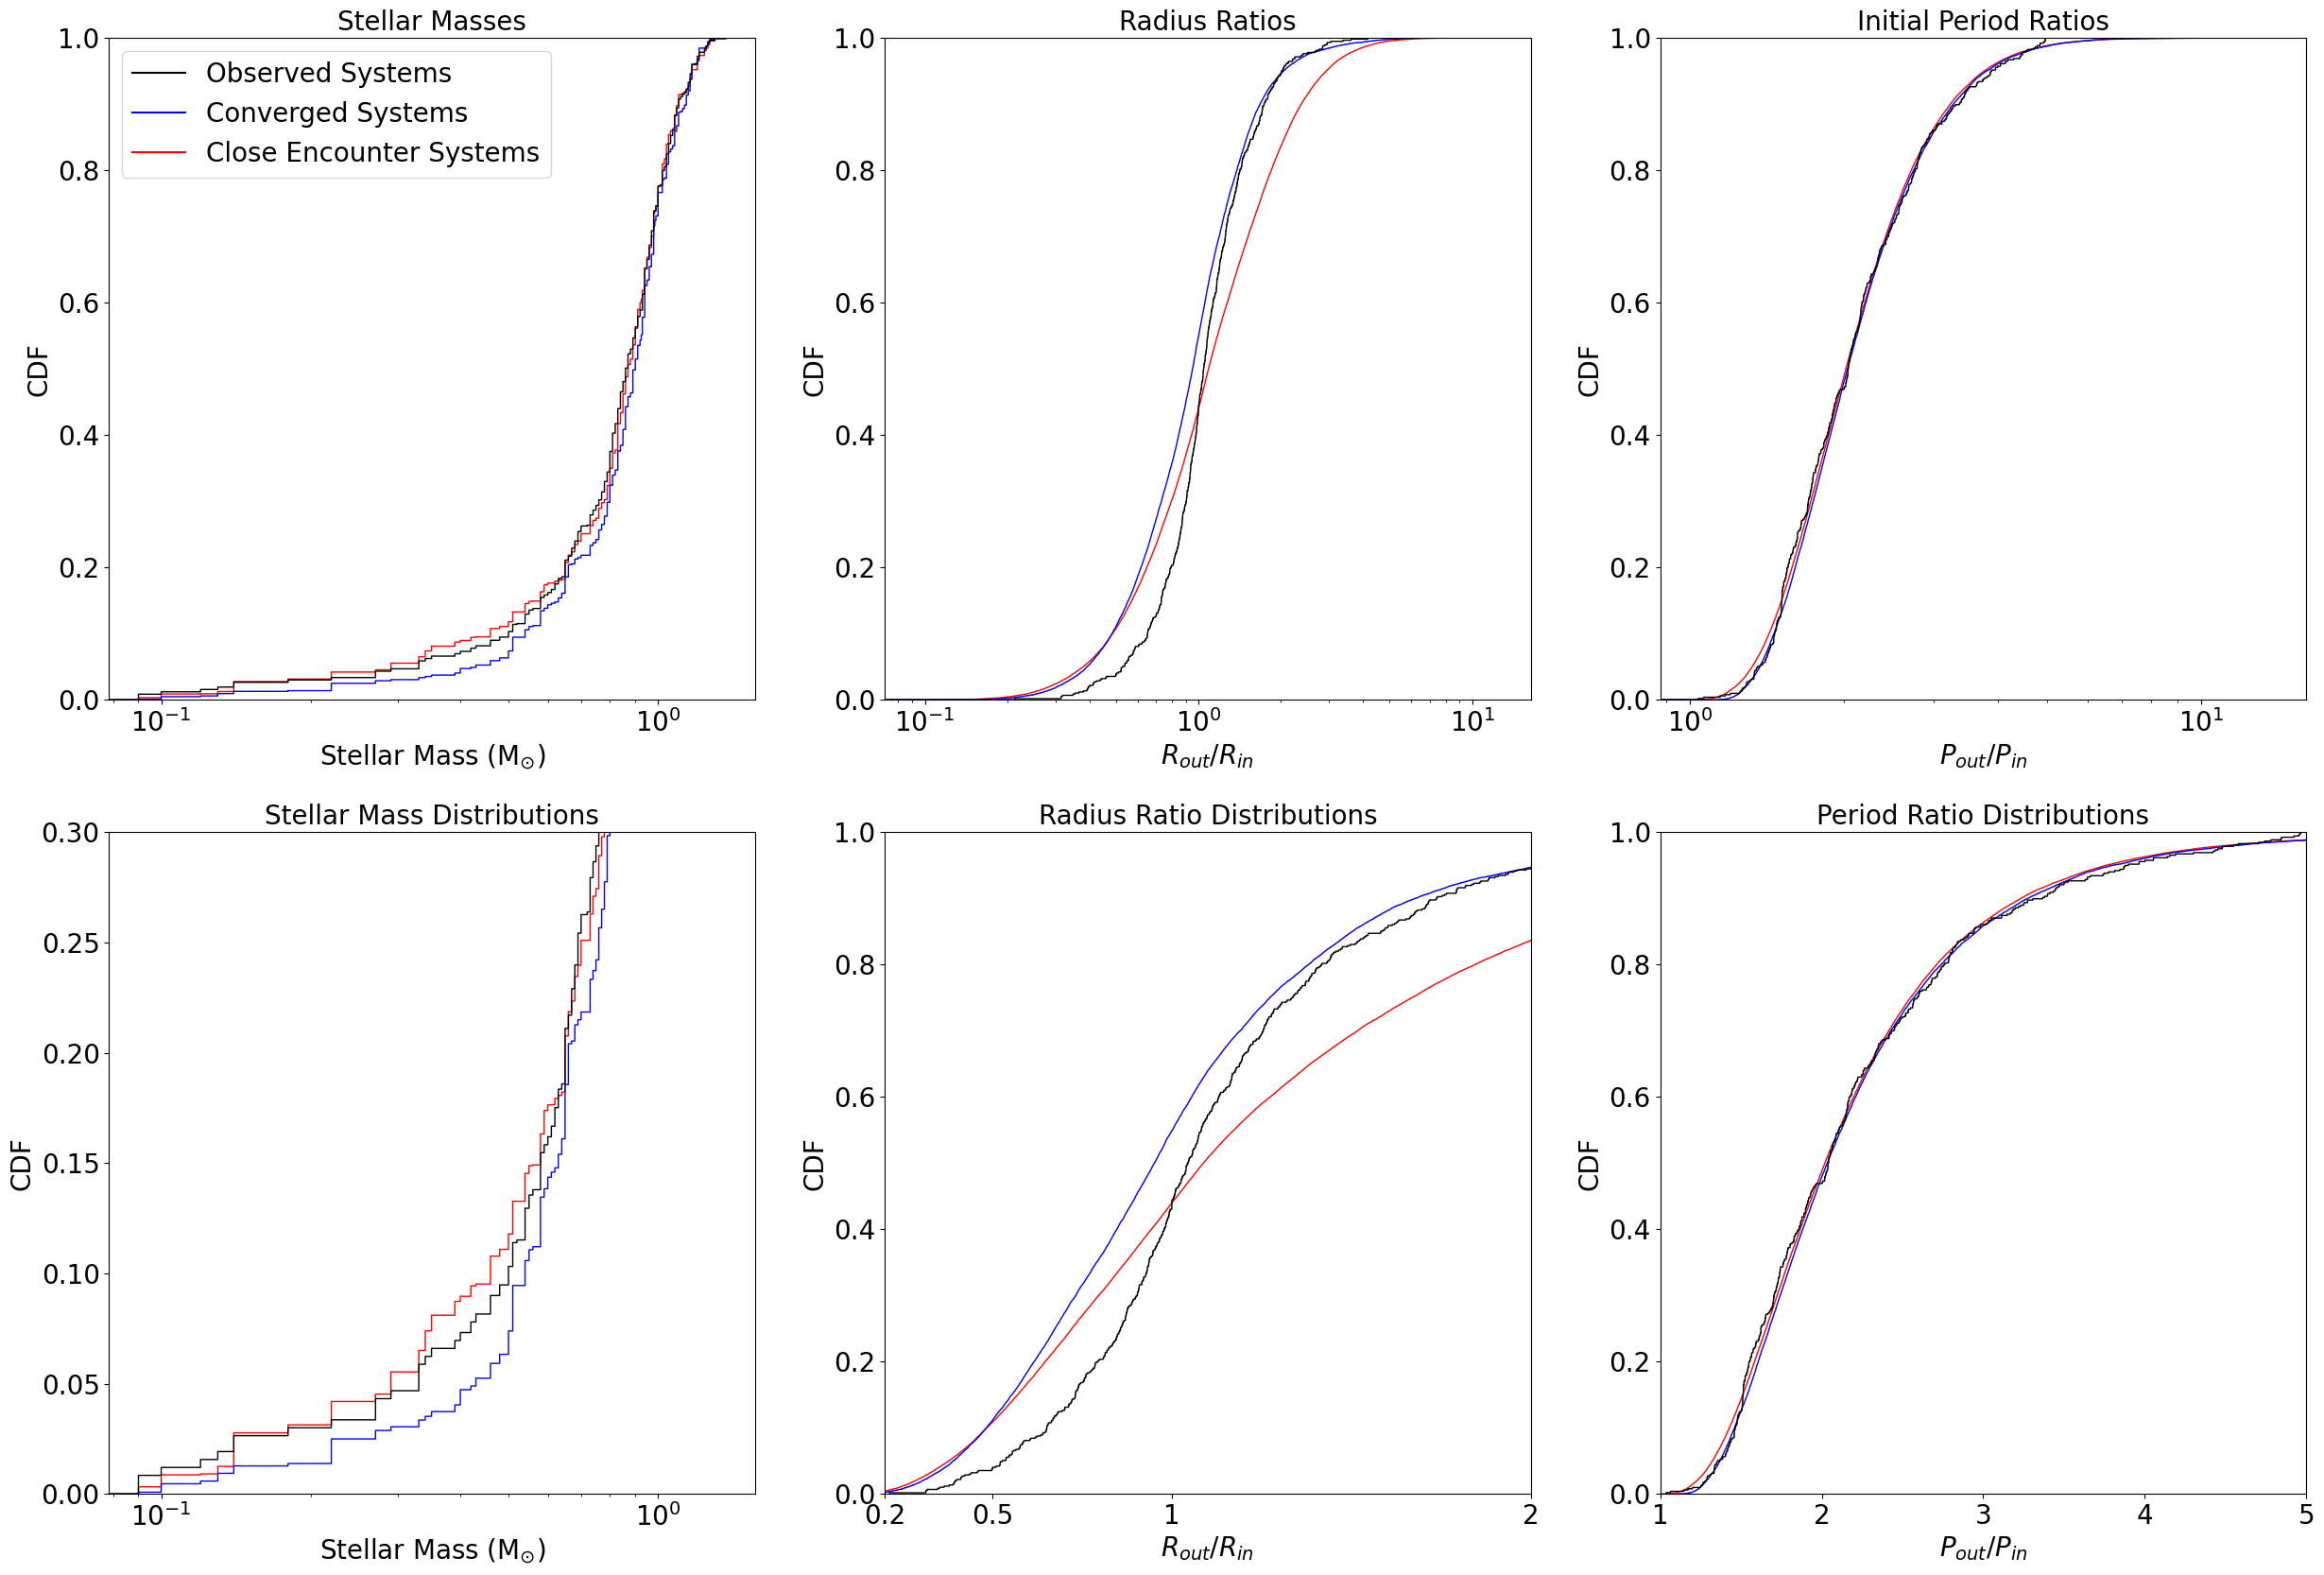

In [ ]:
# We'd like to get the distribution of stellar mass, radius ratios, period ratios, and planet number of our real systems as well as those that correspond to the simulations we ran in this process. For planet multiplicity, we use a PDF instead of a CDF.
# Unfortionately, we cannot get the output distribution of radius ratios due to the probabilistic nature of Forecaster but we can get the related mass ratios.
# We have two rows. First, the rows of the real systems, second the rows of the simulations (both not converged and converged) as they compare to the real systems. 

# Before we can plot the histograms, we need to compute the radius ratios of the planetary systems. We do this for our real data and the additional simulations. 

observed_radius_ratios = np.array([])
stars = np.unique(potential_systems["hostname"])
for system_idx in range(len(stars)):
    system = potential_systems[potential_systems["hostname"] == stars[system_idx]]
    radii = system["pl_rade"].to_numpy()
    planet_number = system["sy_pnum"].iloc[0]
    for planet_idx in range(planet_number-1):
        observed_radius_ratios = np.append(observed_radius_ratios, (radii[planet_idx+1]/radii[planet_idx]))
observed_radius_ratios = np.sort(observed_radius_ratios)

# We also need to get the initial period ratios from the Kepler dataset. There is nothing to compare this to in the first row. 
P_ratios = kepler["P/P-"].dropna()
P_ratios_under_5 = P_ratios[P_ratios<5]

# Finally, we need to get the planet multiplicities. As the radius dataset has one row for each planet, we have to reorganize it in an array that can be interpreted by histplot.  
planet_counts = {3: len(potential_systems[potential_systems["sy_pnum"]==3])/3, 4: len(potential_systems[potential_systems["sy_pnum"]==4])/4, 5: len(potential_systems[potential_systems["sy_pnum"]==5])/5, 6: len(potential_systems[potential_systems["sy_pnum"]==6])/6, 7: len(potential_systems[potential_systems["sy_pnum"]==7])/7}
planet_counts_array = np.array([])
for key in planet_counts.keys():
    for num in range(0, int(planet_counts[key])):
        planet_counts_array = np.append(planet_counts_array, key)
# Again, this code may not be needed as I am currently not employing the planet counts of the real and appended systems.
all_planet_counts = {3: len(all_potential_systems[all_potential_systems["sy_pnum"]==3])/3, 4: len(all_potential_systems[all_potential_systems["sy_pnum"]==4])/4, 5: len(all_potential_systems[all_potential_systems["sy_pnum"]==5])/5, 6: len(all_potential_systems[all_potential_systems["sy_pnum"]==6])/6, 7: len(all_potential_systems[all_potential_systems["sy_pnum"]==7])/7}
all_planet_counts_array = np.array([])
for key in all_planet_counts.keys():
    for num in range(0, int(all_planet_counts[key])):
        all_planet_counts_array = np.append(all_planet_counts_array, key)

# Let's get radius ratios.
sucessful_pl_masses = np.transpose(np.vstack([sucessful_sims["pl_mass_0"].to_numpy(), sucessful_sims["pl_mass_1"].to_numpy(), sucessful_sims["pl_mass_2"].to_numpy(), sucessful_sims["pl_mass_3"].to_numpy(), sucessful_sims["pl_mass_4"].to_numpy(), sucessful_sims["pl_mass_5"].to_numpy(), sucessful_sims["pl_mass_6"].to_numpy()]))
failed_pl_masses = np.transpose(np.vstack([failed_sims["pl_mass_0"].to_numpy(), failed_sims["pl_mass_1"].to_numpy(), failed_sims["pl_mass_2"].to_numpy(), failed_sims["pl_mass_3"].to_numpy(), failed_sims["pl_mass_4"].to_numpy(), failed_sims["pl_mass_5"].to_numpy(), failed_sims["pl_mass_6"].to_numpy()]))
# Let's convert mass to radius. To avoid the probabilistic nature of Chen and Kipping (2017), we can use their suggested power laws: 
# Keep in mind to do this we convert masses to Mearth and produce radii in Rearth. The units will end up not mattering as we care about ratios, but consistency is key.
sucessful_pl_radii = []
for sys_masses in sucessful_pl_masses:
    sys_masses = sys_masses*u.Msun.to(u.Mearth)
    sys_radii = np.array([])
    for pl_mass in sys_masses:
        # skip cases where we don't have a planet at the index.
        if np.isnan(pl_mass)==True:
            sys_radii = np.append(sys_radii, np.nan)
            continue
        # Terran (below 2 Mearth)=>R = M**(0.279)
        if pl_mass<(2*u.Mearth).value:
            pl_rade = pl_mass**(0.279)
            sys_radii = np.append(sys_radii, pl_rade)
        # Neptunian (2 Mearth to 130ish Mearth)=>R = M**(0.59)
        else: 
            pl_rade = pl_mass**(0.59)
            sys_radii = np.append(sys_radii, pl_rade)
        if pl_mass>0.41*u.Mjupiter.to(u.Mearth):
            print("A planet had mass "+str(pl_mass)+" Earth masses, which is greater than the Neptunian-Jovian transition. Reconsider this power law model.")
            break
    sucessful_pl_radii.append(sys_radii)
assert np.shape(sucessful_pl_masses) == np.shape(sucessful_pl_radii)
# Let's now make radius ratios from this data.
sucessful_radius_ratios = []
sucessful_pnums = sucessful_sims["pnum"].to_numpy()
for idx in range(len(sucessful_pnums)):
    sy_radius_ratios = np.array([])
    pnum = sucessful_pnums[idx]
    for p in range(pnum-1):
        sy_radius_ratios = np.append(sy_radius_ratios, sucessful_pl_radii[idx][p+1]/sucessful_pl_radii[idx][p])
    for p in range(6-(pnum-1)):
        sy_radius_ratios = np.append(sy_radius_ratios, np.nan)
    sucessful_radius_ratios.append(sy_radius_ratios)
sucessful_radius_ratios = np.array(sucessful_radius_ratios).ravel()

# Same for failed systems.
failed_pl_radii = []
for sys_masses in failed_pl_masses:
    sys_masses = sys_masses*u.Msun.to(u.Mearth)
    sys_radii = np.array([])
    for pl_mass in sys_masses:
        # skip cases where we don't have a planet at the index.
        if np.isnan(pl_mass)==True:
            sys_radii = np.append(sys_radii, np.nan)
            continue
        # Terran (below 2 Mearth)=>R = M**(0.279)
        if pl_mass<(2*u.Mearth).value:
            pl_rade = pl_mass**(0.279)
            sys_radii = np.append(sys_radii, pl_rade)
        # Neptunian (2 Mearth to 130ish Mearth)=>R = M**(0.59)
        else: 
            pl_rade = pl_mass**(0.59)
            sys_radii = np.append(sys_radii, pl_rade)
        if pl_mass>0.41*1.1*u.Mjupiter.to(u.Mearth): # expanding category as one planet fails this.
            print("A planet had mass "+str(pl_mass)+" Earth masses, which is greater than the Neptunian-Jovian transition. Reconsider this power law model.")
            break
    failed_pl_radii.append(sys_radii)
assert np.shape(failed_pl_masses) == np.shape(failed_pl_radii)
failed_radius_ratios = []
failed_pnums = failed_sims["pnum"].to_numpy()
for idx in range(len(failed_pnums)):
    sy_radius_ratios = np.array([])
    pnum = failed_pnums[idx]
    for p in range(pnum-1):
        sy_radius_ratios = np.append(sy_radius_ratios, failed_pl_radii[idx][p+1]/failed_pl_radii[idx][p])
    for p in range(6-(pnum-1)):
        sy_radius_ratios = np.append(sy_radius_ratios, np.nan)
    failed_radius_ratios.append(sy_radius_ratios)
failed_radius_ratios = np.array(failed_radius_ratios).ravel()

# And now, we need to get the initial period ratios from the initial semi-major axes for both the sucessful and failed sims. 
sucessful_initial_period_ratios = np.transpose(np.vstack([sucessful_sims["p_i_01"].to_numpy(), sucessful_sims["p_i_12"].to_numpy(), sucessful_sims["p_i_23"].to_numpy(), sucessful_sims["p_i_34"].to_numpy(), sucessful_sims["p_i_45"].to_numpy(), sucessful_sims["p_i_56"].to_numpy()])).ravel()
failed_initial_period_ratios = np.transpose(np.vstack([failed_sims["p_i_01"].to_numpy(), failed_sims["p_i_12"].to_numpy(), failed_sims["p_i_23"].to_numpy(), failed_sims["p_i_34"].to_numpy(), failed_sims["p_i_45"].to_numpy(), failed_sims["p_i_56"].to_numpy()])).ravel()

# Now, we can actually construct our plot.
fig, ax = plt.subplots(2, 3, figsize = (30., 20.))#, sharex = 'col')

# Note: I learned how to drop legends when calling hue from: https://www.geeksforgeeks.org/how-to-remove-legend-from-the-figure-in-seaborn/
df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': potential_systems["st_mass"], 'Dataset:': "Observed Systems"}),
    pd.DataFrame.from_dict({'value': sucessful_sims["st_mass"], 'Dataset:': 'Converged Systems'}),
    pd.DataFrame.from_dict({'value': failed_sims["st_mass"], 'Dataset:': 'Close Encounter Systems'})
])
sns.ecdfplot(df, log_scale = True, x = 'value', hue = 'Dataset:', ax = ax[0,0], palette = ['black', 'blue', 'red'], lw = 1, legend = False)
ax[0,0].set_xlabel("Stellar Mass (M$_{\odot}$)", fontsize = 20)
ax[0,0].set_ylabel("CDF", fontsize = 20)
ax[0,0].set_title("Stellar Masses", fontsize = 20)
ax[0,0].tick_params(axis='both', which='major', labelsize = 20)
ax[0,0].tick_params(axis='both', which='minor', labelsize = 20)
legend_elements = []
system_types = ['Observed Systems', 'Converged Systems', 'Close Encounter Systems']
colors = ['black', 'blue', 'red'] 
for idx in range(len(system_types)):
    legend_elements.append(Line2D([0], [0], color = colors[idx], label = system_types[idx]))
ax[0,0].legend(handles=legend_elements, fontsize = 20)

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': observed_radius_ratios, 'Dataset:':  "Observed Systems"}),
    pd.DataFrame.from_dict({'value': sucessful_radius_ratios, 'Dataset:': 'Converged Systems'}),
    pd.DataFrame.from_dict({'value': failed_radius_ratios, 'Dataset:': 'Close Encounter Systems'})
])
sns.ecdfplot(df, log_scale = True, x = 'value', hue = 'Dataset:', ax = ax[0,1], palette = ['black', 'blue', 'red'], lw = 1, legend = False)
ax[0,1].set_xlabel(r"$R_{out}/R_{in}$", fontsize = 20)
ax[0,1].set_ylabel("CDF", fontsize = 20)
ax[0,1].set_title("Radius Ratios", fontsize = 20)
ax[0,1].tick_params(axis='both', which='major', labelsize = 20)
ax[0,1].tick_params(axis='both', which='minor', labelsize = 20)


df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': P_ratios_under_5, 'Dataset:': 'Fabrycky et al. (2014)'}),
    pd.DataFrame.from_dict({'value': sucessful_initial_period_ratios, 'Dataset:': 'Converged Systems'}),
    pd.DataFrame.from_dict({'value': failed_initial_period_ratios, 'Dataset:': 'Close Encounter Systems'})
])
sns.ecdfplot(df, log_scale = True, x = 'value', hue = 'Dataset:', ax = ax[0,2], palette = ['black', 'blue', 'red'], lw = 1, legend = False)
ax[0,2].set_xlabel(r"$P_{out}/P_{in}$", fontsize = 20)
ax[0,2].set_ylabel("CDF", fontsize = 20)
ax[0,2].set_title("Initial Period Ratios", fontsize = 20)
ax[0,2].tick_params(axis='both', which='major', labelsize = 20)
ax[0,2].tick_params(axis='both', which='minor', labelsize = 20)

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': potential_systems["st_mass"], 'Dataset:': "Observed Systems"}),
    pd.DataFrame.from_dict({'value': sucessful_sims["st_mass"], 'Dataset:': 'Converged Systems'}),
    pd.DataFrame.from_dict({'value': failed_sims["st_mass"], 'Dataset:': 'Close Encounter Systems'})
])
sns.ecdfplot(df, log_scale = True, x = 'value', hue = 'Dataset:', ax = ax[1,0], palette = ['black', 'blue', 'red'], lw = 1, legend = False)
ax[1,0].set_ylim(0, 0.3)
ax[1,0].set_xlabel("Stellar Mass (M$_{\odot}$)", fontsize = 20)
ax[1,0].set_ylabel("CDF", fontsize = 20)
ax[1,0].set_title("Stellar Mass Distributions", fontsize = 20)
ax[1,0].tick_params(axis='both', which='major', labelsize = 20)
ax[1,0].tick_params(axis='both', which='minor', labelsize = 20)

df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': observed_radius_ratios, 'Dataset:':  "Observed Systems"}),
    pd.DataFrame.from_dict({'value': sucessful_radius_ratios, 'Dataset:': 'Converged Systems'}),
    pd.DataFrame.from_dict({'value': failed_radius_ratios, 'Dataset:': 'Close Encounter Systems'})
])
sns.ecdfplot(df,  x = 'value', hue = 'Dataset:', ax = ax[1,1], palette = ['black', 'blue', 'red'], lw = 1, legend = False)
ax[1,1].set_xticks([])
ax[1,1].set_xlim([0.2, 2], emit = False)
ax[1,1].set_xticks([0.2, 0.5, 1, 2], labels = ['0.2', '0.5', '1', '2'], fontsize = 20)
ax[1,1].set_xlabel(r"$R_{out}/R_{in}$", fontsize = 20)
ax[1,1].set_ylabel("CDF", fontsize = 20)
ax[1,1].set_title("Radius Ratio Distributions", fontsize = 20)
ax[1,1].tick_params(axis='both', which='major', labelsize = 20)
ax[1,1].tick_params(axis='both', which='minor', labelsize = 20)


df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': P_ratios_under_5, 'Dataset:': 'Fabrycky et al. (2014)'}),
    pd.DataFrame.from_dict({'value': sucessful_initial_period_ratios, 'Dataset:': 'Converged Systems'}),
    pd.DataFrame.from_dict({'value': failed_initial_period_ratios, 'Dataset:': 'Close Encounter Systems'})
])
sns.ecdfplot(df, x = 'value', hue = 'Dataset:', ax = ax[1,2], palette = ['black', 'blue', 'red'], lw = 1, legend = False)
ax[1,2].set_xlim(1, 5)
ax[1,2].set_xticks([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'], fontsize = 20)
ax[1,2].set_xlabel(r"$P_{out}/P_{in}$", fontsize = 20)
ax[1,2].set_ylabel("CDF", fontsize = 20)
ax[1,2].set_title("Period Ratio Distributions", fontsize = 20)
ax[1,2].tick_params(axis='both', which='major', labelsize = 20)
ax[1,2].tick_params(axis='both', which='minor', labelsize = 20)

fig.savefig('output_plots/Observed_&_Simulated_Distributions.png', bbox_inches = 'tight')
plt.show()

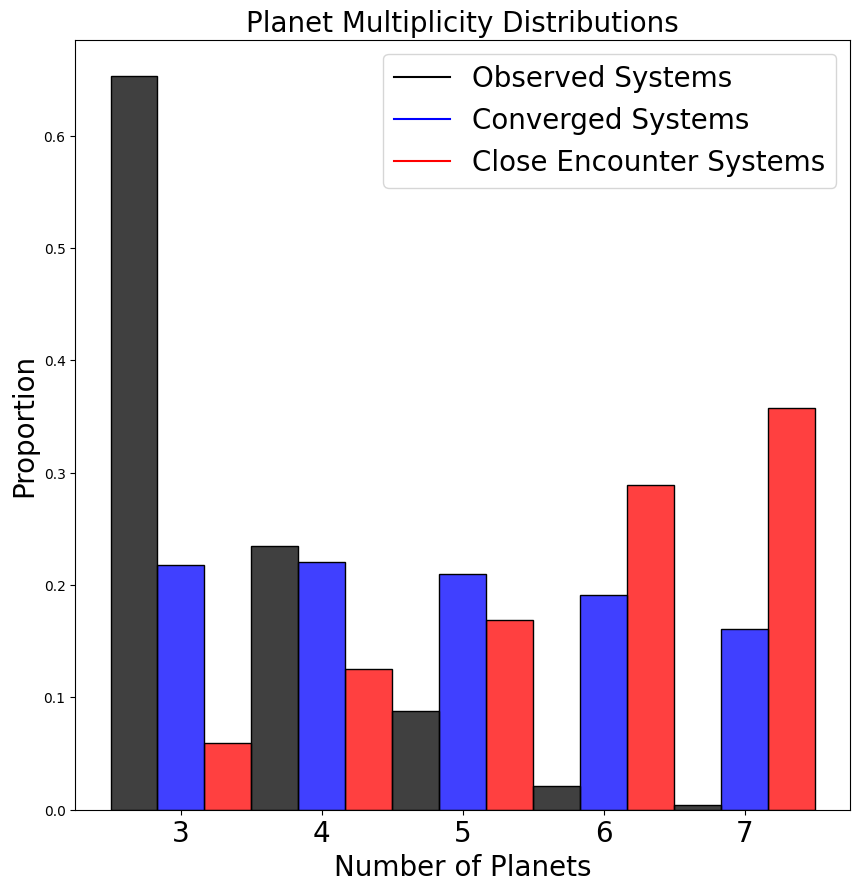

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': planet_counts_array, 'Dataset:': "Observed Systems"}),
    pd.DataFrame.from_dict({'value': sucessful_sims['pnum'], 'Dataset:': 'Converged Systems'}),
    pd.DataFrame.from_dict({'value': failed_sims['pnum'], 'Dataset:': 'Close Encounter Systems'})
])
sns.histplot(df, x = 'value', hue = 'Dataset:', ax = ax, discrete = True, stat = 'proportion', multiple = 'dodge', common_norm = False, palette = ['black', 'blue', 'red'], legend = False)
ax.set_xlabel("Number of Planets", fontsize = 20)
ax.set_ylabel("Proportion", fontsize = 20)
ax.set_title("Planet Multiplicity Distributions", fontsize = 20)
ax.set_xticks([3,4,5,6,7], ['3','4','5','6','7'], fontsize = 20)
legend_elements = []
system_types = ['Observed Systems', 'Converged Systems', 'Close Encounter Systems']
colors = ['black', 'blue', 'red'] 
for idx in range(len(system_types)):
    legend_elements.append(Line2D([0], [0], color = colors[idx], label = system_types[idx]))
ax.legend(handles=legend_elements, fontsize = 20)

fig.savefig('output_plots/planet_multiplicity.png')
plt.show()

In [ ]:
# This LaTeX table was not included in the paper but instead used to make Figure 3. 
# Let's make the version with combined failed sims and not converged ones into a LaTeX table.
# To avoid floating point errors, we should technically put the percentage multiplier inside the sig_fig function. I have only fixed this for situtations where floating point error has come up
sigfigs = 3
#print("Category & Count & Percentage Against Entirety of Category & Percentage Against Entire Sample\\"+"\\")
print("Category & Count & Percentage Against Successfully Integrated Systems ("+str(len(sucessful_sims))+") & Percentage Against Entire Sample ("+str(len(sucessful_sims)+len(failed_sims))+")"+"\\"+"\\")
print("\hline")
print("Sucessfully Integrated & "+str(len(sucessful_sims))+" & "+str(sig_figs(len(sucessful_sims)/(len(sucessful_sims)), sigfigs)*100)+"\% & "+str(sig_figs(len(sucessful_sims)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100)+"\%"+"\\"+"\\")
print("Close Encounter & "+str(len(failed_sims))+" & "+str(sig_figs(len(failed_sims)/(len(sucessful_sims)), sigfigs)*100)+"\% & "+str(sig_figs(len(failed_sims)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100)+"\%"+"\\"+"\\")
print("\hline")
print("Two Body Resonant Chains & "+str(len(resonant_chains_2))+" & "+str(sig_figs(len(resonant_chains_2)/(len(resonant_chains_2)+len(resonances_2)+len(no_resonances_2)), sigfigs)*100)+"\% & "+str(sig_figs(len(resonant_chains_2)/(len(sucessful_sims)+len(failed_sims))*100, sigfigs))+"\%"+"\\"+"\\")
print("Some Two Body Resonant Pairs & "+str(len(resonances_2))+" & "+str(sig_figs(len(resonances_2)/(len(resonant_chains_2)+len(resonances_2)+len(no_resonances_2)), sigfigs)*100)+"\% & "+str(sig_figs(len(resonances_2)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100)+"\%"+"\\"+"\\")
print("No Two Body Resonant Pairs & "+str(len(no_resonances_2))+" & "+str(sig_figs(len(no_resonances_2)/(len(resonant_chains_2)+len(resonances_2)+len(no_resonances_2)), sigfigs)*100)+"\% & "+str(sig_figs(len(no_resonances_2)/(len(sucessful_sims)+len(failed_sims))*100, sigfigs))+"\%"+"\\"+"\\")
print("\hline")
print("Three Body Resonant Chains & "+str(len(resonant_chains_3))+" & "+str(sig_figs(len(resonant_chains_3)/(len(resonant_chains_3)+len(resonances_3)+len(no_resonances_3))*100, sigfigs))+"\% & "+str(sig_figs(len(resonant_chains_3)/(len(sucessful_sims)+len(failed_sims))*100, sigfigs))+"\%"+"\\"+"\\")
print("Some Three Body Resonant Triplets & "+str(len(resonances_3))+" & "+str(sig_figs(len(resonances_3)/(len(resonant_chains_3)+len(resonances_3)+len(no_resonances_3))*100, sigfigs))+"\% & "+str(sig_figs(len(resonances_3)/(len(sucessful_sims)+len(failed_sims))*100, sigfigs))+"\%"+"\\"+"\\")
print("No Three Body Resonant Triplets & "+str(len(no_resonances_3))+" & "+str(sig_figs(len(no_resonances_3)/(len(resonant_chains_3)+len(resonances_3)+len(no_resonances_3)), sigfigs)*100)+"\% & "+str(sig_figs(len(no_resonances_3)/(len(sucessful_sims)+len(failed_sims)), sigfigs)*100)+"\%"+"\\"+"\\")

Category & Count & Percentage Against Successfully Integrated Systems (6542) & Percentage Against Entire Sample (22751)\\
\hline
Sucessfully Integrated & 6542 & 100.0\% & 28.799999999999997\%\\
Close Encounter & 16209 & 248.0\% & 71.2\%\\
\hline
Two Body Resonant Chains & 5526 & 84.5\% & 24.3\%\\
Some Two Body Resonant Pairs & 1002 & 15.299999999999999\% & 4.3999999999999995\%\\
No Two Body Resonant Pairs & 14 & 0.214\% & 0.0615\%\\
\hline
Three Body Resonant Chains & 3492 & 53.4\% & 15.3\%\\
Some Three Body Resonant Triplets & 2741 & 41.9\% & 12.0\%\\
No Three Body Resonant Triplets & 309 & 4.72\% & 1.3599999999999999\%\\


System has small mass. For plotting, we will choose a different system.
System has small mass. For plotting, we will choose a different system.
System has small mass. For plotting, we will choose a different system.
System has small mass. For plotting, we will choose a different system.


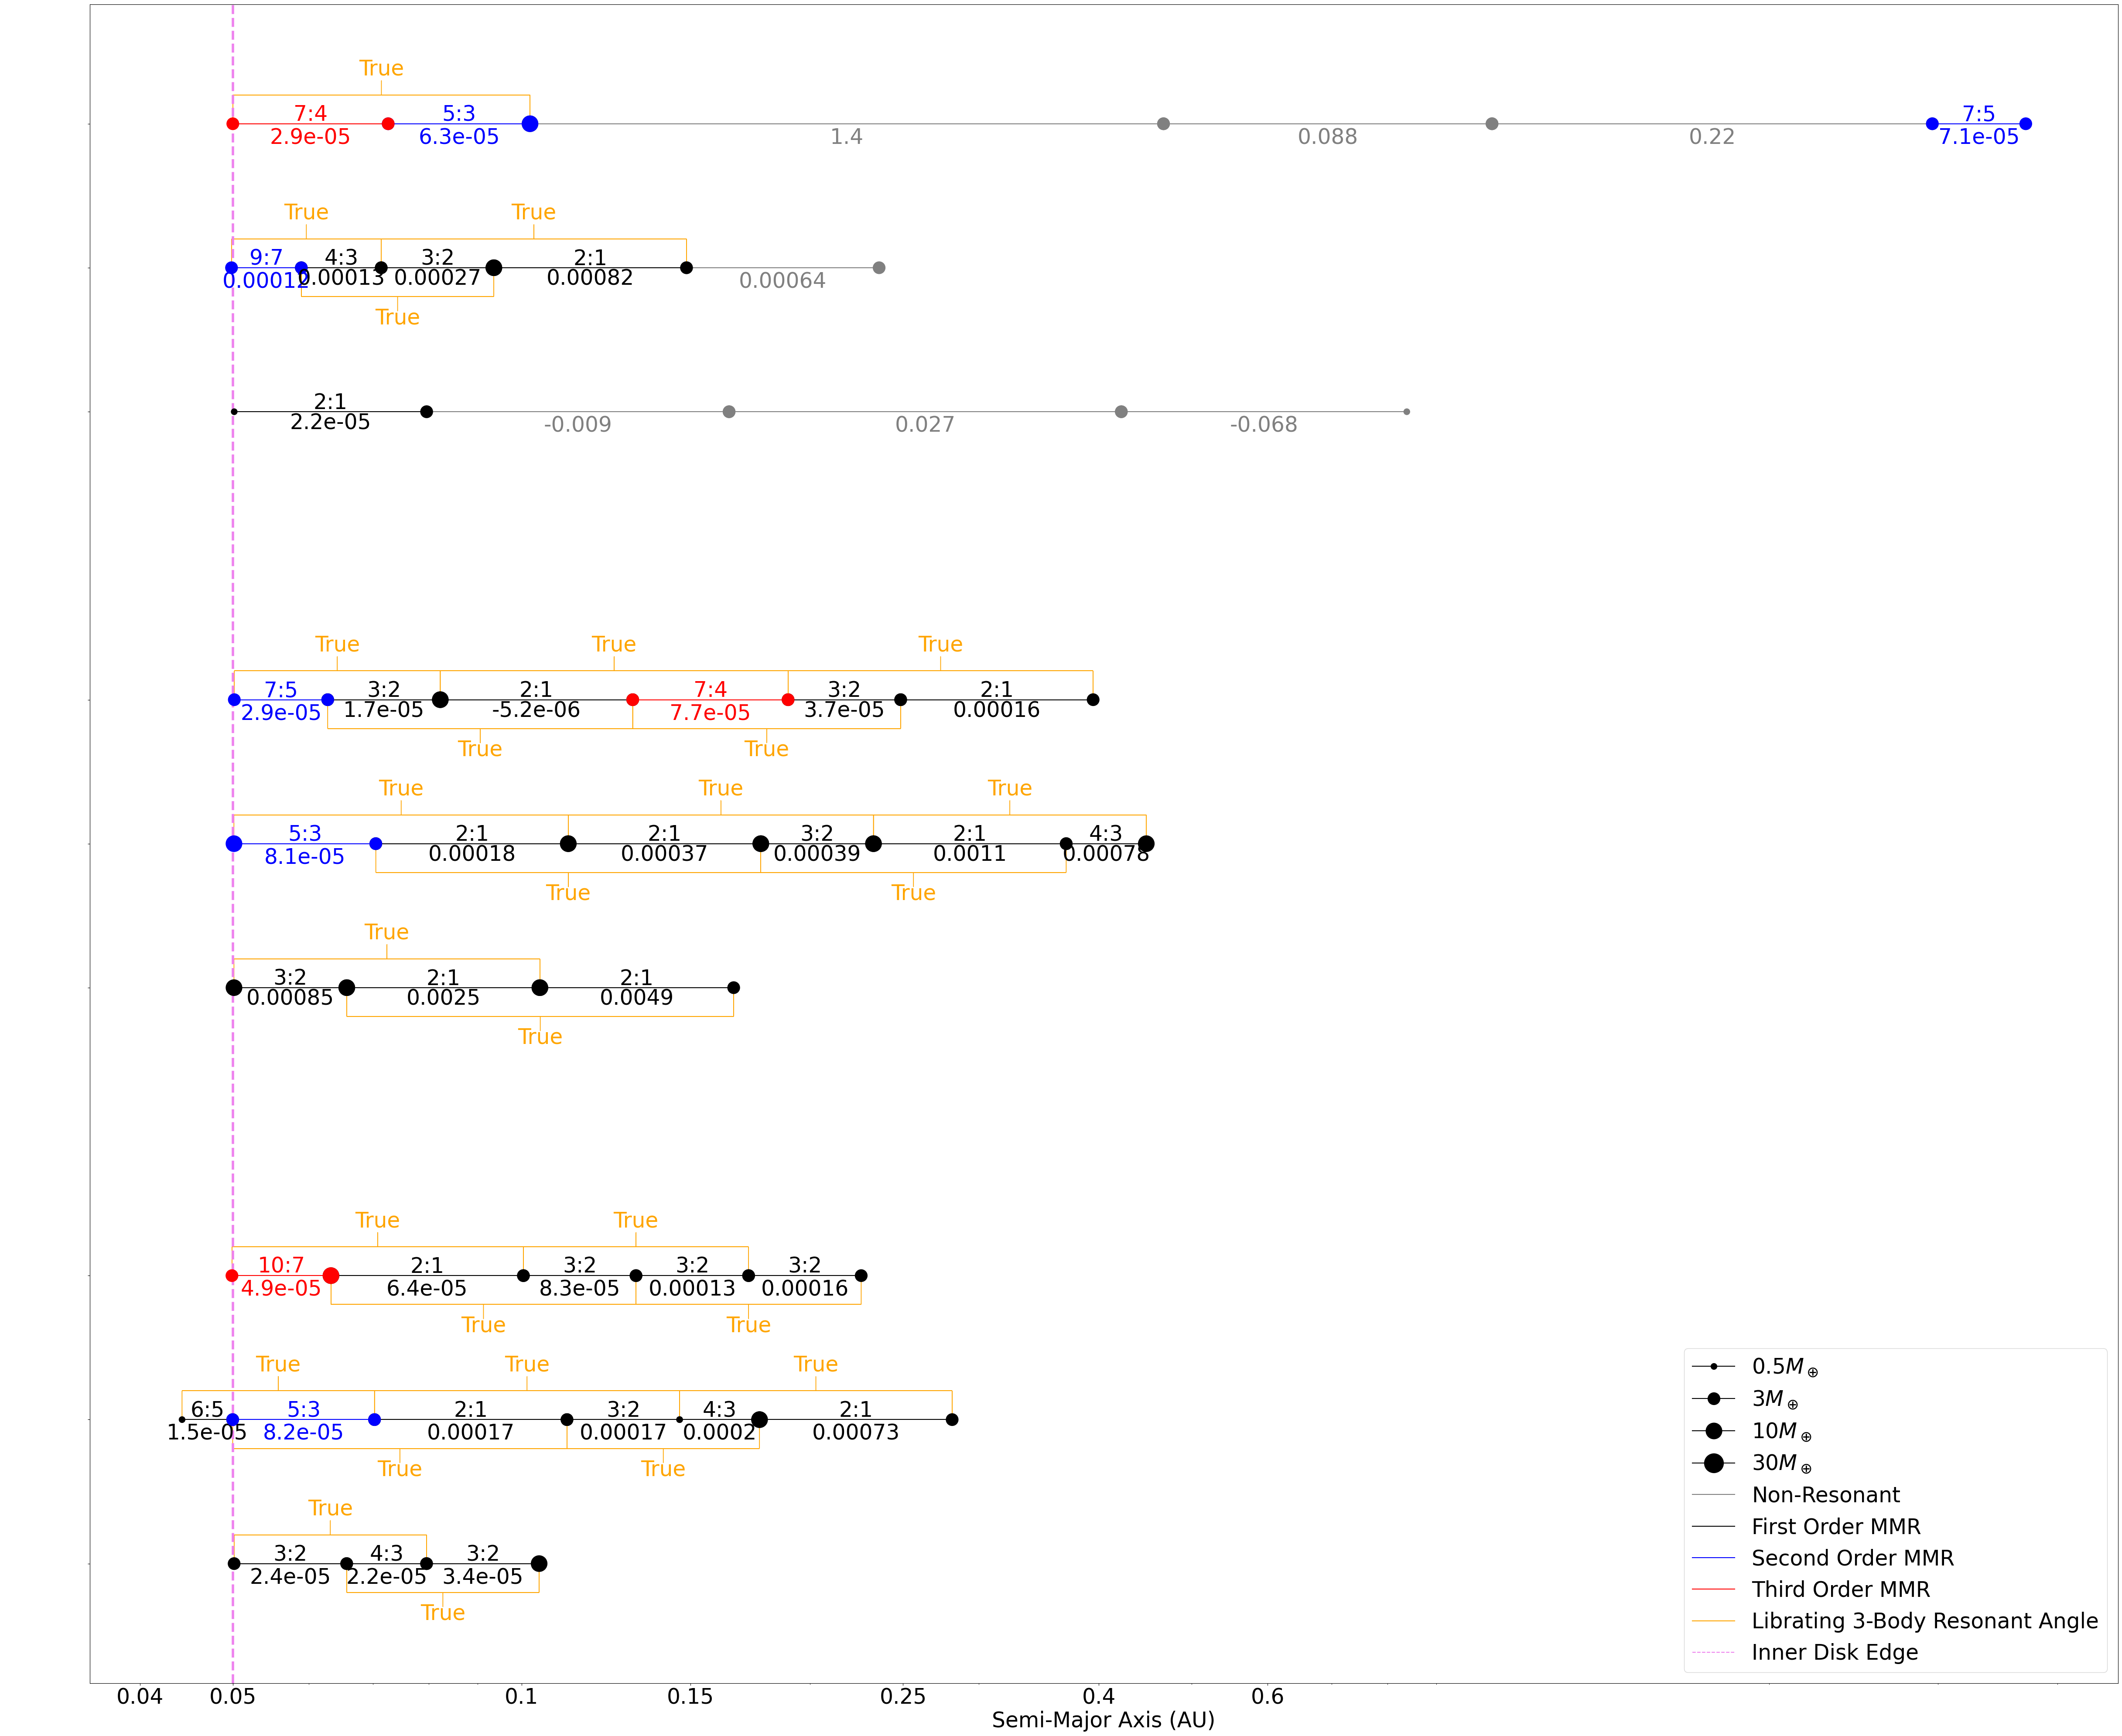

In [ ]:
first_order_parital_interrupted_resonances_2 = pd.concat([first_order_interrupted_resonances_2, first_order_partial_resonances_2])
second_order_parital_interrupted_resonances_2 = pd.concat([second_order_interrupted_resonances_2, second_order_partial_resonances_2])
third_order_parital_interrupted_resonances_2 = pd.concat([third_order_interrupted_resonances_2, third_order_partial_resonances_2])
all_datasets = [first_order_resonant_chains_3, second_order_resonant_chains_3, third_order_resonant_chains_3, 
                first_order_resonant_chains_2, second_order_resonant_chains_2, third_order_resonant_chains_2,
                first_order_parital_interrupted_resonances_2, second_order_parital_interrupted_resonances_2, third_order_parital_interrupted_resonances_2]
dataset_labels = ['3', 'disk_penetration_example', 'third_order_example', '2', 'second_order_example', '2', '2', '2', '2']
dataset_labels = ['3', 'disk_penetration_example', 'third_order_example', '2', 'second_order_example', '2', '2', '2', '2']
spacing = 10
yticks = np.array([0, 10, 20, 40, 50, 60, 80, 90, 100])
#yticks = np.arange(0, len(dataset_labels))*spacing
yticklabels = ['            ', '            ', '            ', '            ', '            ', '            ', '            ', '            ', '            ']
assert len(all_datasets) == len(dataset_labels ) == len(yticks) == len(yticklabels)
# Let's specify the sizes corresponding to some masses. 
markersize = np.linspace(100, 1000, 4) # five different bins
# Let's get 5 masses over the range of the mass dataset (approx 0.1-30Mearth).
marker_masses = [0.5, 3, 10, 30] # Mearth
size_dict = {marker_masses[i]:markersize[i] for i in range(len(markersize))}

sigfigs = 2
fig, ax = plt.subplots(figsize = (60, 50))

for idx, dataset in enumerate(all_datasets):
    # extract important parameters from the dataset
    dataset_periods = pd.DataFrame(np.transpose(np.vstack([dataset["p_0"].to_numpy(), dataset["p_1"].to_numpy(), dataset["p_2"].to_numpy(), dataset["p_3"].to_numpy(), dataset["p_4"].to_numpy(), dataset["p_5"].to_numpy(), dataset["p_6"].to_numpy()])), columns = ["p_0", "p_1", "p_2", "p_3", "p_4", "p_5", "p_6"])
    dataset_semi_majors = pd.DataFrame(np.transpose(np.vstack([dataset["a_0"].to_numpy(), dataset["a_1"].to_numpy(), dataset["a_2"].to_numpy(), dataset["a_3"].to_numpy(), dataset["a_4"].to_numpy(), dataset["a_5"].to_numpy(), dataset["a_6"].to_numpy()])), columns = ["a_0", "a_1", "a_2", "a_3", "a_4", "a_5", "a_6"])
    dataset_masses = pd.DataFrame(np.transpose(np.vstack([dataset["pl_mass_0"].to_numpy(), dataset["pl_mass_1"].to_numpy(), dataset["pl_mass_2"].to_numpy(), dataset["pl_mass_3"].to_numpy(), dataset["pl_mass_4"].to_numpy(), dataset["pl_mass_5"].to_numpy(), dataset["pl_mass_6"].to_numpy()])), columns = ["pl_mass_0", "pl_mass_1", "pl_mass_2", "pl_mass_3", "pl_mass_4", "pl_mass_5", "pl_mass_6"])
    dataset_prox_res = pd.DataFrame(np.transpose(np.vstack([dataset["prox_res_01"].to_numpy(), dataset["prox_res_12"].to_numpy(), dataset["prox_res_23"].to_numpy(), dataset["prox_res_34"].to_numpy(), dataset["prox_res_45"].to_numpy(), dataset["prox_res_56"].to_numpy()])), columns = ["prox_res_01", "prox_res_12", "prox_res_23", "prox_res_34", "prox_res_45", "prox_res_56"])
    # Let's use our updated Delta. Old is just the commented line below.
    dataset_deltas = pd.DataFrame(np.transpose(np.vstack([dataset["delta_01"].to_numpy(), dataset["delta_12"].to_numpy(), dataset["delta_23"].to_numpy(), dataset["delta_34"].to_numpy(), dataset["delta_45"].to_numpy(), dataset["delta_56"].to_numpy()])), columns = ["delta_01", "delta_12", "delta_23", "delta_34", "delta_45", "delta_56"])
    #dataset_deltas = pd.DataFrame(np.transpose(np.vstack([dataset["delta_wu_01"].to_numpy(), dataset["delta_wu_12"].to_numpy(), dataset["delta_wu_23"].to_numpy(), dataset["delta_wu_34"].to_numpy(), dataset["delta_wu_45"].to_numpy(), dataset["delta_wu_56"].to_numpy()])), columns = ["delta_wu_01", "delta_wu_12", "delta_wu_23", "delta_wu_34", "delta_wu_45", "delta_wu_56"])
    
    if dataset_labels[idx] == 'second_order_example':
        sys_idx = 160
        prox_res = dataset_prox_res.iloc[sys_idx][0:pnum-1]
    elif dataset_labels[idx] == 'disk_penetration_example':
        sys_idx = 2
    elif dataset_labels[idx] == 'third_order_example':
        sys_idx = 46
    else:
        # get a random index from the dataset
        sys_idx = np.random.randint(0, len(dataset))
        masses = dataset_masses.iloc[sys_idx][0:pnum]
        while (masses*u.Msun.to(u.Mearth)<0.5).any() == True:
            print("System has small mass. For plotting, we will choose a different system.")
            sys_idx = np.random.randint(0, len(dataset))
            masses = dataset_masses.iloc[sys_idx][0:pnum]
    # match that index to a given system
    pnum = dataset['pnum'].iloc[sys_idx]
    periods = dataset_periods.iloc[sys_idx][0:pnum]*u.yr.to(u.day)
    semi_majors = dataset_semi_majors.iloc[sys_idx][0:pnum]
    masses = dataset_masses.iloc[sys_idx][0:pnum]
    prox_res = dataset_prox_res.iloc[sys_idx][0:pnum-1]
    deltas = dataset_deltas.iloc[sys_idx][0:pnum-1]
    

    # Let's now match the masses to appropriate size bins
    markers_in_system = []
    for j in range(len(masses)):
        mass = masses[j]*u.Msun.to(u.Mearth)
        closest_mass_bin_idx = np.argmin(np.abs(mass-marker_masses)) # replace with bins if want to use the method based on the total mass distribution.
        closest_mass_bin = marker_masses[closest_mass_bin_idx] # again replace marker_masses with bins if want to use the method based on the total mass distribution.
        markers_in_system.append(size_dict[closest_mass_bin])
    
    # Let's get the plot.
    if dataset_labels[idx] == 'failed': # Note: some failed systems have no recorded periods. This is the population that failed immediately (I think). Just rerun the cell.
        for j in range(pnum-1):
            ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 1, c = 'grey')
            ax.scatter([semi_majors[j],semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 2, c = 'grey', s = [markers_in_system[j],markers_in_system[j+1]])
            ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.8, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'grey', fontsize = 35)
    elif dataset_labels[idx] == '2' or dataset_labels[idx] == 'second_order_example':
        dataset_lib_amps = pd.DataFrame(np.transpose(np.vstack([dataset["phi_amp_2_01"].to_numpy(), dataset["phi_amp_2_12"].to_numpy(), dataset["phi_amp_2_23"].to_numpy(), dataset["phi_amp_2_34"].to_numpy(), dataset["phi_amp_2_45"].to_numpy(), dataset["phi_amp_2_56"].to_numpy()])), columns = ["phi_amp_2_01", "phi_amp_2_12", "phi_amp_2_23", "phi_amp_2_34", "phi_amp_2_45", "phi_amp_2_56"])
        lib_amps = dataset_lib_amps.iloc[sys_idx][0:pnum-1]
        three_body_dataset_lib_amps = pd.DataFrame(np.transpose(np.vstack([dataset["phi_amp_3_012"].to_numpy(), dataset["phi_amp_3_123"].to_numpy(), dataset["phi_amp_3_234"].to_numpy(), dataset["phi_amp_3_345"].to_numpy(), dataset["phi_amp_3_456"].to_numpy()])), columns = ["phi_amp_3_012", "phi_amp_3_123", "phi_amp_3_234", "phi_amp_3_345", "phi_amp_3_456"])
        three_body_lib_amps = three_body_dataset_lib_amps.iloc[sys_idx][0:pnum-2]
        for j in range(pnum-1):
            if lib_amps[j]<90:
                local_resonance = fractions.Fraction(prox_res[j]).limit_denominator(10000)
                if np.isin(local_resonance, fractional_first_order_resonances_unique)==True:
                    ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 3, c = 'black')
                    ax.scatter([semi_majors[j],semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 4, c = 'black', s = [markers_in_system[j],markers_in_system[j+1]])
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]+0.2,  str(local_resonance.numerator)+":"+str(local_resonance.denominator), horizontalalignment = 'center', zorder = 6, c = 'black', fontsize = 35)
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.2, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'black', fontsize = 35)
                elif np.isin(local_resonance, fractional_second_order_resonances_unique)==True:
                    ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 5, c = 'blue')
                    ax.scatter([semi_majors[j],semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 6, c = 'blue', s = [markers_in_system[j],markers_in_system[j+1]])
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]+0.2, str(local_resonance.numerator)+":"+str(local_resonance.denominator), horizontalalignment = 'center', zorder = 6, c = 'blue', fontsize = 35)
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.4, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'blue', fontsize = 35)
                elif np.isin(local_resonance, fractional_third_order_resonances_unique)==True:
                    ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 6, c = 'red')
                    ax.scatter([semi_majors[j],semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 7, c = 'red', s = [markers_in_system[j],markers_in_system[j+1]])
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]+0.2,  str(local_resonance.numerator)+":"+str(local_resonance.denominator), horizontalalignment = 'center', zorder = 6, c = 'red', fontsize = 35)
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.4, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'red', fontsize = 35)
                else:
                    print("Particular "+str(local_resonance)+" MMR is not included in the sets of three body resonances. Perhaps this planet pair is not resonant?") 
            else:
                ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 1, c = 'grey')
                ax.scatter([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 2, c = 'grey', s = [markers_in_system[j],markers_in_system[j+1]])
                ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.4, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'grey', fontsize = 35)
        for j in range(pnum-2):
            if j%2 == 0:
                up = 1
                up2 = 1.125
            else:
                up = -1
                up2 = 1.3
            if three_body_lib_amps[j]<90:
                ax.hlines(yticks[idx]+2*up, xmin = semi_majors[j], xmax = semi_majors[j+2], color = 'orange', zorder = 1)
                ax.arrow(semi_majors[j], yticks[idx]+2*up, 0, (-2)*up, width = 0.00001, color = 'orange', zorder = 1)
                ax.arrow(semi_majors[j+2], yticks[idx]+2*up, 0, (-2)*up, width = 0.00001, color = 'orange', zorder = 1)
                ax.arrow(np.sqrt(semi_majors[j]*semi_majors[j+2]), yticks[idx]+2*up, 0, 1*up, width = 0.00001, color = 'orange', zorder = 1)
                ax.text(np.sqrt(semi_majors[j]*semi_majors[j+2]), yticks[idx]+3*up*up2,  'True',  horizontalalignment = 'center', c = 'orange', fontsize = 35)

    elif dataset_labels[idx] == '3' or dataset_labels[idx] == 'disk_penetration_example' or dataset_labels[idx] == 'third_order_example':
        dataset_lib_amps = pd.DataFrame(np.transpose(np.vstack([dataset["phi_amp_2_01"].to_numpy(), dataset["phi_amp_2_12"].to_numpy(), dataset["phi_amp_2_23"].to_numpy(), dataset["phi_amp_2_34"].to_numpy(), dataset["phi_amp_2_45"].to_numpy(), dataset["phi_amp_2_56"].to_numpy()])), columns = ["phi_amp_2_01", "phi_amp_2_12", "phi_amp_2_23", "phi_amp_2_34", "phi_amp_2_45", "phi_amp_2_56"])
        lib_amps = dataset_lib_amps.iloc[sys_idx][0:pnum-1]
        three_body_dataset_lib_amps = pd.DataFrame(np.transpose(np.vstack([dataset["phi_amp_3_012"].to_numpy(), dataset["phi_amp_3_123"].to_numpy(), dataset["phi_amp_3_234"].to_numpy(), dataset["phi_amp_3_345"].to_numpy(), dataset["phi_amp_3_456"].to_numpy()])), columns = ["phi_amp_3_012", "phi_amp_3_123", "phi_amp_3_234", "phi_amp_3_345", "phi_amp_3_456"])
        three_body_lib_amps = three_body_dataset_lib_amps.iloc[sys_idx][0:pnum-2]
        for j in range(pnum-1):
            if lib_amps[j]<90:
                local_resonance = fractions.Fraction(prox_res[j]).limit_denominator(10000)
                if np.isin(local_resonance, fractional_first_order_resonances_unique)==True:
                    ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 3, c = 'black')
                    ax.scatter([semi_majors[j],semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 4, c = 'black', s = [markers_in_system[j],markers_in_system[j+1]])
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]+0.2,  str(local_resonance.numerator)+":"+str(local_resonance.denominator), horizontalalignment = 'center', zorder = 6, c = 'black', fontsize = 35)
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.4, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'black', fontsize = 35)
                elif np.isin(local_resonance, fractional_second_order_resonances_unique)==True:
                    ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 5, c = 'blue')
                    ax.scatter([semi_majors[j],semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 6, c = 'blue', s = [markers_in_system[j],markers_in_system[j+1]])
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]+0.2, str(local_resonance.numerator)+":"+str(local_resonance.denominator), horizontalalignment = 'center', zorder = 6, c = 'blue', fontsize = 35)
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.4, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'blue', fontsize = 35)
                elif np.isin(local_resonance, fractional_third_order_resonances_unique)==True:
                    ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 7, c = 'red')
                    ax.scatter([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 8, c = 'red', s = [markers_in_system[j],markers_in_system[j+1]])
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]+0.2,  str(local_resonance.numerator)+":"+str(local_resonance.denominator), horizontalalignment = 'center', zorder = 6, c = 'red', fontsize = 35)
                    ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.4, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'red', fontsize = 35)
                else:
                    print("Particular "+str(local_resonance)+" MMR is not included in the sets of three body resonances. Perhaps this planet pair is not resonant?")
            else:
                ax.plot([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 1, c = 'grey')
                ax.scatter([semi_majors[j], semi_majors[j+1]], [yticks[idx], yticks[idx]], zorder = 2, c = 'grey', s = [markers_in_system[j],markers_in_system[j+1]])
                ax.text(np.sqrt([semi_majors[j]*semi_majors[j+1]]), yticks[idx]-1.2, str(sig_figs(deltas[j], sigfigs)),  horizontalalignment = 'center', zorder = 6, c = 'grey', fontsize = 35)
        for j in range(pnum-2):
            if j%2 == 0:
                up = 1
                up2 = 1.125
            else:
                up = -1
                up2 = 1.3
            if three_body_lib_amps[j]<90:
                ax.hlines(yticks[idx]+2*up, xmin = semi_majors[j], xmax = semi_majors[j+2], color = 'orange', zorder = 1)
                ax.arrow(semi_majors[j], yticks[idx]+2*up, 0, (-2)*up, width = 0.00001, color = 'orange', zorder = 1)
                ax.arrow(semi_majors[j+2], spacing*idx+2*up, 0, (-2)*up, width = 0.00001, color = 'orange', zorder = 1)
                ax.arrow(np.sqrt(semi_majors[j]*semi_majors[j+2]), yticks[idx]+2*up, 0, 1*up, width = 0.00001, color = 'orange', zorder = 1)
                ax.text(np.sqrt(semi_majors[j]*semi_majors[j+2]), yticks[idx]+3*up*up2,  'True',  horizontalalignment = 'center', c = 'orange', fontsize = 35)
# Let's add in a legend with mass scales and resonant indicators.
# Now, following https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html, let's make a set of custom labels for our legend. 
legend_elements = []
for idx in range(len(markersize)): 
    custom_marker =  Line2D([0], [0], color = 'black', marker = 'o', markersize = np.sqrt(markersize[idx]), label = str(marker_masses[idx])+r"$M_\oplus$") # Note: the size of markerisze for plot is the square root of that of size for scatter: https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size. Change to marker_masses to sig_fig_bins_in_mearth if we use the other binning method.
    legend_elements.append(custom_marker)
resonances_orders = ['Non-Resonant', 'First Order MMR', 'Second Order MMR', 'Third Order MMR']
colors = ['grey', 'black', 'blue', 'red']
for idx in range(len(resonances_orders)):
    legend_elements.append(Line2D([0], [0], color = colors[idx], label = resonances_orders[idx]))
legend_elements.append(Line2D([0], [0], color = 'orange', label = 'Librating 3-Body Resonant Angle'))

ax.axvline(0.05, ls = '--', lw = 4, c = 'violet')
legend_elements.append(Line2D([0], [0], color = 'violet', label = 'Inner Disk Edge', ls = '--'))

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontsize = 35)
ax.set_xscale('log')
ax.set_xticks([0.04, 0.05, 0.1, 0.15, 0.25, 0.4, 0.6])
ax.set_xticklabels(['0.04', '0.05', '0.1', '0.15', '0.25', '0.4', '0.6'])
ax.set_xlabel('Semi-Major Axis (AU)', fontsize = 35)
ax.legend(handles=legend_elements, fontsize = 35)
ax.tick_params(axis='both', which='major', labelsize = 35)
ax.tick_params(axis='both', which='minor', labelsize = 35)

fig.savefig('output_plots/Example_Systems.png', bbox_inches = 'tight')

plt.show()

# Section 3: An Example of Second Order Resonance
* Included in this section is code for how we found our selected second order system example. This work was a little tricky, namely because we did not save all of our outputs to high enough precision to make reintegrating straightforward. I am happy to provide more information on this process if you are curious.
* We also show Figure 5 and Table 1, which are the plot of system evolution and system parameters for the second order example. 

In [ ]:
# Code for how we identified second order systems by name. Again, recall plot_finder() does not produce unique results. Some system names correspond to multiple simulations :(
for idx in range(len(second_order_resonant_chains_2)):
    K_outermost = second_order_resonant_chains_2.iloc[idx]['K_outermost']
    taua = second_order_resonant_chains_2.iloc[idx]['taua']
    try: 
        try: 
            index = int(second_order_resonant_chains_2.iloc[idx]['index'][0]) # other indexes come from way I set up the arrays
        except IndexError:
            index = int(second_order_resonant_chains_2.iloc[idx]['index'])
        print(plot_finder(index, K_outermost, taua))
        if plot_finder(index, K_outermost, taua) == "0_inner_edge_1.1e+02_taua_1.3e+06_": 
            second_order_system_to_rerun = second_order_resonant_chains_2.iloc[idx]
            print("Relevant position: "+str(idx))
    except ValueError:
        break

4_inner_edge_1.1e+02_taua_2.7e+06_
2_inner_edge_1.4e+01_taua_2.2e+05_
6_inner_edge_5.0e+01_taua_1.6e+06_
12_inner_edge_2.6e+01_taua_9.0e+06_
0_inner_edge_1.6e+02_taua_3.9e+05_
1_inner_edge_1.2e+01_taua_6.4e+05_
2_inner_edge_6.8e+01_taua_3.0e+05_
4_inner_edge_4.8e+01_taua_6.0e+05_
7_inner_edge_5.8e+02_taua_2.0e+05_
3_inner_edge_2.1e+01_taua_9.5e+06_
3_inner_edge_2.0e+01_taua_5.4e+05_
4_inner_edge_6.6e+02_taua_1.1e+05_
3_inner_edge_3.1e+01_taua_9.3e+06_
1_inner_edge_2.5e+01_taua_2.0e+05_
4_inner_edge_1.2e+01_taua_1.0e+05_
25_inner_edge_2.2e+02_taua_1.5e+06_
35_inner_edge_9.9e+02_taua_3.6e+06_
43_inner_edge_2.0e+02_taua_1.4e+05_
0_inner_edge_1.9e+01_taua_4.8e+06_
4_inner_edge_4.6e+01_taua_8.8e+04_
8_inner_edge_1.1e+02_taua_1.2e+06_
11_inner_edge_1.4e+01_taua_4.8e+05_
36_inner_edge_1.4e+02_taua_1.5e+05_
12_inner_edge_1.0e+01_taua_4.2e+05_
21_inner_edge_2.1e+01_taua_1.4e+05_
24_inner_edge_2.9e+01_taua_1.3e+07_
30_inner_edge_1.9e+01_taua_9.0e+05_
37_inner_edge_3.8e+02_taua_2.4e+06_
39_inner_

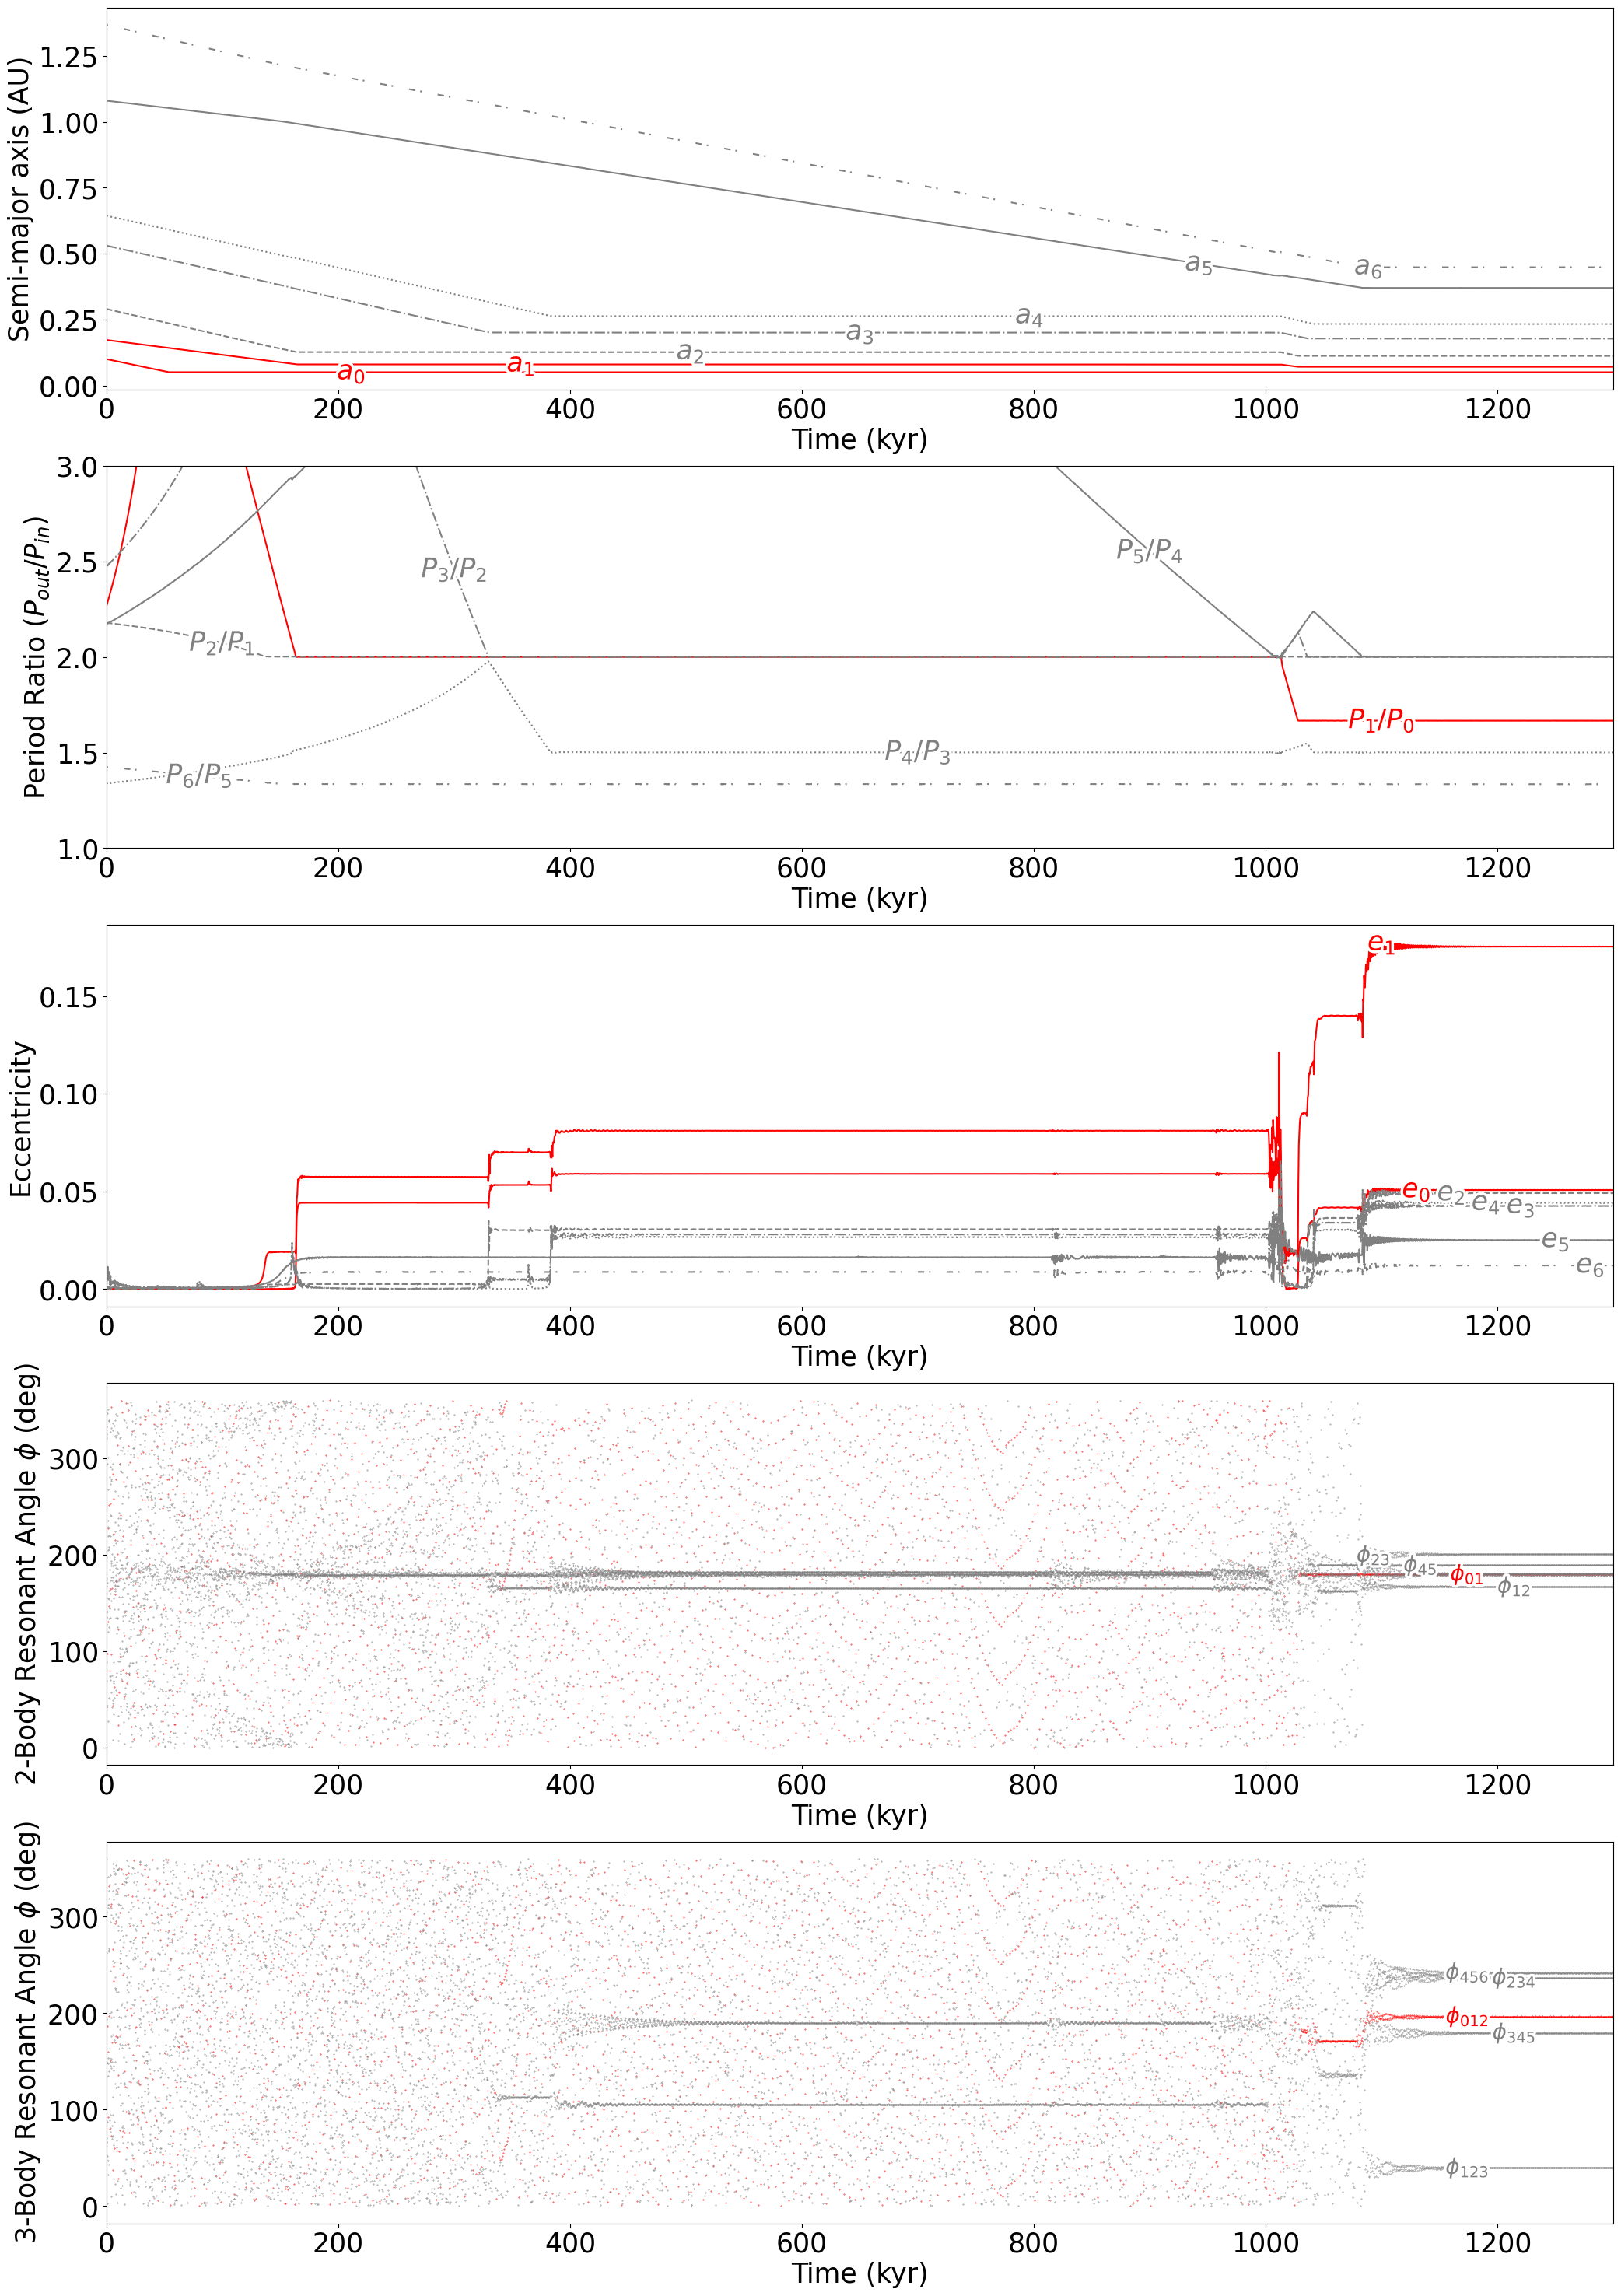

In [ ]:
# plot second order system
fig, ax = plt.subplots(5, 1, figsize = (25, 37))
fo_linestyles = ['dashed', 'dashdot', 'dotted', 'solid']
times = np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__times.npy')
semi_major = np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__as.npy')
p_ratios = np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__p_ratios.npy')
deltas = np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__deltas.npy') # Note: we have renormalized Deltas, but we don't plot it so I'm not changing it. If you wanted to, you'd just divide this array by p/q for each final resonance.
two_body_resonant_angles = np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__two_body_resonant_angles.npy')
three_body_resonant_angles = np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__three_body_resonant_angles.npy')
eccentricities = np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__es.npy')

time_limit = 1300
updated_idx = 0
for row_idx in range(7):
    if row_idx == 0 or row_idx == 1:
        alpha = 1
        ax[0].plot(times*0.001, semi_major[row_idx,:], label = '$a_'+str(row_idx)+'$', c = 'red', alpha = alpha, ls = 'solid')
    elif row_idx > 0 and row_idx < 6:
        alpha = 1
        ax[0].plot(times*0.001, semi_major[row_idx,:], label = '$a_'+str(row_idx)+'$', c = 'grey', alpha = alpha, ls = fo_linestyles[updated_idx])
        updated_idx+=1
    else:
        alpha = 1
        ax[0].plot(times*0.001, semi_major[row_idx,:], label = '$a_'+str(row_idx)+'$', c = 'grey', alpha = alpha, ls = 'solid', dashes = (1, 10, 4, 3))
ax[0].set_xlabel('Time (kyr)', fontsize = 25)
ax[0].set_ylabel('Semi-major axis (AU)', fontsize = 25)
ax[0].set_xlim(0,time_limit)
#ax[0].axhline(0.05, lw = 2, ls = ":",  c = 'black', label = 'Inner Disk Edge')
ax[0].tick_params(axis='both', which='major', labelsize = 25)
ax[0].tick_params(axis='both', which='minor', labelsize = 25)
#ax[0].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
labelLines(ax[0].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False)

updated_idx = 0
for row_idx in range(6):
    if row_idx == 0:
        alpha = 1
        ax[1].plot(times*0.001, p_ratios[row_idx,:], label = "$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$", c = 'red', alpha = alpha, ls = 'solid')
    elif row_idx > 0 and row_idx < 5:
        alpha = 1
        ax[1].plot(times*0.001, p_ratios[row_idx,:], label = "$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$", c = 'grey', alpha = alpha, ls = fo_linestyles[updated_idx])
        updated_idx+=1
    else:
        alpha = 1
        ax[1].plot(times*0.001, p_ratios[row_idx,:], label = "$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$", c = 'grey', alpha = alpha, ls = 'solid', dashes = (1, 10, 4, 3))
    #if colors[row_idx] == 'orange':
    #    ax[1].text(times[500:501]*1e-3, p_ratios[row_idx, 500:501]-0.05, r"$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$",  c = colors[row_idx], fontsize = 25, zorder = 4, bbox = dict(facecolor='white', alpha=0.2, edgecolor='white'))
ax[1].set_xlabel('Time (kyr)', fontsize = 25)
ax[1].set_ylabel('Period Ratio ($P_{out}/P_{in}$)', fontsize = 25)
ax[1].set_xlim(0, time_limit)
ax[1].set_ylim(1, 3)
ax[1].tick_params(axis='both', which='major', labelsize = 25)
ax[1].tick_params(axis='both', which='minor', labelsize = 25)
#ax[1].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
labelLines(ax[1].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False, shrink_factor = 0.1, xvals = [1100, 100, 300, 700, 900, 80]*1000)
#ax[1].legend(fontsize = 20)

updated_idx = 0
for row_idx in range(7):
    if row_idx == 0 or row_idx == 1:
        alpha = 1
        ax[2].plot(times*0.001, eccentricities[row_idx,:], label = '$e_'+str(row_idx)+'$', c = 'red', alpha = alpha, ls = 'solid')
    elif row_idx > 1 and row_idx < 6:
        alpha = 1
        ax[2].plot(times*0.001, eccentricities[row_idx,:], label = '$e_'+str(row_idx)+'$', c = 'grey', alpha = alpha, ls = fo_linestyles[updated_idx])
        updated_idx+=1
    else:
        alpha = 1
        ax[2].plot(times*0.001, eccentricities[row_idx,:], label = '$e_'+str(row_idx)+'$', c = 'grey', alpha = alpha, ls = 'solid', dashes = (1, 10, 4, 3))
ax[2].set_xlabel('Time (kyr)', fontsize = 25)
ax[2].set_ylabel('Eccentricity', fontsize = 25)
ax[2].set_xlim(0,time_limit)
ax[2].tick_params(axis='both', which='major', labelsize = 25)
ax[2].tick_params(axis='both', which='minor', labelsize = 25)
#ax[2].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
labelLines(ax[2].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False, xvals = [1130, 1100, 1160, 1220, 1190, 1250, 1280]*1000)
#ax[2].legend(fontsize = 20)

for row_idx in range(6):
    if row_idx == 0:
        alpha = 1
        ax[3].scatter(times*0.001, two_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'red', alpha = alpha, ls = 'solid')
        # Let's make plot label clearer
        ax[3].plot(times[2900:2902]*1e-3, two_body_resonant_angles[row_idx,2900:2902], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$', c = 'red', alpha = alpha)
    elif row_idx > 0: #and row_idx < 4:
        alpha = 1
        ax[3].scatter(times*0.001, two_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'grey', alpha = alpha)
        if row_idx == 1: 
            ax[3].plot(times[3000:3002]*1e-3, two_body_resonant_angles[row_idx,3000:3002], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$', c = 'grey', alpha = alpha)
        elif row_idx == 2:
            ax[3].plot(times[2700:2702]*1e-3, two_body_resonant_angles[row_idx,2700:2702], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$', c = 'grey', alpha = alpha)
        elif row_idx == 4:
            ax[3].plot(times[2800:2802]*1e-3, two_body_resonant_angles[row_idx,2800:2802], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$', c = 'grey', alpha = alpha)
ax[3].set_xlabel('Time (kyr)', fontsize = 25)
ax[3].set_ylabel('2-Body Resonant Angle $\phi$ (deg)', fontsize = 25)
ax[3].set_xlim(0,time_limit)
#ax[3].set_ylim(160,220)
ax[3].tick_params(axis='both', which='major', labelsize = 25)
ax[3].tick_params(axis='both', which='minor', labelsize = 25)
#ax[3].axvline(times[determine_lock_period_ratio(times, p_ratios, 1)]*1e-3, ls = '--', c = 'black')
labelLines(ax[3].get_lines(), zorder=5, fontsize = 20, drop_label = True,  align = False)
#ax[3].legend(fontsize = 20)


for row_idx in range(5):
    if row_idx == 0:
        alpha = 1
        ax[4].scatter(times*0.001, three_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'red', alpha = alpha)
        ax[4].plot(times[2900:2902]*1e-3, three_body_resonant_angles[row_idx,2900:2902], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$', c = 'red', alpha = alpha)
    else:
        alpha = 1
        ax[4].scatter(times*0.001, three_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'grey', alpha = alpha)
        if row_idx == 4:
            ax[4].plot(times[2900:2902]*1e-3, three_body_resonant_angles[row_idx,2900:2902], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$', c = 'grey', alpha = alpha)
        elif row_idx == 2: 
            ax[4].plot(times[3000:3002]*1e-3, three_body_resonant_angles[row_idx,3000:3002], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$', c = 'grey', alpha = alpha)
        elif row_idx == 3: 
            ax[4].plot(times[3000:3002]*1e-3, three_body_resonant_angles[row_idx,3000:3002], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$', c = 'grey', alpha = alpha)
        else:
            ax[4].plot(times[2900:2902]*1e-3, three_body_resonant_angles[row_idx,2900:2902], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$', c = 'grey', alpha = alpha)


ax[4].set_xlabel('Time (kyr)', fontsize = 25)
ax[4].set_ylabel('3-Body Resonant Angle $\phi$ (deg)', fontsize = 25)
ax[4].set_xlim(0,time_limit)
ax[4].tick_params(axis='both', which='major', labelsize = 25)
ax[4].tick_params(axis='both', which='minor', labelsize = 25)
#ax[4].axvline(times[determine_lock_period_ratio(times, p_ratios, 1)]*1e-3, ls = '--', c = 'black')
labelLines(ax[4].get_lines(), zorder=5, fontsize = 20, drop_label = True,  align = False)
#ax[4].legend(fontsize = 20)

plt.show()
fig.savefig("output_plots/second_order_example.png", bbox_inches = 'tight')

In [ ]:
# Let's get system info in a table.
print(r"$\Sigma$ & $h$ & $\tau_a$ & Integration Time & Stellar Mass"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['Sigma'], 3))+r"g/cm^2$ & $"+str(sig_figs(second_order_system_to_rerun['h'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['taua'], 3)/1000)+"kyr$ & $"+str(sig_figs(second_order_system_to_rerun['itime'], 3)/1000)+"kyr$ & $"+str(sig_figs(second_order_system_to_rerun['st_mass'], 3))+r"M_\odot$"+r" \\")
print("\hline")
print(r"$m_0$ & $m_1$ & $m_2$ & $m_3$ & $m_4$ & $m_5$ & $m_6$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['pl_mass_0']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(second_order_system_to_rerun['pl_mass_1']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(second_order_system_to_rerun['pl_mass_2']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(second_order_system_to_rerun['pl_mass_3']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(second_order_system_to_rerun['pl_mass_4']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(second_order_system_to_rerun['pl_mass_5']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(second_order_system_to_rerun['pl_mass_6']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$"+r" \\")
print(r"$e_0$ & $e_1$ & $e_2$ & $e_3$ & $e_4$ & $e_5$ & $e_6$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['e_0'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['e_1'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['e_2'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['e_3'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['e_4'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['e_5'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['e_6'], 3))+r"$ \\")
print(r"$a_{0i}$ & $a_{1i}$ & $a_{2i}$ & $a_{3i}$ & $a_{4i}$ & $a_{5i}$ & $a_{6i}$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['pl_orbsmax_0'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['pl_orbsmax_1'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['pl_orbsmax_2'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['pl_orbsmax_3'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['pl_orbsmax_4'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['pl_orbsmax_5'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['pl_orbsmax_6'], 3))+r"AU$ \\")
print(r"$a_{0f}$ & $a_{1f}$ & $a_{2f}$ & $a_{3f}$ & $a_{4f}$ & $a_{5f}$ & $a_{6f}$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['a_0'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['a_1'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['a_2'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['a_3'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['a_4'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['a_5'], 3))+"AU$ & $"+str(sig_figs(second_order_system_to_rerun['a_6'], 3))+r"AU$ \\")
print("\hline")
print('$m_1/m_0$ & $m_2/m_1$ & $m_3/m_2$ & $m_4/m_3$ & $m_5/m_4$ & $m_6/m_5$'+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['m_01'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['m_12'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['m_23'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['m_34'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['m_45'], 3))+"$ & $"+str(sig_figs(second_order_system_to_rerun['m_56'], 3))+r"$ \\")
print(r"$p_{01}/q_{01}$ & $p_{12}/q_{12}$ & $p_{23}/q_{23}$ & $p_{34}/q_{34}$ & $p_{45}/q_{45}$ & $p_{56}/q_{56}$"+r" \\")
print("$"+str(fractions.Fraction(second_order_system_to_rerun['prox_res_01']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(second_order_system_to_rerun['prox_res_12']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(second_order_system_to_rerun['prox_res_23']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(second_order_system_to_rerun['prox_res_34']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(second_order_system_to_rerun['prox_res_45']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(second_order_system_to_rerun['prox_res_56']).limit_denominator(1000))+r"$ \\")
#print("$(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$"+r"\\") # I could calculate this, but I would have to adapt old code.
print("$(P_1/P_0)_f$ & $(P_2/P_1)_f$ & $(P_3/P_2)_f$ & $(P_4/P_3)_f$ & $(P_5/P_4)_f$ & $(P_6/P_5)_f$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['p_ratio_01'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['p_ratio_12'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['p_ratio_23'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['p_ratio_34'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['p_ratio_45'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['p_ratio_56'], 5))+r"$ \\")
print(r"$\Delta_{01}$ & $\Delta_{12}$ & $\Delta_{23}$ & $\Delta_{34}$ & $\Delta_{45}$ & $\Delta_{56}$"+r" \\")
# note that here again we change our definition of delta. Just use the line below if you want to use the old version.
print("$"+str(sig_figs(second_order_system_to_rerun['delta_01'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_12'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_23'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_34'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_45'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_56'], 5))+r"$ \\")
#print("$"+str(sig_figs(second_order_system_to_rerun['delta_wu_01'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_wu_12'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_wu_23'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_wu_34'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_wu_45'], 5))+"$ & $"+str(sig_figs(second_order_system_to_rerun['delta_wu_56'], 5))+r"$ \\")
print(r"$\phi_{01}$ & $\phi_{12}$ & $\phi_{23}$ & $\phi_{34}$ & $\phi_{45}$ & $\phi_{56}$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['phi_cen_2_01'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_2_12'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_2_23'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_2_34'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_2_45'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_2_56'], 3))+"^\circ$"+r" \\")
print(r"$A_{01}$ & $A_{12}$ & $A_{23}$ & $A_{34}$ & $A_{45}$ & $A_{56}$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['phi_amp_2_01'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_2_12'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_2_23'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_2_34'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_2_45'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_2_56'], 3))+"^\circ$"+r" \\")
print("\hline")
print(r"$\phi_{012}$ & $\phi_{123}$ & $\phi_{234}$ & $\phi_{345}$ & $\phi_{456}$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['phi_cen_3_012'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_3_123'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_3_234'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_3_345'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_cen_3_456'], 3))+"^\circ$"+r" \\")
print(r"$A_{012}$ & $A_{123}$ & $A_{234}$ & $A_{345}$ & $A_{456}$"+r" \\")
print("$"+str(sig_figs(second_order_system_to_rerun['phi_amp_3_012'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_3_123'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_3_234'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_3_345'], 3))+"^\circ$ & $"+str(sig_figs(second_order_system_to_rerun['phi_amp_3_456'], 3))+"^\circ$"+r" \\")

$\Sigma$ & $h$ & $\tau_a$ & Integration Time & Stellar Mass \\
$16.6g/cm^2$ & $0.0395AU$ & $1350.0kyr$ & $4050.0kyr$ & $0.89M_\odot$ \\
\hline
$m_0$ & $m_1$ & $m_2$ & $m_3$ & $m_4$ & $m_5$ & $m_6$ \\
$7.95M_\oplus$ & $4.82M_\oplus$ & $8.64M_\oplus$ & $8.55M_\oplus$ & $8.59M_\oplus$ & $4.42M_\oplus$ & $8.67M_\oplus$ \\
$e_0$ & $e_1$ & $e_2$ & $e_3$ & $e_4$ & $e_5$ & $e_6$ \\
$0.0507$ & $0.175$ & $0.0492$ & $0.0426$ & $0.0442$ & $0.0251$ & $0.0121$ \\
$a_{0i}$ & $a_{1i}$ & $a_{2i}$ & $a_{3i}$ & $a_{4i}$ & $a_{5i}$ & $a_{6i}$ \\
$0.1AU$ & $0.173AU$ & $0.29AU$ & $0.531AU$ & $0.644AU$ & $1.08AU$ & $1.37AU$ \\
$a_{0f}$ & $a_{1f}$ & $a_{2f}$ & $a_{3f}$ & $a_{4f}$ & $a_{5f}$ & $a_{6f}$ \\
$0.0501AU$ & $0.0705AU$ & $0.112AU$ & $0.178AU$ & $0.233AU$ & $0.37AU$ & $0.448AU$ \\
\hline
$m_1/m_0$ & $m_2/m_1$ & $m_3/m_2$ & $m_4/m_3$ & $m_5/m_4$ & $m_6/m_5$ \\
$0.607$ & $1.79$ & $0.989$ & $1.0$ & $0.515$ & $1.96$ \\
$p_{01}/q_{01}$ & $p_{12}/q_{12}$ & $p_{23}/q_{23}$ & $p_{34}/q_{34}$ & $p_{45}/q_{45}$

# Section 4: Higher Order MMRs Form Through Convergent Disk Migration
* Here, we provide Table 2, which includes the different fraction of resonant orders across different mean motion resonance categories.
* We also include Figure 6, which is the fraction of individual mean motion resonances across order. 

In [ ]:
# Let's make them a LaTex table dataset
# Let's round all of our variables
sigfigs = 4
sigfigs_uncert = 2
number_of_resonant_planet_pairs = len(fractional_first_order_resonances)+len(fractional_second_order_resonances)+len(fractional_third_order_resonances)

print("Category & Count & Percentage Against Entirety of Category\\"+"\\")
# do for first, second, and third, add dividing lines between each
print("First Order Resonant Pairs & $"+str(len(fractional_first_order_resonances))+"$ & $"+str(sig_figs(len(fractional_first_order_resonances)/number_of_resonant_planet_pairs*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(fractional_first_order_resonances), number_of_resonant_planet_pairs), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Second Order Resonant Pairs & $"+str(len(fractional_second_order_resonances))+"$ & $"+str(sig_figs(len(fractional_second_order_resonances)/number_of_resonant_planet_pairs*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(fractional_second_order_resonances), number_of_resonant_planet_pairs), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Third Order Resonant Pairs & $"+str(len(fractional_third_order_resonances))+"$ & $"+str(sig_figs(len(fractional_third_order_resonances)/number_of_resonant_planet_pairs*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(fractional_third_order_resonances), number_of_resonant_planet_pairs), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("\hline")
print("First Order 2-Body Resonant Chains & $"+str(len(first_order_resonant_chains_2))+"$ & $"+str(sig_figs(len(first_order_resonant_chains_2)/len(resonant_chains_2)*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(first_order_resonant_chains_2), len(resonant_chains_2)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Second Order 2-Body Resonant Chains & $"+str(len(second_order_resonant_chains_2))+"$ & $"+str(sig_figs(len(second_order_resonant_chains_2)/len(resonant_chains_2)*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(second_order_resonant_chains_2), len(resonant_chains_2)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Third Order 2-Body Resonant Chains & $"+str(len(third_order_resonant_chains_2))+"$ & $"+str(sig_figs(len(third_order_resonant_chains_2)/len(resonant_chains_2)*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(third_order_resonant_chains_2), len(resonant_chains_2)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("\hline")
print("First Order 3-Body Resonant Chains & $"+str(len(first_order_resonant_chains_3))+"$ & $"+str(sig_figs(len(first_order_resonant_chains_3)/len(resonant_chains_3)*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(first_order_resonant_chains_3), len(resonant_chains_3)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Second Order 3-Body Resonant Chains & $"+str(len(second_order_resonant_chains_3))+"$ & $"+str(sig_figs(len(second_order_resonant_chains_3)/len(resonant_chains_3)*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(second_order_resonant_chains_3), len(resonant_chains_3)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Third Order 3-Body Resonant Chains & $"+str(len(third_order_resonant_chains_3))+"$ & $"+str(sig_figs(len(third_order_resonant_chains_3)/len(resonant_chains_3)*100, sigfigs))+"\pm"+str(sig_figs(uncertainty(len(third_order_resonant_chains_3), len(resonant_chains_3)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("\hline")
first_order_parital_interrupted_resonances_2 = pd.concat([first_order_interrupted_resonances_2, first_order_partial_resonances_2])
second_order_parital_interrupted_resonances_2 = pd.concat([second_order_interrupted_resonances_2, second_order_partial_resonances_2])
third_order_parital_interrupted_resonances_2 = pd.concat([third_order_interrupted_resonances_2, third_order_partial_resonances_2])
parital_interrupted_resonances_2 = pd.concat([first_order_parital_interrupted_resonances_2, second_order_parital_interrupted_resonances_2, third_order_parital_interrupted_resonances_2])
assert len(parital_interrupted_resonances_2) == len(resonances_2)
print("First Order Partial Resonant Chains & $"+str(len(first_order_parital_interrupted_resonances_2))+"$ & $"+str(sig_figs(len(first_order_parital_interrupted_resonances_2)/len(parital_interrupted_resonances_2)*100, sigfigs-2))+"\pm"+str(sig_figs(uncertainty(len(first_order_parital_interrupted_resonances_2), len(parital_interrupted_resonances_2)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Second Order Partial Resonant Chains & $"+str(len(second_order_parital_interrupted_resonances_2))+"$ & $"+str(sig_figs(len(second_order_parital_interrupted_resonances_2)/len(parital_interrupted_resonances_2)*100, sigfigs-2))+"\pm"+str(sig_figs(uncertainty(len(second_order_parital_interrupted_resonances_2), len(parital_interrupted_resonances_2)), sigfigs_uncert))+"\%$"+"\\"+"\\")
print("Third Order Partial Resonant Chains & $"+str(len(third_order_parital_interrupted_resonances_2))+"$ & $"+str(sig_figs(len(third_order_parital_interrupted_resonances_2)/len(parital_interrupted_resonances_2)*100, sigfigs-2))+"\pm"+str(sig_figs(uncertainty(len(third_order_parital_interrupted_resonances_2), len(parital_interrupted_resonances_2)), sigfigs_uncert))+"\%$"+"\\"+"\\")

Category & Count & Percentage Against Entirety of Category\\
First Order Resonant Pairs & $22444$ & $94.62\pm0.15\%$\\
Second Order Resonant Pairs & $1124$ & $4.739\pm0.14\%$\\
Third Order Resonant Pairs & $151$ & $0.6366\pm0.052\%$\\
\hline
First Order 2-Body Resonant Chains & $4708$ & $85.2\pm0.48\%$\\
Second Order 2-Body Resonant Chains & $720$ & $13.03\pm0.45\%$\\
Third Order 2-Body Resonant Chains & $66$ & $1.194\pm0.15\%$\\
\hline
First Order 3-Body Resonant Chains & $2991$ & $85.65\pm0.59\%$\\
Second Order 3-Body Resonant Chains & $435$ & $12.46\pm0.56\%$\\
Third Order 3-Body Resonant Chains & $66$ & $1.89\pm0.23\%$\\
\hline
First Order Partial Resonant Chains & $779$ & $78.0\pm1.3\%$\\
Second Order Partial Resonant Chains & $197$ & $20.0\pm1.3\%$\\
Third Order Partial Resonant Chains & $26$ & $2.6\pm0.5\%$\\


First-Order Prevalence Observation: 72.8395061728395\pm2.853311524796103%
First-Order Prevalence Simulation: 95.23082145281738\pm0.138819089436438%
Second-Order Prevalence Observation: 27.160493827160494\pm2.853311524796103%
Second-Order Prevalence Simulation: 4.76917854718262\pm0.138819089436438%


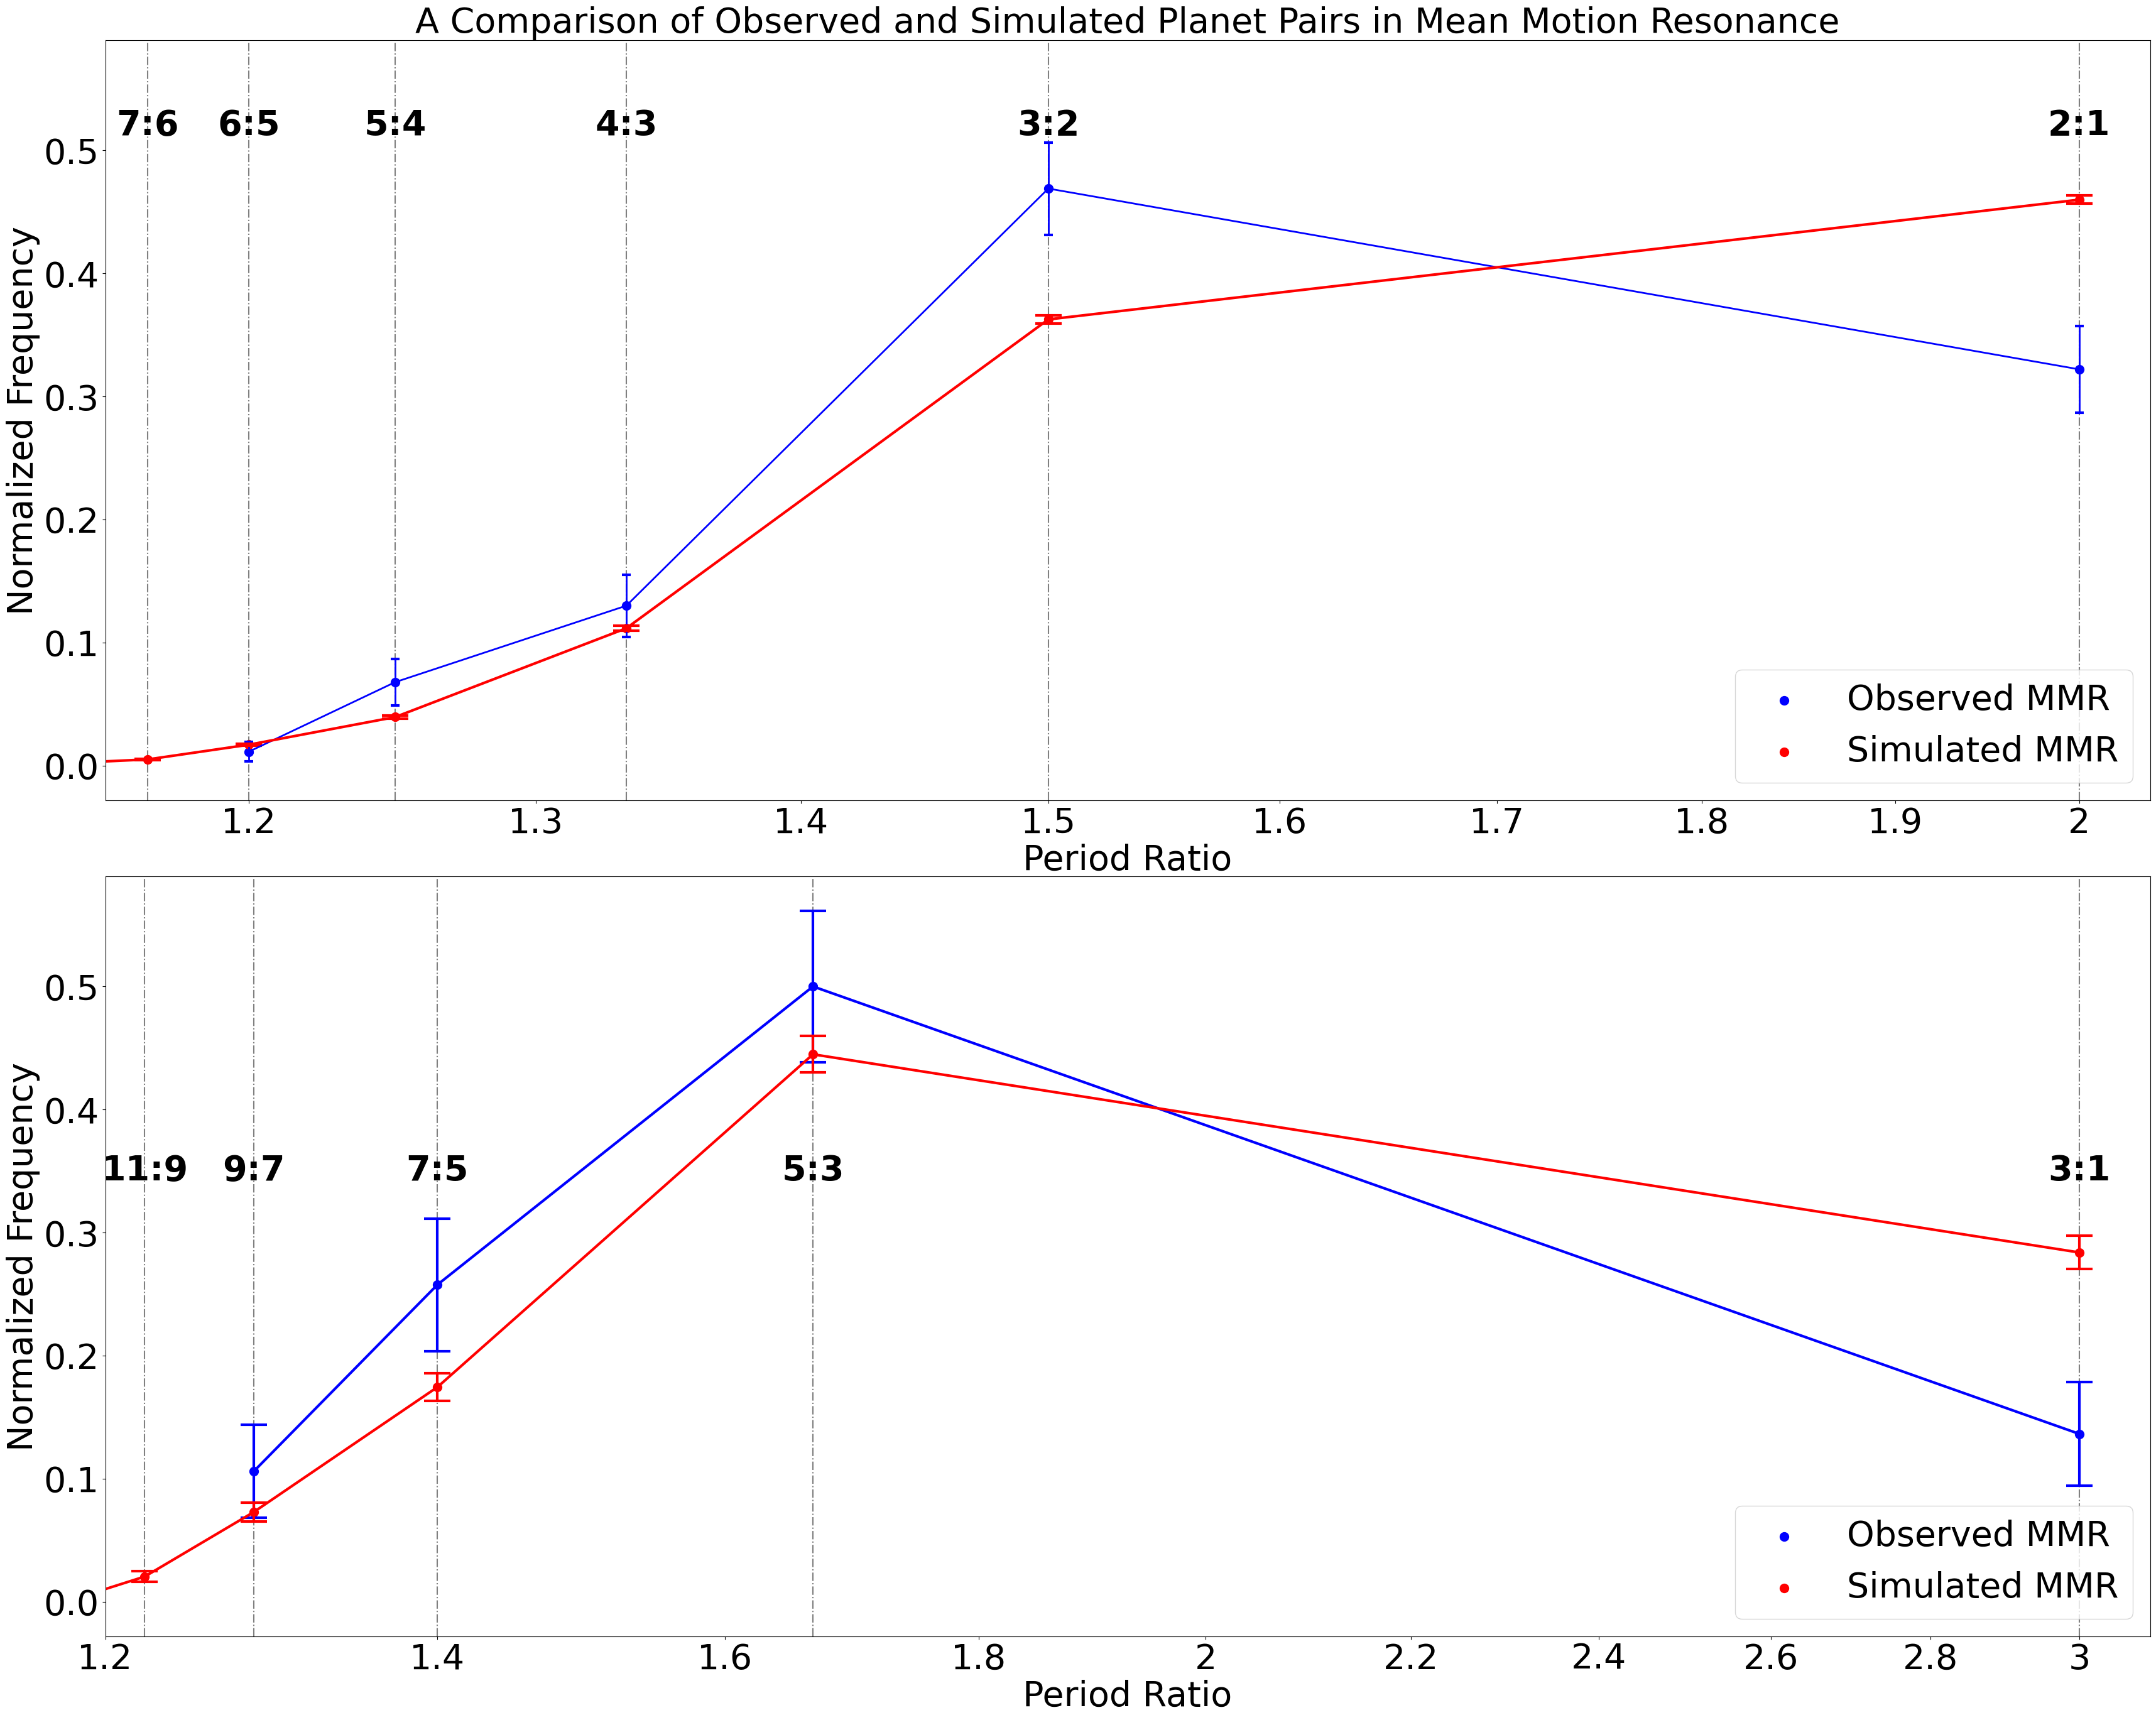

In [ ]:
# Let's quickly make figures of the above without folding that only include resonances where we have observational and simulated data. 
obs_first_resonances = [2/1, 3/2, 4/3, 5/4, 6/5]
obs_first_abundances = [57, 83, 23, 12, 2]
obs_first_total = np.sum(obs_first_abundances) 
obs_first_uncertainties = np.array([])
for idx in range(len(obs_first_resonances)): 
    res_uncert = uncertainty(obs_first_abundances[idx], obs_first_total, report_type = 'Fraction')
    obs_first_uncertainties = np.append(obs_first_uncertainties, res_uncert)
obs_second_resonances = [3/1, 5/3, 7/5, 9/7]
obs_second_abundances = [9, 33, 17, 7]
obs_second_total = np.sum(obs_second_abundances)
obs_second_uncertainties = np.array([])
for idx in range(len(obs_second_resonances)): 
    res_uncert = uncertainty(obs_second_abundances[idx], obs_second_total, report_type = 'Fraction')
    obs_second_uncertainties = np.append(obs_second_uncertainties, res_uncert)


# One other thing we could examine that is quite challenging to visualize is the overall prevalence of MMR across orders.
# In other words, is the difference in prevalence between first and second order resonances concurrent between simulation and observation? 
# We might also be able to avoid a plot of this simply by computing relevant percentages and just include relevant percentages and errors in the captions of figures for first and second order.
# Interestingly, second order resonances are far more common observationally than in simulations. Might this result say something about stability?
# It is worth noting that we could keep thinking about ways to display this problem. 
# Counting statistics is a little problematic here as it shrinks all the error bars across each sample. If we instead measure error bars for each individual resonance against the entire sample, we see more concordance.
# THis result is visible in the plots but we could also display it with a series of percentages for all of the shared resonances between observational and simulation populations.
# Also, not that when computing for a two option situation, the error bars are the same for each population as the uncertainty is a function of the square root of the number of sucesses times the difference in the total and the number of sucesses. This second term is always equivilent to the other population. 
# In other words, for a set of two populations with a and b counts, uncertainty in a depends on (a)*(a+b-a) = a*b. Uncertainty in b depends on (b)*(b+a-b) = b*a. 

obs_total_counts = np.sum([obs_first_total, obs_second_total])
first_order_obs_percent = np.sum(obs_first_abundances)/obs_total_counts*100
first_order_obs_error = uncertainty(np.sum(obs_first_abundances), obs_total_counts, "Percent")
second_order_obs_percent = np.sum(obs_second_abundances)/obs_total_counts*100
second_order_obs_error = uncertainty(np.sum(obs_second_abundances), obs_total_counts, "Percent")
fractional_first_order_resonances_unique, first_order_resonances_unique_counts = np.unique(fractional_first_order_resonances, return_counts = True)
fractional_second_order_resonances_unique, second_order_resonances_unique_counts = np.unique(fractional_second_order_resonances, return_counts = True)
decimal_first_order_resonances_unique = np.array([])
for frac_res in fractional_first_order_resonances_unique:
    decimal_first_order_resonances_unique = np.append(decimal_first_order_resonances_unique, frac_res.numerator/frac_res.denominator)
decimal_second_order_resonances_unique = np.array([])
for frac_res in fractional_second_order_resonances_unique:
    decimal_second_order_resonances_unique = np.append(decimal_second_order_resonances_unique, frac_res.numerator/frac_res.denominator)
first_order_uncertainties = np.array([])
for idx in range(len(decimal_first_order_resonances_unique)): 
    res_uncert = uncertainty(first_order_resonances_unique_counts[idx], len(fractional_first_order_resonances), report_type = 'Fraction')
    first_order_uncertainties = np.append(first_order_uncertainties, res_uncert)
second_order_uncertainties = np.array([])
for idx in range(len(decimal_second_order_resonances_unique)): 
    res_uncert = uncertainty(second_order_resonances_unique_counts[idx], len(fractional_second_order_resonances), report_type = 'Fraction')
    second_order_uncertainties = np.append(second_order_uncertainties, res_uncert)


# total counts ignores third order
sim_total_counts = len(fractional_first_order_resonances) + len(fractional_second_order_resonances)
first_order_sim_percent = np.sum(first_order_resonances_unique_counts)/sim_total_counts*100
first_order_sim_error = uncertainty(np.sum(first_order_resonances_unique_counts), sim_total_counts, "Percent")
second_order_sim_percent = np.sum(second_order_resonances_unique_counts)/sim_total_counts*100
second_order_sim_error = uncertainty(np.sum(second_order_resonances_unique_counts), sim_total_counts, "Percent")
print("First-Order Prevalence Observation: "+str(first_order_obs_percent)+"\pm"+str(first_order_obs_error)+"%")
print("First-Order Prevalence Simulation: "+str(first_order_sim_percent)+"\pm"+str(first_order_sim_error)+"%")
print("Second-Order Prevalence Observation: "+str(second_order_obs_percent)+"\pm"+str(second_order_obs_error)+"%")
print("Second-Order Prevalence Simulation: "+str(second_order_sim_percent)+"\pm"+str(second_order_sim_error)+"%")

fig, ax = plt.subplots(2, 1, sharey = True, facecolor = 'w', figsize = (42, 33))
fig.subplots_adjust(wspace = 0.01, hspace = 0.1)

for res in fractional_first_order_resonances_unique:
    # Don't plot ones that we have too small concentrations of.
    if res.numerator/res.denominator<=8/7:
        continue
    else:
        #ax[0].axvline(res*0.98, color = "grey", ls = 'dashdot', zorder = 1)
        #ax[0].axvline(res*1.02, color = "grey", ls = 'dashdot', zorder = 1)
        ax[0].axvline(res, color = "grey", ls = 'dashdot', zorder = 1)
        ax[0].text(res, 0.52, str(res.numerator)+":"+str(res.denominator), weight = 'bold', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 40, zorder = 4)
#labelLines(ax[0].get_lines(), zorder=5, fontsize = 40, drop_label = True,  align = False)

for res in fractional_second_order_resonances_unique:
    # Don't plot ones that we have too small concentrations of.
    if res<=fractions.Fraction(13/11):
        continue
    else:
        #ax[1].axvline(res*0.98, color = "grey", ls = 'dashdot', zorder = 1)
        #ax[1].axvline(res*1.02, color = "grey", ls = 'dashdot', zorder = 1)
        ax[1].axvline(res, color = "grey", ls = 'dashdot', zorder = 1) #label = str(res.numerator)+":"+str(res.denominator), zorder = 1)
        ax[1].text(res, 0.35, str(res.numerator)+":"+str(res.denominator), weight = 'bold', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 40, zorder = 4)
#labelLines(ax[1].get_lines(), zorder=5, fontsize = 150, drop_label = True,  align = True)

ax[0].scatter(obs_first_resonances, obs_first_abundances/obs_first_total, label = "Observed MMR", s = 100, c = 'b')
ax[0].errorbar(obs_first_resonances, obs_first_abundances/obs_first_total, yerr = obs_first_uncertainties, capsize = 5,  capthick = 3, linewidth = 2, c = 'b')
ax[0].scatter(decimal_first_order_resonances_unique, first_order_resonances_unique_counts/len(fractional_first_order_resonances), label = "Simulated MMR", s = 100, c = 'r')
ax[0].errorbar(decimal_first_order_resonances_unique, first_order_resonances_unique_counts/len(fractional_first_order_resonances), yerr = first_order_uncertainties, capsize = 15,  capthick = 3, linewidth = 3, c = 'r')
#ax[0].scatter(unique_prox_first_order_initial_mmr, prox_first_order_initial_mmr_counts/len(prox_first_order_initial_mmr), label = "Initial Period Ratios", s = 100, c = 'black')
#ax[0].errorbar(unique_prox_first_order_initial_mmr, prox_first_order_initial_mmr_counts/len(prox_first_order_initial_mmr), yerr = first_order_initial_uncertainties, capsize = 15,  capthick = 3, linewidth = 3, c = 'black')
ax[0].set_xlim(8/7+0.01, 2+0.04)
ax[0].set_xscale("log")
ax[0].set_xlabel("Period Ratio", fontsize = 40)
ax[0].set_ylabel("Normalized Frequency", fontsize = 40)
ax[0].legend(loc = 'lower right', prop={'size': 40})
ax[0].tick_params(axis='both', which='major', labelsize=40)
ax[0].tick_params(axis='both', which='minor', labelsize=40)
ax[0].set_xticks([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2], ["1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", "1.9", "2"])

ax[1].scatter(obs_second_resonances, obs_second_abundances/obs_second_total, label = "Observed MMR", s = 100, c = 'b')
ax[1].errorbar(obs_second_resonances, obs_second_abundances/obs_second_total, yerr = obs_second_uncertainties, capsize = 15,  capthick = 3, linewidth = 3, c = 'b')
ax[1].scatter(decimal_second_order_resonances_unique, second_order_resonances_unique_counts/len(fractional_second_order_resonances), label = "Simulated MMR", s = 100, c = 'r')
ax[1].errorbar(decimal_second_order_resonances_unique, second_order_resonances_unique_counts/len(fractional_second_order_resonances), yerr = second_order_uncertainties, capsize = 15, capthick = 3, linewidth = 3, c = 'r')
#ax[1].scatter(unique_prox_second_order_initial_mmr, prox_second_order_initial_mmr_counts/len(prox_second_order_initial_mmr), label = "Initial Period Ratios", s = 100, c = 'black')
#ax[1].errorbar(unique_prox_second_order_initial_mmr, prox_second_order_initial_mmr_counts/len(prox_second_order_initial_mmr), yerr = second_order_initial_uncertainties, capsize = 15,  capthick = 3, linewidth = 3, c = 'black')
ax[1].set_xlim(11/9-0.0001, 3+0.1)
ax[1].set_xscale("log")
ax[1].set_xlabel("Period Ratio", fontsize = 40)
ax[1].set_ylabel("Normalized Frequency", fontsize = 40)
ax[1].legend(loc = 'lower right', prop={'size': 40})
ax[1].tick_params(axis='both', which='major', labelsize=40)
ax[1].tick_params(axis='both', which='minor', labelsize=40)
ax[1].set_xticks([1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8, 3], ["1.2", "1.4", "1.6", "1.8", "2", "2.2", "2.4", "2.6", "2.8", "3"])

ax[0].set_title("A Comparison of Observed and Simulated Planet Pairs in Mean Motion Resonance", fontsize = 40)
fig.savefig("output_plots/MMR_Frequencies.png", bbox_inches = 'tight')
plt.show()
# Goldberg criteria is good. Plot as it is is informative. Don't figure it out yet...save for the next project.
# Label as period ratio and explain difference in caption.

# Section 5: Higher Order MMRs Prefer Slow Migration
* Here, we include Figure 7, the CDFs of $\tau_a$ and $m_{out}/m_{in}$. 
* We also provide Figure 8, the 2D parameter space of $\Sigma_0$ against $h_0$. 

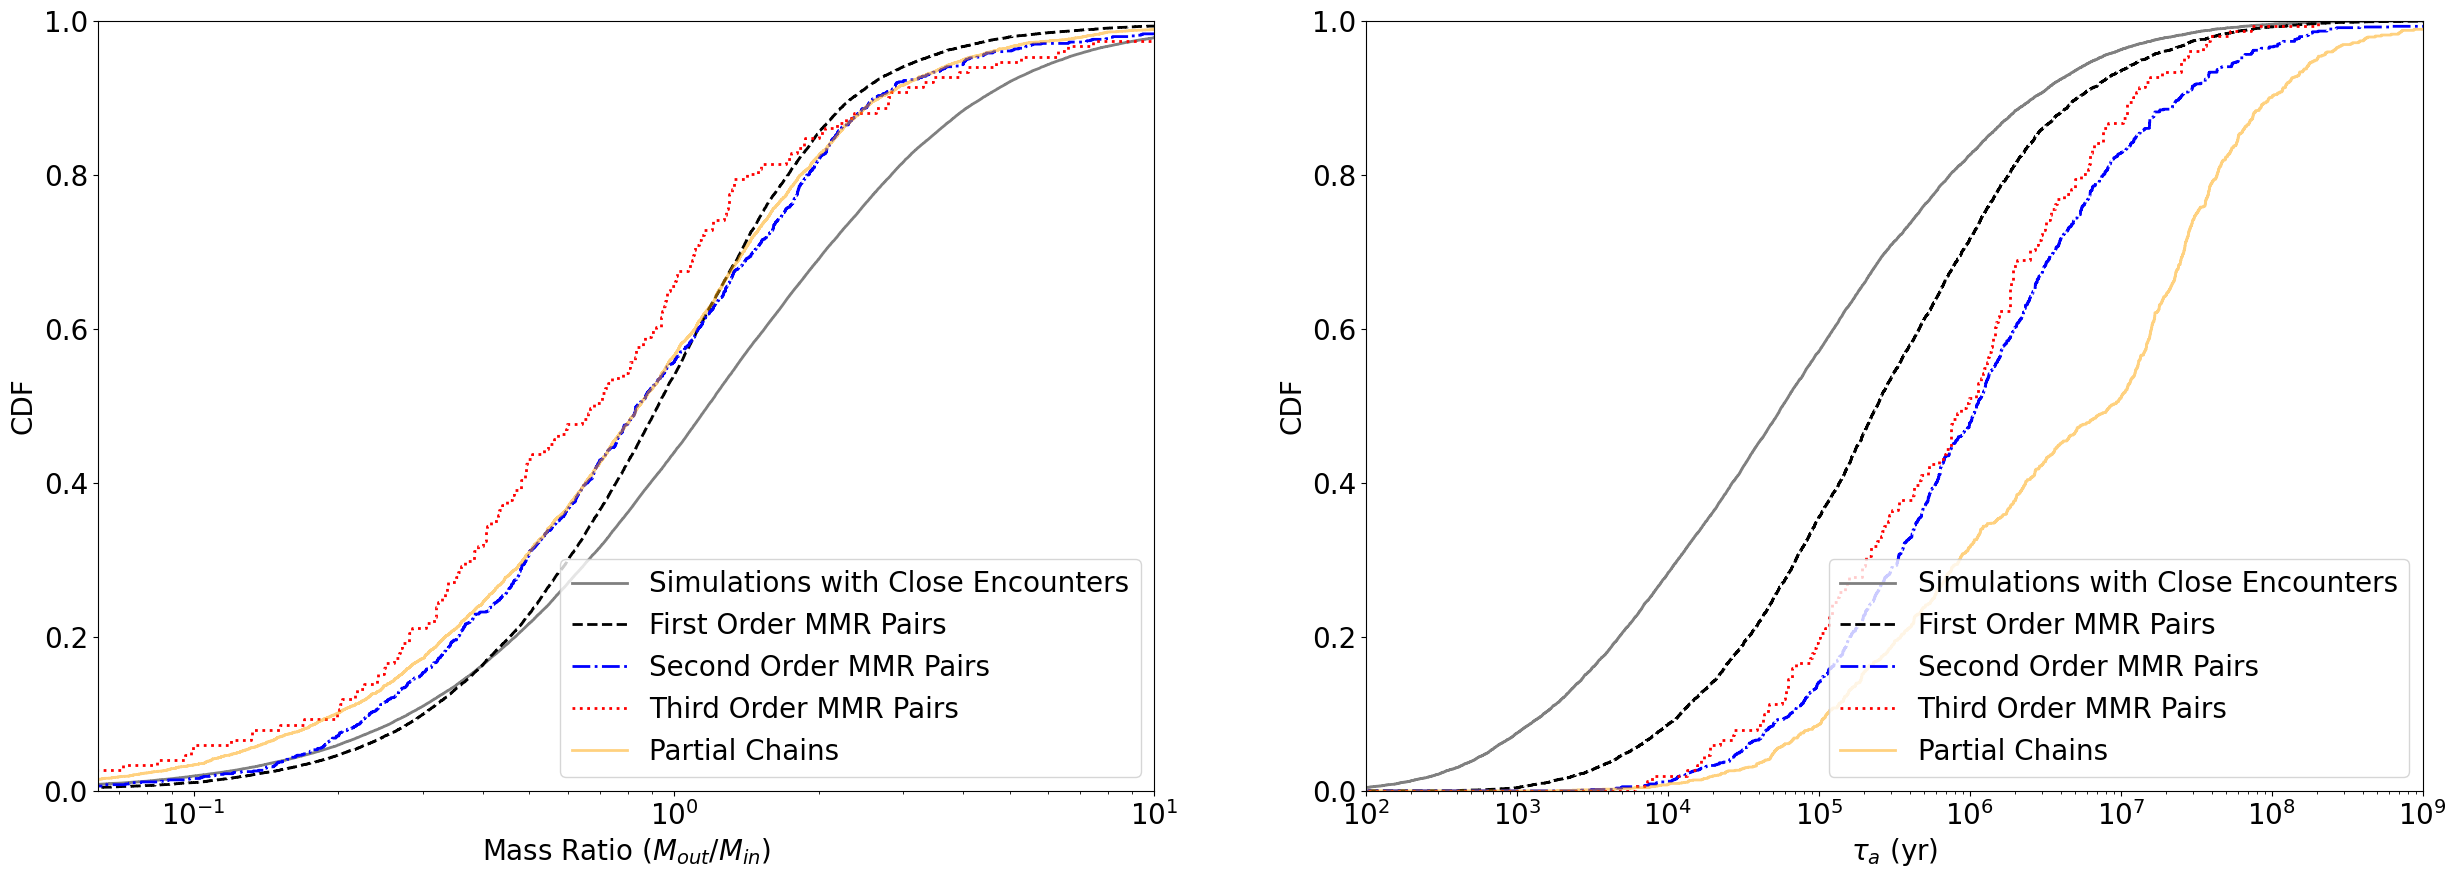

In [ ]:
failed_initial_period_ratios = np.transpose(np.vstack([failed_sims["p_i_01"].to_numpy(), failed_sims["p_i_12"].to_numpy(), failed_sims["p_i_23"].to_numpy(), failed_sims["p_i_34"].to_numpy(), failed_sims["p_i_45"].to_numpy(), failed_sims["p_i_56"].to_numpy()])).ravel()
failed_mass_ratios = np.transpose(np.vstack([failed_sims["m_01"].to_numpy(), failed_sims["m_12"].to_numpy(), failed_sims["m_23"].to_numpy(), failed_sims["m_34"].to_numpy(), failed_sims["m_45"].to_numpy(), failed_sims["m_56"].to_numpy()])).ravel()
failed_tauas = repeat_migration_conditions(failed_sims)['taua']

parital_interrupted_resonances_2 = resonances_2 #pd.concat([interrupted_resonances_2, partial_resonances_2])
partial_initial_period_ratios = np.transpose(np.vstack([parital_interrupted_resonances_2["p_i_01"].to_numpy(), parital_interrupted_resonances_2["p_i_12"].to_numpy(), parital_interrupted_resonances_2["p_i_23"].to_numpy(), parital_interrupted_resonances_2["p_i_34"].to_numpy(), parital_interrupted_resonances_2["p_i_45"].to_numpy(), parital_interrupted_resonances_2["p_i_56"].to_numpy()])).ravel()
partial_mass_ratios = np.transpose(np.vstack([parital_interrupted_resonances_2["m_01"].to_numpy(), parital_interrupted_resonances_2["m_12"].to_numpy(), parital_interrupted_resonances_2["m_23"].to_numpy(), parital_interrupted_resonances_2["m_34"].to_numpy(), parital_interrupted_resonances_2["m_45"].to_numpy(), parital_interrupted_resonances_2["m_56"].to_numpy()])).ravel()
partial_tauas = repeat_migration_conditions(parital_interrupted_resonances_2)['taua']


fig, ax = plt.subplots(1, 2, figsize = (30, 10))

sns.ecdfplot(failed_mass_ratios, ax = ax[0], log_scale = True, ls = 'solid', label = "Simulations with Close Encounters", c = 'grey', lw = 2)
sns.ecdfplot(first_order_mass_ratios, ax = ax[0], log_scale = True, ls = 'dashed',  label = "First Order MMR Pairs", c = 'black', lw = 2)
sns.ecdfplot(second_order_mass_ratios, ax = ax[0], log_scale = True, ls = 'dashdot',  label = "Second Order MMR Pairs", c = 'blue', lw = 2)
sns.ecdfplot(third_order_mass_ratios, ax = ax[0], log_scale = True, ls = 'dotted', label = "Third Order MMR Pairs", c = 'red', lw = 2)
sns.ecdfplot(partial_mass_ratios, ax = ax[0], log_scale = True,  ls = 'solid', label = "Partial Chains", c = 'orange', lw = 2, alpha = 0.5)

ax[0].set_xlim(10**(-1.2), 10**1)
ax[0].set_ylabel("CDF", fontsize = 20)
ax[0].set_xlabel("Mass Ratio ($M_{out}/M_{in}$)", fontsize = 20)
ax[0].legend(loc = 'lower right', fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize = 20)
ax[0].tick_params(axis='both', which='minor', labelsize = 20)

sns.ecdfplot(failed_sims['taua'], ax = ax[1], log_scale = True,  ls = 'solid', label = "Simulations with Close Encounters", c = 'grey', lw = 2)
#sns.ecdfplot(non_resonant_tauas, ax = ax[1], log_scale = True, ls = 'solid', label = "Non Resonant MMR Pairs", c = 'pink', lw = 2) # shows the same trend as partial sigmas but just more extreme as only includes the non-resonant pairs not the others
sns.ecdfplot(first_order_tauas, ax = ax[1], log_scale = True, ls = 'dashed', label = "First Order MMR Pairs", c = 'black', lw = 2)
sns.ecdfplot(second_order_tauas, ax = ax[1], log_scale = True, ls = 'dashdot', label = "Second Order MMR Pairs", c = 'blue', lw = 2)
sns.ecdfplot(third_order_tauas, ax = ax[1], log_scale = True, ls = 'dotted', label = "Third Order MMR Pairs", c = 'red', lw = 2)
sns.ecdfplot(partial_tauas, ax = ax[1], log_scale = True,  ls = 'solid', label = "Partial Chains", c = 'orange', lw = 2, alpha = 0.5)

ax[1].set_xlim(10**2, 10**9)
ax[1].set_ylabel("CDF", fontsize = 20)
ax[1].set_xlabel(r"$\tau_a$ (yr)", fontsize = 20)
ax[1].legend(loc = 'lower right', fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize = 20)
ax[1].tick_params(axis='both', which='minor', labelsize = 20)

fig.savefig("output_plots/MMR_CDFs.png",  bbox_inches = 'tight')

plt.show()

In [ ]:
# Let's do a two-distribution kstest.
# Recall: if the p value is under 0.05, we reject the null hypothesis. This means that the two distributions are distinct.
# could test with comparison to just converged systems to see about the p value issue 
# Let's test all combinations.
# Some of these p-values are really really small. I wonder if something has gone wrong, but there are stack overflow pages that suggest p-values like this are expected when drawn from the same distribution. https://stackoverflow.com/questions/65561840/ks-2samp-returns-p-value-of-1-0
mass_ratio_arrays = [failed_mass_ratios, partial_mass_ratios, first_order_mass_ratios, second_order_mass_ratios, third_order_mass_ratios]
mass_ratio_array_labels = ['Mass Ratios of Failed Planet Pairs', 'Mass Ratios for Planet Pairs in Partial Resonant Chains', 'Mass Ratios of First Order MMR Planet Pairs', 'Mass Ratios of Second Order MMR Planet Pairs', 'Mass Ratios of Third Order MMR Planet Pairs']
assert len(mass_ratio_arrays) == len(mass_ratio_array_labels)
for idx1, idx2 in combinations(range(0,5), 2):
    # two sided is a method of comparing to see if the two distributions are the same
    # Although asymtotic approaches are more efficient for comparisons with a large amount of data, we're using the exact method as it avoids p values of 0 (really means very small p value that asymtotically approaches 0).
    statistical_result = stats.ks_2samp(mass_ratio_arrays[idx1], mass_ratio_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(mass_ratio_array_labels[idx1])+" and "+str(mass_ratio_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(mass_ratio_array_labels[idx1])+" and "+str(mass_ratio_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(mass_ratio_array_labels[idx1])+" and "+str(mass_ratio_array_labels[idx2])+" are drawn from the same distribution.")
print('\n')

taua_arrays = [failed_tauas, partial_tauas, first_order_tauas, second_order_tauas, third_order_tauas]
taua_labels = ['Migration Timescales of Failed Systems', 'Migration Timescales of Partial Resonant Chains', 'Migration Timescales of Systems with First Order MMR Planet Pairs', 'Migration Timescales of Systems with Second Order MMR Planet Pairs', 'Migration Timescales of Systems with Third Order MMR Planet Pairs']
assert len(taua_arrays) == len(taua_labels)
for idx1, idx2 in combinations(range(0,5), 2):
    statistical_result = stats.ks_2samp(taua_arrays[idx1], taua_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(taua_labels[idx1])+" and "+str(taua_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(taua_labels[idx1])+" and "+str(taua_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(taua_labels[idx1])+" and "+str(taua_labels[idx2])+" are drawn from the same distribution.")

P value of kstest betweeen Mass Ratios of Failed Planet Pairs and Mass Ratios for Planet Pairs in Partial Resonant Chains: 4.160380297155004e-42
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that Mass Ratios of Failed Planet Pairs and Mass Ratios for Planet Pairs in Partial Resonant Chains may be drawn from different distributions.
P value of kstest betweeen Mass Ratios of Failed Planet Pairs and Mass Ratios of First Order MMR Planet Pairs: 8.248e-320
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that Mass Ratios of Failed Planet Pairs and Mass Ratios of First Order MMR Planet Pairs may be drawn from different distributions.
P value of kstest betweeen Mass Ratios of Failed Planet Pairs and Mass Ratios of Second Order MMR Planet Pairs: 1.5545123333328495e-81
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that Mass Ratios of Failed Planet Pairs and Mass Ratios of Second Order MMR Planet Pairs may be dra

In [ ]:
# Establish the relevant histogram edges and values.
sucessful_sims_repeated = repeat_migration_conditions(sucessful_sims)
bins = 5
# The distribution of systems spans a parameter space slightly larger than -1.88, -0.87 in h (and exactly 1 to 4 in Sigma). 
# We cut out the few systems outside of the h range above to make a nice square dataset. These fall only in the all systems and failed systems datasets.
sucessful_sims_above_thresh = sucessful_sims_repeated[-1.88 < np.log10(sucessful_sims_repeated['h'])]
sucessful_sims_between_threshes = sucessful_sims_above_thresh[np.log10(sucessful_sims_above_thresh['h'])<-0.87]

Sigmah_H, Sigmah_xedges, Sigmah_yedges = np.histogram2d(np.log10(sucessful_sims_between_threshes['Sigma']), np.log10(sucessful_sims_between_threshes['h']), bins = bins, range = [[np.min(np.log10(sucessful_sims_between_threshes['Sigma'])), np.max(np.log10(sucessful_sims_between_threshes['Sigma']))],[np.min(np.log10(sucessful_sims_between_threshes['h'])), np.max(np.log10(sucessful_sims_between_threshes['h']))]]) #[[0.95*np.min(np.log10(all_sims_between_threshes['Sigma'])), 1.05*np.max(np.log10(all_sims_between_threshes['Sigma']))],[1.05*np.min(np.log10(all_sims_between_threshes['h'])), 0.95*np.max(np.log10(all_sims_between_threshes['h']))]])
Sigmah_H_occurances_all = Sigmah_H/np.sum(Sigmah_H.ravel())
Sigmah_H_first, Sigmah_xedges_first, Sigmah_yedges_first = np.histogram2d(np.log10(first_order_Sigmas), np.log10(first_order_hs), bins = [Sigmah_xedges, Sigmah_yedges])
Sigmah_H_occurances_first = Sigmah_H_first/np.sum(Sigmah_H_first.ravel())
Sigmah_H_second, Sigmah_xedges_second, Sigmah_yedges_second = np.histogram2d(np.log10(second_order_Sigmas), np.log10(second_order_hs), bins = [Sigmah_xedges, Sigmah_yedges])
Sigmah_H_occurances_second = Sigmah_H_second/np.sum(Sigmah_H_second.ravel())
Sigmah_H_third, Sigmah_xedges_third, Sigmah_yedges_third = np.histogram2d(np.log10(third_order_Sigmas), np.log10(third_order_hs), bins = [Sigmah_xedges, Sigmah_yedges])
Sigmah_H_occurances_third = Sigmah_H_third/np.sum(Sigmah_H_third.ravel())
Sigmah_H_non, Sigmah_xedges_non, Sigmah_yedges_non = np.histogram2d(np.log10(non_resonant_Sigmas), np.log10(non_resonant_hs), bins = [Sigmah_xedges, Sigmah_yedges])
Sigmah_H_occurances_non = Sigmah_H_non/np.sum(Sigmah_H_non.ravel())
assert Sigmah_xedges.all() == Sigmah_xedges_first.all() == Sigmah_xedges_second.all() == Sigmah_xedges_third.all()  == Sigmah_xedges_non.all() and Sigmah_yedges.all() == Sigmah_yedges_first.all() == Sigmah_yedges_second.all() == Sigmah_yedges_third.all() == Sigmah_yedges_non.all()

def alternative_occurance_metric(bins = bins, Sigmah_H_first = Sigmah_H_first, Sigmah_H_second = Sigmah_H_second, Sigmah_H_third = Sigmah_H_third, Sigmah_H_non = Sigmah_H_non):
    Sigmah_H_occurances_first  = np.array([])
    Sigmah_H_occurances_second = np.array([])
    Sigmah_H_occurances_third = np.array([])
    Sigmah_H_occurances_non = np.array([])
    for i in range(bins):
        for j in range(bins):
            if Sigmah_H_first[i,j] == 0: 
                Sigmah_H_occurances_first = np.append(Sigmah_H_occurances_first, 0.0)
            elif Sigmah_H_first[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]) >= 0.0015:
                Sigmah_H_occurances_first = np.append(Sigmah_H_occurances_first, Sigmah_H_first[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]))
            else: 
                Sigmah_H_occurances_first = np.append(Sigmah_H_occurances_first, 0.0)
            if Sigmah_H_second[i,j] == 0: 
                Sigmah_H_occurances_second = np.append(Sigmah_H_occurances_second, 0.0)
            elif Sigmah_H_second[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]) >= 0.0015:
                Sigmah_H_occurances_second = np.append(Sigmah_H_occurances_second, Sigmah_H_second[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]))
            else:
                Sigmah_H_occurances_second = np.append(Sigmah_H_occurances_second, 0.0)
            if Sigmah_H_third[i,j] == 0: 
                Sigmah_H_occurances_third = np.append(Sigmah_H_occurances_third, 0.0)
            elif Sigmah_H_third[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]) >= 0.0015:
                Sigmah_H_occurances_third = np.append(Sigmah_H_occurances_third, Sigmah_H_third[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]))
            else: 
                Sigmah_H_occurances_third = np.append(Sigmah_H_occurances_third, 0.0)
            if Sigmah_H_non[i,j] == 0: 
                Sigmah_H_occurances_non = np.append(Sigmah_H_occurances_non, 0.0)
            elif Sigmah_H_non[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]) >= 0.0015:
                Sigmah_H_occurances_non = np.append(Sigmah_H_occurances_non, Sigmah_H_non[i,j]/(Sigmah_H_first[i,j]+Sigmah_H_second[i,j]+Sigmah_H_third[i,j]+Sigmah_H_non[i,j]))
            else: 
                Sigmah_H_occurances_non = np.append(Sigmah_H_occurances_non, 0.0)
    Sigmah_H_occurances_first  = Sigmah_H_occurances_first.reshape(bins,bins)
    Sigmah_H_occurances_second = Sigmah_H_occurances_second.reshape(bins,bins)
    Sigmah_H_occurances_third = Sigmah_H_occurances_third.reshape(bins,bins)
    Sigmah_H_occurances_non = Sigmah_H_occurances_non.reshape(bins,bins)
    return Sigmah_H_occurances_first, Sigmah_H_occurances_second, Sigmah_H_occurances_third, Sigmah_H_occurances_non 
Sigmah_H_occurances_first, Sigmah_H_occurances_second, Sigmah_H_occurances_third, Sigmah_H_occurances_non = alternative_occurance_metric()

# Let's make sure our color range is appropriate.
# Let's make a colormap. We want to make sure this runs from 0-1. We can tweak the top value lower if the dataset doesn't go to 1.In that case
vmin = 0.0001 # parameter to adjust minimum color.
vmax = 1.0  # parameter to quickly adjust maximum color
assert np.min(np.hstack([Sigmah_H_occurances_first.ravel(), Sigmah_H_occurances_second.ravel(), Sigmah_H_occurances_third.ravel(), Sigmah_H_occurances_non.ravel()]))>=vmin-0.0001 and np.max(np.hstack([Sigmah_H_occurances_first.ravel(), Sigmah_H_occurances_second.ravel(), Sigmah_H_occurances_third.ravel(), Sigmah_H_occurances_non.ravel()])) <= vmax

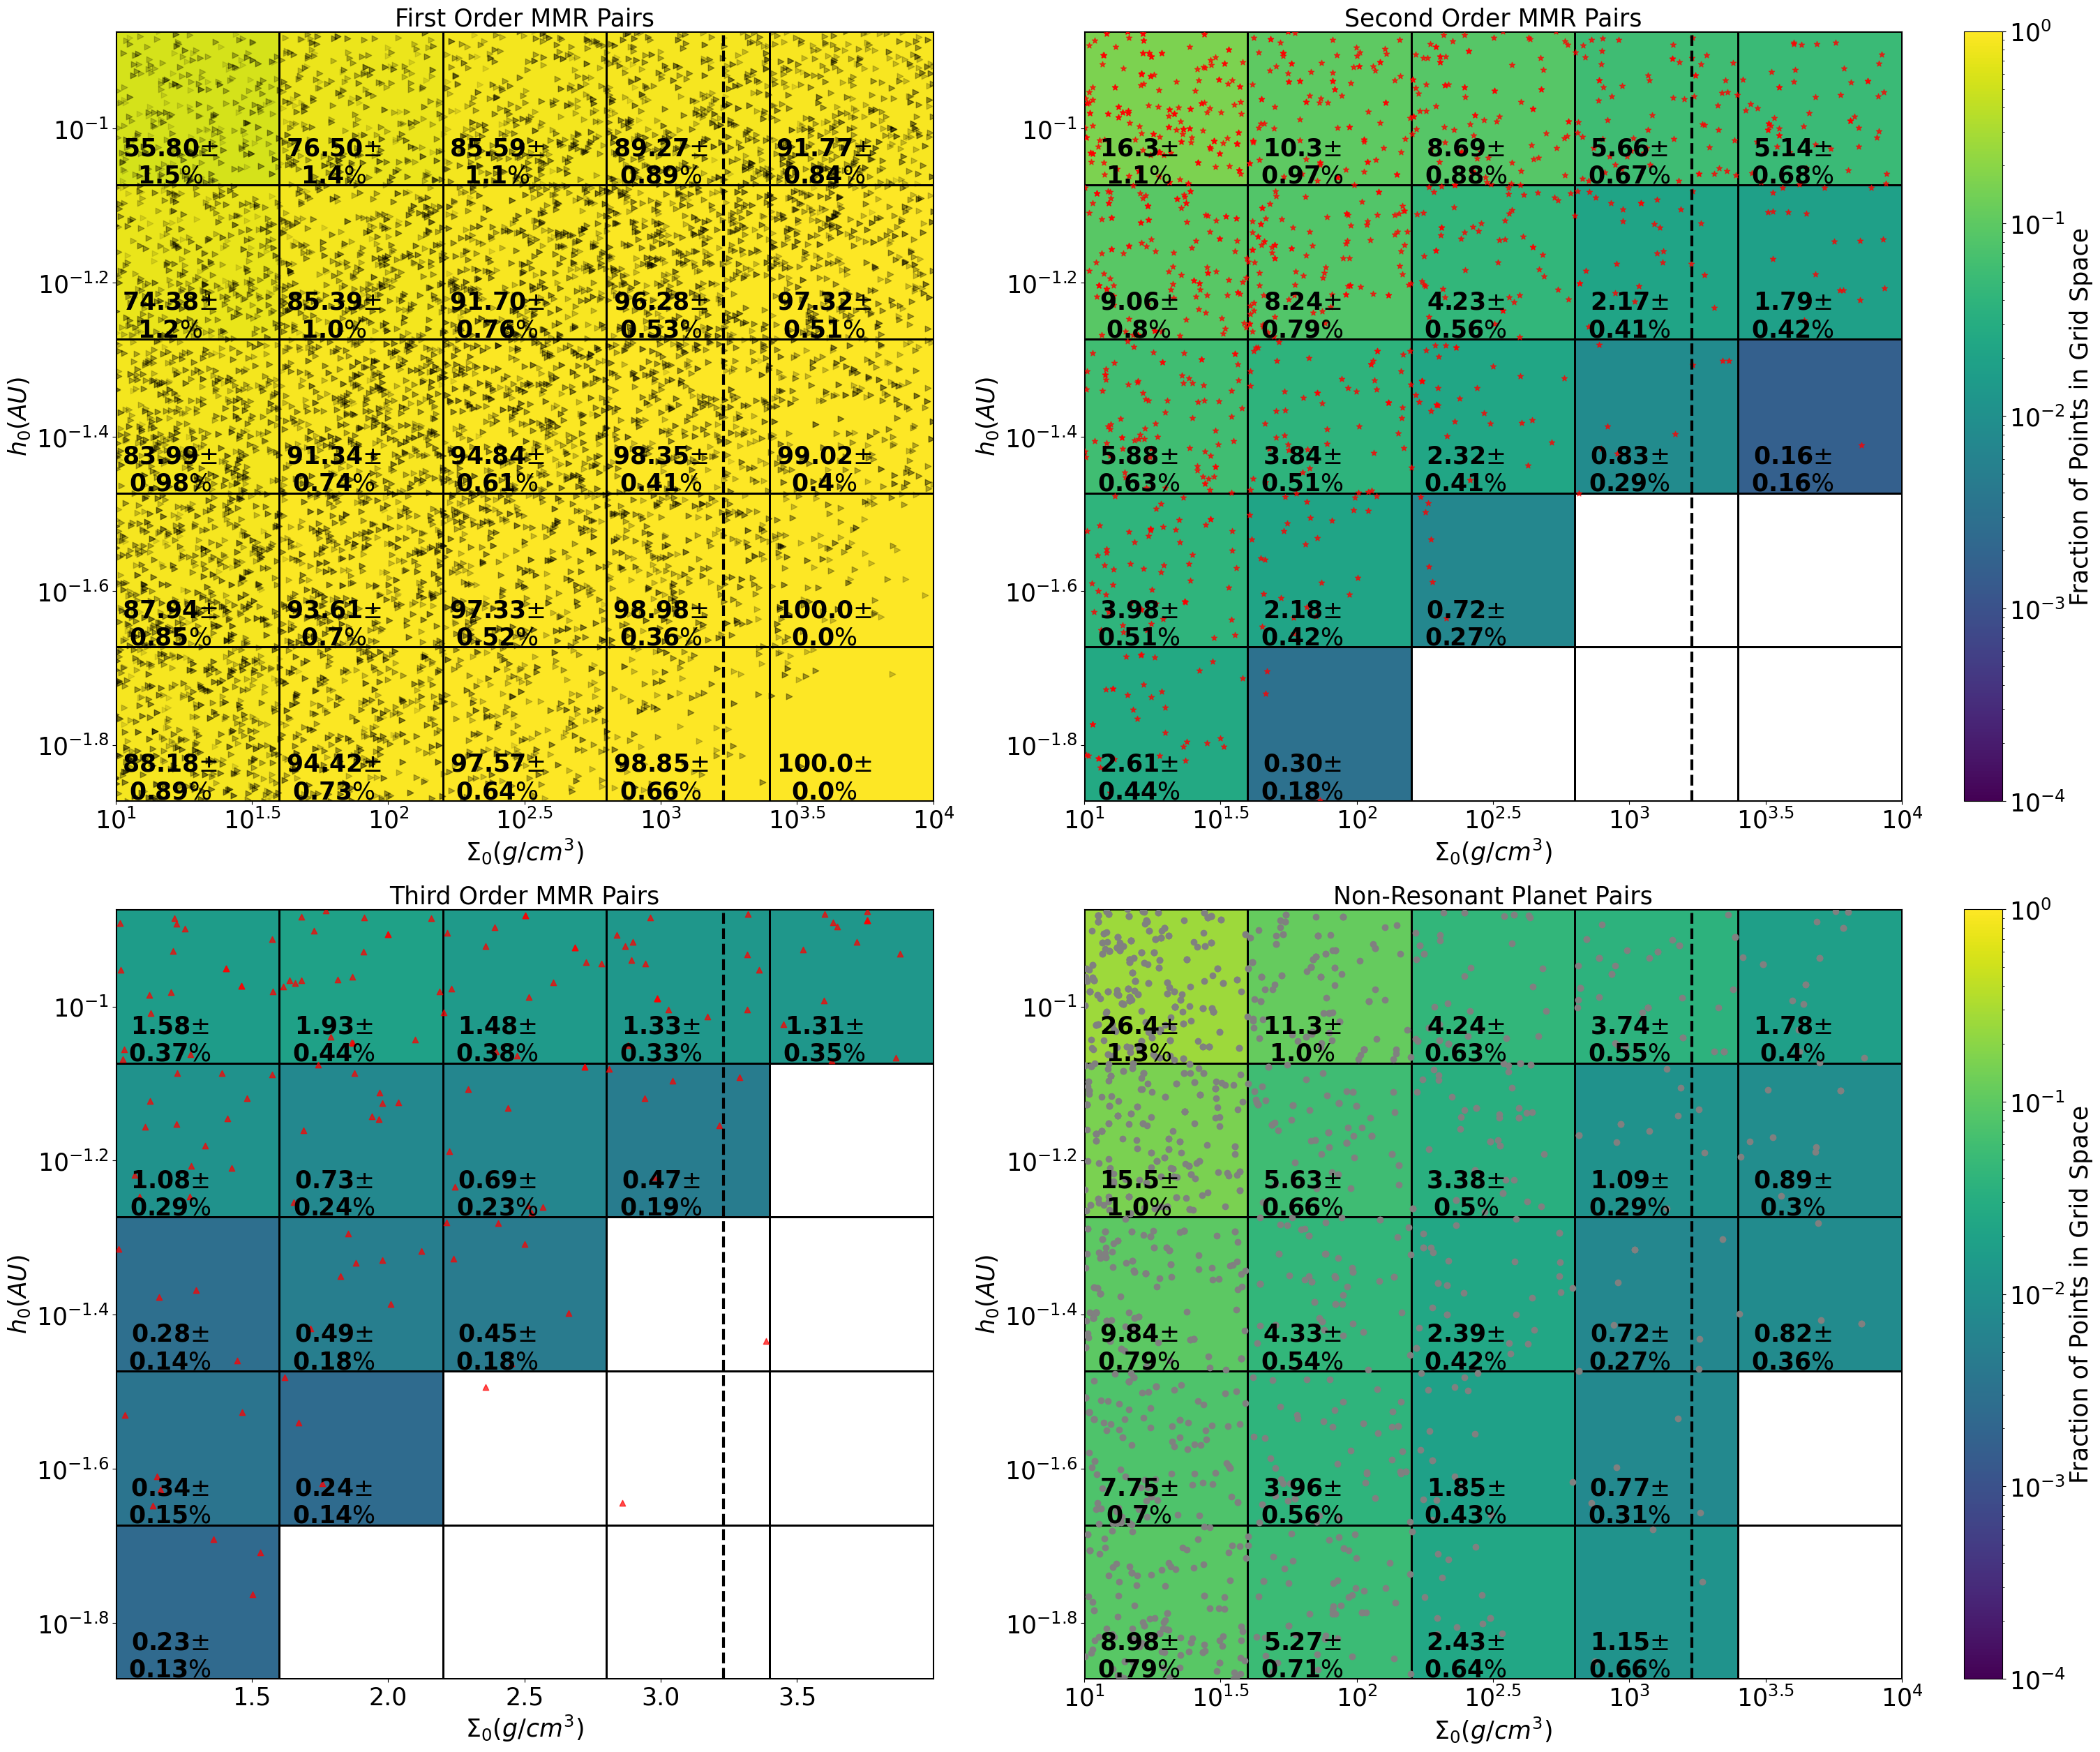

In [ ]:
# We must transpose our H matrices (see https://stackoverflow.com/questions/47403683/plot-2d-histogram-data-with-pcolormesh).
# Note: non-resonant here means the pair is not in resonance, not that the entire system is not.
# Note: we call to third order and ssecond order systems to rerun, which are defined further down in this notebook.
fig, ax = plt.subplots(2, 2, figsize = (30, 25), layout='constrained')
pc = ax[0,0].pcolormesh(Sigmah_xedges_first, Sigmah_yedges_first, Sigmah_H_occurances_first.T, vmin = vmin, vmax = vmax, norm = 'log', edgecolors = 'black', cmap = 'viridis')
ax[0,0].scatter(np.log10(first_order_Sigmas), np.log10(first_order_hs), marker = '>', c = 'black', alpha = 0.1)
ax[0,0].axvline(np.log10(1700), ls = '--', c = 'black', lw = 3, zorder = 1)
ax[0,0].set_xlabel(r"$\Sigma_0 (g/cm^3)$", fontsize = 25)
ax[0,0].set_ylabel(r"$h_0 (AU)$", fontsize = 25)
ax[0,0].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], [r"$10^{1}$", r"$10^{1.5}$", r"$10^{2}$", r"$10^{2.5}$", r"$10^{3}$", r"$10^{3.5}$", r"$10^{4}$"])
ax[0,0].set_yticks([-1.8, -1.6, -1.4, -1.2, -1], [r"$10^{-1.8}$", r"$10^{-1.6}$", r"$10^{-1.4}$", r"$10^{-1.2}$", r"$10^{-1}$"])
ax[0,0].tick_params(axis='both', which='major', labelsize = 25)
ax[0,0].tick_params(axis='both', which='minor', labelsize = 25)
ax[0,0].set_title("First Order MMR Pairs", fontsize = 25)
pc = ax[0,1].pcolormesh(Sigmah_xedges_second, Sigmah_yedges_second, Sigmah_H_occurances_second.T, vmin = vmin, vmax = vmax, norm = 'log', edgecolors = 'black', cmap = 'viridis')
# After struggling through a lot of stack overflow, I got help labeling my colormesh from ChatGPT https://chatgpt.com/c/66faa65b-97e0-8005-bc6f-f91466c00513
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize = 25)
cbar.set_label('Fraction of Points in Grid Space', fontsize = 25)
ax[0,1].scatter(np.log10(second_order_Sigmas), np.log10(second_order_hs), marker = '*', c = "red", alpha = 0.7)
# add a big blue star where our example second order system is
#ax[0,1].scatter(np.log10(second_order_resonant_chains_2.iloc[160]['Sigma']), np.log10(second_order_resonant_chains_2.iloc[160]['h']), marker = '*', c = "blue", alpha = 0.4, s = 30**2)
ax[0,1].axvline(np.log10(1700), ls = '--', c = 'black', lw = 3, zorder = 1)
ax[0,1].set_xlabel(r"$\Sigma_0 (g/cm^3)$", fontsize = 25)
ax[0,1].set_ylabel(r"$h_0 (AU)$", fontsize = 25)
ax[0,1].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], [r"$10^{1}$", r"$10^{1.5}$", r"$10^{2}$", r"$10^{2.5}$", r"$10^{3}$", r"$10^{3.5}$", r"$10^{4}$"])
ax[0,1].set_yticks([-1.8, -1.6, -1.4, -1.2, -1], [r"$10^{-1.8}$", r"$10^{-1.6}$", r"$10^{-1.4}$", r"$10^{-1.2}$", r"$10^{-1}$"])
ax[0,1].tick_params(axis='both', which='major', labelsize = 25)
ax[0,1].tick_params(axis='both', which='minor', labelsize = 25)
ax[0,1].set_title("Second Order MMR Pairs", fontsize = 25)
pc = ax[1,0].pcolormesh(Sigmah_xedges_third, Sigmah_yedges_third, Sigmah_H_occurances_third.T, vmin = vmin, vmax = vmax, norm = 'log', edgecolors = 'black', cmap = 'viridis')
# add a big blue star where our example third order system is
ax[1,0].scatter(np.log10(third_order_Sigmas), np.log10(third_order_hs), marker = '^', c = "red", alpha = 0.7)
ax[1,0].axvline(np.log10(1700), ls = '--', c = 'black', lw = 3, zorder = 1)
#ax[1,0].scatter(np.log10(third_order_resonant_chains_2.iloc[46]['Sigma']), np.log10(third_order_resonant_chains_2.iloc[46]['h']), marker = '^', c = "blue", alpha = 0.4, s = 30**2)
ax[1,0].set_xlabel(r"$\Sigma_0 (g/cm^3)$", fontsize = 25)
ax[1,0].set_ylabel(r"$h_0 (AU)$", fontsize = 25)
ax[1,1].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], [r"$10^{1}$", r"$10^{1.5}$", r"$10^{2}$", r"$10^{2.5}$", r"$10^{3}$", r"$10^{3.5}$", r"$10^{4}$"])
ax[1,0].set_yticks([-1.8, -1.6, -1.4, -1.2, -1], [r"$10^{-1.8}$", r"$10^{-1.6}$", r"$10^{-1.4}$", r"$10^{-1.2}$", r"$10^{-1}$"])
ax[1,0].tick_params(axis='both', which='major', labelsize = 25)
ax[1,0].tick_params(axis='both', which='minor', labelsize = 25)
ax[1,0].set_title("Third Order MMR Pairs", fontsize = 25)
pc = ax[1,1].pcolormesh(Sigmah_xedges_non, Sigmah_yedges_non, Sigmah_H_occurances_non.T, vmin = vmin, vmax = vmax, norm = 'log', edgecolors = 'black', cmap = 'viridis')
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize = 25)
cbar.set_label('Fraction of Points in Grid Space', fontsize = 25)
ax[1,1].scatter(np.log10(non_resonant_Sigmas), np.log10(non_resonant_hs), marker = 'o', c = 'grey', alpha = 1)
ax[1,1].axvline(np.log10(1700), ls = '--', c = 'black', lw = 3, zorder = 1)
ax[1,1].set_xlabel(r"$\Sigma_0 (g/cm^3)$", fontsize = 25)
ax[1,1].set_ylabel(r"$h_0 (AU)$", fontsize = 25)
# Get our ticks to look nice even though our data is logged.
ax[1,1].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], [r"$10^{1}$", r"$10^{1.5}$", r"$10^{2}$", r"$10^{2.5}$", r"$10^{3}$", r"$10^{3.5}$", r"$10^{4}$"])
ax[1,1].set_yticks([ -1.8, -1.6, -1.4, -1.2, -1], [r"$10^{-1.8}$", r"$10^{-1.6}$", r"$10^{-1.4}$", r"$10^{-1.2}$", r"$10^{-1}$"])
ax[1,1].tick_params(axis='both', which='major', labelsize = 25)
ax[1,1].tick_params(axis='both', which='minor', labelsize = 25)
ax[1,1].set_title("Non-Resonant Planet Pairs", fontsize = 25)
# Let's label our sections.
# The sig_figs function doesn't like 0s, so we need to specify situations where the fraction is 0 or 1 (resulting in an error of 0).
for i in range(len(Sigmah_xedges)-1):
    for j in range(len(Sigmah_yedges)-1):
        if Sigmah_H_occurances_first[i, j] == 1:
            ax[0,0].text(Sigmah_xedges_first[i+1]-0.4, Sigmah_yedges_first[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_first[i, j]*100, sigfigs))+r"$\pm$"+"\n"+str(uncertainty(Sigmah_H_first[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25) 
        elif Sigmah_H_occurances_first[i, j] >= 0.15:
            ax[0,0].text(Sigmah_xedges_first[i+1]-0.4, Sigmah_yedges_first[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_first[i, j]*100, sigfigs))+r"$\pm$"+"\n"+str(sig_figs(uncertainty(Sigmah_H_first[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'), sigfigs_uncert))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25) 
        if Sigmah_H_occurances_second[i, j] >= 0.0015:
            if Sigmah_H_occurances_second[i, j] >= 0.01:
                ax[0,1].text(Sigmah_xedges_second[i+1]-0.4, Sigmah_yedges_second[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_second[i, j]*100, sigfigs-1))+r"$\pm$"+"\n"+str(sig_figs(uncertainty(Sigmah_H_second[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'), sigfigs_uncert))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25)
            else: 
                ax[0,1].text(Sigmah_xedges_second[i+1]-0.4, Sigmah_yedges_second[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_second[i, j]*100, sigfigs-2))+r"$\pm$"+"\n"+str(sig_figs(uncertainty(Sigmah_H_second[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'), sigfigs_uncert))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25)
        if Sigmah_H_occurances_third[i, j] >= 0.0015:
            if Sigmah_H_occurances_third[i, j] >= 0.01:
                ax[1,0].text(Sigmah_xedges_third[i+1]-0.4,Sigmah_yedges_third[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_third[i, j]*100, sigfigs-1))+r"$\pm$"+"\n"+str(sig_figs(uncertainty(Sigmah_H_third[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'), sigfigs_uncert))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25) 
            else:
                ax[1,0].text(Sigmah_xedges_third[i+1]-0.4,Sigmah_yedges_third[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_third[i, j]*100, sigfigs-2))+r"$\pm$"+"\n"+str(sig_figs(uncertainty(Sigmah_H_third[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'), sigfigs_uncert))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25) 
        if Sigmah_H_occurances_non[i, j] >= 0.0015:
            if Sigmah_H_occurances_non[i, j] >= 0.01:
                ax[1,1].text(Sigmah_xedges_non[i+1]-0.4, Sigmah_yedges_non[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_non[i, j]*100, sigfigs-1))+r"$\pm$"+"\n"+str(sig_figs(uncertainty(Sigmah_H_non[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'), sigfigs_uncert))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25) # As we're using LaTeX, we cannot bold in the typical manner and must use LaTeX syntax: https://stackoverflow.com/questions/36162414/how-to-add-bold-annotated-text-to-a-plot
            else: 
                ax[1,1].text(Sigmah_xedges_non[i+1]-0.4, Sigmah_yedges_non[j]+0.03, str(CHAT_sig_figs(Sigmah_H_occurances_non[i, j]*100, sigfigs-2))+r"$\pm$"+"\n"+str(sig_figs(uncertainty(Sigmah_H_non[i, j], Sigmah_H_first[i, j]+Sigmah_H_second[i, j]+Sigmah_H_third[i, j]+Sigmah_H_non[i, j], report_type = 'Percent'), sigfigs_uncert))+r"$\%$", weight = 'bold', ha='center', va='center', c = 'black', fontsize = 25) # As we're using LaTeX, we cannot bold in the typical manner and must use LaTeX syntax: https://stackoverflow.com/questions/36162414/how-to-add-bold-annotated-text-to-a-plot
        
fig.savefig("output_plots/Sigma_H.png", bbox_inches = 'tight')
plt.show()

# Section 6: Higher Order MMR Capture is Insensitive to the Initial Period Ratio
* In this section, we include Figure 9, the CDFs of initial period ratios across different orders of MMR. 
* We also include KS tests for the initial period ratios.
* Finally, we include information on the number of MMRs that start near and end in the same resonance as well as those that start near first order and end up in a higher order resonance. 

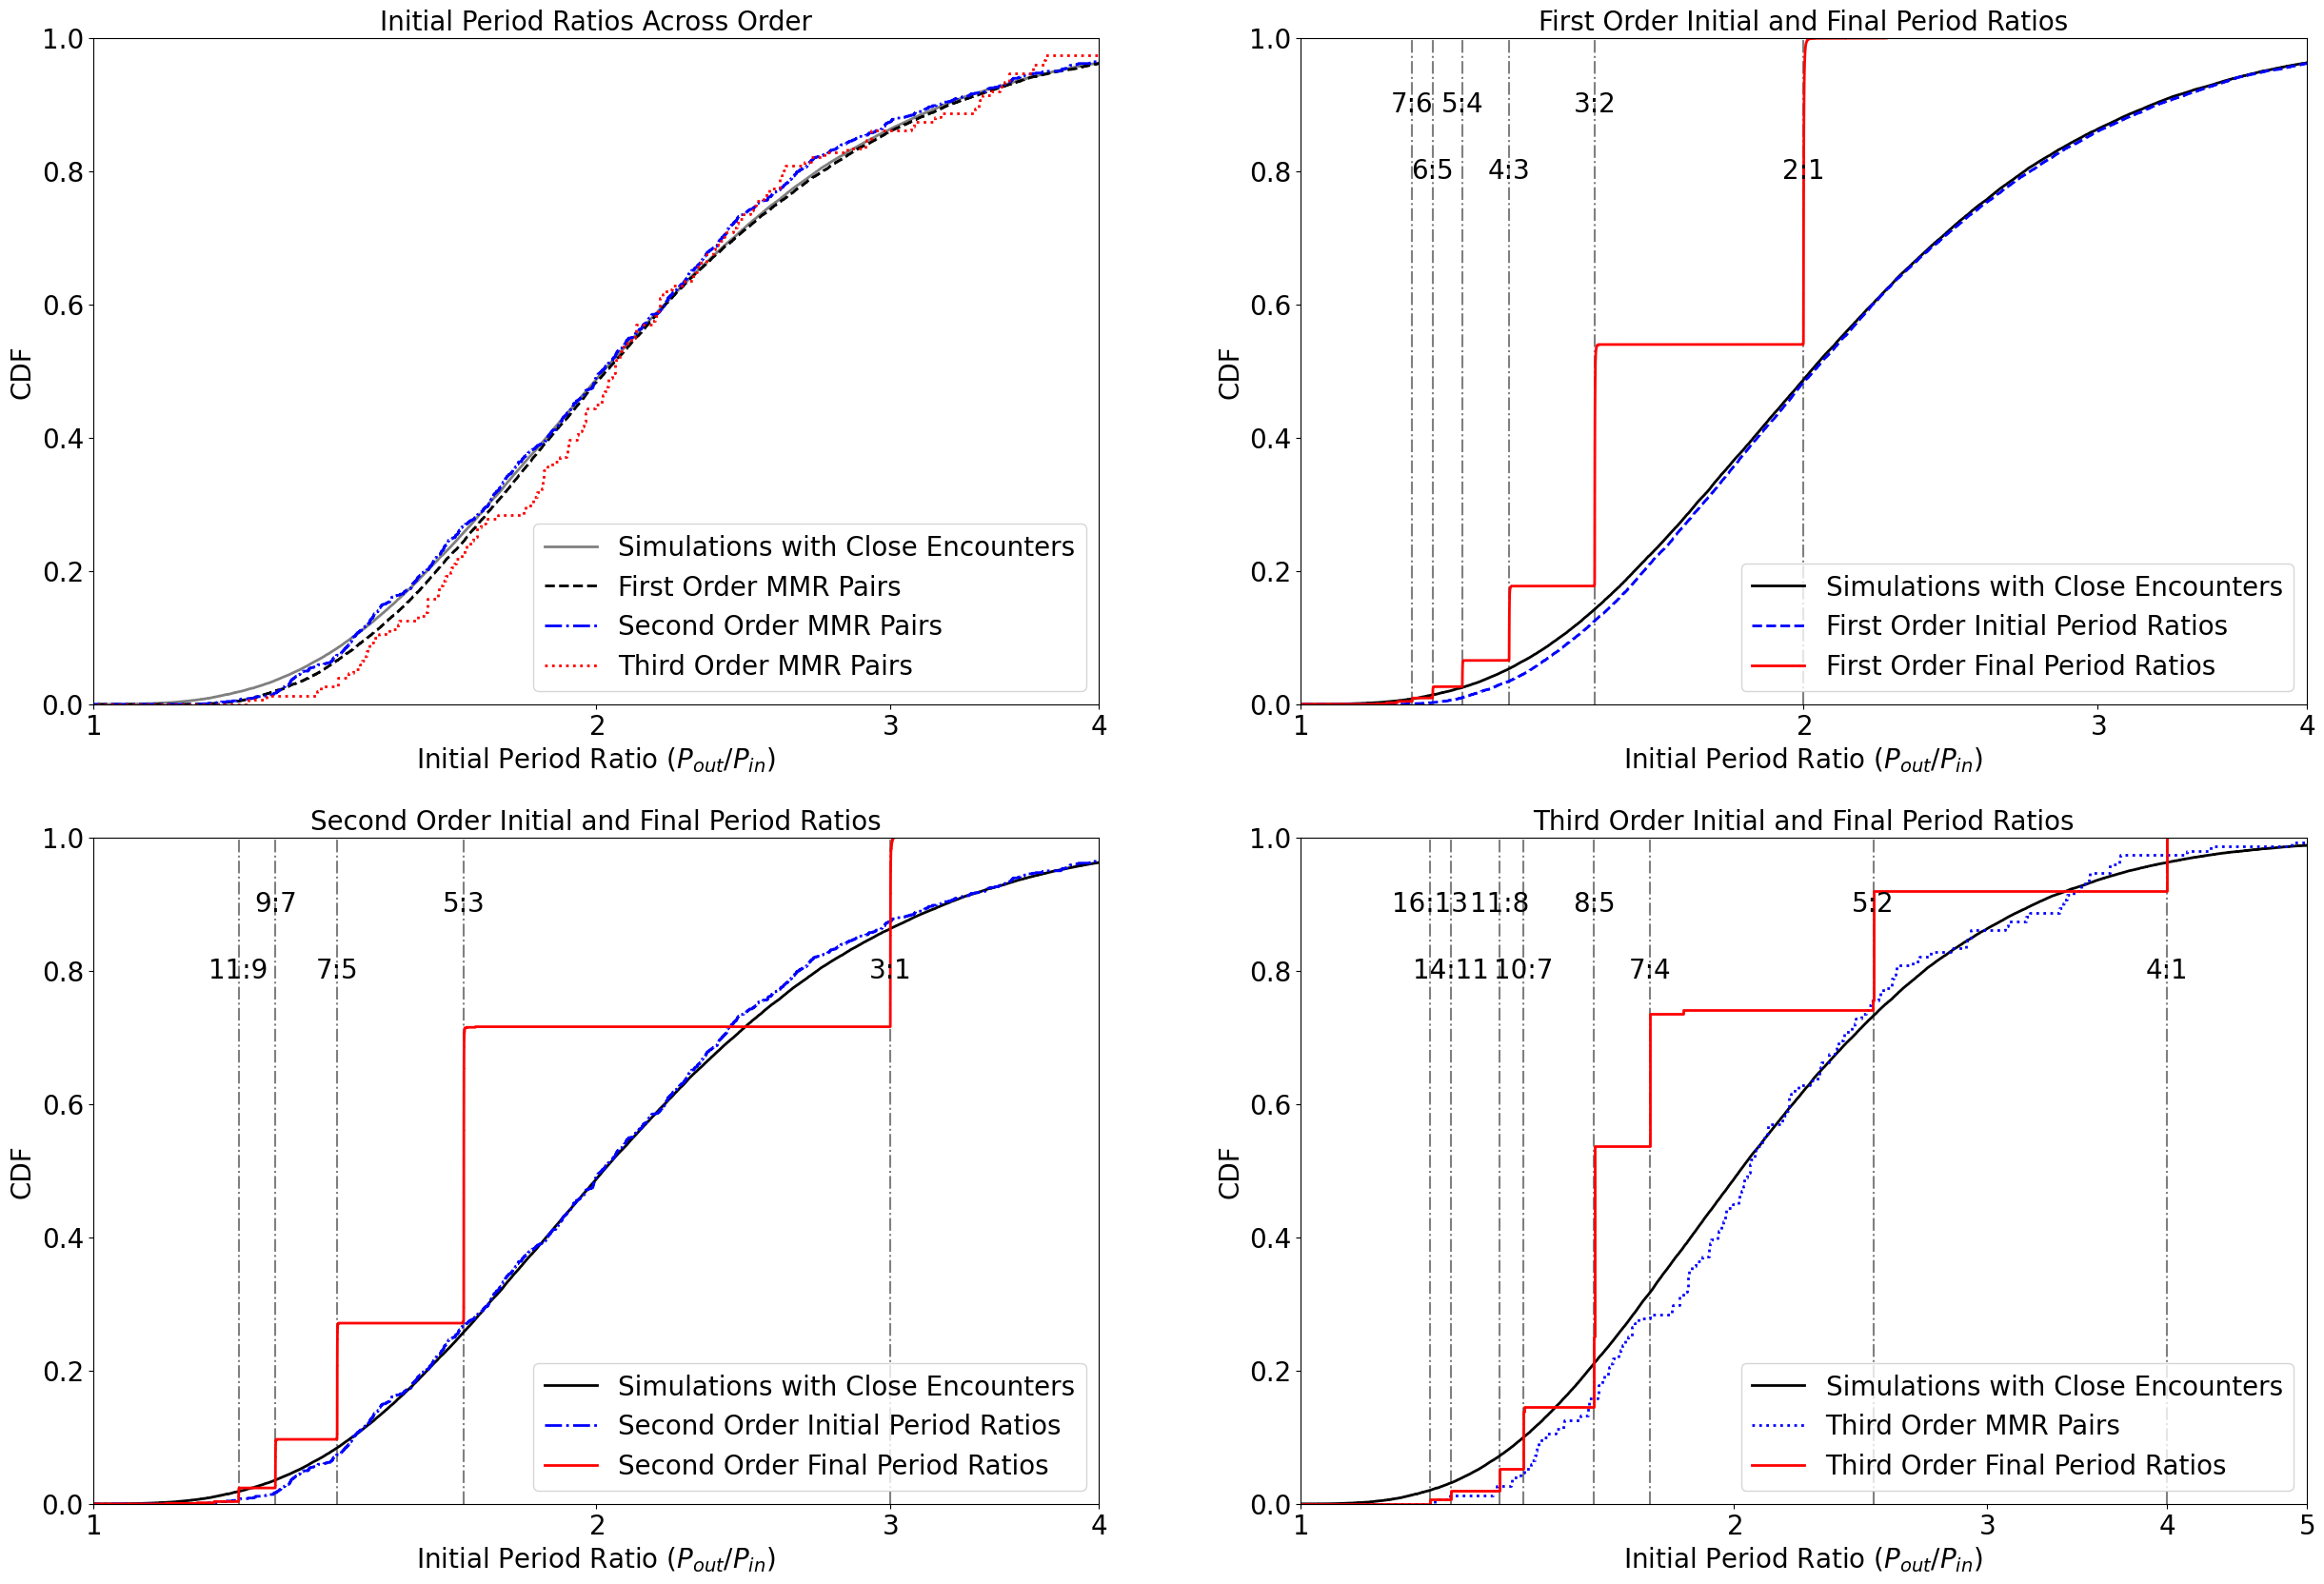

In [ ]:
failed_initial_period_ratios = np.transpose(np.vstack([failed_sims["p_i_01"].to_numpy(), failed_sims["p_i_12"].to_numpy(), failed_sims["p_i_23"].to_numpy(), failed_sims["p_i_34"].to_numpy(), failed_sims["p_i_45"].to_numpy(), failed_sims["p_i_56"].to_numpy()])).ravel()

fig, ax = plt.subplots(2, 2, figsize = (30, 20))
fig.subplots_adjust(hspace = 0.2)


sns.ecdfplot(failed_initial_period_ratios, ax = ax[0,0], log_scale = True, ls = 'solid', label = "Simulations with Close Encounters", c = 'grey', lw = 2)
sns.ecdfplot(first_order_initial_period_ratios, ax = ax[0,0], ls = 'dashed', log_scale = True,  label = "First Order MMR Pairs", c = 'black', lw = 2)
sns.ecdfplot(second_order_initial_period_ratios, ax = ax[0,0], ls = 'dashdot', log_scale = True,  label = "Second Order MMR Pairs", c = 'blue', lw = 2)
sns.ecdfplot(third_order_initial_period_ratios, ax = ax[0,0], ls = 'dotted', log_scale = True, label = "Third Order MMR Pairs", c = 'red', lw = 2)
ax[0,0].set_title("Initial Period Ratios Across Order", fontsize = 20)
ax[0,0].set_xlim(1,4)
ax[0,0].set_xticks([1, 2, 3, 4], ['$1$', '$2$', '$3$', '$4$'])
ax[0,0].set_ylabel("CDF", fontsize = 20)
ax[0,0].set_xlabel(r"Initial Period Ratio ($P_{out}/P_{in}$)", fontsize = 20)
ax[0,0].legend(loc = 'lower right', fontsize = 20)
ax[0,0].tick_params(axis='both', which='major', labelsize = 20)
ax[0,0].tick_params(axis='both', which='minor', labelsize = 20)


sns.ecdfplot(failed_initial_period_ratios, ax = ax[0,1], log_scale = True, ls = 'solid', label = "Simulations with Close Encounters", c = 'black', lw = 2)
sns.ecdfplot(first_order_initial_period_ratios, ax = ax[0,1], ls = 'dashed', log_scale = True,  label = "First Order Initial Period Ratios", c = 'blue', lw = 2)
sns.ecdfplot(first_order_final_period_ratios, ax = ax[0,1], log_scale = True, ls = 'solid', label = "First Order Final Period Ratios", c = 'red', lw = 2)
counter = 0
for res in fractional_first_order_resonances_unique:
    if counter % 2 == 0:
        up = 0.1
    else:
        up = 0
    counter+=1
    # Don't plot ones that we have too small concentrations of.
    if res.numerator/res.denominator<=8/7:
        continue
    else:
        ax[0,1].axvline(res, color = "grey", ls = 'dashdot', zorder = 1)
        ax[0,1].text(res, 0.8+up, str(res.numerator)+":"+str(res.denominator), horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20, zorder = 4)
ax[0,1].set_title("First Order Initial and Final Period Ratios", fontsize = 20)
ax[0,1].set_xlim(1,4)
ax[0,1].set_xticks([1, 2, 3, 4], ['$1$', '$2$', '$3$', '$4$'])
ax[0,1].set_ylabel("CDF", fontsize = 20)
ax[0,1].set_xlabel(r"Initial Period Ratio ($P_{out}/P_{in}$)", fontsize = 20)
ax[0,1].legend(loc = 'lower right', fontsize = 20)
ax[0,1].tick_params(axis='both', which='major', labelsize = 20)
ax[0,1].tick_params(axis='both', which='minor', labelsize = 20)

sns.ecdfplot(failed_initial_period_ratios, ax = ax[1,0], log_scale = True, ls = 'solid', label = "Simulations with Close Encounters", c = 'black', lw = 2)
sns.ecdfplot(second_order_initial_period_ratios, ax = ax[1,0], ls = 'dashdot', log_scale = True,  label = "Second Order Initial Period Ratios", c = 'blue', lw = 2)
sns.ecdfplot(second_order_final_period_ratios, ax = ax[1,0], log_scale = True, ls = 'solid', label = "Second Order Final Period Ratios", c = 'red', lw = 2)
for res in fractional_second_order_resonances_unique:
    if counter % 2 == 0:
        up = 0.1
    else:
        up = 0
    counter+=1
    # Don't plot ones that we have too small concentrations of.
    if res.numerator/res.denominator<=13/11:
        continue
    else:
        ax[1,0].axvline(res, color = "grey", ls = 'dashdot', zorder = 1) #label = str(res.numerator)+":"+str(res.denominator), zorder = 1)
        ax[1,0].text(res, 0.8+up, str(res.numerator)+":"+str(res.denominator), horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20, zorder = 4)
ax[1,0].set_title("Second Order Initial and Final Period Ratios", fontsize = 20)
ax[1,0].set_xlim(1,4)
ax[1,0].set_xticks([1, 2, 3, 4], ['$1$', '$2$', '$3$', '$4$'])
ax[1,0].set_ylabel("CDF", fontsize = 20)
ax[1,0].set_xlabel(r"Initial Period Ratio ($P_{out}/P_{in}$)", fontsize = 20)
ax[1,0].legend(loc = 'lower right', fontsize = 20)
ax[1,0].tick_params(axis='both', which='major', labelsize = 20)
ax[1,0].tick_params(axis='both', which='minor', labelsize = 20)

sns.ecdfplot(failed_initial_period_ratios, ax = ax[1,1], log_scale = True, ls = 'solid', label = "Simulations with Close Encounters", c = 'black', lw = 2)
sns.ecdfplot(third_order_initial_period_ratios, ax = ax[1,1], ls = 'dotted', log_scale = True, label = "Third Order MMR Pairs", c = 'blue', lw = 2)
sns.ecdfplot(third_order_final_period_ratios, ax = ax[1,1], log_scale = True, ls = 'solid', label = "Third Order Final Period Ratios", c = 'red', lw = 2)
for res in fractional_third_order_resonances_unique:
    if counter % 2 == 0:
        up = 0.1
    else:
        up = 0
    counter+=1
    # Don't plot ones that we have too small concentrations of.
    if res.numerator/res.denominator<=17/14:
        continue
    else:
        ax[1,1].axvline(res, color = "grey", ls = 'dashdot', zorder = 1)
        ax[1,1].text(res, 0.8+up, str(res.numerator)+":"+str(res.denominator), horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20, zorder = 4)
ax[1,1].set_title("Third Order Initial and Final Period Ratios", fontsize = 20)
ax[1,1].set_xlim(1,4)
ax[1,1].set_xticks([1, 2, 3, 4, 5], ['$1$', '$2$', '$3$', '$4$', '$5$'])
ax[1,1].set_ylabel("CDF", fontsize = 20)
ax[1,1].set_xlabel(r"Initial Period Ratio ($P_{out}/P_{in}$)", fontsize = 20)
ax[1,1].legend(loc = 'lower right', fontsize = 20)
ax[1,1].tick_params(axis='both', which='major', labelsize = 20)
ax[1,1].tick_params(axis='both', which='minor', labelsize = 20)

fig.savefig('output_plots/period_ratio_cdfs.png', bbox_inches = 'tight')
plt.show()
# Close cnounter have more with small period ratio
# Small bumps at second and third order probably because initialized there. Have to start near final period at smallest one.

In [ ]:
initial_period_ratio_arrays = [failed_initial_period_ratios, partial_initial_period_ratios.ravel(), first_order_initial_period_ratios, second_order_initial_period_ratios, third_order_initial_period_ratios]
initial_period_ratio_array_labels = ['Initial Period Ratios of Failed Planet Pairs', 'Initial Ratios for Planet Pairs in Partial Resonant Chains', 'Initial Period Ratios of First Order MMR Planet Pairs', 'Initial Period Ratios of Second Order MMR Planet Pairs', 'Initial Period Ratios of Third Order MMR Planet Pairs']
assert len(initial_period_ratio_arrays) == len(initial_period_ratio_arrays)
for idx1, idx2 in combinations(range(0,5), 2):
    statistical_result = stats.ks_2samp(initial_period_ratio_arrays[idx1], initial_period_ratio_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(initial_period_ratio_array_labels[idx1])+" and "+str(initial_period_ratio_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(initial_period_ratio_array_labels[idx1])+" and "+str(initial_period_ratio_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(initial_period_ratio_array_labels[idx1])+" and "+str(initial_period_ratio_array_labels[idx2])+" are drawn from the same distribution.")

P value of kstest betweeen Initial Period Ratios of Failed Planet Pairs and Initial Ratios for Planet Pairs in Partial Resonant Chains: 4.0772575207911736e-11
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that Initial Period Ratios of Failed Planet Pairs and Initial Ratios for Planet Pairs in Partial Resonant Chains may be drawn from different distributions.
P value of kstest betweeen Initial Period Ratios of Failed Planet Pairs and Initial Period Ratios of First Order MMR Planet Pairs: 1.3406e-319
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that Initial Period Ratios of Failed Planet Pairs and Initial Period Ratios of First Order MMR Planet Pairs may be drawn from different distributions.
P value of kstest betweeen Initial Period Ratios of Failed Planet Pairs and Initial Period Ratios of Second Order MMR Planet Pairs: 3.1037442403026326e-43
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that Initia

In [ ]:
# Let's make a nice dictionary. 
first_order_dict = {}
for row in range(len(first_order_initial_period_ratios)):
    first_order_dict[first_order_initial_period_ratios[row]] = first_order_resonances[row]
second_order_dict = {}
for row in range(len(second_order_initial_period_ratios)):
    second_order_dict[second_order_initial_period_ratios[row]] = second_order_resonances[row]

third_order_dict = {}
for row in range(len(third_order_initial_period_ratios)):
    third_order_dict[third_order_initial_period_ratios[row]] = third_order_resonances[row]

# Let's see number of each resonance that start near a second order and end near the same MMR
prox_first_order_initial_period_ratios_2 = []
prox_first_order_initial_mmr_2 = []
prox_second_order_initial_period_ratios_2 = []
prox_second_order_initial_mmr_2 = []
prox_third_order_initial_period_ratios_2 = []
prox_third_order_initial_mmr_2 = []

lower_bound_first_order_initial_period_ratios = first_order_initial_period_ratios*0.98
upper_bound_first_order_initial_period_ratios = first_order_initial_period_ratios*1.02
lower_bound_second_order_initial_period_ratios = second_order_initial_period_ratios*0.98
upper_bound_second_order_initial_period_ratios = second_order_initial_period_ratios*1.02
lower_bound_third_order_initial_period_ratios = third_order_initial_period_ratios*0.98
upper_bound_third_order_initial_period_ratios = third_order_initial_period_ratios*1.02


for idx, key in enumerate(first_order_dict.keys()):
    prox_res_idx = np.argmin(np.abs(first_order_resonances-first_order_initial_period_ratios[idx]))
    prox_res = first_order_resonances[prox_res_idx]
    if lower_bound_first_order_initial_period_ratios[idx] <= prox_res  and prox_res <= upper_bound_first_order_initial_period_ratios[idx]:
        if prox_res == first_order_dict[key]:
            prox_first_order_initial_period_ratios_2.append(first_order_initial_period_ratios[idx])
            prox_first_order_initial_mmr_2.append(prox_res)

for idx, key in enumerate(second_order_dict.keys()):
    prox_res_idx = np.argmin(np.abs(second_order_resonances-second_order_initial_period_ratios[idx]))
    prox_res = second_order_resonances[prox_res_idx]
    if lower_bound_second_order_initial_period_ratios[idx] <= prox_res  and prox_res <= upper_bound_second_order_initial_period_ratios[idx]:
        if prox_res == second_order_dict[key]:
            prox_second_order_initial_period_ratios_2.append(second_order_initial_period_ratios[idx])
            prox_second_order_initial_mmr_2.append(prox_res)

for idx, key in enumerate(third_order_dict.keys()):
    prox_res_idx = np.argmin(np.abs(third_order_resonances-third_order_initial_period_ratios[idx]))
    prox_res = third_order_resonances[prox_res_idx]
    if lower_bound_third_order_initial_period_ratios[idx] <= prox_res  and prox_res <= upper_bound_third_order_initial_period_ratios[idx]:
        if prox_res == third_order_dict[key]:
            prox_third_order_initial_period_ratios_2.append(third_order_initial_period_ratios[idx])
            prox_third_order_initial_mmr_2.append(prox_res)

# Assert statements don't work as these are now the resonances present in the simulations not all the possible ones.
#assert np.isin(np.array(prox_first_order_initial_mmr_2).all(), np.unique(first_order_resonances))
#assert np.isin(np.array(prox_second_order_initial_mmr_2).all(), np.unique(second_order_resonances))
#assert np.isin(np.array(prox_third_order_initial_mmr_2).all(), np.unique(third_order_resonances))

unique_prox_first_order_initial_mmr_2, prox_first_order_initial_mmr_counts_2 = np.unique(prox_first_order_initial_mmr_2, return_counts = True)
unique_prox_second_order_initial_mmr_2, prox_second_order_initial_mmr_counts_2 = np.unique(prox_second_order_initial_mmr_2, return_counts = True)
unique_prox_third_order_initial_mmr_2, prox_third_order_initial_mmr_counts_2 = np.unique(prox_third_order_initial_mmr_2, return_counts = True)
first_order_initial_mmr_total_2 = np.sum(prox_first_order_initial_mmr_counts_2)
second_order_initial_mmr_total_2 = np.sum(prox_second_order_initial_mmr_counts_2)
third_order_initial_mmr_total_2 = np.sum(prox_third_order_initial_mmr_counts_2)
first_order_initial_uncertainties_2 = uncertainty(prox_first_order_initial_mmr_counts_2, len(prox_first_order_initial_mmr_2), report_type = 'Fraction')
second_order_initial_uncertainties_2 = uncertainty(prox_second_order_initial_mmr_counts_2, len(prox_second_order_initial_mmr_2), report_type = 'Fraction')
third_order_initial_uncertainties_2 = uncertainty(prox_third_order_initial_mmr_counts_2, len(prox_third_order_initial_mmr_2), report_type = 'Fraction')

In [ ]:
# Let's next consider the number of systems that start near resonance and also end near resonance, not just the overall distribution that starts near resonance.
print("Number of planet pairs that begin near a first order MMR that also end near the same first order MMR: "+str(len(prox_first_order_initial_period_ratios_2)))
print("Number of planet pairs that end up in first order MMRs: "+str(len(first_order_resonances)))
print("Percentage of planet pairs that begin near a first order MMR that also end near a first order MMR relative to the total number of first order MMRs: "+str(len(prox_first_order_initial_period_ratios_2)/len(first_order_resonances)*100))
#print(len(prox_second_order_initial_period_ratios_2))
# It is interesting to note that the number of planet pairs that end up near a second order MMR is smaller than the number that start near one.
print("Number of planet pairs that begin near a second order MMR that also end near the same second order MMR: "+str(len(prox_second_order_initial_period_ratios_2)))
print("Number of planet pairs that end up in second order MMRs: "+str(len(second_order_resonances)))
print("Percentage of planet pairs that begin near a second order MMR that also end near a second order MMR relative to the total number of second order MMRs: "+str(len(prox_second_order_initial_period_ratios_2)/len(second_order_resonances)*100))

print("Number of planet pairs that begin near a third order MMR that also end near the same third order MMR: "+str(len(prox_third_order_initial_period_ratios_2)))
print("Number of planet pairs that end up in third order MMRs: "+str(len(third_order_resonances)))
print("Percentage of planet pairs that begin near a third order MMR that also end near a third order MMR relative to the total number of third order MMRs: "+str(len(prox_third_order_initial_period_ratios_2)/len(third_order_resonances)*100))

# Double check: all of these planet pairs should be in both datasets.
test_count = 0
for res in prox_first_order_initial_period_ratios_2:
    if np.isin(res, first_order_initial_period_ratios):
        test_count+=1
assert test_count/len(prox_first_order_initial_period_ratios_2) == 1

test_count = 0
for res in prox_second_order_initial_period_ratios_2:
    if np.isin(res, second_order_initial_period_ratios):
        test_count+=1
assert test_count/len(prox_second_order_initial_period_ratios_2) == 1

test_count = 0
for res in prox_third_order_initial_period_ratios_2:
    if np.isin(res, third_order_initial_period_ratios):
        test_count+=1
assert test_count/len(prox_third_order_initial_period_ratios_2) == 1

Number of planet pairs that begin near a first order MMR that also end near the same first order MMR: 1004
Number of planet pairs that end up in first order MMRs: 22444
Percentage of planet pairs that begin near a first order MMR that also end near a first order MMR relative to the total number of first order MMRs: 4.4733559080377825
Number of planet pairs that begin near a second order MMR that also end near the same second order MMR: 43
Number of planet pairs that end up in second order MMRs: 1124
Percentage of planet pairs that begin near a second order MMR that also end near a second order MMR relative to the total number of second order MMRs: 3.8256227758007118
Number of planet pairs that begin near a third order MMR that also end near the same third order MMR: 6
Number of planet pairs that end up in third order MMRs: 151
Percentage of planet pairs that begin near a third order MMR that also end near a third order MMR relative to the total number of third order MMRs: 3.97350993377

In [ ]:
# Does seem possible that planets start near a first order MMR and end up near a higher order MMR. Probably worth reporting as it happens an order of magnitude more frequently than planets staying in same order. However, still not the dominant mechanism.
second_order_starts_near_first_order = np.array([])
second_order_starts_near_first_order_ignoring_external = np.array([]) # ignores cases where MMR ends up in 3:1

for idx, key in enumerate(second_order_dict.keys()):
    prox_res_idx = np.argmin(np.abs(first_order_resonances-second_order_initial_period_ratios[idx]))
    prox_res = first_order_resonances[prox_res_idx]
    if lower_bound_second_order_initial_period_ratios[idx] <= prox_res  and prox_res <= upper_bound_second_order_initial_period_ratios[idx]:
        second_order_starts_near_first_order = np.append(second_order_starts_near_first_order, second_order_initial_period_ratios[idx])
        if second_order_dict[key] != 3.0:
            second_order_starts_near_first_order_ignoring_external = np.append(second_order_starts_near_first_order_ignoring_external, second_order_initial_period_ratios[idx])

no_31_second_order_resonances = second_order_resonances[second_order_resonances!=3]
print("Number of planet pairs that begin near a first order MMR that end up in a second order MMR: "+str(len(second_order_starts_near_first_order)))
print("Percentage of planet pairs that begin near a first order MMR that end up in a second order MMR relative to the total number of second order MMRs: "+str(len(second_order_starts_near_first_order)/len(second_order_resonances)*100))
print("Number of planet pairs that begin near a first order MMR that end up in a second order MMR, ignoring external 3:1 MMR: "+str(len(second_order_starts_near_first_order_ignoring_external)))
print("Percentage of planet pairs that begin near a first order MMR that end up in a second order MMR relative to the total number of second order MMRs, ignoring external 3:1 MMR: "+str(len(second_order_starts_near_first_order_ignoring_external)/len(no_31_second_order_resonances)*100))

third_order_starts_near_first_order = np.array([])
third_order_starts_near_first_order_ignoring_external = np.array([]) # ignores cases where MMR ends up in 3:1

for idx, key in enumerate(third_order_dict.keys()):
    prox_res_idx = np.argmin(np.abs(first_order_resonances-third_order_initial_period_ratios[idx]))
    prox_res = first_order_resonances[prox_res_idx]
    if lower_bound_third_order_initial_period_ratios[idx] <= prox_res  and prox_res <= upper_bound_third_order_initial_period_ratios[idx]:
        third_order_starts_near_first_order = np.append(third_order_starts_near_first_order, third_order_initial_period_ratios[idx])
        if third_order_dict[key] != 2.5 and third_order_dict[key] != 4.0:
            third_order_starts_near_first_order_ignoring_external = np.append(third_order_starts_near_first_order_ignoring_external, third_order_initial_period_ratios[idx])

no_52_or_41_third_order_resonances = third_order_resonances[third_order_resonances<2.0]
print("Number of planet pairs that begin near a first order MMR that end up in a third order MMR: "+str(len(third_order_starts_near_first_order)))
print("Percentage of planet pairs that begin near a first order MMR that end up in a third order MMR relative to the total number of third order MMRs: "+str(len(third_order_starts_near_first_order)/len(third_order_resonances)*100))
print("Number of planet pairs that begin near a first order MMR that end up in a third order MMR, ignoring external 5:2 and 4:1 MMRs: "+str(len(third_order_starts_near_first_order_ignoring_external)))
print("Percentage of planet pairs that begin near a first order MMR that end up in a third order MMR relative to the total number of third order MMRs, ignoring external 5:2 and 4:1 MMRs: "+str(len(third_order_starts_near_first_order_ignoring_external)/len(no_52_or_41_third_order_resonances)*100))

Number of planet pairs that begin near a first order MMR that end up in a second order MMR: 148
Percentage of planet pairs that begin near a first order MMR that end up in a second order MMR relative to the total number of second order MMRs: 13.167259786476867
Number of planet pairs that begin near a first order MMR that end up in a second order MMR, ignoring external 3:1 MMR: 124
Percentage of planet pairs that begin near a first order MMR that end up in a second order MMR relative to the total number of second order MMRs, ignoring external 3:1 MMR: 15.403726708074533
Number of planet pairs that begin near a first order MMR that end up in a third order MMR: 19
Percentage of planet pairs that begin near a first order MMR that end up in a third order MMR relative to the total number of third order MMRs: 12.582781456953644
Number of planet pairs that begin near a first order MMR that end up in a third order MMR, ignoring external 5:2 and 4:1 MMRs: 15
Percentage of planet pairs that begin

# Section 7: Higher Order MMRs Have Smaller Libration Widths
* We include Figure 10 of eccentricity and $$\Delta# CDFs. 
* We also include relevant KS tests.
* Finally, we locate the fraction of planets engaged in each order of resonance at different positions. This code includes a visualization that is not provided in the paper.

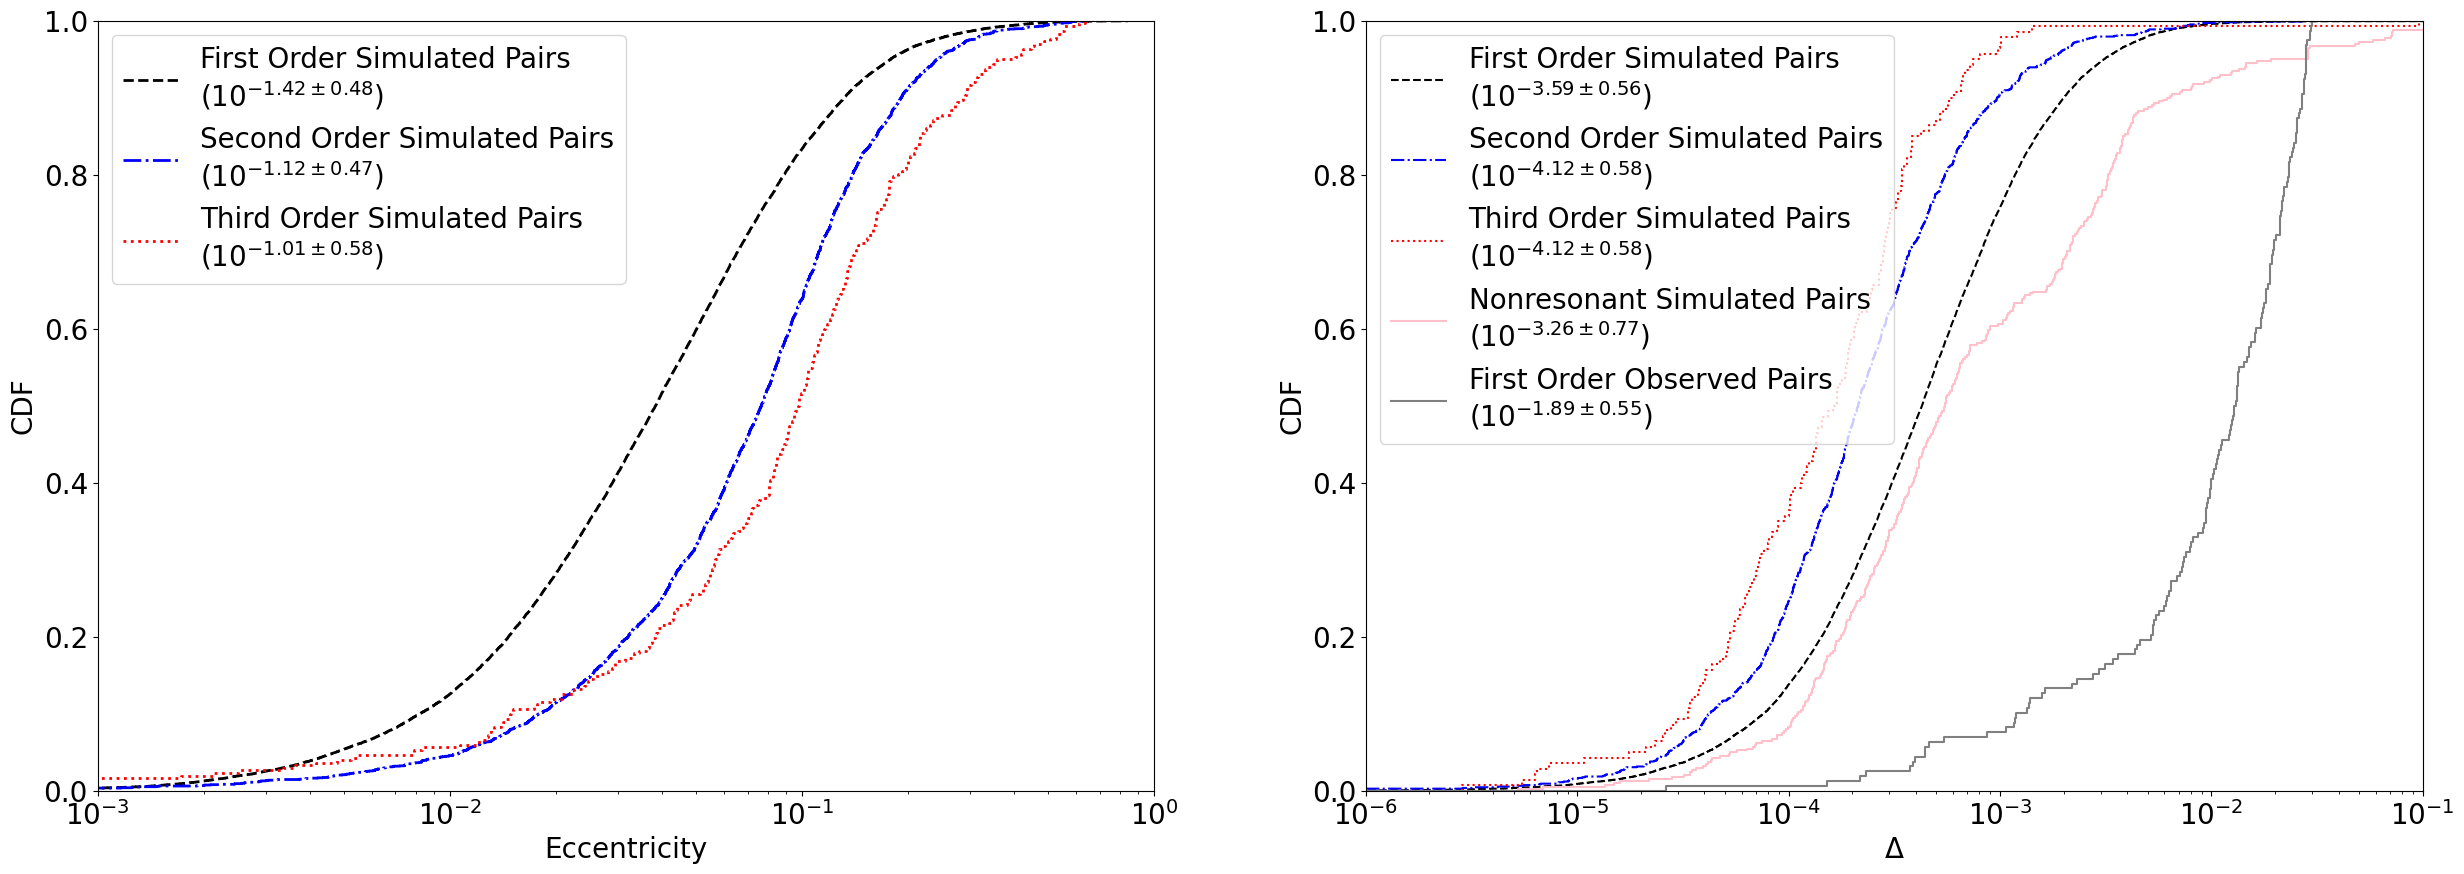

In [ ]:
# Combined Eccentricity-Delta Figure
fig, ax = plt.subplots(1, 2, figsize = (30,10))
#sns.ecdfplot(np.hstack([failed_sims['e_0'], failed_sims['e_1'], failed_sims['e_2'], failed_sims['e_3'], failed_sims['e_4'], failed_sims['e_5'], failed_sims['e_6']]).ravel(), ax = ax, log_scale = False, ls = 'solid', label = "Simulations with Close Encounters", c = 'grey', lw = 2)
first_order_eccentricities_median = sig_figs(np.median(np.log10(first_order_eccentricities)), sigfigs-1)
first_order_eccentricities_std = sig_figs(np.std(np.log10(first_order_eccentricities)), sigfigs_uncert)
second_order_eccentricities_median = sig_figs(np.median(np.log10(second_order_eccentricities)), sigfigs-1)
second_order_eccentricities_std = sig_figs(np.std(np.log10(second_order_eccentricities)), sigfigs_uncert)
third_order_eccentricities_median = sig_figs(np.median(np.log10(third_order_eccentricities)), sigfigs-1)
third_order_eccentricities_std = sig_figs(np.std(np.log10(third_order_eccentricities)), sigfigs_uncert)
sns.ecdfplot(first_order_eccentricities, ax = ax[0], ls = 'dashed', log_scale = True,  label = "First Order Simulated Pairs\n"+r"$(10^{"+str(first_order_eccentricities_median)+r"\pm"+str(first_order_eccentricities_std)+r"})$", c = 'black', lw = 2)
sns.ecdfplot(second_order_eccentricities, ax = ax[0], ls = 'dashdot', log_scale = True,  label = "Second Order Simulated Pairs\n"+r"$(10^{"+str(second_order_eccentricities_median)+r"\pm"+str(second_order_eccentricities_std)+r"})$", c = 'blue', lw = 2)
sns.ecdfplot(third_order_eccentricities, ax = ax[0], ls = 'dotted', log_scale = True, label = "Third Order Simulated Pairs\n"+r"$(10^{"+str(third_order_eccentricities_median)+r"\pm"+str(third_order_eccentricities_std)+r"})$", c = 'red', lw = 2)
ax[0].tick_params(axis='both', which='major', labelsize = 20)
ax[0].tick_params(axis='both', which='minor', labelsize = 20)
ax[0].set_xlabel("Eccentricity", fontsize = 20)
ax[0].set_ylabel("CDF", fontsize = 20)
ax[0].set_xlim(0.001, 1)
ax[0].legend(fontsize = 20)

# Let's compare them to the observed first order deltas, thresholded by those with deltas larger than 0.03. 
observed_first_order_deltas = np.loadtxt("Exoplanet Datasets/1st-order_delta_observed.csv")
observed_first_order_deltas = observed_first_order_deltas[observed_first_order_deltas<=0.03]

# Note: we've updated our Deltas with the new definition Delta = (P_c/P_b)/(p/q) - 1. 
observed_first_order_deltas_median = sig_figs(np.median(np.log10(observed_first_order_deltas[observed_first_order_deltas>0])), sigfigs-1)
observed_first_order_deltas_std = sig_figs(np.std(np.log10(observed_first_order_deltas[observed_first_order_deltas>0])), sigfigs_uncert)
first_order_deltas_median = sig_figs(np.median(np.log10(first_order_modified_deltas[first_order_modified_deltas>0])), sigfigs-1)
first_order_deltas_std = sig_figs(np.std(np.log10(first_order_modified_deltas[first_order_modified_deltas>0])), sigfigs_uncert)
second_order_deltas_median = sig_figs(np.median(np.log10(second_order_modified_deltas[second_order_modified_deltas>0])), sigfigs-1)
second_order_deltas_std = sig_figs(np.std(np.log10(second_order_modified_deltas[second_order_modified_deltas>0])), sigfigs_uncert)
third_order_deltas_median = sig_figs(np.median(np.log10(third_order_modified_deltas[third_order_modified_deltas>0])), sigfigs-1)
third_order_deltas_std = sig_figs(np.std(np.log10(third_order_modified_deltas[third_order_modified_deltas>0])), sigfigs_uncert)
non_resonant_deltas_median = sig_figs(np.median(np.log10(non_deltas_modified[non_deltas_modified>0])), sigfigs_uncert)
non_resonant_deltas_std = sig_figs(np.std(np.log10(non_deltas_modified[non_deltas_modified>0])), sigfigs-1)
time_mask = non_resonant_times<1e7
non_deltas_time = non_deltas_modified[time_mask]
non_resonant_deltas_median_time = sig_figs(np.median(np.log10(non_deltas_time[non_deltas_time>0])), sigfigs-1)
non_resonant_deltas_std_time = sig_figs(np.std(np.log10(non_deltas_time[non_deltas_time>0])), sigfigs_uncert)
sns.ecdfplot(first_order_deltas[first_order_deltas>0], label = 'First Order Simulated Pairs\n'+r"$(10^{"+str(first_order_deltas_median)+r"\pm"+str(first_order_deltas_std)+r"})$", log_scale = True, c = 'black', ls = 'dashed', ax = ax[1])
sns.ecdfplot(second_order_deltas[second_order_deltas>0], label = 'Second Order Simulated Pairs\n'+r"$(10^{"+str(second_order_deltas_median)+r"\pm"+str(second_order_deltas_std)+r"})$", log_scale = True, c = 'blue', ls = 'dashdot', ax = ax[1])
sns.ecdfplot(third_order_deltas[third_order_deltas>0], label = 'Third Order Simulated Pairs\n'+r"$(10^{"+str(third_order_deltas_median)+r"\pm"+str(third_order_deltas_std)+r"})$", log_scale = True, c = 'red', ls = 'dotted', ax = ax[1])
sns.ecdfplot(non_deltas_time[non_deltas_time>0], label = 'Nonresonant Simulated Pairs'+'\n'+r"$(10^{"+str(non_resonant_deltas_median_time)+r"\pm"+str(non_resonant_deltas_std_time)+r"})$", log_scale = True, c = 'pink', ls = 'solid', ax = ax[1])
sns.ecdfplot(observed_first_order_deltas[observed_first_order_deltas>0], label = 'First Order Observed Pairs\n'+r"$(10^{"+str(observed_first_order_deltas_median)+r"\pm"+str(observed_first_order_deltas_std)+r"})$", log_scale = True, color = 'grey', ls = 'solid',  ax = ax[1])
ax[1].tick_params(axis='both', which='major', labelsize = 20)
ax[1].tick_params(axis='both', which='minor', labelsize = 20)
ax[1].set_xlabel(r"$\Delta$", fontsize = 20)
ax[1].set_ylabel("CDF", fontsize = 20)
ax[1].set_xlim(10**(-6), 10**(-1))
ax[1].legend(fontsize = 20)

fig.savefig('output_plots/eccentricity_delta_distributions.png', bbox_inches = 'tight')
plt.show()

In [ ]:
eccentricity_arrays = [first_order_eccentricities, second_order_eccentricities, third_order_eccentricities]
eccentricity_array_labels = ["First Order Eccentricities", "Second Order Eccentricities", "Third Order Eccentricities"]
for idx1, idx2 in combinations(range(0,3), 2):
    statistical_result = stats.ks_2samp(eccentricity_arrays[idx1], eccentricity_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(eccentricity_array_labels[idx1])+" and "+str(eccentricity_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(eccentricity_array_labels[idx1])+" and "+str(eccentricity_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(eccentricity_array_labels[idx1])+" and "+str(eccentricity_array_labels[idx2])+" are drawn from the same distribution.")
print('\n')

# Note: we're modifying delta again. Original is in the comment below.
delta_arrays = [first_order_modified_deltas[first_order_modified_deltas>0], second_order_modified_deltas[second_order_modified_deltas>0], third_order_modified_deltas[third_order_modified_deltas>0], non_deltas_time[non_deltas_time>0], observed_first_order_deltas[observed_first_order_deltas>0]]
#delta_arrays = [first_order_deltas[first_order_deltas>0], second_order_deltas[second_order_deltas>0], third_order_deltas[third_order_deltas>0], non_deltas_time_2[non_deltas_time_2>0], observed_first_order_deltas[observed_first_order_deltas>0]]
delta_array_labels = ["Positive First Order Deltas", "Positive Second Order Deltas", "Positive Third Order Deltas", "Positive Nonresonant Deltas Under 10Myr", "Positive Observed Deltas"]
for idx1, idx2 in combinations(range(0,5), 2):
    statistical_result = stats.ks_2samp(delta_arrays[idx1], delta_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(delta_array_labels[idx1])+" and "+str(delta_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(delta_array_labels[idx1])+" and "+str(delta_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(delta_array_labels[idx1])+" and "+str(delta_array_labels[idx2])+" are drawn from the same distribution.")

P value of kstest betweeen First Order Eccentricities and Second Order Eccentricities: 3.678184400076075e-151
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that First Order Eccentricities and Second Order Eccentricities may be drawn from different distributions.
P value of kstest betweeen First Order Eccentricities and Third Order Eccentricities: 1.6913619252492326e-40
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that First Order Eccentricities and Third Order Eccentricities may be drawn from different distributions.
P value of kstest betweeen Second Order Eccentricities and Third Order Eccentricities: 4.2413624041776365e-05
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that Second Order Eccentricities and Third Order Eccentricities may be drawn from different distributions.


P value of kstest betweeen Positive First Order Deltas and Positive Second Order Deltas: 3.7274648248130156e-19
P value is l

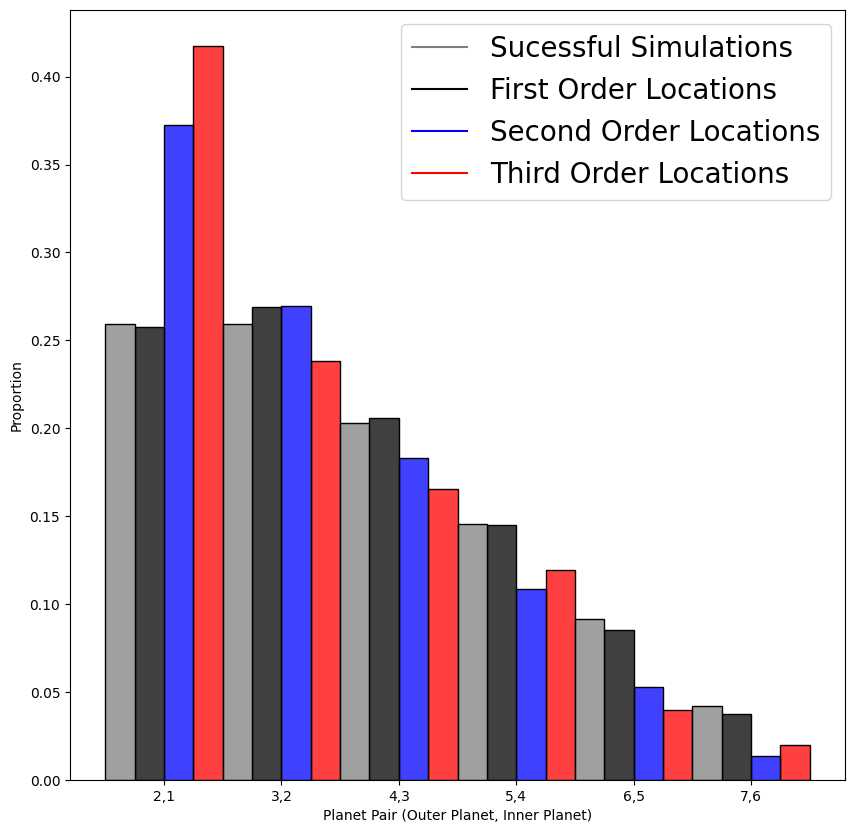

Fraction of Pairs in First Position Across all Converged Systems: 0.2592431147216168
Fraction of Pairs in First Position Across First Order Systems: 0.2577971841026555
Fraction of Pairs in First Position Across Second Order Systems: 0.37277580071174377
Fraction of Pairs in First Position Across Third Order Systems: 0.41721854304635764


In [ ]:
overall_locations = np.array([])
for row in sucessful_sims['pnum']:
    for i in range(row-1):
        overall_locations = np.append(overall_locations, i)

fig, ax = plt.subplots(figsize = (10, 10))
df = pd.concat(axis=0, ignore_index=True, objs=[
    pd.DataFrame.from_dict({'value': overall_locations, 'Dataset:': "Sucessful Simulations"}),
    pd.DataFrame.from_dict({'value': first_order_resonance_locations, 'Dataset:': "First Order Locations"}),
    pd.DataFrame.from_dict({'value': second_order_resonance_locations, 'Dataset:': 'Second Order Locations'}),
    pd.DataFrame.from_dict({'value': third_order_resonance_locations, 'Dataset:': 'Third Order Locations'})
])
sns.histplot(df, x = 'value', hue = 'Dataset:', ax = ax, discrete = True, stat = 'proportion', multiple = 'dodge', common_norm = False, palette = ['grey','black', 'blue', 'red'], legend = False)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(np.array(['2,1', '3,2', '4,3', '5,4', '6,5','7,6']))
ax.set_xlabel("Planet Pair (Outer Planet, Inner Planet)")

legend_elements = []
system_types = ["Sucessful Simulations","First Order Locations", "Second Order Locations", "Third Order Locations"]
colors = ['grey','black', 'blue', 'red'] 
for idx in range(len(system_types)):
    legend_elements.append(Line2D([0], [0], color = colors[idx], label = system_types[idx]))
ax.legend(handles=legend_elements, fontsize = 20)

plt.show()
# General slope is due to the fact that there are fewer systems with high planet multiplicities. 
# Can check our labels by seeing that the smallest mean is third order, followed by second, then first, then overall. First vs. overall is biased by slightly lower counts for first in high planet multiplities while higher vs. rest is based on excess at inner edge.
overall_places, overall_counts = np.unique(overall_locations, return_counts = True)
print("Fraction of Pairs in First Position Across all Converged Systems: "+str(overall_counts[0]/np.sum(overall_counts)))
first_order_places, first_order_counts = np.unique(first_order_resonance_locations, return_counts = True)
print("Fraction of Pairs in First Position Across First Order Systems: "+str(first_order_counts[0]/np.sum(first_order_counts)))
second_order_places, second_order_counts = np.unique(second_order_resonance_locations, return_counts = True)
print("Fraction of Pairs in First Position Across Second Order Systems: "+str(second_order_counts[0]/np.sum(second_order_counts)))
third_order_places, third_order_counts = np.unique(third_order_resonance_locations, return_counts = True)
print("Fraction of Pairs in First Position Across Third Order Systems: "+str(third_order_counts[0]/np.sum(third_order_counts)))

# Section 8: Capture into a higher order MMR Does Not Require a Librating Three-Body Resonant Angle
* We include Figure 11, which contains the evolution of our two example systems in the period-period plane.
* We also demonstrate that not all higher order MMRs participate in three-body resonances.
* These results suggest that although they are potentially protective, prior three-body resonant capture is not necessary for the formation of higher order resonances.

In [94]:
# Analytical form of where 3 body should land from Rath et al. (2022)
def P_2overP(p_1, q_1, p_2, q_2, P_1over_P = np.linspace(0.2, 0.92, 1000)):
    P_2_over_P = p_2/((p_1+q_2)-q_1*(1/P_1over_P))
    # Let's edit this to go to a maximum of five
    mask1 = P_2_over_P <= 5
    mask2 = P_2_over_P > 0
    mask = mask1 & mask2
    P_2_over_P_masked = P_2_over_P[mask]
    P_1over_P_masked = P_1over_P[mask]
    return P_1over_P_masked, P_2_over_P_masked

# Function from the Matplotlib documentation: https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

/var/folders/cc/2yvcp_011qd69hqn5mygm0s80000gn/T/ipykernel_79154/2126019482.py:11: RuntimeWarning: divide by zero encountered in log10
  times = np.log10(np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__times.npy')/1000)
/var/folders/cc/2yvcp_011qd69hqn5mygm0s80000gn/T/ipykernel_79154/2126019482.py:32: RuntimeWarning: divide by zero encountered in log10
  times = np.log10(np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__times.npy')/1000) # logtimes shows variation better but creates error for zeroth time.


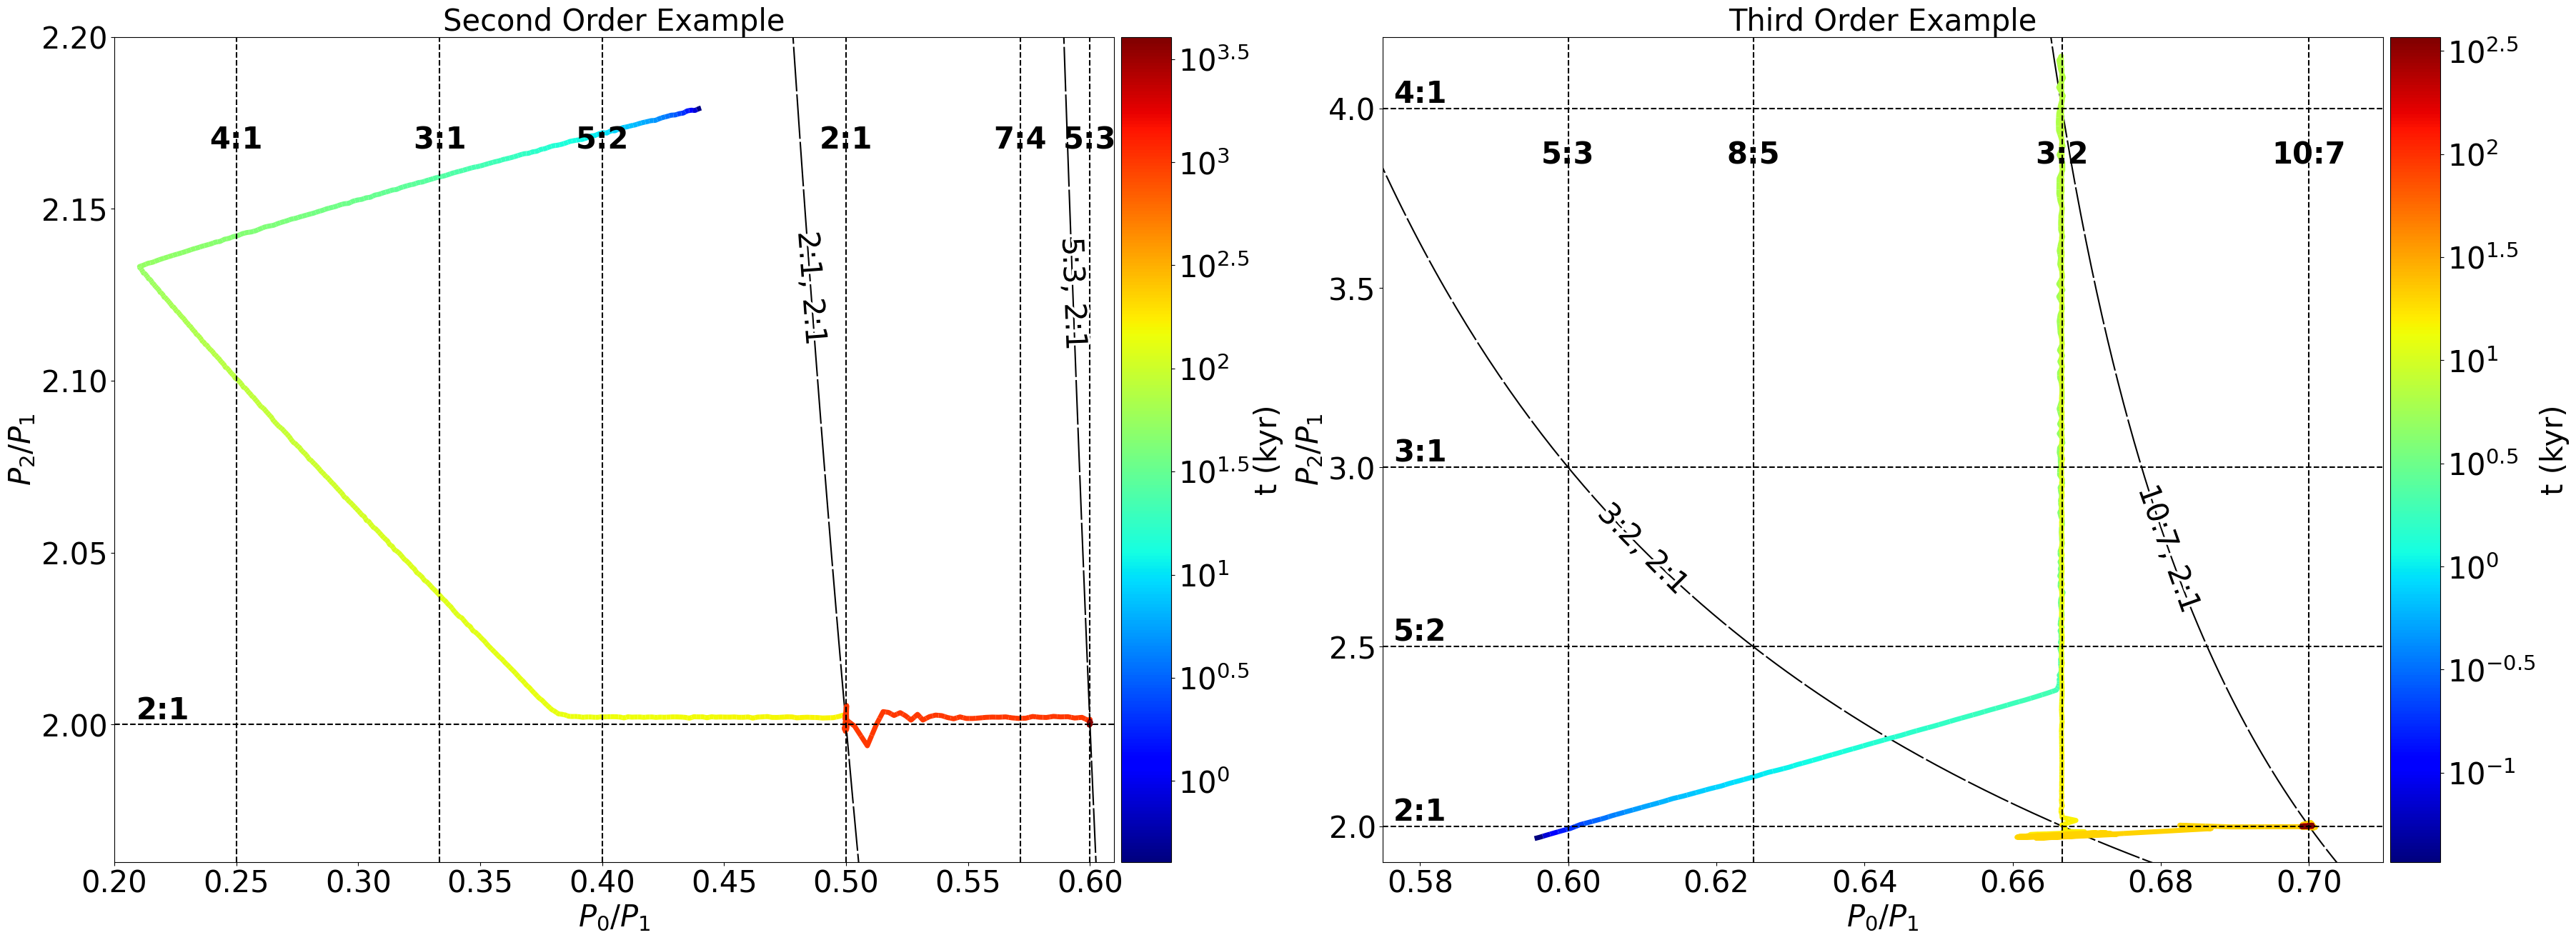

In [95]:
fig, ax = plt.subplots(1, 2, figsize =  (42, 15))

# Second order example from Section 3. 
colormap =  "jet"
periods =  np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__pers.npy') #  5:3, 2:1, 2:1, 3:2, 2:1, 4:3
P_1 = periods[0,:]
P = periods[1,:]
P_2 = periods[2,:]
x = P_1/P
y = P_2/P
times = np.log10(np.load('save/Migration Reruns second_order_example_7/0_inner_edge_1.1e+02_taua_1.3e+06__times.npy')/1000)
#second_order_ex_scatter = ax[0].scatter(x, y, c = times, cmap = colormap, zorder = 3, s = 8)
second_order_ex_plot = colored_line(x, y, times, ax[0], linewidth = 5, cmap = colormap)

# Second order example curve
P_1over_P, P_2over_P = P_2overP(5, 3, 2, 1)
ax[0].plot(P_1over_P, P_2over_P, c = 'black', zorder = 1, ls =  (0, (30, 2)), label = r"$5\colon3$, $2\colon1$")
labelLines(ax[0].get_lines(), zorder=5, xvals = 0.593, fontsize = 30, drop_label = True,  align = True)
# Second order initial lock curve
P_1over_P, P_2over_P = P_2overP(2, 1, 2, 1)
ax[0].plot(P_1over_P, P_2over_P, c = 'black', zorder = 1, ls =  (0, (30, 2)), label = r"$2\colon1$, $2\colon1$")
labelLines(ax[0].get_lines(), zorder=5, xvals = 0.4855, fontsize = 30, drop_label = False,  align = True)

# Third order example from the Appendix.
colormap =  "jet"
periods = np.load("save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__pers.npy") # 10:7, 2:1, 3:2, 3:2, 3:2
P_1 = periods[0,:]
P = periods[1,:]
P_2 = periods[2,:]
x = P_1/P
y = P_2/P
times = np.log10(np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__times.npy')/1000) # logtimes shows variation better but creates error for zeroth time.
#third_order_ex_scatter = ax[1].scatter(x, y, c = times, cmap = colormap, zorder = 3, s = 8)
third_order_ex_plot = colored_line(x, y, times, ax[1], linewidth = 5, cmap = colormap)

# Third order example curve
P_1over_P, P_2over_P = P_2overP(10, 7, 2, 1)
ax[1].plot(P_1over_P, P_2over_P, c = 'black', zorder = 1, ls =  (0, (30, 2)), label = r"$10\colon7$, $2\colon1$")
labelLines(ax[1].get_lines(), zorder=5, xvals = 0.681, fontsize = 30, drop_label = True,  align = True)
# Third order initial lock curve
P_1over_P, P_2over_P = P_2overP(3, 2, 2, 1)
ax[1].plot(P_1over_P, P_2over_P, c = 'black', zorder = 1, ls =  (0, (30, 2)), label = r"$3\colon2$, $2\colon1$")
labelLines(ax[1].get_lines(), zorder=5, xvals = 0.61, fontsize = 30, drop_label = True,  align = True)

# For the colorbar formatting, I got help from the following ChatGPT log: https://chatgpt.com/share/67acb6fb-c204-8005-bfe4-6678bfa09114
# Create a single divider for the colorbars
divider = make_axes_locatable(ax[0])
second_order_ex_cax = divider.append_axes('right', size='5%', pad=0.1)
divider = make_axes_locatable(ax[1])
third_order_ex_cax = divider.append_axes('right', size='5%', pad=0.1)  # More padding for the second colorbar
# Add colorbars
second_order_ex_colorbar = fig.colorbar(second_order_ex_plot, cax = second_order_ex_cax, orientation='vertical', label='t (kyr)')
second_order_ex_colorbar.ax.yaxis.label.set_size(30)
second_order_ex_colorbar.ax.tick_params(labelsize = 30)

third_order_ex_colorbar = fig.colorbar(third_order_ex_plot, cax = third_order_ex_cax, orientation='vertical', label='t (kyr)')
third_order_ex_colorbar.ax.yaxis.label.set_size(30)
third_order_ex_colorbar.ax.tick_params(labelsize = 30)
# Make the colorbars have power of ten labels
second_order_ex_colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'$10^{{{x}}}$' if x % 1 != 0 else f'$10^{{{int(x)}}}$'))
third_order_ex_colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'$10^{{{x}}}$' if x % 1 != 0 else f'$10^{{{int(x)}}}$'))

# Relevant MMRs
ax[0].axvline(0.5, c = 'black', ls = '--', label = "2:1")
ax[0].text(0.5, 2.17, "2:1", horizontalalignment = 'center', verticalalignment = 'center', weight = 'bold', fontsize = 30, zorder = 4)
ax[0].axvline(0.6, c = 'black', ls = '--', label = "5:3")
ax[0].text(0.6, 2.17, "5:3", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[0].axvline(2/5, c = 'black', ls = '--', label = "5:2")
ax[0].text(2/5, 2.17, "5:2", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[0].axvline(4/7, c = 'black', ls = '--', label = "7:4")
ax[0].text(4/7, 2.17, "7:4", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[0].axvline(1/3, c = 'black', ls = '--', label = "3:1")
ax[0].text(1/3, 2.17, "3:1", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[0].axvline(0.25, c = 'black', ls = '--', label = "4:1")
ax[0].text(0.25, 2.17, "4:1", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[0].axhline(2, c = 'black', ls = "--", label = "2:1")
ax[0].text(0.22, 2.004, "2:1", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)

ax[1].axvline(0.6, c = 'black', ls = '--', label = "5:3")
ax[1].text(0.6, 3.87, "5:3", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[1].axvline(5/8, c = 'black', ls = '--', label = "8:5")
ax[1].text(5/8, 3.87, "8:5", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[1].axvline(2/3, c = 'black', ls = '--', label = "3:2")
ax[1].text(2/3, 3.87, "3:2", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[1].axvline(0.7, c = 'black', ls = '--', label = "10:7")
ax[1].text(0.7, 3.87, "10:7", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[1].axhline(2, c = 'black', ls = "--", label = "2:1")
ax[1].text(0.58, 2.04, "2:1", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[1].axhline(2.5, c = 'black', ls = "--", label = "5:2")
ax[1].text(0.58, 2.54, "5:2", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[1].axhline(3, c = 'black', ls = "--", label = "3:1")
ax[1].text(0.58, 3.04, "3:1", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)
ax[1].axhline(4, c = 'black', ls = "--", label = "4:1")
ax[1].text(0.58, 4.04, "4:1", horizontalalignment = 'center', verticalalignment = 'center',  weight = 'bold', fontsize = 30, zorder = 4)

ax[0].set_xlim(0.2, 0.61)
ax[0].set_ylim(1.96, 2.2)
ax[0].tick_params(axis='both', which='major', labelsize = 30)
ax[0].set_xlabel(r"$P_0/P_1$", fontsize = 30)
ax[0].set_ylabel(r"$P_2/P_1$", fontsize = 30)
ax[0].set_title("Second Order Example", fontsize = 30)

ax[1].set_xlim(0.575, 0.71)
ax[1].set_ylim(1.9, 4.2)
ax[1].tick_params(axis='both', which='major', labelsize = 30)
ax[1].set_xlabel(r"$P_0/P_1$", fontsize = 30)
ax[1].set_ylabel(r"$P_2/P_1$", fontsize = 30)
ax[1].set_title("Third Order Example", fontsize = 30)

fig.savefig("output_plots/PP_plot.png", bbox_inches = 'tight')

plt.show()

In [96]:
# While it seems like there is not an overabundance of higher order MMR with librating three body resonant angles relative to first order MMRs, plotting reveals a plethora of the systems are not in complete three body resonant chains where the higher order MMRs have at leat one resonanting three body angle.
# Below, we try to quantify this effect against the prevalence of first order MMRs. 
# First, we set up our dataset, all systems with some signs of two body resonance and grab subsets of that dataset for relevant parameters.
combined_resonances_2 = pd.concat([resonant_chains_2, resonances_2])
combined_2_2bodyamps = pd.DataFrame(np.transpose(np.vstack([combined_resonances_2['phi_amp_2_01'], combined_resonances_2['phi_amp_2_12'], combined_resonances_2['phi_amp_2_23'], combined_resonances_2['phi_amp_2_34'], combined_resonances_2['phi_amp_2_45'], combined_resonances_2['phi_amp_2_56']])), columns = ["phi_amp_2_01", "phi_amp_2_12", "phi_amp_2_23", "phi_amp_2_34", "phi_amp_2_45", "phi_amp_2_56"])
combined_resonances_2_3bodyamps = pd.DataFrame(np.transpose(np.vstack([combined_resonances_2['phi_amp_3_012'], combined_resonances_2['phi_amp_3_123'], combined_resonances_2['phi_amp_3_234'], combined_resonances_2['phi_amp_3_345'], combined_resonances_2['phi_amp_3_456']])), columns = ["phi_amp_3_012", "phi_amp_3_123", "phi_amp_3_234", "phi_amp_3_345", "phi_amp_3_456"])
combined_resonances_2_prox_reses = pd.DataFrame(np.transpose(np.vstack([combined_resonances_2['prox_res_01'], combined_resonances_2['prox_res_12'], combined_resonances_2['prox_res_23'], combined_resonances_2['prox_res_34'], combined_resonances_2['prox_res_45'], combined_resonances_2['prox_res_56']])), columns = ["prox_res_01", "prox_res_12", "prox_res_23", "prox_res_34", "prox_res_45", "prox_res_56"])

# Next, we run a nested loop that returns an array of all of the planet pairs within this dataset that are in a mean motion resonance. We also return the positions of these MMRs within their systems.
mmrs = []
res_idxs = []
for row_idx in range(len(combined_resonances_2)):
    # grab relative system parameters.
    pnum = combined_resonances_2.iloc[row_idx]['pnum']
    sys_2body_amps = combined_2_2bodyamps.iloc[row_idx].to_numpy()[:pnum-1]
    sys_prox_res = combined_resonances_2_prox_reses.iloc[row_idx].to_numpy()[:pnum-1]
    sys_mmrs = np.array([])
    sys_res_idxs = []
    # For each planet pair, determine its closest MMR, figure out if that MMR librates, and then create arrays of the MMRs and their indices.
    for planet_pair_idx in range(pnum-1):
        mmr = sys_prox_res[planet_pair_idx]
        if sys_2body_amps[planet_pair_idx]<90: 
            sys_mmrs = np.append(sys_mmrs, mmr) 
            sys_res_idxs.append(planet_pair_idx)
    # Check that those two arrays are the same length and append them to the overall lists of all of the MMRs and indexes across systems.
    # It is important that we use lists as then each row can have a different length given by the number of resonant planet pairs.
    assert len(sys_mmrs) == len(sys_res_idxs)
    mmrs.append(sys_mmrs)
    res_idxs.append(sys_res_idxs)

# Using the arrays above, we see which MMRs actually feature three body resonant angles.
mmrs_with3body = []
for row_idx in range(len(combined_resonances_2)): 
    # We set up the system parameters.
    pnum = combined_resonances_2.iloc[row_idx]['pnum']
    sys_3body_amps = combined_resonances_2_3bodyamps.iloc[row_idx].to_numpy()[:pnum-2]
    sys_mmrs = mmrs[row_idx]
    sys_res_idxs = res_idxs[row_idx]
    for planet_pair_idx in range(len(sys_res_idxs)):
        # Let's start with the edge cases. The first planet pair only is in one three body resonance, so we just check that one.
        if planet_pair_idx == 0:
            if sys_3body_amps[planet_pair_idx]<90:
                mmrs_with3body.append(sys_mmrs[planet_pair_idx])
        # The last planet pair also only participates in one three body resonance. 
        elif planet_pair_idx == sys_res_idxs[-1]: # -2 is -1 for pair not planet -1 for zero indexing (planet pairs run from 0-5 for a seven planet system for a total of 6 pairs, for example).
            if sys_3body_amps[planet_pair_idx-1]<90: # -1 for triplet not pair (planet pairs run from 0-5 for a seven planet system meaning that planet triplets run from 0-4 for a total of five triplets, for example). 
                mmrs_with3body.append(sys_mmrs[planet_pair_idx])
        else:
            if sys_3body_amps[planet_pair_idx-1]<90 or sys_3body_amps[planet_pair_idx]<90:
                mmrs_with3body.append(sys_mmrs[planet_pair_idx])            

# Let's sort by order. This section of the code takes ~20 minutes to run. 
frac_first_order_res_with3body = np.array([])
frac_second_order_res_with3body = np.array([])
frac_third_order_res_with3body = np.array([])
for res in mmrs_with3body:
    if np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_first_order_resonances_unique):
        frac_first_order_res_with3body = np.append(frac_first_order_res_with3body, fractions.Fraction(res).limit_denominator(1000))
    elif np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_second_order_resonances_unique):
        frac_second_order_res_with3body= np.append(frac_second_order_res_with3body, fractions.Fraction(res).limit_denominator(1000))
    elif np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_third_order_resonances_unique):
        frac_third_order_res_with3body = np.append(frac_third_order_res_with3body, fractions.Fraction(res).limit_denominator(1000))
    else:
        print("The resonance "+str(res)+" is not first, second, or third order.")
frac_higher_order_res_with3body = np.hstack([frac_second_order_res_with3body, frac_third_order_res_with3body])

print("Percent of First Order MMR pairs with at Least One Librating Three-Body Resonance: "+str(len(frac_first_order_res_with3body)/len(first_order_resonances)*100))
print("Percent of Second Order MMR pairs with at Least One Librating Three-Body Resonance: "+str(len(frac_second_order_res_with3body)/len(second_order_resonances)*100))
print("Percent of Third Order MMR pairs with at Least One Librating Three-Body Resonance: "+str(len(frac_third_order_res_with3body)/len(third_order_resonances)*100))
print("Percent of Higher Order MMR pairs with at Least One Librating Three-Body Resonance: "+str(len(frac_higher_order_res_with3body)/(len(second_order_resonances)+len(third_order_resonances))*100))

Percent of First Order MMR pairs with at Least One Librating Three-Body Resonance: 90.33594724648013
Percent of Second Order MMR pairs with at Least One Librating Three-Body Resonance: 78.11387900355872
Percent of Third Order MMR pairs with at Least One Librating Three-Body Resonance: 88.0794701986755
Percent of Higher Order MMR pairs with at Least One Librating Three-Body Resonance: 79.29411764705883


In [97]:
# Let's now try to do this for situtations where both three body resonant angles librate (or one for innermost and outermost).
combined_resonances_2 = pd.concat([resonant_chains_2, resonances_2])
combined_2_2bodyamps = pd.DataFrame(np.transpose(np.vstack([combined_resonances_2['phi_amp_2_01'], combined_resonances_2['phi_amp_2_12'], combined_resonances_2['phi_amp_2_23'], combined_resonances_2['phi_amp_2_34'], combined_resonances_2['phi_amp_2_45'], combined_resonances_2['phi_amp_2_56']])), columns = ["phi_amp_2_01", "phi_amp_2_12", "phi_amp_2_23", "phi_amp_2_34", "phi_amp_2_45", "phi_amp_2_56"])
combined_resonances_2_3bodyamps = pd.DataFrame(np.transpose(np.vstack([combined_resonances_2['phi_amp_3_012'], combined_resonances_2['phi_amp_3_123'], combined_resonances_2['phi_amp_3_234'], combined_resonances_2['phi_amp_3_345'], combined_resonances_2['phi_amp_3_456']])), columns = ["phi_amp_3_012", "phi_amp_3_123", "phi_amp_3_234", "phi_amp_3_345", "phi_amp_3_456"])
combined_resonances_2_prox_reses = pd.DataFrame(np.transpose(np.vstack([combined_resonances_2['prox_res_01'], combined_resonances_2['prox_res_12'], combined_resonances_2['prox_res_23'], combined_resonances_2['prox_res_34'], combined_resonances_2['prox_res_45'], combined_resonances_2['prox_res_56']])), columns = ["prox_res_01", "prox_res_12", "prox_res_23", "prox_res_34", "prox_res_45", "prox_res_56"])

# Next, we run a nested loop that returns an array of all of the planet pairs within this dataset that are in a mean motion resonance. We also return the positions of these MMRs within their systems.
mmrs = []
res_idxs = []
for row_idx in range(len(combined_resonances_2)):
    # grab relative system parameters.
    pnum = combined_resonances_2.iloc[row_idx]['pnum']
    sys_2body_amps = combined_2_2bodyamps.iloc[row_idx].to_numpy()[:pnum-1]
    sys_prox_res = combined_resonances_2_prox_reses.iloc[row_idx].to_numpy()[:pnum-1]
    sys_mmrs = np.array([])
    sys_res_idxs = []
    # For each planet pair, determine its closest MMR, figure out if that MMR librates, and then create arrays of the MMRs and their indices.
    for planet_pair_idx in range(pnum-1):
        mmr = sys_prox_res[planet_pair_idx]
        if sys_2body_amps[planet_pair_idx]<90: 
            sys_mmrs = np.append(sys_mmrs, mmr) 
            sys_res_idxs.append(planet_pair_idx)
    # Check that those two arrays are the same length and append them to the overall lists of all of the MMRs and indexes across systems.
    # It is important that we use lists as then each row can have a different length given by the number of resonant planet pairs.
    assert len(sys_mmrs) == len(sys_res_idxs)
    mmrs.append(sys_mmrs)
    res_idxs.append(sys_res_idxs)

# Using the arrays above, we see which MMRs actually feature three body resonant angles.
mmrs_with3body = []
for row_idx in range(len(combined_resonances_2)): 
    # We set up the system parameters.
    pnum = combined_resonances_2.iloc[row_idx]['pnum']
    sys_3body_amps = combined_resonances_2_3bodyamps.iloc[row_idx].to_numpy()[:pnum-2]
    sys_mmrs = mmrs[row_idx]
    sys_res_idxs = res_idxs[row_idx]
    for planet_pair_idx in range(len(sys_res_idxs)):
        # Let's start with the edge cases. The first planet pair only is in one three body resonance, so we just check that one.
        if planet_pair_idx == 0:
            if sys_3body_amps[planet_pair_idx]<90:
                mmrs_with3body.append(sys_mmrs[planet_pair_idx])
        # The last planet pair also only participates in one three body resonance. 
        elif planet_pair_idx == sys_res_idxs[-1]: # -2 is -1 for pair not planet -1 for zero indexing (planet pairs run from 0-5 for a seven planet system for a total of 6 pairs, for example).
            if sys_3body_amps[planet_pair_idx-1]<90: # -1 for triplet not pair (planet pairs run from 0-5 for a seven planet system meaning that planet triplets run from 0-4 for a total of five triplets, for example). 
                mmrs_with3body.append(sys_mmrs[planet_pair_idx])
        else:
            if sys_3body_amps[planet_pair_idx-1]<90 and sys_3body_amps[planet_pair_idx]<90:
                mmrs_with3body.append(sys_mmrs[planet_pair_idx])            

# Let's sort by order. This section of the code takes ~20 minutes to run. 
frac_first_order_res_with3body = np.array([])
frac_second_order_res_with3body = np.array([])
frac_third_order_res_with3body = np.array([])
for res in mmrs_with3body:
    if np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_first_order_resonances_unique):
        frac_first_order_res_with3body = np.append(frac_first_order_res_with3body, fractions.Fraction(res).limit_denominator(1000))
    elif np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_second_order_resonances_unique):
        frac_second_order_res_with3body= np.append(frac_second_order_res_with3body, fractions.Fraction(res).limit_denominator(1000))
    elif np.isin(fractions.Fraction(res).limit_denominator(1000), fractional_third_order_resonances_unique):
        frac_third_order_res_with3body = np.append(frac_third_order_res_with3body, fractions.Fraction(res).limit_denominator(1000))
    else:
        print("The resonance "+str(res)+" is not first, second, or third order.")
frac_higher_order_res_with3body = np.hstack([frac_second_order_res_with3body, frac_third_order_res_with3body])

print("Percent of First Order MMR pairs where Both Three-Body Resonant Angles Librate: "+str(len(frac_first_order_res_with3body)/len(first_order_resonances)*100))
print("Percent of Second Order MMR pairs where Both Three-Body Resonant Angles Librate: "+str(len(frac_second_order_res_with3body)/len(second_order_resonances)*100))
print("Percent of Third Order MMR pairs where Both Three-Body Resonant Angles Librate: "+str(len(frac_third_order_res_with3body)/len(third_order_resonances)*100))
print("Percent of Higher Order MMR pairs where Both Three-Body Resonant Angles Librate: "+str(len(frac_higher_order_res_with3body)/(len(second_order_resonances)+len(third_order_resonances))*100))
print("Note: The innermost and outermost planet triplets only engage in one three-body resonance, so if that three-body resonant angle librates, we count them as having full libration.")

Percent of First Order MMR pairs where Both Three-Body Resonant Angles Librate: 73.67670646943503
Percent of Second Order MMR pairs where Both Three-Body Resonant Angles Librate: 65.0355871886121
Percent of Third Order MMR pairs where Both Three-Body Resonant Angles Librate: 76.82119205298014
Percent of Higher Order MMR pairs where Both Three-Body Resonant Angles Librate: 66.43137254901961
Note: The innermost and outermost planet triplets only engage in one three-body resonance, so if that three-body resonant angle librates, we count them as having full libration.


# Section 9: The Disk Inner Edge May Not Always Halt Migration
* In this section, we include Figure 12 of CDFs of the masses and semi-major axes for planets that pass through the inner disk edge. 
* We also include an additional figure not presented in the paper, which features the CDF of the libration amplitudes for planet pairs that include a planet that passes through the inner disk edge against those that don't.

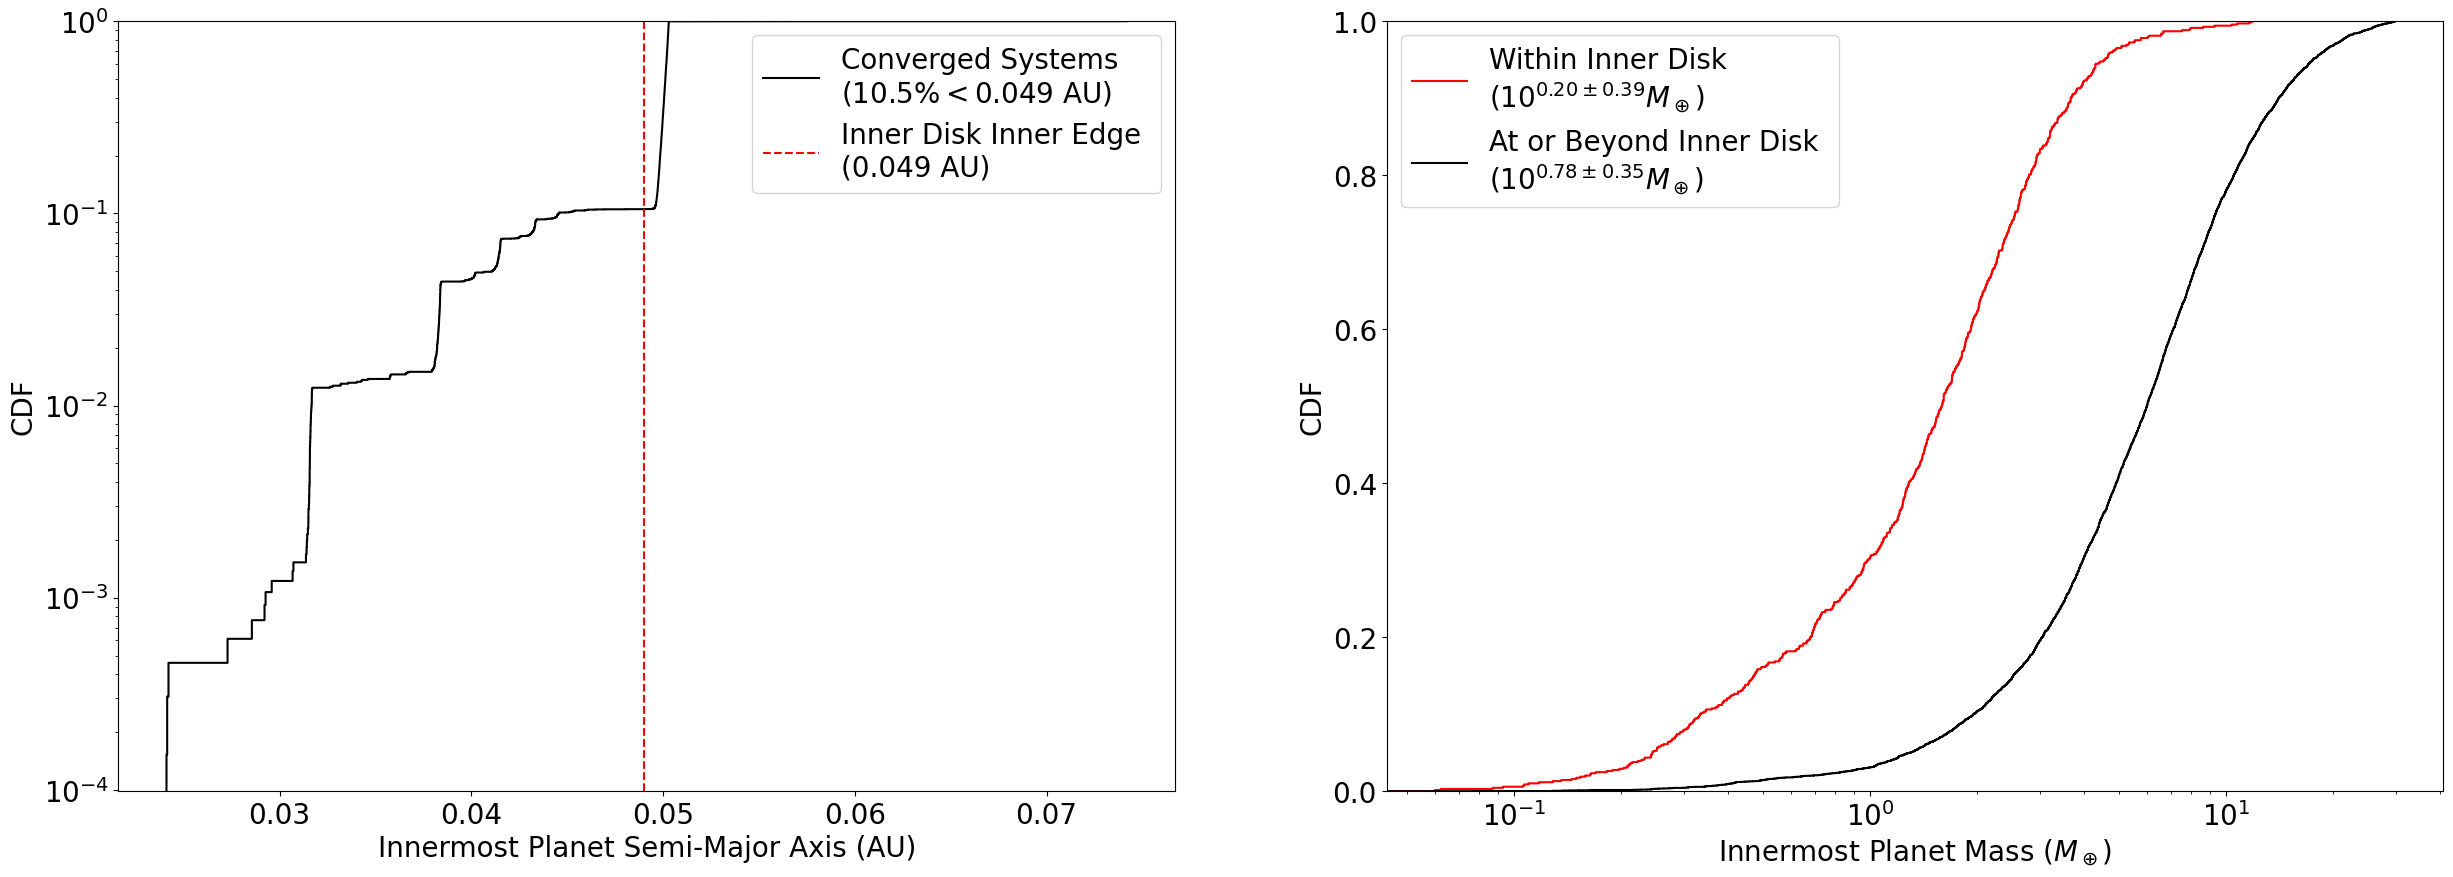

In [ ]:
# Let's now see do they end up in final conditions with the innermost planet at the inner disk edge.
# see how this varies with order of MMR
fig, ax = plt.subplots(1, 2, figsize = (30,10))

sucessful_sims_within_ide = sucessful_sims[sucessful_sims["a_0"]<0.049] # currently marking as that that has passed the thickness of the inner disk edge
sns.ecdfplot(sucessful_sims['a_0'], ax = ax[0], label = "Converged Systems \n("+str(sig_figs(len(sucessful_sims_within_ide)/len(sucessful_sims["a_0"])*100, 3))+r"$\%<0.049$ AU)", c = 'black')
ax[0].axvline(0.049, label = 'Inner Disk Inner Edge \n(0.049 AU)', ls = '--', c = 'red')
ax[0].set_xlabel("Innermost Planet Semi-Major Axis (AU)", fontsize = 20)
ax[0].set_ylabel("CDF", fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize = 20)
ax[0].tick_params(axis='both', which='minor', labelsize = 20)
ax[0].set_yscale('log')
ax[0].legend(fontsize = 20)

inner_edge_sys = sucessful_sims[sucessful_sims["a_0"]<0.049]
inner_edge_mass_median = CHAT_sig_figs(np.median(np.log10(inner_edge_sys['pl_mass_0']*u.Msun.to(u.Mearth))), sigfigs-2)
inner_edge_mass_std = CHAT_sig_figs(np.std(np.log10(inner_edge_sys['pl_mass_0']*u.Msun.to(u.Mearth))), sigfigs_uncert)
non_inner_edge_sys = sucessful_sims[sucessful_sims["a_0"]>0.049]
non_inner_edge_mass_median = CHAT_sig_figs(np.median(np.log10(non_inner_edge_sys['pl_mass_0']*u.Msun.to(u.Mearth))), sigfigs-2)
non_inner_edge_mass_std = CHAT_sig_figs(np.std(np.log10(non_inner_edge_sys['pl_mass_0']*u.Msun.to(u.Mearth))), sigfigs_uncert)
sns.ecdfplot(inner_edge_sys['pl_mass_0']*u.Msun.to(u.Mearth), ax = ax[1], label = 'Within Inner Disk \n($10^{'+str(inner_edge_mass_median)+r"\pm"+str(inner_edge_mass_std)+r"}M_\oplus$)", c = 'red')
sns.ecdfplot(non_inner_edge_sys['pl_mass_0']*u.Msun.to(u.Mearth), ax = ax[1], label = 'At or Beyond Inner Disk \n($10^{'+str(non_inner_edge_mass_median)+r"\pm"+str(non_inner_edge_mass_std)+r"}M_\oplus$)", c = 'black')
ax[1].set_xlabel(r"Innermost Planet Mass ($M_\oplus$)", fontsize = 20)
ax[1].set_ylabel("CDF", fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize = 20)
ax[1].tick_params(axis='both', which='minor', labelsize = 20)
ax[1].set_xscale('log')
ax[1].legend(fontsize = 20)

plt.savefig("output_plots/inner_disk_edge", bbox_inches = 'tight')
plt.show()

Median Libration Amplitude for Innermost Planets that Pass Through the IDE: 1.040788152 Degrees
Median Libration Amplitude for Innermost Planets that Don't Pass Through the IDE: 0.3771340028003355 Degrees
Mean Libration Amplitude for Innermost Planets that Pass Through the IDE: 21.85807842393515 Degrees
Mean Libration Amplitude for Innermost Planets that Don't Pass Through the IDE: 8.352321051505346 Degrees


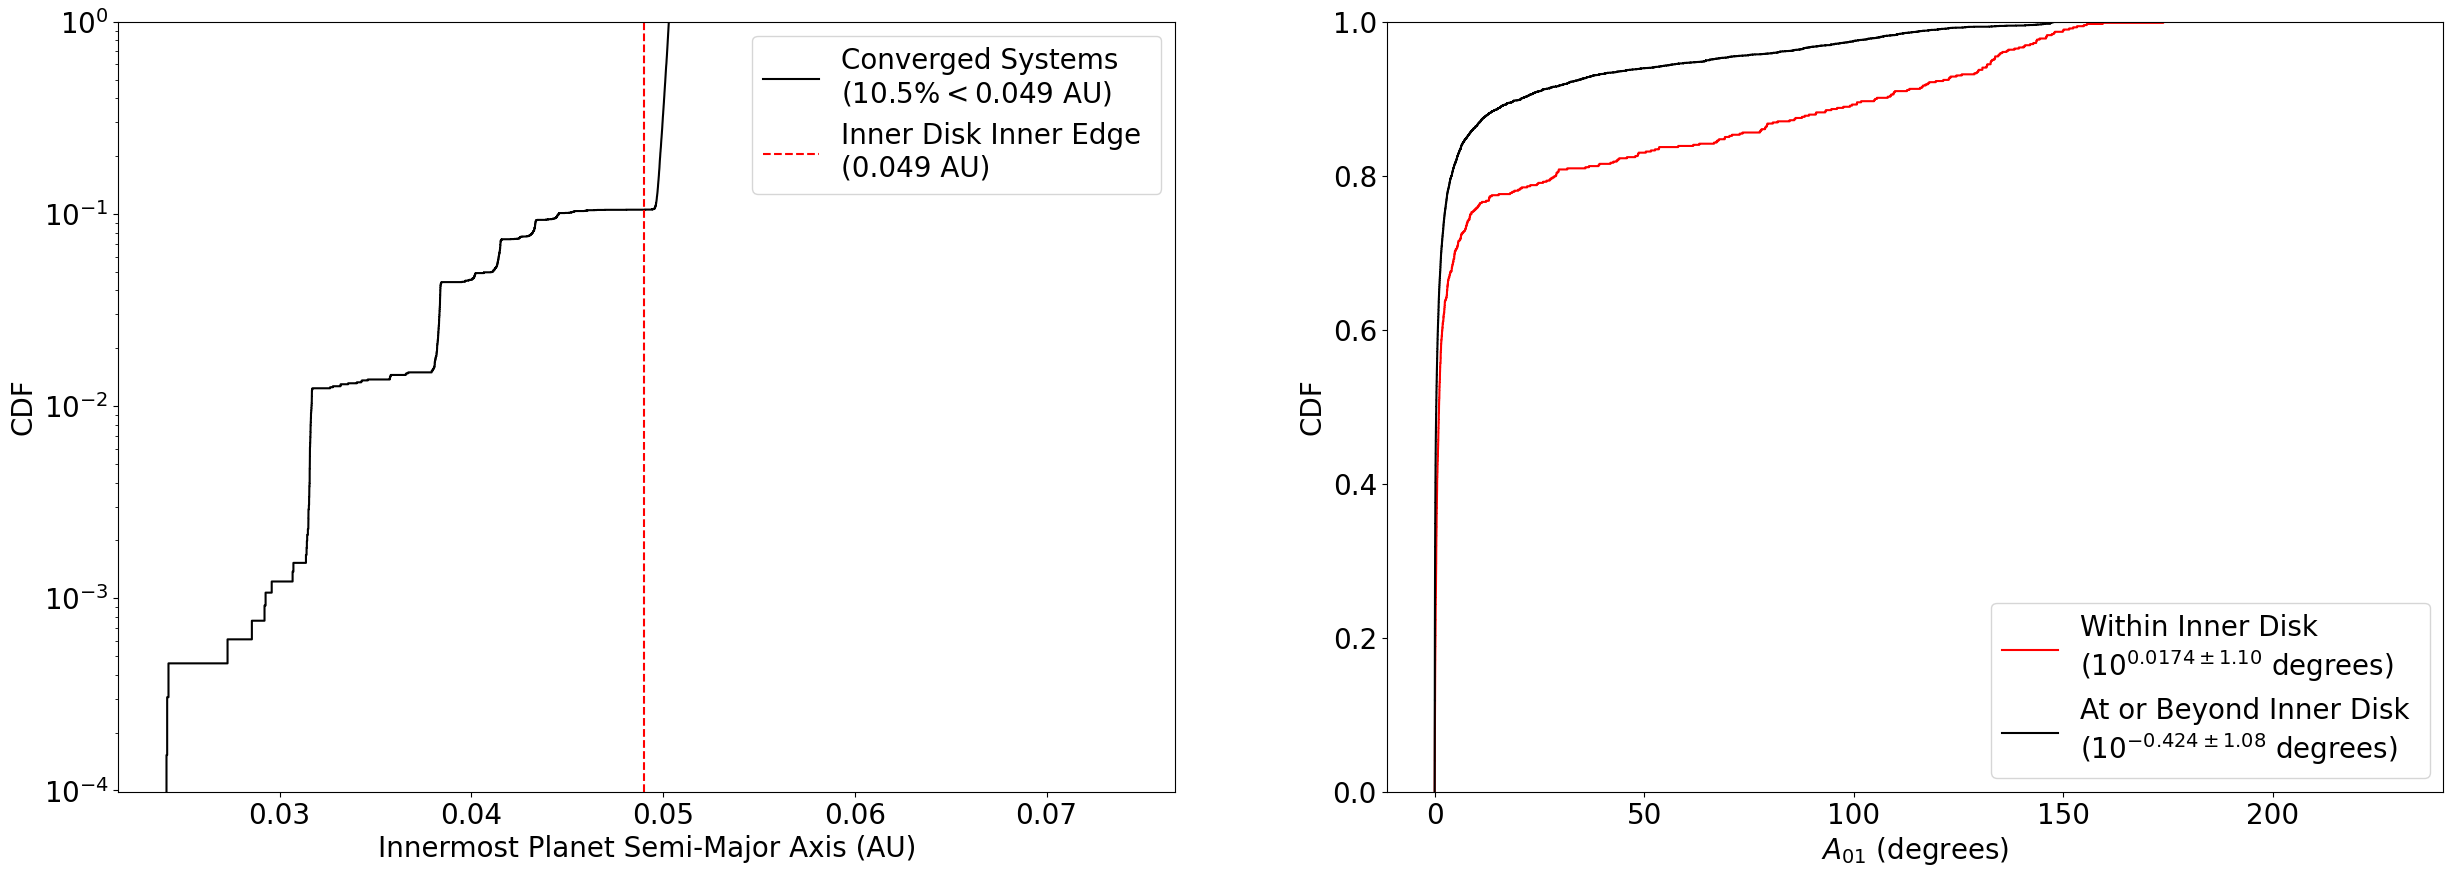

In [ ]:
# Let's now see do they end up in final conditions with the innermost planet at the inner disk edge.
# see how this varies with order of MMR
fig, ax = plt.subplots(1, 2, figsize = (30,10))

sucessful_sims_within_ide = sucessful_sims[sucessful_sims["a_0"]<0.049] # currently marking as that that has passed the thickness of the inner disk edge
sns.ecdfplot(sucessful_sims['a_0'], ax = ax[0], label = "Converged Systems \n("+str(sig_figs(len(sucessful_sims_within_ide)/len(sucessful_sims["a_0"])*100, 3))+r"$\%<0.049$ AU)", c = 'black')
ax[0].axvline(0.049, label = 'Inner Disk Inner Edge \n(0.049 AU)', ls = '--', c = 'red')
ax[0].set_xlabel("Innermost Planet Semi-Major Axis (AU)", fontsize = 20)
ax[0].set_ylabel("CDF", fontsize = 20)
ax[0].tick_params(axis='both', which='major', labelsize = 20)
ax[0].tick_params(axis='both', which='minor', labelsize = 20)
ax[0].set_yscale('log')
ax[0].legend(fontsize = 20)

# What happens to these systems? 
inner_edge_sys = sucessful_sims[sucessful_sims["a_0"]<0.049]
inner_edge_phi_median = CHAT_sig_figs(np.median(np.log10(inner_edge_sys['phi_amp_2_01'])), 3)
inner_edge_phi_std = CHAT_sig_figs(np.std(np.log10(inner_edge_sys['phi_amp_2_01'])), 3)
non_inner_edge_sys = sucessful_sims[sucessful_sims["a_0"]>0.049]
non_inner_edge_phi_median = CHAT_sig_figs(np.median(np.log10(non_inner_edge_sys['phi_amp_2_01'])), 3)
non_inner_edge_phi_std = CHAT_sig_figs(np.std(np.log10(non_inner_edge_sys['phi_amp_2_01'])),3)
sns.ecdfplot(inner_edge_sys['phi_amp_2_01'], ax = ax[1], label = 'Within Inner Disk \n($10^{'+str(inner_edge_phi_median)+r"\pm"+str(inner_edge_phi_std)+r"}$ degrees)", c = 'red')
sns.ecdfplot(non_inner_edge_sys['phi_amp_2_01'], ax = ax[1], label = 'At or Beyond Inner Disk \n($10^{'+str(non_inner_edge_phi_median)+r"\pm"+str(non_inner_edge_phi_std)+r"}$ degrees)", c = 'black')
ax[1].set_xlabel(r"$A_{01}$"+" (degrees)", fontsize = 20)
ax[1].set_ylabel("CDF", fontsize = 20)
ax[1].tick_params(axis='both', which='major', labelsize = 20)
ax[1].tick_params(axis='both', which='minor', labelsize = 20)
#ax[1].set_xscale('log')
ax[1].legend(fontsize = 20)

print("Median Libration Amplitude for Innermost Planets that Pass Through the IDE: "+str(np.median(inner_edge_sys['phi_amp_2_01']))+" Degrees")
print("Median Libration Amplitude for Innermost Planets that Don't Pass Through the IDE: "+str(np.median(non_inner_edge_sys['phi_amp_2_01']))+" Degrees")
print("Mean Libration Amplitude for Innermost Planets that Pass Through the IDE: "+str(np.mean(inner_edge_sys['phi_amp_2_01']))+" Degrees")
print("Mean Libration Amplitude for Innermost Planets that Don't Pass Through the IDE: "+str(np.mean(non_inner_edge_sys['phi_amp_2_01']))+" Degrees")

# What happens to these systems? 
#inner_edge_sys = sucessful_sims[sucessful_sims["a_0"]<0.049]
#inner_edge_taua_median = sig_figs(np.median(inner_edge_sys['taua']), 3)/1000
#non_inner_edge_sys = sucessful_sims[sucessful_sims["a_0"]>0.049]
#non_inner_edge_taua_median = sig_figs(np.median(non_inner_edge_sys['taua']), 3)/1000
#sns.ecdfplot(inner_edge_sys['taua']/1000, ax = ax[2], label = 'Within IDE (Median: '+str(inner_edge_taua_median)+r"kyr)")
#sns.ecdfplot(non_inner_edge_sys['taua']/1000, ax = ax[2], label = 'At or Beyond IDE (Median: '+str(non_inner_edge_taua_median)+r"kyr)")
#ax[2].set_xlabel(r"$\tau_a$ (yr)", fontsize = 15)
#ax[2].set_ylabel("Preportion", fontsize = 15)
#ax[2].set_xscale('log')
#ax[2].legend(fontsize = 15)

#plt.savefig("output_plots/inner_disk_edge", bbox_inches = 'tight')
plt.show()
# Good number within
# Next step is to check what exactly happens in this 10% of systems. Is the innermost planet very low in mass so the net torque on it is not enough to stop other planets which are probably more massive. 
# We could run on the cluster additional simulations spanning a range of inner disk edge on the cluster. Draw more or less a uniform distribution from 1 day to 10 day. 
# This can be a message. If inner planet not up to the job, it won't stop migrating. Some systems are not like the Kepler ones (solar system for example). Migration may be too fast, didn't get parked in IDE (plot taua). Could be a separate section on this. Inner disk edge not always capable of stopping migration.
# can just put 0.05--watch the label that says 0.49.
# Low mass is the most important pointer. Low mass cannot stop migration. Definitely mention. 
# Varied inner disk edge simulations are for later. Don't worry yet. Pre-emptive for referree report.
# Hard to quantify IDE vs. Xu and Lai. Also Xu and Lai only consider pairs.

# Section 10: Conclusion
* We include Table 3 of the factors that promote creating higher order MMRs in this section.
* We also provide relevant KS tests that are incorporated into Table 3.

In [ ]:
# Let's compute our p values
higher_order_tauas = np.hstack([second_order_tauas, third_order_tauas]) 
higher_order_mass_ratios = np.hstack([second_order_mass_ratios, third_order_mass_ratios]) 
higher_order_Sigmas = np.hstack([second_order_Sigmas, third_order_Sigmas]) 
higher_order_hs = np.hstack([second_order_hs, third_order_hs]) 
higher_order_Ks = np.hstack([second_order_Ks, third_order_Ks])

# Let's do a two-distribution kstest.
# Recall: if the p value is under 0.05, we reject the null hypothesis. This means that the two distributions are distinct.
# could test with comparison to just converged systems to see about the p value issue 
# Let's test all combinations.
# Some of these p-values are really really small. I wonder if something has gone wrong, but there are stack overflow pages that suggest p-values like this are expected when drawn from the same distribution. https://stackoverflow.com/questions/65561840/ks-2samp-returns-p-value-of-1-0
taua_arrays = [first_order_tauas, higher_order_tauas]
taua_array_labels = ["First Order Tauas", "Higher Order Tauas"]
for idx1, idx2 in combinations(range(0,2), 2):
    statistical_result = stats.ks_2samp(taua_arrays[idx1], taua_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(taua_array_labels[idx1])+" and "+str(taua_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(taua_array_labels[idx1])+" and "+str(taua_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(taua_array_labels[idx1])+" and "+str(taua_array_labels[idx2])+" are drawn from the same distribution.")
print('\n')

mass_ratio_arrays = [first_order_mass_ratios, higher_order_mass_ratios]
mass_ratio_array_labels = ["First Order Mass Ratios", "Higher Order Mass Ratios"]
for idx1, idx2 in combinations(range(0,2), 2):
    statistical_result = stats.ks_2samp(mass_ratio_arrays[idx1], mass_ratio_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(mass_ratio_array_labels[idx1])+" and "+str(mass_ratio_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(mass_ratio_array_labels[idx1])+" and "+str(mass_ratio_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(mass_ratio_array_labels[idx1])+" and "+str(mass_ratio_array_labels[idx2])+" are drawn from the same distribution.")
print('\n')

Sigma_arrays = [first_order_Sigmas, higher_order_Sigmas]
Sigma_array_labels = ["First Order Sigmas", "Higher Order Sigmas"]
for idx1, idx2 in combinations(range(0,2), 2):
    statistical_result = stats.ks_2samp(Sigma_arrays[idx1], Sigma_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(Sigma_array_labels[idx1])+" and "+str(Sigma_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(Sigma_array_labels[idx1])+" and "+str(Sigma_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(Sigma_array_labels[idx1])+" and "+str(Sigma_array_labels[idx2])+" are drawn from the same distribution.")
print('\n')

h_arrays = [first_order_hs, higher_order_hs]
h_array_labels = ["First Order hs", "Higher Order hs"]
for idx1, idx2 in combinations(range(0,2), 2):
    statistical_result = stats.ks_2samp(h_arrays[idx1], h_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(h_array_labels[idx1])+" and "+str(h_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(h_array_labels[idx1])+" and "+str(h_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(h_array_labels[idx1])+" and "+str(h_array_labels[idx2])+" are drawn from the same distribution.")
print('\n')

# K and h have same p-value as they are effectively different ways of probing differences in h.
K_arrays = [first_order_Ks, higher_order_Ks]
K_array_labels = ["First Order Ks", "Higher Order Ks"]
for idx1, idx2 in combinations(range(0,2), 2):
    statistical_result = stats.ks_2samp(K_arrays[idx1], K_arrays[idx2], alternative='two-sided', method = 'exact')
    print('P value of kstest betweeen '+str(K_array_labels[idx1])+" and "+str(K_array_labels[idx2])+": "+str(statistical_result.pvalue))
    if statistical_result.pvalue<0.05: 
        print('P value is less than 0.05. Thus, we reject the null hypothesis and suggest that '+str(K_array_labels[idx1])+" and "+str(K_array_labels[idx2])+" may be drawn from different distributions.")
    elif statistical_result.pvalue>0.05:
        print('P value is greater than 0.05. Thus, we accept the null hypothesis and suggest that '+str(K_array_labels[idx1])+" and "+str(K_array_labels[idx2])+" are drawn from the same distribution.")

P value of kstest betweeen First Order Tauas and Higher Order Tauas: 1.6769988731599425e-65
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that First Order Tauas and Higher Order Tauas may be drawn from different distributions.


P value of kstest betweeen First Order Mass Ratios and Higher Order Mass Ratios: 5.656148730531351e-10
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that First Order Mass Ratios and Higher Order Mass Ratios may be drawn from different distributions.


P value of kstest betweeen First Order Sigmas and Higher Order Sigmas: 2.3253870585603093e-49
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that First Order Sigmas and Higher Order Sigmas may be drawn from different distributions.


P value of kstest betweeen First Order hs and Higher Order hs: 4.941939434112665e-108
P value is less than 0.05. Thus, we reject the null hypothesis and suggest that First Order hs and Higher Order h

In [ ]:
print(r"Larger $\tau_a$ & $10^{"+str(sig_figs(np.median(np.log10(higher_order_tauas)-3), sigfigs-2))+r"\pm"+str(sig_figs(np.std(np.log10(higher_order_tauas)-3), sigfigs_uncert))+r"}$ kyr & $10^{"+str(sig_figs(np.median(np.log10(first_order_tauas)-3), sigfigs-2))+r"\pm"+str(sig_figs(np.std(np.log10(first_order_tauas)-3), sigfigs_uncert))+r"}$ kyr & $>5\sigma$ & \ref{sec: 5}"+ r" \\")
print(r"Smaller $m_{out}/m_{in}$ & $10^{"+str(sig_figs(np.median(np.log10(higher_order_mass_ratios)), sigfigs-2))+r"\pm"+str(sig_figs(np.std(np.log10(higher_order_mass_ratios)), sigfigs_uncert))+r"}$ & $10^{"+str(sig_figs(np.median(np.log10(first_order_mass_ratios)), sigfigs-2))+r"\pm"+str(sig_figs(np.std(np.log10(first_order_mass_ratios)), 3))+r"}$ & $>5\sigma$ & \ref{sec: 5}"+r" \\")
print(r"Smaller $\Sigma$ & $10^{"+str(sig_figs(np.median(np.log10(higher_order_Sigmas)), sigfigs-1))+r"\pm"+str(sig_figs(np.std(np.log10(higher_order_Sigmas)), sigfigs_uncert))+r"}$"+r" $g/cm^2$ & $10^{"+str(sig_figs(np.median(np.log10(first_order_Sigmas)), sigfigs-1))+r"\pm"+str(sig_figs(np.std(np.log10(first_order_Sigmas)), sigfigs_uncert))+r"}$"+r" $g/cm^2$ & $>5\sigma$ & \ref{sec: 5} \\")
print(r"Larger $h$ & $10^{"+str(sig_figs(np.median(np.log10(higher_order_hs)), sigfigs-1))+r"\pm"+str(sig_figs(np.std(np.log10(higher_order_hs)), sigfigs_uncert))+r"}$ & $10^{"+str(sig_figs(np.median(np.log10(first_order_hs)), sigfigs-1))+r"\pm"+str(sig_figs(np.std(np.log10(first_order_hs)), sigfigs_uncert))+r"}$ & $>5\sigma$ & \ref{sec: 5}"+r" \\")
print(r"Smaller $K$ & $10^{"+str(sig_figs(np.median(np.log10(higher_order_Ks)), sigfigs-1))+r"\pm"+str(sig_figs(np.std(np.log10(higher_order_Ks)), sigfigs_uncert))+r"}$ & $10^{"+str(sig_figs(np.median(np.log10(first_order_Ks)), sigfigs-1))+r"\pm"+str(sig_figs(np.std(np.log10(first_order_Ks)), sigfigs_uncert))+r"}$ & $>5\sigma$ & \ref{sec: 5}"+r" \\")
print(r"External Torques & & & & \ref{sec: 3}, \ref{sec: 6}, \ref{sec: 7}\\")

Larger $\tau_a$ & $10^{3.0\pm1.0}$ kyr & $10^{2.4\pm1.0}$ kyr & $>5\sigma$ & \ref{sec: 5} \\
Smaller $m_{out}/m_{in}$ & $10^{-0.081\pm0.45}$ & $10^{-0.033\pm0.374}$ & $>5\sigma$ & \ref{sec: 5} \\
Smaller $\Sigma$ & $10^{1.76\pm0.77}$ $g/cm^2$ & $10^{2.3\pm0.82}$ $g/cm^2$ & $>5\sigma$ & \ref{sec: 5} \\
Larger $h$ & $10^{-1.1\pm0.22}$ & $10^{-1.32\pm0.26}$ & $>5\sigma$ & \ref{sec: 5} \\
Smaller $K$ & $10^{1.45\pm0.45}$ & $10^{1.9\pm0.53}$ & $>5\sigma$ & \ref{sec: 5} \\
External Torques & & & & \ref{sec: 3}, \ref{sec: 6}, \ref{sec: 7}\\


# Appendix
* This section contains Figure 13 of the evolution of a third order system as well as Table 4 of the system parameters for that system.
* The Appendix also features Table 5, which tabulates all of the $f$ and $g$ coefficients for each of the first, second, and third order mean motion resonances. 
* Finally, we provide Table 6, which tabulates the different quantities of every MMR produced in our simulations.

In [ ]:
# Find relevant file. 
for idx in range(len(third_order_resonant_chains_2)):
    K_outermost = third_order_resonant_chains_2.iloc[idx]['K_outermost']
    taua = third_order_resonant_chains_2.iloc[idx]['taua']
    try:
        try:
            index = int(third_order_resonant_chains_2.iloc[idx]['index'][0]) # other indexes come from way I set up the arrays
        except IndexError:
            index = int(third_order_resonant_chains_2.iloc[idx]['index'])
    except ValueError:
        continue
    if plot_finder(index, K_outermost, taua) == "4_inner_edge_1.8e+01_taua_1.2e+05_": 
        third_order_system_to_rerun = third_order_resonant_chains_2.iloc[idx]
        relevant_taua = third_order_resonant_chains_2['taua'].iloc[idx]
        print("Relevant taua: "+str(relevant_taua))

for idx in range(len(third_order_resonant_chains_3)):
    if third_order_resonant_chains_3['taua'].iloc[idx] == relevant_taua:
        print("Relevant idx: "+str(idx))

Relevant taua: 123158.0924
Relevant idx: 46


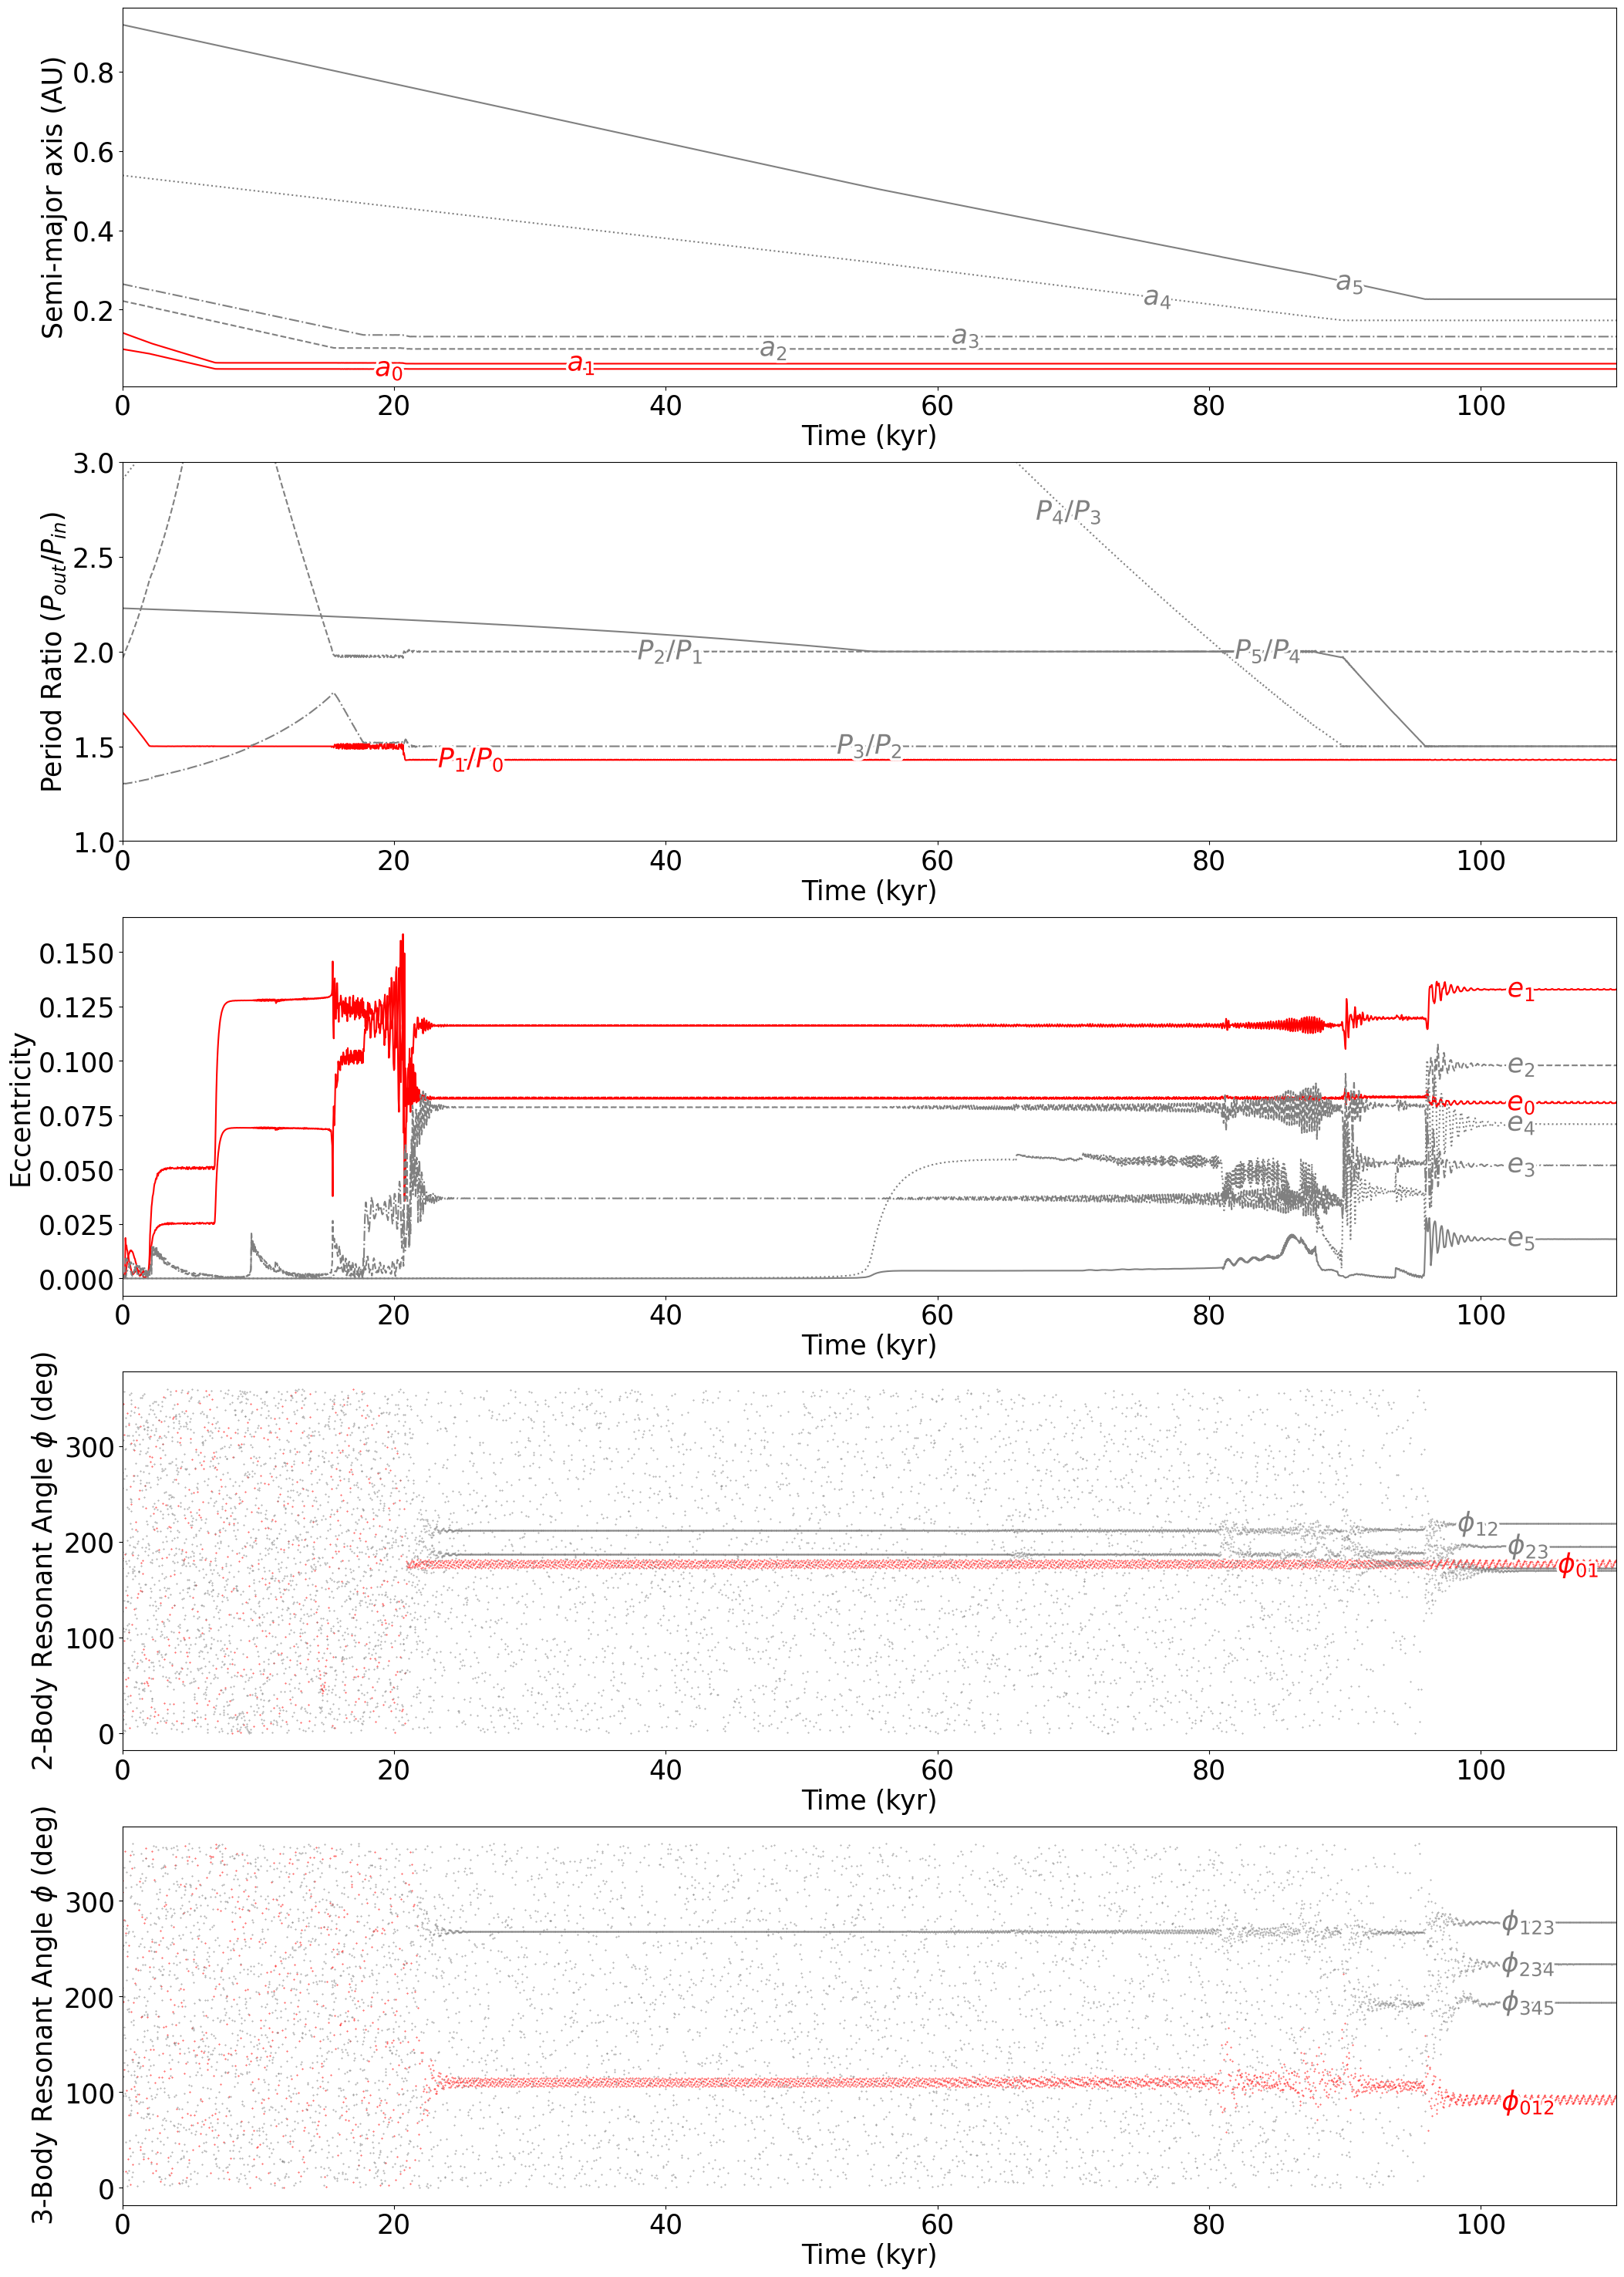

In [ ]:
# Plots!
fig, ax = plt.subplots(5, 1, figsize = (25, 37))
fo_linestyles = ['dashed', 'dashdot', 'dotted', 'solid', (0, (1, 10))]

# Third order
times = np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__times.npy')
semi_major = np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__as.npy')
p_ratios = np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__p_ratios.npy')
deltas = np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__deltas.npy') # Note: we've updated our definition for Delta. To fix this array, we need to divide every entry by p/q for each appropriate resonance.
two_body_resonant_angles = np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__two_body_resonant_angles.npy')
three_body_resonant_angles = np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__three_body_resonant_angles.npy')
eccentricities = np.load('save/Migration Reruns third_order_example_6/0_inner_edge_1.8e+01_taua_1.2e+05__es.npy')

time_limit = 110
updated_idx = 0
for row_idx in range(6):
    if row_idx == 0 or row_idx == 1:
        alpha = 1
        ax[0].plot(times*0.001, semi_major[row_idx,:], label = '$a_'+str(row_idx)+'$', c = 'red', alpha = alpha, ls = 'solid')
    else:
        alpha = 1
        ax[0].plot(times*0.001, semi_major[row_idx,:], label = '$a_'+str(row_idx)+'$', c = 'grey', alpha = alpha, ls = fo_linestyles[updated_idx])
        updated_idx+=1
ax[0].set_xlabel('Time (kyr)', fontsize = 25)
ax[0].set_ylabel('Semi-major axis (AU)', fontsize = 25)
ax[0].set_xlim(0,time_limit)
#ax[0].axhline(0.05, lw = 2, ls = ":",  c = 'black', label = 'Inner Disk Edge')
ax[0].tick_params(axis='both', which='major', labelsize = 25)
ax[0].tick_params(axis='both', which='minor', labelsize = 25)
#ax[0].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
labelLines(ax[0].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False)
#ax[0].legend(fontsize = 20)

updated_idx = 0
for row_idx in range(5):
    if row_idx == 0:
        alpha = 1
        ax[1].plot(times*0.001, p_ratios[row_idx,:], label = "$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$", c = 'red', alpha = alpha, ls = 'solid')
    else:
        alpha = 1
        ax[1].plot(times*0.001, p_ratios[row_idx,:], label = "$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$", c = 'grey', alpha = alpha, ls = fo_linestyles[updated_idx])
        updated_idx+=1
    #if colors[row_idx] == 'orange':
    #    ax[1].text(times[500:501]*1e-3, p_ratios[row_idx, 500:501]-0.05, r"$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$",  c = colors[row_idx], fontsize = 25, zorder = 4, bbox = dict(facecolor='white', alpha=0.2, edgecolor='white'))
ax[1].set_xlabel('Time (kyr)', fontsize = 25)
ax[1].set_ylabel('Period Ratio ($P_{out}/P_{in}$)', fontsize = 25)
ax[1].set_xlim(0, time_limit)
ax[1].set_ylim(1, 3)
ax[1].tick_params(axis='both', which='major', labelsize = 25)
ax[1].tick_params(axis='both', which='minor', labelsize = 25)
#ax[1].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
labelLines(ax[1].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False, shrink_factor = 0.1)
#ax[1].legend(fontsize = 20)

updated_idx = 0
for row_idx in range(6):
    if row_idx == 0 or row_idx == 1:
        alpha = 1
        ax[2].plot(times*0.001, eccentricities[row_idx,:], label = '$e_'+str(row_idx)+'$', c = 'red', alpha = alpha, ls = 'solid')
    else:
        alpha = 1
        ax[2].plot(times*0.001, eccentricities[row_idx,:], label = '$e_'+str(row_idx)+'$', c = 'grey', alpha = alpha, ls = fo_linestyles[updated_idx])
        updated_idx+=1

ax[2].set_xlabel('Time (kyr)', fontsize = 25)
ax[2].set_ylabel('Eccentricity', fontsize = 25)
ax[2].set_xlim(0,time_limit)
ax[2].tick_params(axis='both', which='major', labelsize = 25)
ax[2].tick_params(axis='both', which='minor', labelsize = 25)
#ax[2].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
labelLines(ax[2].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False, xvals = [103,103,103,103,103,103]*1000)
#ax[2].legend(fontsize = 20)

updated_idx = 0
for row_idx in range(5):
    if row_idx == 0:
        alpha = 1
        ax[3].scatter(times*0.001, two_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'red', alpha = alpha, ls = 'solid')
        # Let's make plot label clearer
        ax[3].plot(times[2900:2902]*1e-3, two_body_resonant_angles[row_idx,2900:2902], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$', c = 'red', alpha = alpha)
    else:
        alpha = 1
        ax[3].scatter(times*0.001, two_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'grey', alpha = alpha)
        if row_idx == 1:
            ax[3].plot(times[2700:2702]*1e-3, two_body_resonant_angles[row_idx,2700:2702], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$', c = 'grey', alpha = alpha)
        elif row_idx == 2:
            ax[3].plot(times[2800:2802]*1e-3, two_body_resonant_angles[row_idx,2800:2802], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$', c = 'grey', alpha = alpha)
ax[3].set_xlabel('Time (kyr)', fontsize = 25)
ax[3].set_ylabel('2-Body Resonant Angle $\phi$ (deg)', fontsize = 25)
ax[3].set_xlim(0,time_limit)
ax[3].tick_params(axis='both', which='major', labelsize = 25)
ax[3].tick_params(axis='both', which='minor', labelsize = 25)
labelLines(ax[3].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False)
#ax[3].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
#ax[3].legend(fontsize = 20)

for row_idx in range(4):
    if row_idx == 0:
        alpha = 1
        ax[4].scatter(times*0.001, three_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'red', alpha = alpha)
        ax[4].plot(times[2800:2802]*1e-3, three_body_resonant_angles[row_idx,2800:2802], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$', c = 'red', alpha = alpha)
    else:
        alpha = 1
        ax[4].scatter(times*0.001, three_body_resonant_angles[row_idx,:], marker = '.', s= 0.5, c = 'grey', alpha = alpha)
        ax[4].plot(times[2800:2802]*1e-3, three_body_resonant_angles[row_idx,2800:2802], label = r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$', c = 'grey', alpha = alpha)

ax[4].set_xlabel('Time (kyr)', fontsize = 25)
ax[4].set_ylabel('3-Body Resonant Angle $\phi$ (deg)', fontsize = 25)
ax[4].set_xlim(0,time_limit)
ax[4].tick_params(axis='both', which='major', labelsize = 25)
ax[4].tick_params(axis='both', which='minor', labelsize = 25)
#ax[4].axvline(times[determine_lock_period_ratio(times, p_ratios, 4)]*1e-3, ls = '--', c = 'black')
labelLines(ax[4].get_lines(), zorder=5, fontsize = 25, drop_label = True,  align = False)
#ax[4].legend(fontsize = 20)

plt.show()
fig.savefig("output_plots/third_order_example.png", bbox_inches = 'tight')

In [ ]:
# Appendix table of parameters.
print(r"$\Sigma$ & $h$ & $\tau_a$ & Integration Time & Stellar Mass"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['Sigma'], 3))+r"g/cm^2$ & $"+str(sig_figs(third_order_system_to_rerun['h'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['taua'], 3)/1000)+"kyr$ & $"+str(sig_figs(third_order_system_to_rerun['itime'], 3)/1000)+"kyr$ & $"+str(sig_figs(third_order_system_to_rerun['st_mass'], 3))+r"M_\odot$"+r" \\")
print("\hline")
print(r"$m_0$ & $m_1$ & $m_2$ & $m_3$ & $m_4$ & $m_5$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['pl_mass_0']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(third_order_system_to_rerun['pl_mass_1']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(third_order_system_to_rerun['pl_mass_2']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(third_order_system_to_rerun['pl_mass_3']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(third_order_system_to_rerun['pl_mass_4']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$ & $"+str(sig_figs(third_order_system_to_rerun['pl_mass_5']*u.Msun.to(u.Mearth), 3))+r"M_\oplus$"+r" \\")
print(r"$e_0$ & $e_1$ & $e_2$ & $e_3$ & $e_4$ & $e_5$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['e_0'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['e_1'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['e_2'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['e_3'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['e_4'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['e_5'], 3))+r"$ \\")
print(r"$a_{0i}$ & $a_{1i}$ & $a_{2i}$ & $a_{3i}$ & $a_{4i}$ & $a_{5i}$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['pl_orbsmax_0'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['pl_orbsmax_1'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['pl_orbsmax_2'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['pl_orbsmax_3'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['pl_orbsmax_4'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['pl_orbsmax_5'], 3))+"AU$"+r" \\")
print(r"$a_{0f}$ & $a_{1f}$ & $a_{2f}$ & $a_{3f}$ & $a_{4f}$ & $a_{5f}$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['a_0'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['a_1'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['a_2'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['a_3'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['a_4'], 3))+"AU$ & $"+str(sig_figs(third_order_system_to_rerun['a_5'], 3))+"AU$"+r" \\")
print("\hline")
print('$m_1/m_0$ & $m_2/m_1$ & $m_3/m_2$ & $m_4/m_3$ & $m_5/m_4$'+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['m_01'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['m_12'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['m_23'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['m_34'], 3))+"$ & $"+str(sig_figs(third_order_system_to_rerun['m_45'], 3))+r"$ \\")
print(r"$p_{01}/q_{01}$ & $p_{12}/q_{12}$ &$ p_{23}/q_{23}$ & $p_{34}/q_{34}$ & $p_{45}/q_{45}$"+r" \\")
print("$"+str(fractions.Fraction(third_order_system_to_rerun['prox_res_01']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(third_order_system_to_rerun['prox_res_12']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(third_order_system_to_rerun['prox_res_23']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(third_order_system_to_rerun['prox_res_34']).limit_denominator(1000))+"$ & $"+str(fractions.Fraction(third_order_system_to_rerun['prox_res_45']).limit_denominator(1000))+r"$ \\")
#print("$(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$ & $(P_1/P_0)_i$"+r"\\") # I could calculate this, but I would have to adapt old code.
print("$(P_1/P_0)_f$ & $(P_2/P_1)_f$ & $(P_3/P_2)_f$ & $(P_4/P_3)_f$ & $(P_5/P_4)_f$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['p_ratio_01'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['p_ratio_12'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['p_ratio_23'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['p_ratio_34'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['p_ratio_45'], 5))+r"$ \\")
print(r"$\Delta_{01}$ & $\Delta_{12}$ & $\Delta_{23}$ & $\Delta_{34}$ & $\Delta_{45}$"+r" \\")
# Updating new Delta definition with the old commented out below.
print("$"+str(sig_figs(third_order_system_to_rerun['delta_01'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_12'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_23'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_34'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_45'], 5))+r"$ \\")
#print("$"+str(sig_figs(third_order_system_to_rerun['delta_wu_01'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_wu_12'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_wu_23'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_wu_34'], 5))+"$ & $"+str(sig_figs(third_order_system_to_rerun['delta_wu_45'], 5))+r"$ \\")
print(r"$\phi_{01}$ & $\phi_{12}$ & $\phi_{23}$ & $\phi_{34}$ & $\phi_{45}$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['phi_cen_2_01'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_cen_2_12'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_cen_2_23'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_cen_2_34'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_cen_2_45'], 3))+"^\circ$"+r" \\")
print(r"$A_{01}$ & $A_{12}$ & $A_{23}$ & $A_{34}$ & $A_{45}$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['phi_amp_2_01'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_amp_2_12'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_amp_2_23'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_amp_2_34'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_amp_2_45'], 3))+"^\circ$"+r" \\")
print("\hline")
print(r"$\phi_{012}$ & $\phi_{123}$ & $\phi_{234}$ & $\phi_{345}$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['phi_cen_3_012'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_cen_3_123'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_cen_3_234'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_cen_3_345'], 3))+"^\circ$"+r" \\")
print(r"$A_{012}$ & $A_{123}$ & $A_{234}$ & $A_{345}$"+r" \\")
print("$"+str(sig_figs(third_order_system_to_rerun['phi_amp_3_012'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_amp_3_123'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_amp_3_234'], 3))+"^\circ$ & $"+str(sig_figs(third_order_system_to_rerun['phi_amp_3_345'], 3))+"^\circ$"+r" \\")


$\Sigma$ & $h$ & $\tau_a$ & Integration Time & Stellar Mass \\
$2080.0g/cm^2$ & $0.0991AU$ & $123.0kyr$ & $369.0kyr$ & $1.02M_\odot$ \\
\hline
$m_0$ & $m_1$ & $m_2$ & $m_3$ & $m_4$ & $m_5$ \\
$3.07M_\oplus$ & $6.73M_\oplus$ & $4.03M_\oplus$ & $3.86M_\oplus$ & $2.09M_\oplus$ & $3.93M_\oplus$ \\
$e_0$ & $e_1$ & $e_2$ & $e_3$ & $e_4$ & $e_5$ \\
$0.0808$ & $0.133$ & $0.0979$ & $0.052$ & $0.0709$ & $0.0181$ \\
$a_{0i}$ & $a_{1i}$ & $a_{2i}$ & $a_{3i}$ & $a_{4i}$ & $a_{5i}$ \\
$0.1AU$ & $0.141AU$ & $0.222AU$ & $0.264AU$ & $0.538AU$ & $0.919AU$ \\
$a_{0f}$ & $a_{1f}$ & $a_{2f}$ & $a_{3f}$ & $a_{4f}$ & $a_{5f}$ \\
$0.0499AU$ & $0.0633AU$ & $0.1AU$ & $0.132AU$ & $0.173AU$ & $0.226AU$ \\
\hline
$m_1/m_0$ & $m_2/m_1$ & $m_3/m_2$ & $m_4/m_3$ & $m_5/m_4$ \\
$2.19$ & $0.599$ & $0.959$ & $0.541$ & $1.88$ \\
$p_{01}/q_{01}$ & $p_{12}/q_{12}$ &$ p_{23}/q_{23}$ & $p_{34}/q_{34}$ & $p_{45}/q_{45}$ \\
$10/7$ & $2$ & $3/2$ & $3/2$ & $3/2$ \\
$(P_1/P_0)_f$ & $(P_2/P_1)_f$ & $(P_3/P_2)_f$ & $(P_4/P_3)_f$ & $

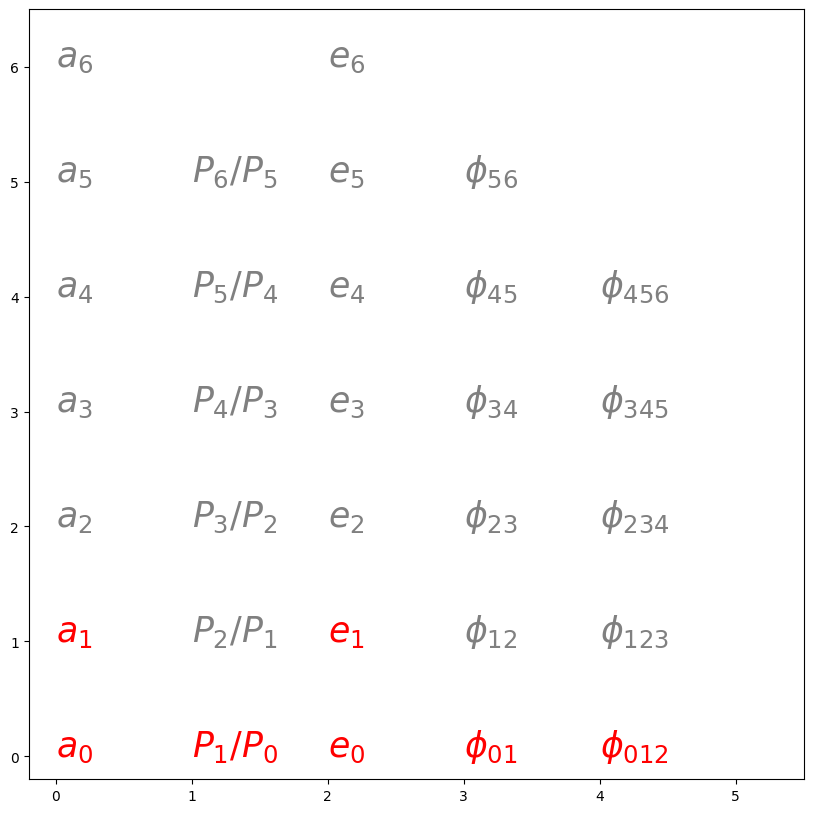

In [ ]:
# I had to adjust and add a couple labels manually. Here are those labels!
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.set_xlim(-0.2, 5.5)
ax.set_ylim(-0.2, 6.5)
colors = ['red', 'red', 'grey', 'grey', 'grey', 'grey', 'grey']
for row_idx in range(7):
    ax.text(0, row_idx, '$a_'+str(row_idx)+'$',  c = colors[row_idx], fontsize = 25, zorder = 4, bbox = dict(facecolor='white', alpha=0.2, edgecolor='white'))
colors = ['red', 'grey', 'grey', 'grey', 'grey', 'grey']
for row_idx in range(6):
    ax.text(1, row_idx, "$P_"+str(row_idx+1)+"/P_"+str(row_idx)+"$",  c = colors[row_idx], fontsize = 25, zorder = 4, bbox = dict(facecolor='white', alpha=0.2, edgecolor='white'))
colors = ['red', 'red', 'grey', 'grey', 'grey', 'grey', 'grey']
for row_idx in range(7):
    ax.text(2, row_idx, '$e_'+str(row_idx)+'$',  c = colors[row_idx], fontsize = 25, zorder = 4, bbox = dict(facecolor='white', alpha=0.2, edgecolor='white'))
colors = ['red', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
for row_idx in range(6):
    ax.text(3, row_idx, r'$\phi_{' +str(row_idx)+str(row_idx+1)+'}$',  c = colors[row_idx], fontsize = 25, zorder = 4, bbox = dict(facecolor='white', alpha=0.2, edgecolor='white'))
colors = ['red', 'grey', 'grey', 'grey', 'grey']
for row_idx in range(5):
    ax.text(4, row_idx, r'$\phi_{' +str(row_idx)+str(row_idx+1)+str(row_idx+2)+'}$',  c = colors[row_idx], fontsize = 25, zorder = 4, bbox = dict(facecolor='white', alpha=0.2, edgecolor='white'))

plt.show()

In [ ]:
# All of the code until "# Appendix Table" is in the complete setup, but we include it again if Quick Setup is Run instead
sigfigs = 4
sigfigs_uncert = 2
all_sims = pd.concat([sucessful_sims, failed_sims])
ppairs = all_sims["pnum"].to_numpy()-1
number_of_planet_pairs = np.sum(ppairs)

fractional_first_order_resonances_unique, first_order_resonances_unique_counts = np.unique(fractional_first_order_resonances, return_counts = True)
decimal_first_order_resonances_unique = np.array([])
for frac_res in fractional_first_order_resonances_unique:
    decimal_first_order_resonances_unique = np.append(decimal_first_order_resonances_unique, frac_res.numerator/frac_res.denominator)

first_order_uncertainties = np.array([])
for idx in range(len(decimal_first_order_resonances_unique)): 
    res_uncert = uncertainty(first_order_resonances_unique_counts[idx], len(fractional_first_order_resonances), report_type = 'Fraction')
    first_order_uncertainties = np.append(first_order_uncertainties, res_uncert)

first_order_uncertainties_entire_sample = np.array([])
for idx in range(len(decimal_first_order_resonances_unique)): 
    res_uncert = uncertainty(first_order_resonances_unique_counts[idx], number_of_planet_pairs, report_type = 'Fraction')
    first_order_uncertainties_entire_sample = np.append(first_order_uncertainties_entire_sample, res_uncert)

first_order_labels = np.array([])
for frac_res in fractional_first_order_resonances_unique:
    first_order_labels = np.append(first_order_labels, str(frac_res.numerator)+":"+str(frac_res.denominator))
    
fractional_second_order_resonances_unique, second_order_resonances_unique_counts = np.unique(fractional_second_order_resonances, return_counts = True)
decimal_second_order_resonances_unique = np.array([])
for frac_res in fractional_second_order_resonances_unique:
    decimal_second_order_resonances_unique = np.append(decimal_second_order_resonances_unique, frac_res.numerator/frac_res.denominator)

second_order_uncertainties = np.array([])
for idx in range(len(decimal_second_order_resonances_unique)): 
    res_uncert = uncertainty(second_order_resonances_unique_counts[idx], len(fractional_second_order_resonances), report_type = 'Fraction')
    second_order_uncertainties = np.append(second_order_uncertainties, res_uncert)

second_order_uncertainties_entire_sample = np.array([])
for idx in range(len(decimal_second_order_resonances_unique)): 
    res_uncert = uncertainty(second_order_resonances_unique_counts[idx], number_of_planet_pairs, report_type = 'Fraction')
    second_order_uncertainties_entire_sample = np.append(second_order_uncertainties_entire_sample, res_uncert)

second_order_labels = np.array([])
for frac_res in fractional_second_order_resonances_unique:
    second_order_labels = np.append(second_order_labels, str(frac_res.numerator)+":"+str(frac_res.denominator))

fractional_third_order_resonances_unique, third_order_resonances_unique_counts = np.unique(fractional_third_order_resonances, return_counts = True)
decimal_third_order_resonances_unique = np.array([])
for frac_res in fractional_third_order_resonances_unique:
    decimal_third_order_resonances_unique = np.append(decimal_third_order_resonances_unique, frac_res.numerator/frac_res.denominator)

third_order_uncertainties = np.array([])
for idx in range(len(decimal_third_order_resonances_unique)): 
    res_uncert = uncertainty(third_order_resonances_unique_counts[idx], len(fractional_third_order_resonances), report_type = 'Fraction')
    third_order_uncertainties = np.append(third_order_uncertainties, res_uncert)

third_order_uncertainties_entire_sample = np.array([])
for idx in range(len(decimal_third_order_resonances_unique)): 
    res_uncert = uncertainty(third_order_resonances_unique_counts[idx], number_of_planet_pairs, report_type = 'Fraction')
    third_order_uncertainties_entire_sample = np.append(third_order_uncertainties_entire_sample, res_uncert)

third_order_labels = np.array([])
for frac_res in fractional_third_order_resonances_unique:
    third_order_labels = np.append(third_order_labels, str(frac_res.numerator)+":"+str(frac_res.denominator))

number_of_resonant_planet_pairs = len(fractional_first_order_resonances)+len(fractional_second_order_resonances)+len(fractional_third_order_resonances)

# Appendix table
print("Category & Count & Percentage Against Entirety of Category\\"+"\\")
# do for first, second, and third, add dividing lines between each
print("First Order Resonant Pairs & $"+str(len(first_order_resonances))+"$ & $"+str(CHAT_sig_figs(len(first_order_resonances)/number_of_resonant_planet_pairs*100, sigfigs))+"\pm"+str(CHAT_sig_figs(uncertainty(len(first_order_resonances), number_of_resonant_planet_pairs), sigfigs_uncert))+"\%$"+"\\"+"\\")
for idx in range(len(fractional_first_order_resonances_unique)):
    # Let's reverse the order so the largest resonance appears first. 
    idx = len(fractional_first_order_resonances_unique)-1-idx
    if fractional_first_order_resonances_unique[idx] > 5/4:
        sigfigs = 6
    else:
        sigfigs = 5
    if fractional_first_order_resonances_unique[idx] == 11/10:
        sigfigs = 7
    print(first_order_labels[idx]+" MMR & $"+str(first_order_resonances_unique_counts[idx])+"$ & $"+str(CHAT_sig_figs(first_order_resonances_unique_counts[idx]/len(first_order_resonances)*100, sigfigs))+"\pm"+str(CHAT_sig_figs(first_order_uncertainties[idx], sigfigs_uncert))+"\%$"+"\\"+"\\")
print("\hline")
print("Second Order Resonant Pairs & $"+str(len(second_order_resonances))+"$ & $"+str(CHAT_sig_figs(len(second_order_resonances)/number_of_resonant_planet_pairs*100, sigfigs))+"\pm"+str(CHAT_sig_figs(uncertainty(len(second_order_resonances), number_of_resonant_planet_pairs), sigfigs_uncert))+"\%$"+"\\"+"\\")
for idx in range(len(fractional_second_order_resonances_unique)):
    # Let's reverse the order so the largest resonance appears first. 
    idx = len(fractional_second_order_resonances_unique)-1-idx
    if fractional_first_order_resonances_unique[idx] < 9/7:
        sigfigs = 4
    print(second_order_labels[idx]+" MMR & $"+str(second_order_resonances_unique_counts[idx])+"$ & $"+str(CHAT_sig_figs(second_order_resonances_unique_counts[idx]/len(second_order_resonances)*100, sigfigs))+"\pm"+str(CHAT_sig_figs(second_order_uncertainties[idx], sigfigs_uncert))+"\%$"+"\\"+"\\")
print("\hline")
print("Third Order Resonant Pairs & $"+str(len(third_order_resonances))+"$ & $"+str(CHAT_sig_figs(len(third_order_resonances)/number_of_resonant_planet_pairs*100, sigfigs))+"\pm"+str(CHAT_sig_figs(uncertainty(len(third_order_resonances), number_of_resonant_planet_pairs), sigfigs_uncert))+"\%$"+"\\"+"\\")
for idx in range(len(fractional_third_order_resonances_unique)):
    # Let's reverse the order so the largest resonance appears first. 
    idx = len(fractional_third_order_resonances_unique)-1-idx
    if fractional_first_order_resonances_unique[idx] == 14/11:
        sigfigs = 5
    print(third_order_labels[idx]+" MMR & $"+str(third_order_resonances_unique_counts[idx])+"$ & $"+str(CHAT_sig_figs(third_order_resonances_unique_counts[idx]/len(third_order_resonances)*100, sigfigs))+"\pm"+str(CHAT_sig_figs(third_order_uncertainties[idx], sigfigs_uncert))+"\%$"+"\\"+"\\")


Category & Count & Percentage Against Entirety of Category\\
First Order Resonant Pairs & $22444$ & $94.62\pm0.15\%$\\
2:1 MMR & $10321$ & $45.9856\pm0.0033\%$\\
3:2 MMR & $8138$ & $36.2591\pm0.0032\%$\\
4:3 MMR & $2505$ & $11.1611\pm0.0021\%$\\
5:4 MMR & $885$ & $3.9431\pm0.0013\%$\\
6:5 MMR & $381$ & $1.6976\pm0.00086\%$\\
7:6 MMR & $113$ & $0.50348\pm0.00047\%$\\
8:7 MMR & $50$ & $0.22278\pm0.00031\%$\\
9:8 MMR & $37$ & $0.16485\pm0.00027\%$\\
10:9 MMR & $10$ & $0.044555\pm0.00014\%$\\
11:10 MMR & $4$ & $0.017822\pm0.000089\%$\\
\hline
Second Order Resonant Pairs & $1124$ & $4.7388\pm0.14\%$\\
3:1 MMR & $319$ & $28.381\pm0.013\%$\\
5:3 MMR & $500$ & $44.48\pm0.015\%$\\
7:5 MMR & $196$ & $17.44\pm0.011\%$\\
9:7 MMR & $82$ & $7.295\pm0.0078\%$\\
11:9 MMR & $23$ & $2.046\pm0.0042\%$\\
13:11 MMR & $2$ & $0.1779\pm0.0013\%$\\
15:13 MMR & $1$ & $0.08897\pm0.00089\%$\\
21:19 MMR & $1$ & $0.08897\pm0.00089\%$\\
\hline
Third Order Resonant Pairs & $151$ & $0.6366\pm0.052\%$\\
4:1 MMR & $12$ 

# Things that Need to Be Saved for Floats that we Skipped
* ANOTHER FIX: Find fg figure.